Refer to requirements on wiki

In [1]:
pip install repo2text

In [3]:
!repo2text .ipynb https://github.com/burtsev/TransformerECA

Cloning repository from https://github.com/burtsev/TransformerECA...
Repository has been written to TransformerECA_ipynb.txt


# Pre-requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Legal

/content/drive/MyDrive/Colab Notebooks/Legal


In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/Legal'

In [ ]:
pip install -U transformers bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title Authenticate Environment
from huggingface_hub import notebook_login

notebook_login()

# 25th May
Conceptual Description of the Pipeline

In [ ]:
# @title ! Cell 0: Initial Setup & Global Imports (DO NOT MODIFY unless adding new global libraries)

# --- Basic Python and System ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict, Counter
from typing import Dict, Any, List, Tuple, Optional
import warnings
# import argparse # Kept for potential future use, but not strictly needed for this notebook flow
# import tempfile # Was for single response testing in Phase 1, optional here

# --- ML/NLP Core Imports ---
import torch
import numpy as np
import nltk

# --- Hugging Face Transformers & Related ---
from sentence_transformers import SentenceTransformer, util as sbert_util
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

# --- Suppress Warnings (Optional) ---
warnings.filterwarnings("ignore", message=".*Using the latest cached version.*")
warnings.filterwarnings("ignore", message=".*torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly.*")
# warnings.filterwarnings("ignore", category=UserWarning, module="transformers.generation.configuration_utils")


# --- BitsAndBytes (Optional, for Quantization) ---
try:
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    ColabNotSupportedError = type('ColabNotSupportedError', (Exception,), {}) # Define dummy class
    print("WARN: bitsandbytes library not found. Quantization will be disabled if requested in config.")
    pass

print("="*50)
print("INFO: Cell 0 - Initial imports complete.")
print("="*50)

In [ ]:
# @title ! Cell 1: Utility - FileLogger Class & NLTK Resource Management (DO NOT MODIFY)

# =====================================================
#                Custom FileLogger Class
# =====================================================
class FileLogger:
    # --- PASTE THE FULL FileLogger CLASS DEFINITION HERE ---
    # (As provided and used throughout our discussion)
    # Example:
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path
        log_dir = os.path.dirname(log_file_path)
        if log_dir and not os.path.exists(log_dir):
            os.makedirs(log_dir, exist_ok=True)
        try:
            # Open in append mode for pipeline runs, but 'w' if each phase re-initializes
            # For orchestration, each phase gets its own logger, so 'w' is fine.
            with open(self.log_file_path, 'w', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: Starting new log at {self.log_file_path}\n")
            # print(f"INFO: Logger initialized. Log file: {self.log_file_path}") # Logged by orchestrator now
        except IOError as e:
            print(f"CRITICAL: Failed to initialize log file {self.log_file_path}: {e}")
    def _get_timestamp(self): return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    def log(self, message: str):
        try:
            with open(self.log_file_path, 'a', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e: print(f"!!! LOGGER FAILED TO WRITE TO {self.log_file_path}: {e} !!!\n{self._get_timestamp()}: {message}")
    def _get_serializer(self):
        def default_serializer(obj):
            if isinstance(obj, (np.integer, np.floating)): return obj.item()
            if isinstance(obj, np.ndarray): return obj.tolist()
            if isinstance(obj, set): return sorted(list(obj))
            if 'torch' in sys.modules and isinstance(obj, torch.Tensor): return obj.detach().cpu().numpy().tolist()
            try: return json.JSONEncoder().default(obj)
            except TypeError: return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer
    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer(); log_entry = {"timestamp": self._get_timestamp(), "type": prefix, "data": data}
        try:
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file_path, 'a', encoding='utf-8') as f: f.write(json_string + "\n")
        except Exception as e: self.log(f"ERROR: log_json (prefix={prefix}): {e}\n{traceback.format_exc()}")
# =====================================================
#         NLTK Setup Helper
# =====================================================
def download_nltk_resource_with_logger(logger_instance, resource_id, download_name):
    # --- PASTE THE download_nltk_resource_with_logger FUNCTION DEFINITION HERE ---
    # (As used in the Orchestration cell)
    try: nltk.data.find(resource_id)
    except LookupError:
        logger_instance.log(f"INFO: NLTK resource '{download_name}' not found by {resource_id}. Downloading...")
        try: nltk.download(download_name, quiet=True); logger_instance.log(f"INFO: Downloaded NLTK resource: {download_name}")
        except Exception as dl_e: logger_instance.log(f"ERROR: Failed NLTK download {download_name}: {dl_e}")
    except Exception as e: logger_instance.log(f"ERROR: NLTK check error {download_name}: {e}")

print("="*50)
print("INFO: Cell 1 - Utilities (FileLogger, NLTK Downloader) defined.")
print("="*50)

In [ ]:
# @title ! Cell 2: Global Project Configuration (REVIEW AND UPDATE ALL PATHS/SETTINGS)

import os
import time

# --- Base Paths ---
BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/'
PHASE1_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase1_PDF_Extraction_Outputs/')
PHASE2_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase2_PDF_Collated_Texts/')
PHASE3_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase3_LLM_Generated_Themes/')
PHASE4_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase4_Final_Thematic_Analysis/')
LOG_DIR = os.path.join(BASE_PROJECT_DIR, 'Pipeline_Logs/')
for d_path in [PHASE1_OUTPUT_DIR, PHASE2_OUTPUT_DIR, PHASE3_OUTPUT_DIR, PHASE4_OUTPUT_DIR, LOG_DIR]:
    os.makedirs(d_path, exist_ok=True)

# --- Common Input Files ---
ORIGINAL_RESPONSES_JSONL = os.path.join(BASE_PROJECT_DIR, 'processed_responses.jsonl')
QUESTION_DEFINITIONS_FILE = os.path.join(BASE_PROJECT_DIR, 'question_centric_aggregation_output.json')

# --- Phase 1 Config ---
P1_LOG_FILE = os.path.join(LOG_DIR, "phase1_pdf_extraction.log")
P1_OUTPUT_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_pdf_analysis_by_response.json') # Ensure this matches your existing complete file
P1_STATE_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_processing_state.json')
P1_EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
P1_LLM_ID_FOR_SUMMARIES = 'google/gemma-2b-it'
P1_USE_QUANTIZATION = True # Changed to True for gemma-2b-it
P1_MIN_PDF_TEXT_LENGTH = 100; P1_MIN_SIMILARITY_SCORE = 0.5; P1_CONTEXT_WINDOW_SIZE_SENTENCES = 1
P1_TOP_K_PASSAGES = 3; P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID = 3; P1_MIN_CHARS_FOR_SUMMARY = 150
P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY = 250
P1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE = { # As defined before }
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True, "Q6": True, "Q7": True,
    "Q8": True, "Q9": True, "Q10": True,"Q11": True, "Q12": True, "Q13": True, "Q14": True,
    "Q15": True, "Q16": False,"Q17": True, "Q18": True, "Q19": True,"Q20": False, "Q21": True,
    "Q22": True, "Q23": True, "Q24": True, "Q25": True, "Q26": True, "Q27": True, "Q28": True,
    "Q29": True, "Q30": True, "Q31": True,"Q32": False,"Q33": False,"Q34": False,"Q35": False,
    "Q36": False,
}
P1_MAX_RUNTIME_MINUTES = 60 * 1 # For reruns using state; increase for full initial run
P1_SAVE_STATE_INTERVAL_SECONDS = 60 * 10

# --- Phase 2 Config ---
P2_LOG_FILE = os.path.join(LOG_DIR, f'phase2_text_collation.log') # Simpler log name for repeated runs
P2_OUTPUT_COLLATED_JSON = os.path.join(PHASE2_OUTPUT_DIR, f'phase2_collated_pdf_texts.json') # Simpler name

# --- Phase 3 Config ---
P3_LOG_FILE = os.path.join(LOG_DIR, f'phase3_llm_themes.log')
P3_INPUT_COLLATED_JSON = P2_OUTPUT_COLLATED_JSON
P3_OUTPUT_LLM_THEMES_JSON = os.path.join(PHASE3_OUTPUT_DIR, f'phase3_llm_generated_themes.json')
P3_LLM_ID_FOR_THEMES = "Qwen/Qwen2-4B-Instruct"
P3_USE_QUANTIZATION = True
P3_NUM_THEMES_MAP_STR = "up to 2"; P3_NUM_THEMES_MAP_INT = 2
P3_NUM_THEMES_REDUCE_STR = "top 3"; P3_NUM_THEMES_REDUCE_INT = 3
P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 3000
P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 800
P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 1000
P3_QIDS_TO_PROCESS_THEMATICALLY = None # Process all, relies on P3 output file for resumption

# --- Phase 4 Config ---
P4_LOG_FILE = os.path.join(LOG_DIR, f'phase4_theme_quantification.log')
P4_INPUT_LLM_THEMES_JSON = P3_OUTPUT_LLM_THEMES_JSON
P4_INPUT_COLLATED_TEXTS_JSON = P2_OUTPUT_COLLATED_JSON
P4_OUTPUT_FINAL_ANALYSIS_JSON = os.path.join(PHASE4_OUTPUT_DIR, f'phase4_final_thematic_report.json')
P4_HUMAN_DEFINED_KEYPHRASES_FILE = os.path.join(BASE_PROJECT_DIR, 'human_defined_keyphrases_for_themes.json')
P4_NUM_EXAMPLE_QUOTES_PER_THEME = 2 # Default from Cell 6

# --- General ---
ENABLE_DETAILED_DEBUG_LOGGING = False

print("="*50)
print(f"INFO: Cell 2 - Global Configuration loaded. Base project directory: {BASE_PROJECT_DIR}")
# Print key output file paths to confirm
print(f"  P1 Output File: {P1_OUTPUT_FILE}")
print(f"  P2 Output File: {P2_OUTPUT_COLLATED_JSON}")
print(f"  P3 Output File: {P3_OUTPUT_LLM_THEMES_JSON}")
print(f"  P4 Output File: {P4_OUTPUT_FINAL_ANALYSIS_JSON}")
print("="*50)

In [ ]:
# @title ! Cell 3: Phase 1 - PDF Extraction & Per-Response Summarization (Original Stage 4)

# --- PASTE THE FULL CODE FOR Phase 1 HELPERS AND run_phase1_pdf_extraction() HERE ---
# This includes:
#   - save_phase1_state(state_file, processed_response_ids_set, current_results_dict, logger_instance)
#   - load_phase1_state(state_file, logger_instance)
#   - get_phase1_local_embeddings(texts: List[str], model: SentenceTransformer, device: str, logger_instance, batch_size: int = 64)
#   - retrieve_phase1_relevant_passages(question_embedding: np.ndarray, ..., logger_instance)
#   - summarize_phase1_context_block(text_chunk: str, ..., logger_instance)
#   - run_phase1_pdf_extraction(logger_p1_instance)
# Ensure all these functions use the `logger_instance` passed to them for logging
# and use P1_... prefixed global config variables (e.g., P1_EMBEDDING_MODEL).
# The run_phase1_pdf_extraction should read from ORIGINAL_RESPONSES_JSONL and QUESTION_DEFINITIONS_FILE,
# use P1_STATE_FILE for resumption, and write its final full output to P1_OUTPUT_FILE.

print("="*50)
print("INFO: Cell 3 - Phase 1 logic defined (PDF Extraction & Per-Response Summarization).")
print("      (Ensure function bodies are pasted from development notebook).")
print("="*50)

In [ ]:
# @title ! Cell 4: Phase 2 - Collation of PDF Content (Original Stage 4a)

# --- PASTE THE FULL CODE FOR Phase 2 HELPERS (if any, like clean_text_p2) AND run_phase2_collate_pdf_texts() HERE ---
# This includes:
#   - clean_text_p2(text: str) -> str
#   - run_phase2_collate_pdf_texts(logger_p2_instance)
# Ensure it uses `logger_instance` and P2_... global config variables.
# It reads from P1_OUTPUT_FILE (via P2_INPUT_FILE_OR_DIR config) and writes to P2_OUTPUT_COLLATED_JSON.

print("="*50)
print("INFO: Cell 4 - Phase 2 logic defined (Collation of PDF Content).")
print("      (Ensure function bodies are pasted from development notebook).")
print("="*50)

In [ ]:
# @title ! Cell 5: Phase 3 - LLM Thematic Point Generation (Map-Reduce)

# --- PASTE THE FULL CODE FOR Phase 3 HELPERS AND run_phase3_llm_thematic_generation() HERE ---
# This includes:
#   - batch_text_items_p3(text_items_list: List[str], ..., logger_instance) - (this is the one that batches List[str] of items)
#   - get_llm_json_themes_p3(text_input_for_llm: str, ..., logger_instance) - (the Qwen2-NoThink version requesting JSON)
#   - parse_llm_json_themes_p3(llm_json_output_text: str, max_themes_to_extract: int, logger_instance)
#   - run_phase3_llm_thematic_generation(logger_p3_instance)
# Ensure all use `logger_instance` and P3_... global config variables.
# It reads P2_OUTPUT_COLLATED_JSON (via P3_INPUT_COLLATED_JSON) and QUESTION_DEFINITIONS_FILE.
# It writes to P3_OUTPUT_LLM_THEMES_JSON and uses its own output file for resumption.

print("="*50)
print("INFO: Cell 5 - Phase 3 logic defined (LLM Thematic Point Generation).")
print("      (Ensure function bodies are pasted from development notebook).")
print("="*50)

In [ ]:
# @title ! Cell 6: Phase 4 - Theme Validation, Quantification & Quotation Extraction

# --- PASTE THE FULL CODE FOR Phase 4 HELPERS AND run_phase4_theme_quantification_and_quoting() HERE ---
# This includes:
#   - load_human_defined_keyphrases_p4(keyphrase_file_path: str, logger_instance)
#   - auto_derive_keyphrases_from_llm_theme(theme_label: str, ..., logger_instance)
#   - count_llm_themes_and_extract_quotes_p4_auto(llm_themes_by_qid: Dict[str, Any], ..., logger_instance)
#   - run_phase4_theme_quantification_and_quoting(logger_p4_instance, p3_llm_themes_output_file: str, ...)
# Ensure all use `logger_instance` and P4_... global config variables.
# It reads P3_OUTPUT_LLM_THEMES_JSON (via P4_INPUT_LLM_THEMES_JSON),
# P2_OUTPUT_COLLATED_JSON (via P4_INPUT_COLLATED_TEXTS_JSON),
# and P4_HUMAN_DEFINED_KEYPHRASES_FILE.
# It writes to P4_OUTPUT_FINAL_ANALYSIS_JSON.

print("="*50)
print("INFO: Cell 6 - Phase 4 logic defined (Theme Quantification & Quoting).")
print("      (Ensure function bodies are pasted from development notebook).")
print("="*50)

In [ ]:
# @title ! Cell 7: Main Pipeline Orchestration (SET RUN_PHASE_X FLAGS BEFORE EXECUTION)

# Initialize a master logger for orchestration steps
master_logger_file = os.path.join(LOG_DIR, f"pipeline_orchestration_master_{time.strftime('%Y%m%d_%H%M%S')}.log")
master_logger = FileLogger(master_logger_file) # Assumes FileLogger is defined in Cell 1
master_logger.log("INFO: Orchestration Cell Started.")

# --- Flags to control which phases to run ---
# !!! REVIEW AND SET THESE CAREFULLY BEFORE EACH RUN !!!
RUN_PHASE_1 = False # Set True if P1_OUTPUT_FILE needs to be (re)generated from scratch or resumed
RUN_PHASE_2 = True  # Set True if P2_OUTPUT_COLLATED_JSON needs to be (re)generated
RUN_PHASE_3 = True  # Set True if P3_OUTPUT_LLM_THEMES_JSON needs to be (re)generated/updated
RUN_PHASE_4 = True  # Set True if P4_OUTPUT_FINAL_ANALYSIS_JSON needs to be (re)generated

master_logger.log(f"RUN FLAGS: P1={RUN_PHASE_1}, P2={RUN_PHASE_2}, P3={RUN_PHASE_3}, P4={RUN_PHASE_4}")

# --- NLTK Resource Check (using master_logger) ---
master_logger.log("INFO: Orchestrator - Checking NLTK resources...")
try:
    # download_nltk_resource_with_logger should be defined in Cell 1
    download_nltk_resource_with_logger(master_logger, 'tokenizers/punkt', 'punkt')
    download_nltk_resource_with_logger(master_logger, 'corpora/stopwords', 'stopwords')
    # Add 'sentiment/vader_lexicon' if any part of your pipeline uses it (not in current PDF focus)
    # nltk.download('averaged_perceptron_tagger') # For POS tagging if auto_derive_keyphrases uses it
    master_logger.log("INFO: Orchestrator - NLTK resource check complete.")
except NameError:
    master_logger.log("WARN: Orchestrator - download_nltk_resource_with_logger not defined. NLTK resources might be missing.")
except Exception as e_nltk_orch:
    master_logger.log(f"ERROR: Orchestrator - NLTK download failed: {e_nltk_orch}")


# --- Execute Pipeline Phases ---
phase_success_flags = {
    "phase1": not RUN_PHASE_1, # Assume success if not run
    "phase2": not RUN_PHASE_2,
    "phase3": not RUN_PHASE_3,
    "phase4": not RUN_PHASE_4,
}

# This guard is good practice for script-like execution
if __name__ == "__main__": # In Colab, this is usually true for the cell being run
    master_logger.log("INFO: Starting Pipeline Execution based on RUN_PHASE flags...")

    active_phases_to_run = []
    if RUN_PHASE_1: active_phases_to_run.append("Phase 1")
    if RUN_PHASE_2: active_phases_to_run.append("Phase 2")
    if RUN_PHASE_3: active_phases_to_run.append("Phase 3")
    if RUN_PHASE_4: active_phases_to_run.append("Phase 4")
    master_logger.log(f"INFO: Active phases for this run: {', '.join(active_phases_to_run) if active_phases_to_run else 'None (all RUN_PHASE_X flags are False)'}")


    # --- Phase 1 ---
    if RUN_PHASE_1:
        master_logger.log("\n>>> EXECUTING PHASE 1: PDF Extraction & Per-Response Summarization <<<")
        logger_p1_orch = FileLogger(P1_LOG_FILE)
        success_p1 = run_phase1_pdf_extraction(logger_p1_orch) # Pass logger
        phase_success_flags["phase1"] = success_p1
        if not success_p1: master_logger.log("CRITICAL: Phase 1 failed.")
        else: master_logger.log(">>> PHASE 1 COMPLETED SUCCESSFULLY <<<")
    else: # Phase 1 Not Run
        master_logger.log(">>> SKIPPING PHASE 1 (RUN_PHASE_1 is False) <<<")
        if not os.path.exists(P1_OUTPUT_FILE): # Check if its output exists
            master_logger.log(f"ERROR: Phase 1 skipped, but required output {P1_OUTPUT_FILE} not found! Dependent phases may fail.")
            phase_success_flags["phase1"] = False # Explicitly mark as failed for dependency
        else:
            master_logger.log(f"INFO: Assuming Phase 1 output {P1_OUTPUT_FILE} is valid.")
            phase_success_flags["phase1"] = True # If skipped and output exists, assume it's good

    # --- Phase 2 ---
    if phase_success_flags["phase1"] and RUN_PHASE_2:
        master_logger.log("\n>>> EXECUTING PHASE 2: Collation of PDF Content <<<")
        logger_p2_orch = FileLogger(P2_LOG_FILE)
        success_p2 = run_phase2_collate_pdf_texts(logger_p2_orch) # Pass logger
        phase_success_flags["phase2"] = success_p2
        if not success_p2: master_logger.log("CRITICAL: Phase 2 failed.")
        else: master_logger.log(">>> PHASE 2 COMPLETED SUCCESSFULLY <<<")
    elif not phase_success_flags["phase1"] and RUN_PHASE_2:
        master_logger.log("WARN: Phase 1 did not complete successfully or output missing. Skipping Phase 2.")
        phase_success_flags["phase2"] = False
    elif not RUN_PHASE_2:
        master_logger.log(">>> SKIPPING PHASE 2 <<<")
        if not os.path.exists(P2_OUTPUT_COLLATED_JSON) and phase_success_flags["phase1"]:
            master_logger.log(f"ERROR: Phase 2 skipped, but required output {P2_OUTPUT_COLLATED_JSON} not found! Dependent phases may fail.")
            phase_success_flags["phase2"] = False
        elif os.path.exists(P2_OUTPUT_COLLATED_JSON):
            phase_success_flags["phase2"] = True
            master_logger.log(f"INFO: Assuming Phase 2 output {P2_OUTPUT_COLLATED_JSON} is valid.")


    # --- Phase 3 ---
    if phase_success_flags["phase2"] and RUN_PHASE_3:
        master_logger.log("\n>>> EXECUTING PHASE 3: LLM Thematic Point Generation <<<")
        logger_p3_orch = FileLogger(P3_LOG_FILE)
        success_p3 = run_phase3_llm_thematic_generation(logger_p3_orch) # Pass logger
        phase_success_flags["phase3"] = success_p3
        if not success_p3: master_logger.log("CRITICAL: Phase 3 failed.")
        else: master_logger.log(">>> PHASE 3 COMPLETED SUCCESSFULLY <<<")
    elif not phase_success_flags["phase2"] and RUN_PHASE_3:
        master_logger.log("WARN: Phase 2 did not complete successfully or output missing. Skipping Phase 3.")
        phase_success_flags["phase3"] = False
    elif not RUN_PHASE_3:
        master_logger.log(">>> SKIPPING PHASE 3 <<<")
        if not os.path.exists(P3_OUTPUT_LLM_THEMES_JSON) and phase_success_flags["phase2"]:
            master_logger.log(f"ERROR: Phase 3 skipped, but required output {P3_OUTPUT_LLM_THEMES_JSON} not found! Dependent phases may fail.")
            phase_success_flags["phase3"] = False
        elif os.path.exists(P3_OUTPUT_LLM_THEMES_JSON):
            phase_success_flags["phase3"] = True
            master_logger.log(f"INFO: Assuming Phase 3 output {P3_OUTPUT_LLM_THEMES_JSON} is valid.")

    # --- Phase 4 ---
    if phase_success_flags["phase3"] and RUN_PHASE_4:
        master_logger.log("\n>>> EXECUTING PHASE 4: Theme Validation, Quantification & Quotation Extraction <<<")
        logger_p4_orch = FileLogger(P4_LOG_FILE)

        if not os.path.exists(P4_HUMAN_DEFINED_KEYPHRASES_FILE): # Create empty keyphrase file if missing
            master_logger.log(f"WARN: Phase 4 - Human keyphrases file {P4_HUMAN_DEFINED_KEYPHRASES_FILE} not found. Creating empty file.")
            try:
                with open(P4_HUMAN_DEFINED_KEYPHRASES_FILE, 'w') as f_empty_kp: json.dump({}, f_empty_kp)
            except Exception as e_kp_create: master_logger.log(f"ERROR: Could not create empty keyphrase file: {e_kp_create}")

        success_p4 = run_phase4_theme_quantification_and_quoting( # Pass all required args
            logger_p4_orch,
            P4_INPUT_LLM_THEMES_JSON,
            P4_INPUT_COLLATED_TEXTS_JSON,
            P4_HUMAN_DEFINED_KEYPHRASES_FILE,
            P4_OUTPUT_FINAL_ANALYSIS_JSON,
            P4_NUM_EXAMPLE_QUOTES_PER_THEME
        )
        phase_success_flags["phase4"] = success_p4
        if not success_p4: master_logger.log("ERROR: Phase 4 encountered issues.")
        else: master_logger.log(">>> PHASE 4 COMPLETED SUCCESSFULLY <<<")
    elif not phase_success_flags["phase3"] and RUN_PHASE_4:
        master_logger.log("WARN: Phase 3 did not complete successfully or output missing. Skipping Phase 4.")
        phase_success_flags["phase4"] = False
    elif not RUN_PHASE_4:
        master_logger.log(">>> SKIPPING PHASE 4 <<<")
        # If P4 is skipped, its output might not exist, but P4 is the end of this analysis pipeline.
        if os.path.exists(P4_OUTPUT_FINAL_ANALYSIS_JSON):
            phase_success_flags["phase4"] = True # Assume existing output is fine if not run
            master_logger.log(f"INFO: Assuming Phase 4 output {P4_OUTPUT_FINAL_ANALYSIS_JSON} is valid.")
        # No critical error if P4 output is missing and P4 is skipped, as it's the final product here.


    master_logger.log("\n" + "="*50)
    master_logger.log("Overall Pipeline Orchestration Concluded.")
    for phase_key in ["phase1", "phase2", "phase3", "phase4"]:
        is_run_flag_true = False
        if phase_key == "phase1": is_run_flag_true = RUN_PHASE_1
        elif phase_key == "phase2": is_run_flag_true = RUN_PHASE_2
        elif phase_key == "phase3": is_run_flag_true = RUN_PHASE_3
        elif phase_key == "phase4": is_run_flag_true = RUN_PHASE_4

        status_msg = "NOT APPLICABLE (Flag False, Not Checked)"
        if is_run_flag_true: # If it was set to run
            status_msg = 'SUCCESS' if phase_success_flags[phase_key] else 'FAILED'
        elif phase_success_flags[phase_key]: # If it was set to False (skip) AND its output was assumed valid
            status_msg = 'SKIPPED (Output Assumed Valid)'
        else: # If it was set to False (skip) AND its output was MISSING (and potentially needed)
             status_msg = 'SKIPPED (Output MISSING - May Impact Downstream)'
             # Refine for P4 since it's the last one:
             if phase_key == "phase4" and not is_run_flag_true and not os.path.exists(P4_OUTPUT_FINAL_ANALYSIS_JSON):
                 status_msg = 'SKIPPED (Final Output Not Generated)'
             elif phase_key == "phase4" and not is_run_flag_true and os.path.exists(P4_OUTPUT_FINAL_ANALYSIS_JSON):
                  status_msg = 'SKIPPED (Existing Final Output Assumed Valid)'


        master_logger.log(f"  {phase_key.upper()} Status: {status_msg}")

    master_logger.log("Please check individual phase log files for details.")
    master_logger.log("="*50)

print("INFO: Cell 7 - Main Orchestration Cell defined. Set RUN_PHASE_X flags and execute this cell to run the pipeline.")

In [ ]:
# @title ! Cell 8: Stakeholder Report Generation

# logger_sr will be specific to this reporting cell if needed for complex reporting
# For now, using print and direct file write.
# If FileLogger is needed here, initialize:
# STAKEHOLDER_REPORT_LOG = os.path.join(LOG_DIR, f"stakeholder_report_gen_{time.strftime('%Y%m%d_%H%M%S')}.log")
# logger_sr = FileLogger(STAKEHOLDER_REPORT_LOG)

def generate_stakeholder_report_final(phase4_data_file: str, output_report_file: str, num_top_points: int, num_quotes: int):
    report_lines = []
    report_lines.append("=" * 80)
    report_lines.append("STAKEHOLDER COMMUNICATION: SUMMARY OF THEMATIC ANALYSIS FROM PDF SUBMISSIONS")
    report_lines.append("=" * 80)
    report_lines.append(f"Report generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append(f"Source data: {os.path.basename(phase4_data_file)}\n")

    try:
        with open(phase4_data_file, 'r', encoding='utf-8') as f:
            phase4_data = json.load(f) # This is expected to be QID -> P4 analysis dict
    except FileNotFoundError:
        msg = f"ERROR: Phase 4 report file not found at {phase4_data_file}. Cannot generate stakeholder report."
        print(msg); report_lines.append(msg)
    except json.JSONDecodeError:
        msg = f"ERROR: Could not decode JSON from {phase4_data_file}."
        print(msg); report_lines.append(msg)
    except Exception as e:
        msg = f"ERROR: Loading {phase4_data_file} failed: {e}"
        print(msg); report_lines.append(msg)
    else: # If loading phase4_data was successful
        sorted_qids = []
        try: sorted_qids = sorted(phase4_data.keys(), key=lambda q: int(q[1:]) if q.startswith('Q') and q[1:].isdigit() else float('inf'))
        except: sorted_qids = sorted(phase4_data.keys())

        for qid in sorted_qids:
            qid_data = phase4_data.get(qid, {})
            question_text = qid_data.get("question_text", f"Question text for {qid} N/A.")
            report_lines.append("-" * 70); report_lines.append(f"\nQUESTION {qid}: {question_text}\n")

            quantified_points = qid_data.get("quantified_points", [])
            valid_quantified_points = [pt for pt in quantified_points if isinstance(pt.get("unique_response_count"), int) and pt.get("point_label")]
            sorted_points = sorted(valid_quantified_points, key=lambda x: x.get("unique_response_count", 0), reverse=True)

            if sorted_points:
                report_lines.append("  Most Common Points Raised (Counts based on keyphrase matching from PDF content):")
                for i, point_data in enumerate(sorted_points[:num_top_points]):
                    point_label = point_data.get("point_label", "N/A") # Should use the human-defined or auto-keyphrased label
                    count = point_data.get("unique_response_count", 0)
                    llm_expl = point_data.get("llm_explanation", point_data.get("llm_explanation_if_direct_match", "")) # Check both potential keys
                    source_of_kps = point_data.get("source_of_keyphrases", "N/A")

                    report_lines.append(f"\n    {i+1}. {point_label} (Mentioned by {count} unique responses; Keyphrases: {source_of_kps})")
                    if llm_expl and llm_expl != "This point label was human-defined/refined.":
                        report_lines.append(f"       LLM-Generated Explanation Snippet: {llm_expl[:200]}...") # Show snippet

                    example_quotes = point_data.get("example_quotes", [])
                    if example_quotes:
                        report_lines.append("       Example Quotes from PDF Content:")
                        for quote_idx, quote_info in enumerate(example_quotes[:num_quotes]):
                            quote_text = quote_info.get("quote_snippet", quote_info.get("quote", "Quote N/A")).strip()
                            resp_id = quote_info.get("response_id", "N/A")
                            src_type = quote_info.get("source_document_type", "N/A")
                            report_lines.append(f"         - \"{quote_text}\" (RespID: {resp_id}, SrcType: {src_type})")
                    else:
                        report_lines.append("       (No example quotes met extraction criteria for this point)")
                if len(sorted_points) > num_top_points:
                    report_lines.append(f"\n    (...and {len(sorted_points) - num_top_points} other quantified points with lower counts.)")
            else:
                report_lines.append("  No points were quantified for this question (e.g., keyphrases might be pending definition or no matches found).")
            report_lines.append("")

    report_lines.append("=" * 80); report_lines.append("END OF STAKEHOLDER SUMMARY REPORT"); report_lines.append("=" * 80)
    final_report_str = "\n".join(report_lines)
    print("\n" + final_report_str)
    try:
        with open(output_report_file, 'w', encoding='utf-8') as f_out: f_out.write(final_report_str)
        print(f"\nINFO: Stakeholder report saved to: {output_report_file}")
    except Exception as e: print(f"ERROR: Could not save stakeholder report: {e}")

# --- To run this Stakeholder Report Generation Cell ---
# 1. Ensure Phase 4 has completed and P4_OUTPUT_FINAL_ANALYSIS_JSON (from Cell 2) points to its output.
# 2. Update STAKEHOLDER_REPORT_OUTPUT_FILENAME if desired.
# 3. Execute this cell.

if __name__ == "__main__": # Guard for when this cell is run directly
    # Use config from Cell 2, ensure Cell 2 was run
    try:
        phase4_output_to_report = P4_OUTPUT_FINAL_ANALYSIS_JSON
        num_quotes_for_report = P4_NUM_EXAMPLE_QUOTES_PER_THEME

        # Define output filename for this specific report generation run
        stakeholder_report_filename = os.path.join(PHASE4_OUTPUT_DIR, f"stakeholder_summary_report_{time.strftime('%Y%m%d_%H%M%S')}.txt")

        if not os.path.exists(phase4_output_to_report):
            print(f"ERROR: Cannot generate stakeholder report. Input file missing: {phase4_output_to_report}")
            print("       Please ensure Phase 4 has run successfully and P4_OUTPUT_FINAL_ANALYSIS_JSON in Cell 2 is correct.")
        else:
            generate_stakeholder_report_final(
                phase4_output_to_report,
                stakeholder_report_filename,
                NUM_TOP_POINTS_TO_DISPLAY = 3, # Can be made a global config too
                num_quotes = num_quotes_for_report
            )
    except NameError as ne:
        print(f"ERROR: A configuration variable (e.g., P4_OUTPUT_FINAL_ANALYSIS_JSON) is not defined. Please run Cell 2 (Global Configuration). Details: {ne}")
    except Exception as e_report_main:
        print(f"An unexpected error occurred in stakeholder report generation: {e_report_main}")
        traceback.print_exc()

print("INFO: Cell 8 - Stakeholder Report Generation logic defined.")

# 24th May

In [ ]:
# @title Cell 0: Initial Setup & Global Imports (DO NOT MODIFY unless adding new global libraries)

# --- Basic Python and System ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict, Counter
from typing import Dict, Any, List, Tuple, Optional
import warnings
# import argparse # Kept for potential future use, but not strictly needed for this notebook flow
# import tempfile # Was for single response testing in Phase 1, optional here

# --- ML/NLP Core Imports ---
import torch
import numpy as np
import nltk

# --- Hugging Face Transformers & Related ---
from sentence_transformers import SentenceTransformer, util as sbert_util
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

# --- Suppress Warnings (Optional) ---
warnings.filterwarnings("ignore", message=".*Using the latest cached version.*")
warnings.filterwarnings("ignore", message=".*torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly.*")
# warnings.filterwarnings("ignore", category=UserWarning, module="transformers.generation.configuration_utils")


# --- BitsAndBytes (Optional, for Quantization) ---
try:
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    ColabNotSupportedError = type('ColabNotSupportedError', (Exception,), {}) # Define dummy class
    print("WARN: bitsandbytes library not found. Quantization will be disabled if requested in config.")
    pass

print("="*50)
print("INFO: Cell 0 - Initial imports complete.")
print("="*50)

In [ ]:
# @title Cell 1: Utility - FileLogger Class & NLTK Resource Management (DO NOT MODIFY)

# =====================================================
#                Custom FileLogger Class
# =====================================================
class FileLogger:
    def __init__(self, log_file_path): # Renamed log_file to log_file_path for clarity
        self.log_file_path = log_file_path
        log_dir = os.path.dirname(log_file_path)
        if log_dir and not os.path.exists(log_dir): # Ensure directory exists
            os.makedirs(log_dir, exist_ok=True)
        try:
            # Open in write mode to start a new log for each FileLogger instance
            with open(self.log_file_path, 'w', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: Starting new log at {self.log_file_path}\n")
            # This print is useful for confirming which log file is active if multiple loggers are used.
            # print(f"INFO: Logger initialized. Log file: {self.log_file_path}")
        except IOError as e:
            print(f"CRITICAL: Failed to initialize log file {self.log_file_path}: {e}")

    def _get_timestamp(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

    def log(self, message: str):
        try:
            with open(self.log_file_path, 'a', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e:
            # Fallback print if logging to file fails
            print(f"!!! LOGGER FAILED TO WRITE TO {self.log_file_path}: {e} !!!")
            print(f"{self._get_timestamp()}: {message}") # Log to console as fallback

    def _get_serializer(self):
        # Define a nested function to handle custom serialization types
        def default_serializer(obj):
            if isinstance(obj, (np.integer, np.floating)): # Handle numpy int and float types
                return obj.item()
            if isinstance(obj, np.ndarray): # Handle numpy arrays
                return obj.tolist()
            if isinstance(obj, set): # Handle sets
                return sorted(list(obj))
            if 'torch' in sys.modules and isinstance(obj, torch.Tensor): # Handle torch tensors
                return obj.detach().cpu().numpy().tolist()
            try: # Try the default JSON encoder
                return json.JSONEncoder().default(obj)
            except TypeError: # If default fails, return string representation
                return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer

    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer()
        log_entry = {"timestamp": self._get_timestamp(), "type": prefix, "data": data}
        try:
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file_path, 'a', encoding='utf-8') as f:
                f.write(json_string + "\n")
        except Exception as e:
            self.log(f"ERROR: Unexpected error during log_json (prefix={prefix}): {e}")
            # Optionally log the full traceback for log_json errors if they are hard to debug
            # self.log(f"TRACEBACK for log_json error:\n{traceback.format_exc()}")

# =====================================================
#         NLTK Setup Helper
# =====================================================
def download_nltk_resource_with_logger(logger_instance, resource_id, download_name):
    """Checks for an NLTK resource and downloads it if missing, using provided logger."""
    try:
        nltk.data.find(resource_id)
        # logger_instance.log(f"INFO: NLTK resource '{download_name}' already present for {resource_id}.") # Optional: can be verbose
    except LookupError:
        logger_instance.log(f"INFO: NLTK resource '{download_name}' (for {resource_id}) not found. Downloading...")
        try:
            nltk.download(download_name, quiet=True) # quiet=True suppresses nltk's own console output
            logger_instance.log(f"INFO: Successfully downloaded NLTK resource: {download_name}")
        except Exception as dl_e:
            logger_instance.log(f"ERROR: Failed NLTK download for {download_name}: {dl_e}")
    except Exception as e: # Other potential errors with nltk.data.find
        logger_instance.log(f"ERROR: NLTK check error for {download_name} ({resource_id}): {e}")

# --- Initial NLTK Downloads (using print as master_logger might not be set yet for Cell 1 execution) ---
# This section ensures essential NLTK packages are available when other cells import/use NLTK.
# The Orchestration Cell (Cell 7) will use download_nltk_resource_with_logger with its own logger.
print("INFO: Cell 1 - Performing initial NLTK resource check/download (using print)...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("  NLTK 'punkt' not found. Downloading...")
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("  NLTK 'stopwords' not found. Downloading...")
    nltk.download('stopwords', quiet=True)
# Add other essential NLTK downloads here if needed globally, e.g. 'averaged_perceptron_tagger' for POS tagging
# try:
#     nltk.data.find('taggers/averaged_perceptron_tagger')
# except LookupError:
#     print("  NLTK 'averaged_perceptron_tagger' not found. Downloading...")
#     nltk.download('averaged_perceptron_tagger', quiet=True)

print("="*50)
print("INFO: Cell 1 - Utilities (FileLogger, NLTK Downloader function) defined, initial NLTK resources checked.")
print("="*50)

In [ ]:
# @title Cell 2: Global Project Configuration (REVIEW AND UPDATE ALL PATHS/SETTINGS)

import os
import time # For timestamped output filenames

# --- Base Paths ---
# !!! CRITICAL: UPDATE THIS TO YOUR MAIN PROJECT FOLDER !!!
BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/'

# --- Derived Output Directories (will be created if they don't exist by FileLogger or explicitly) ---
PHASE1_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase1_PDF_Extraction_Outputs/')
PHASE2_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase2_PDF_Collated_Texts/')
PHASE3_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase3_LLM_Generated_Themes/')
PHASE4_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase4_Final_Thematic_Analysis/')
LOG_DIR = os.path.join(BASE_PROJECT_DIR, 'Pipeline_Logs/') # Centralized log directory

# Ensure base output directories exist (FileLogger also does this for its specific log file)
for d_path in [PHASE1_OUTPUT_DIR, PHASE2_OUTPUT_DIR, PHASE3_OUTPUT_DIR, PHASE4_OUTPUT_DIR, LOG_DIR]:
    os.makedirs(d_path, exist_ok=True)

# --- Common Input Files ---
# !!! CRITICAL: ENSURE THESE PATHS ARE CORRECT !!!
ORIGINAL_RESPONSES_JSONL = os.path.join(BASE_PROJECT_DIR, 'processed_responses.jsonl')
# This file (output of your original form-data Stage 2) is crucial for QID->Question Text mapping
QUESTION_DEFINITIONS_FILE = os.path.join(BASE_PROJECT_DIR, 'question_centric_aggregation_output.json')

# --- Phase 1: PDF Extraction & Per-Response Summarization (Original Stage 4) ---
P1_LOG_FILE = os.path.join(LOG_DIR, "phase1_pdf_extraction.log")
# !!! CRITICAL: This should point to your ALREADY EXISTING, COMPLETE output from the long Stage 4 run !!!
# If you are running Phase 1 from scratch, this will be its output target.
P1_OUTPUT_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_pdf_analysis_by_response.json')
P1_STATE_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_processing_state.json') # State file for Phase 1

P1_EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
P1_LLM_ID_FOR_SUMMARIES = 'google/gemma-2b-it' # Using smaller model for many per-response summaries
P1_USE_QUANTIZATION = True                     # Recommended for gemma-2b to save memory
P1_MIN_PDF_TEXT_LENGTH = 100
P1_MIN_SIMILARITY_SCORE = 0.5
P1_CONTEXT_WINDOW_SIZE_SENTENCES = 1 # Sentences before/after matched sentence for passage
P1_TOP_K_PASSAGES = 3                # Max relevant passages to retrieve/store per QID in a response
P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID = 3 # Target for AI summaries in Phase 1
P1_MIN_CHARS_FOR_SUMMARY = 150       # Min total chars in combined passages to attempt P1 summary
P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY = 250 # For Phase 1 AI summaries

P1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE = {
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True, "Q6": True, "Q7": True,
    "Q8": True, "Q9": True, "Q10": True,"Q11": True, "Q12": True, "Q13": True, "Q14": True,
    "Q15": True, "Q16": False,"Q17": True, "Q18": True, "Q19": True,"Q20": False, "Q21": True,
    "Q22": True, "Q23": True, "Q24": True, "Q25": True, "Q26": True, "Q27": True, "Q28": True,
    "Q29": True, "Q30": True, "Q31": True,"Q32": False,"Q33": False,"Q34": False,"Q35": False,
    "Q36": False,
}
P1_MAX_RUNTIME_MINUTES = 60 * 1 # Set low if using existing P1_OUTPUT_FILE and just need to ensure it's "touched" by a quick run
                                # Set high (e.g., 60 * 8) for a full initial run of Phase 1.
P1_SAVE_STATE_INTERVAL_SECONDS = 60 * 10 # How often to save state during a long Phase 1 run

# --- Phase 2: Collation of PDF Content (Original Stage 4a) ---
P2_LOG_FILE = os.path.join(LOG_DIR, f'phase2_text_collation.log') # Consistent log name for reruns
# P2_INPUT_FILE_OR_DIR is P1_OUTPUT_FILE, defined above.
P2_OUTPUT_COLLATED_JSON = os.path.join(PHASE2_OUTPUT_DIR, f'phase2_collated_pdf_texts.json') # Consistent name for reruns

# --- Phase 3: LLM Thematic Point Generation (Map-Reduce) ---
P3_LOG_FILE = os.path.join(LOG_DIR, f'phase3_llm_themes.log') # Consistent log name
P3_INPUT_COLLATED_JSON = P2_OUTPUT_COLLATED_JSON # Input is output from Phase 2
P3_OUTPUT_LLM_THEMES_JSON = os.path.join(PHASE3_OUTPUT_DIR, f'phase3_llm_generated_themes.json') # Consistent name
P3_LLM_ID_FOR_THEMES = "Qwen/Qwen2-4B-Instruct" # Based on successful tests
P3_USE_QUANTIZATION = True                     # Based on successful tests
P3_NUM_THEMES_MAP_STR = "up to 2"              # String for LLM prompt for map step
P3_NUM_THEMES_MAP_INT = 2                      # Integer for parsing map step output
P3_NUM_THEMES_REDUCE_STR = "top 3"             # String for LLM prompt for reduce step
P3_NUM_THEMES_REDUCE_INT = 3                   # Integer for parsing reduce step output
P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 3000 # Max *content* tokens for a batch of items for map step
P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 800     # Max new tokens LLM generates for map step (JSON output)
P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 1000 # Max new tokens LLM generates for reduce step (JSON output)
P3_QIDS_TO_PROCESS_THEMATICALLY = None # Set to None for all QIDs; Phase 3 script will skip already processed ones.
                                       # Or e.g., ["Q1", "Q4"] to force reprocessing/testing only these.

# --- Phase 4: Theme Validation, Quantification & Quotation Extraction ---
P4_LOG_FILE = os.path.join(LOG_DIR, f'phase4_theme_quantification.log') # Consistent log name
P4_INPUT_LLM_THEMES_JSON = P3_OUTPUT_LLM_THEMES_JSON     # Input is output from Phase 3
P4_INPUT_COLLATED_TEXTS_JSON = P2_OUTPUT_COLLATED_JSON # Input is output from Phase 2 (for source texts)
P4_OUTPUT_FINAL_ANALYSIS_JSON = os.path.join(PHASE4_OUTPUT_DIR, f'phase4_final_thematic_report.json') # Consistent name
P4_HUMAN_DEFINED_KEYPHRASES_FILE = os.path.join(BASE_PROJECT_DIR, 'human_defined_keyphrases_for_themes.json') # Critical manual input
P4_NUM_EXAMPLE_QUOTES_PER_THEME = 2 # Default number of quotes to extract per theme

# --- General ---
# This flag can be checked by helper functions within phases for more verbose logging if needed.
ENABLE_DETAILED_DEBUG_LOGGING = False # Set True for very verbose logs, False for standard runs

print("="*50)
print(f"INFO: Cell 2 - Global Configuration loaded. Base project directory: {BASE_PROJECT_DIR}")
print(f"  P1 Output File Target: {P1_OUTPUT_FILE}")
print(f"  P2 Output File Target: {P2_OUTPUT_COLLATED_JSON}")
print(f"  P3 Output File Target: {P3_OUTPUT_LLM_THEMES_JSON}")
print(f"  P4 Output File Target: {P4_OUTPUT_FINAL_ANALYSIS_JSON}")
print(f"  Keyphrase File for P4: {P4_HUMAN_DEFINED_KEYPHRASES_FILE}")
print("="*50)

In [ ]:
# @title Cell 3: Phase 1 - PDF Extraction & Per-Response Summarization (Original Stage 4)

# Logger for this phase will be initialized in the run_phase1_pdf_extraction function
# when called by the orchestrator, or can be initialized here for standalone testing.
# Example for standalone testing (Orchestrator in Cell 7 handles this for pipeline runs):
# if 'logger_p1' not in locals():
#     logger_p1 = FileLogger(P1_LOG_FILE) # P1_LOG_FILE from Cell 2

# --- Helper Functions for Phase 1 ---

def save_phase1_state(state_file: str, processed_response_ids_set: set, current_results_dict: Dict[str, Any], logger_instance: FileLogger):
    logger_instance.log(f"INFO P1_State: Saving Phase 1 processing state to {state_file}...")
    try:
        state_data = {
            "processed_responses_ids": sorted(list(processed_response_ids_set)),
            "results_so_far": current_results_dict
        }
        temp_state_file = state_file + ".tmp"
        with open(temp_state_file, 'w', encoding='utf-8') as f:
            json.dump(state_data, f, indent=2, default=logger_instance._get_serializer())
        os.replace(temp_state_file, state_file)
        logger_instance.log(f"INFO P1_State: Phase 1 State saved successfully ({len(processed_response_ids_set)} responses processed).")
    except Exception as e:
        logger_instance.log(f"ERROR P1_State: Failed to save Phase 1 state to {state_file}: {e}")
        logger_instance.log(f"TRACEBACK P1_State:\n{traceback.format_exc()}")

def load_phase1_state(state_file: str, logger_instance: FileLogger) -> Tuple[set, Dict[str, Any]]:
    if os.path.exists(state_file):
        logger_instance.log(f"INFO P1_State: Found Phase 1 state file {state_file}. Attempting to load state...")
        try:
            with open(state_file, 'r', encoding='utf-8') as f:
                state_data = json.load(f)
            processed_ids = set(state_data.get("processed_responses_ids", []))
            results = state_data.get("results_so_far", {})
            if not isinstance(results, dict):
                logger_instance.log("ERROR P1_State: Loaded 'results_so_far' is not a dictionary. Starting fresh.")
                return set(), {}
            logger_instance.log(f"INFO P1_State: Successfully loaded Phase 1 state. Resuming after {len(processed_ids)} processed responses.")
            return processed_ids, results
        except Exception as e:
            logger_instance.log(f"ERROR P1_State: Failed to load/parse Phase 1 state from {state_file}: {e}. Corrupted file? Starting fresh.")
            return set(), {}
    else:
        logger_instance.log("INFO P1_State: No Phase 1 state file found at {state_file}. Starting fresh.")
        return set(), {}

def get_phase1_local_embeddings(texts: List[str], model: SentenceTransformer, device: str, logger_instance: FileLogger, batch_size: int = 32) -> Optional[np.ndarray]:
    if not texts: return None
    try:
        # Use global ENABLE_DETAILED_DEBUG_LOGGING from Cell 2
        if ENABLE_DETAILED_DEBUG_LOGGING:
            logger_instance.log(f"DEBUG P1_Embed: Generating local embeddings for {len(texts)} texts on {device} (batch: {batch_size})...")

        model.to(device) # Ensure model is on the correct device
        embeddings_tensor = model.encode(texts, convert_to_tensor=True,
                                         show_progress_bar=ENABLE_DETAILED_DEBUG_LOGGING, # Show progress if debugging
                                         batch_size=batch_size, device=device)
        return embeddings_tensor.cpu().numpy()
    except Exception as e:
        logger_instance.log(f"ERROR P1_Embed: Failed to generate local embeddings: {e}")
        logger_instance.log(f"TRACEBACK P1_Embed:\n{traceback.format_exc()}")
        return None

def retrieve_phase1_relevant_passages(question_embedding: np.ndarray,
                                     pdf_sentences: List[str],
                                     pdf_sentence_embeddings: np.ndarray,
                                     similarity_threshold: float, # P1_MIN_SIMILARITY_SCORE
                                     top_k: int, # P1_TOP_K_PASSAGES
                                     context_window_sentences: int, # P1_CONTEXT_WINDOW_SIZE_SENTENCES
                                     logger_instance: FileLogger) -> Tuple[List[str], Optional[float]]:
    relevant_passages_texts = []
    highest_score_found = None
    if question_embedding is None or pdf_sentence_embeddings is None or not pdf_sentences:
        return relevant_passages_texts, highest_score_found

    if question_embedding.ndim == 1:
        question_embedding = question_embedding.reshape(1, -1)
    if pdf_sentence_embeddings.ndim == 1: # Should not happen if multiple sentences
        pdf_sentence_embeddings = pdf_sentence_embeddings.reshape(1, -1)
    if pdf_sentence_embeddings.shape[0] != len(pdf_sentences):
        logger_instance.log(f"ERROR P1_Retrieve: Sentences ({len(pdf_sentences)}) and embeddings ({pdf_sentence_embeddings.shape[0]}) count mismatch!")
        return [], None
    if question_embedding.shape[1] != pdf_sentence_embeddings.shape[1]:
        logger_instance.log(f"ERROR P1_Retrieve: Embedding dimension mismatch Q({question_embedding.shape[1]}) vs S({pdf_sentence_embeddings.shape[1]})!")
        return [], None

    try:
        # sbert_util is sentence_transformers.util
        # Ensure tensors are on the same device for cos_sim
        # Assuming pdf_sentence_embeddings were generated on a certain device, try to match it.
        # Or, move both to CPU for this calculation if device issues persist.
        # For simplicity, if pdf_sentence_embeddings is numpy, convert to tensor on default device or CPU.
        current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        q_tensor = torch.from_numpy(question_embedding).to(dtype=torch.float32, device=current_device)
        s_tensor = torch.from_numpy(pdf_sentence_embeddings).to(dtype=torch.float32, device=current_device)

        cosine_scores_tensor = sbert_util.cos_sim(q_tensor, s_tensor)[0]
        cosine_scores = cosine_scores_tensor.cpu().numpy()
        sorted_indices = np.argsort(cosine_scores)[::-1]
        added_passage_hashes = set()

        for idx in sorted_indices:
            score = cosine_scores[idx]
            if score < similarity_threshold:
                break
            if highest_score_found is None:
                highest_score_found = float(score)

            start_idx = max(0, idx - context_window_sentences)
            end_idx = min(len(pdf_sentences), idx + context_window_sentences + 1)
            if start_idx >= end_idx : continue

            context_passage_list = pdf_sentences[start_idx:end_idx]
            passage_text = " ".join(context_passage_list).strip()
            passage_hash = hash(passage_text)

            if passage_text and passage_hash not in added_passage_hashes:
                relevant_passages_texts.append(passage_text)
                added_passage_hashes.add(passage_hash)
                if len(relevant_passages_texts) >= top_k:
                    break
        return relevant_passages_texts, highest_score_found
    except Exception as e:
        logger_instance.log(f"ERROR P1_Retrieve: Failed during passage retrieval: {e}")
        logger_instance.log(f"TRACEBACK P1_Retrieve:\n{traceback.format_exc()}")
        return [], None

def summarize_phase1_context_block(text_chunk: str, question_text_for_prompt: str, qid_for_log: str,
                                 llm_pipe: pipeline, num_target_sentences: int, # P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID
                                 max_new_tokens: int, # P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY
                                 logger_instance: FileLogger) -> Optional[str]:
    if not text_chunk or not llm_pipe: return None
    # Prompt for summarizing specific passages from a single PDF for a single question
    messages = [{
        "role": "user",
        "content": f"Carefully review the following text excerpt extracted from a PDF submission, which is relevant to the question: \"{question_text_for_prompt}\". "
                   f"Concisely summarize the main points from THIS EXCERPT in approximately {num_target_sentences} distinct sentences. "
                   f"Focus on capturing the essence of this specific excerpt as it relates to the question.\n\nExcerpt:\n\"\"\"\n{text_chunk}\n\"\"\"\n\nSummary of This Excerpt:"
    }]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {
            "max_new_tokens": max_new_tokens, "do_sample": False,
            "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
            "top_p": None, "top_k": None # Silence warnings if do_sample=False
        }
        if ENABLE_DETAILED_DEBUG_LOGGING:
            logger_instance.log(f"DEBUG P1_Summarize: LLM summary call for QID {qid_for_log} (Excerpt chars: {len(text_chunk)})...")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_instance.log(f"ERROR P1_Summarize: LLM summary pipeline returned unexpected/empty output for QID {qid_for_log}: {outputs}")
            return None # Indicates an error in pipeline execution

        generated_text_full = outputs[0]['generated_text']
        summary_text = ""

        # Try to strip prompt (more robustly for different models)
        if generated_text_full.startswith(prompt_formatted):
            summary_text = generated_text_full[len(prompt_formatted):].strip()
        else:
            # Common model response markers (try a few, Gemma specific first)
            markers_to_try = ["<start_of_turn>model\n", "<|assistant|>\n", "<|im_start|>assistant\n"]
            found_marker = False
            for marker in markers_to_try:
                summary_start_index = generated_text_full.rfind(marker)
                if summary_start_index != -1:
                    summary_text = generated_text_full[summary_start_index + len(marker):].strip()
                    if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"DEBUG P1_Summarize: Extracted summary using marker '{marker}' for QID {qid_for_log}.")
                    found_marker = True
                    break
            if not found_marker:
                logger_instance.log(f"WARN P1_Summarize: Could not find standard response marker for QID {qid_for_log}. Using full output as summary (may contain prompt). Raw start: {generated_text_full[:100]}")
                summary_text = generated_text_full # As a last resort, might be just the response

        # Final check for empty or error-like summaries
        if not summary_text.strip() or summary_text.lower().startswith("error:") or "i am unable to" in summary_text.lower() or "cannot fulfill this request" in summary_text.lower():
            if ENABLE_DETAILED_DEBUG_LOGGING or not summary_text.strip(): # Log if debug or actually empty
                 logger_instance.log(f"WARN P1_Summarize: Final extracted summary for QID {qid_for_log} is empty or indicates inability. Raw LLM output: {generated_text_full[:300]}...")
            return "" # Return empty string to signify a meaningful summary was not produced
        return summary_text.strip()
    except Exception as e:
        logger_instance.log(f"ERROR P1_Summarize: LLM summarization exception for QID {qid_for_log}: {e}")
        logger_instance.log(f"TRACEBACK P1_Summarize:\n{traceback.format_exc()}")
        return None # Indicates an error during the call

# --- Main Execution Function for Phase 1 ---
def run_phase1_pdf_extraction(logger_p1_instance: FileLogger):
    logger_p1 = logger_p1_instance # Use the passed logger
    logger_p1.log("=" * 50); logger_p1.log(" INFO P1: Starting Phase 1: PDF Content Extraction & Per-Response Summarization"); logger_p1.log("=" * 50)
    # Log key configurations from global (Cell 2)
    logger_p1.log(f"INFO P1: Input Raw Responses: {ORIGINAL_RESPONSES_JSONL}")
    logger_p1.log(f"INFO P1: Input QID Definitions: {QUESTION_DEFINITIONS_FILE}")
    logger_p1.log(f"INFO P1: Target Output File: {P1_OUTPUT_FILE}")
    logger_p1.log(f"INFO P1: State File: {P1_STATE_FILE}")
    logger_p1.log(f"INFO P1: Embedding Model: {P1_EMBEDDING_MODEL}")
    logger_p1.log(f"INFO P1: LLM for Summaries: {P1_LLM_ID_FOR_SUMMARIES} (Quant: {P1_USE_QUANTIZATION})")
    logger_p1.log(f"INFO P1: Max Runtime (mins): {P1_MAX_RUNTIME_MINUTES if P1_MAX_RUNTIME_MINUTES > 0 else 'Unlimited'}")

    phase1_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger_p1.log(f"INFO P1: Using device: {phase1_device}")

    embedding_model_p1 = None; llm_tokenizer_p1 = None; llm_model_p1 = None; llm_summarization_pipe_p1 = None
    try:
        logger_p1.log(f"INFO P1: Loading embedding model: {P1_EMBEDDING_MODEL}...")
        embedding_model_p1 = SentenceTransformer(P1_EMBEDDING_MODEL, device=phase1_device)

        logger_p1.log(f"INFO P1: Loading LLM tokenizer for: {P1_LLM_ID_FOR_SUMMARIES}...")
        llm_tokenizer_p1 = AutoTokenizer.from_pretrained(P1_LLM_ID_FOR_SUMMARIES)
        if getattr(llm_tokenizer_p1, 'pad_token', None) is None and llm_tokenizer_p1.eos_token is not None:
            llm_tokenizer_p1.pad_token = llm_tokenizer_p1.eos_token

        bnb_config_p1 = None; current_run_p1_quant = P1_USE_QUANTIZATION
        if P1_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_p1 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype, bnb_4bit_use_double_quant=True)
                logger_p1.log(f"INFO P1: BNB config for {P1_LLM_ID_FOR_SUMMARIES} created, dtype: {compute_dtype}.")
            except ImportError: current_run_p1_quant=False; logger_p1.log("WARN P1: bitsandbytes not found, disabling quantization for P1 LLM.")
            except Exception as qe: logger_p1.log(f"WARN P1: BNB config failed for P1 LLM: {qe}. Disabling quant."); current_run_p1_quant=False
        elif P1_USE_QUANTIZATION: current_run_p1_quant=False; logger_p1.log("WARN P1: Quantization requested for P1 LLM, but No CUDA.")

        logger_p1.log(f"INFO P1: Loading LLM model: {P1_LLM_ID_FOR_SUMMARIES} (Quant active: {current_run_p1_quant})...")
        model_torch_dtype = None
        if not current_run_p1_quant: # Only set torch_dtype if not quantizing
            if torch.cuda.is_available() and torch.cuda.is_bf16_supported(): model_torch_dtype = torch.bfloat16
            elif torch.cuda.is_available(): model_torch_dtype = torch.float16 # fallback for older GPUs
            # else: None (CPU will use float32 by default)

        llm_model_p1 = AutoModelForCausalLM.from_pretrained(
            P1_LLM_ID_FOR_SUMMARIES,
            quantization_config=bnb_config_p1 if current_run_p1_quant else None,
            torch_dtype=model_torch_dtype,
            device_map="auto", trust_remote_code=True) # Gemma models often require trust_remote_code
        llm_summarization_pipe_p1 = pipeline("text-generation", model=llm_model_p1, tokenizer=llm_tokenizer_p1)
        logger_p1.log("INFO P1: All models for Phase 1 loaded successfully.")
    except Exception as le:
        logger_p1.log(f"CRITICAL P1: Model loading failed: {le}\n{traceback.format_exc()}"); return False

    qid_to_text_map_p1 = {}; qid_to_embedding_map_p1 = {}
    try:
        with open(QUESTION_DEFINITIONS_FILE, 'r', encoding='utf-8') as f: q_data_defs = json.load(f)
        for qid, data in q_data_defs.get("question_data", {}).items():
            q_text = data.get("question_text")
            if q_text: qid_to_text_map_p1[qid] = q_text
        if not qid_to_text_map_p1: raise ValueError("No QID texts in QUESTION_DEFINITIONS_FILE.")
        logger_p1.log(f"INFO P1: Loaded {len(qid_to_text_map_p1)} QID texts.")

        target_qids_p1 = list(qid_to_text_map_p1.keys())
        target_qtexts_p1 = list(qid_to_text_map_p1.values())
        question_embeddings_all_p1 = get_phase1_local_embeddings(target_qtexts_p1, embedding_model_p1, phase1_device, logger_p1, batch_size=128) # Larger batch for Q embeddings
        if question_embeddings_all_p1 is None: raise ValueError("Question embedding generation failed.")
        qid_to_embedding_map_p1 = {qid: emb for qid, emb in zip(target_qids_p1, question_embeddings_all_p1)}
    except Exception as qle:
        logger_p1.log(f"ERROR P1: Loading QID definitions/embeddings failed: {qle}\n{traceback.format_exc()}"); return False

    processed_response_ids_p1, results_p1 = load_phase1_state(P1_STATE_FILE, logger_p1)
    initial_processed_count = len(processed_response_ids_p1)

    processed_in_this_run_p1 = 0; pdfs_analyzed_this_run_p1 = 0; llm_sums_att_p1 = 0; llm_sums_succ_p1 = 0
    start_processing_time_p1 = time.time(); last_save_time_p1 = start_processing_time_p1
    MAX_RUNTIME_SECONDS_P1 = P1_MAX_RUNTIME_MINUTES * 60 if P1_MAX_RUNTIME_MINUTES > 0 else float('inf')

    total_lines_in_input = 0
    try:
        with open(ORIGINAL_RESPONSES_JSONL, 'r', encoding='utf-8') as infile_count: total_lines_in_input = sum(1 for _ in infile_count)
    except: total_lines_in_input = -1; logger_p1.log(f"WARN P1: Could not count lines in {ORIGINAL_RESPONSES_JSONL}")
    logger_p1.log(f"INFO P1: Total lines in input: {total_lines_in_input if total_lines_in_input >0 else 'Unknown'}. Resuming from {initial_processed_count} already processed responses.")

    try:
        with open(ORIGINAL_RESPONSES_JSONL, 'r', encoding='utf-8') as infile:
            for line_num, line in enumerate(infile, 1):
                if total_lines_in_input > 0 and line_num % (max(1, total_lines_in_input // 100)) == 0: # Log every ~1%
                    logger_p1.log(f"PROGRESS P1: Iterated line {line_num}/{total_lines_in_input} ({(line_num/total_lines_in_input)*100:.1f}%).")

                current_elapsed_time = time.time() - start_processing_time_p1
                if current_elapsed_time >= MAX_RUNTIME_SECONDS_P1 :
                    logger_p1.log(f"WARN P1: Runtime limit ({P1_MAX_RUNTIME_MINUTES}m) reached. Stopping."); break
                if time.time() - last_save_time_p1 >= P1_SAVE_STATE_INTERVAL_SECONDS:
                    save_phase1_state(P1_STATE_FILE, processed_response_ids_p1, results_p1, logger_p1)
                    last_save_time_p1 = time.time()

                response_id_p1 = f"UnknownLine{line_num}"
                try:
                    response_obj_p1 = json.loads(line); response_id_p1 = str(response_obj_p1.get("id", response_id_p1))
                    if response_id_p1 in processed_response_ids_p1: continue

                    t_response_start = time.time()
                    log_this_response = (processed_in_this_run_p1 < 5 or processed_in_this_run_p1 % 50 == 0 or ENABLE_DETAILED_DEBUG_LOGGING)
                    if log_this_response: logger_p1.log(f"INFO P1: BEGIN Response ID {response_id_p1} (Line: {line_num}, New in run: {processed_in_this_run_p1 + 1})")

                    results_p1[response_id_p1] = {} # Initialize
                    pdf_text_p1 = response_obj_p1.get("pdf_text")

                    if not pdf_text_p1 or len(pdf_text_p1) < P1_MIN_PDF_TEXT_LENGTH:
                        results_p1[response_id_p1]["status"] = "pdf_missing_or_short"
                    else:
                        _cleaned_pdf_text_p1 = re.sub(r'\s+', ' ', pdf_text_p1).strip()
                        _pdf_sentences_p1 = nltk.sent_tokenize(_cleaned_pdf_text_p1)
                        _pdf_sentences_p1 = [s.strip() for s in _pdf_sentences_p1 if s.strip()]
                        _pdf_sentence_embeddings_p1 = None
                        if _pdf_sentences_p1:
                            _pdf_sentence_embeddings_p1 = get_phase1_local_embeddings(_pdf_sentences_p1, embedding_model_p1, phase1_device, logger_p1, batch_size=64)

                        if not _pdf_sentences_p1 or _pdf_sentence_embeddings_p1 is None:
                            results_p1[response_id_p1]["status"] = "pdf_no_sentences_or_embedding_error"
                        else:
                            pdfs_analyzed_this_run_p1 +=1
                            for q_idx, qid_p1 in enumerate(target_qids_p1):
                                if ENABLE_DETAILED_DEBUG_LOGGING and q_idx % 10 == 0 : logger_p1.log(f"    DEBUG P1: Resp {response_id_p1}, QID {qid_p1} ({q_idx+1}/{len(target_qids_p1)})...")
                                q_text_p1 = qid_to_text_map_p1[qid_p1]; q_emb_p1 = qid_to_embedding_map_p1.get(qid_p1)
                                current_q_result_p1 = {"question_text": q_text_p1}
                                if q_emb_p1 is None: current_q_result_p1["status"] = "error_missing_q_embedding"
                                else:
                                    passages_p1, top_score_p1 = retrieve_phase1_relevant_passages(
                                        q_emb_p1, _pdf_sentences_p1, _pdf_sentence_embeddings_p1,
                                        P1_MIN_SIMILARITY_SCORE, P1_TOP_K_PASSAGES, P1_CONTEXT_WINDOW_SIZE_SENTENCES, logger_p1)
                                    if passages_p1:
                                        current_q_result_p1.update({"status": "passages_extracted", "extracted_passages": passages_p1,
                                                                    "top_passage_score": float(top_score_p1) if top_score_p1 is not None else None})
                                        if llm_summarization_pipe_p1 and P1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE.get(qid_p1, False):
                                            combined_passage_text_p1 = "\n\n".join(passages_p1)
                                            if len(combined_passage_text_p1) >= P1_MIN_CHARS_FOR_SUMMARY:
                                                llm_sums_att_p1 += 1
                                                summary_p1 = summarize_phase1_context_block(combined_passage_text_p1, q_text_p1, qid_p1,
                                                                                            llm_summarization_pipe_p1, P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID,
                                                                                            P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY, logger_p1)
                                                if summary_p1 is not None: # Check for None from error
                                                    current_q_result_p1["summary"] = summary_p1
                                                    if summary_p1: current_q_result_p1["status"] = "success_summarized"; llm_sums_succ_p1 +=1
                                                    else: current_q_result_p1["status"] = "summary_attempted_empty" # LLM returned empty string
                                                else: current_q_result_p1["status"] = "error_llm_summarization" # summarize_phase1_context_block returned None
                                            else: current_q_result_p1["status"] = "passages_too_short_for_summary"
                                    else: current_q_result_p1["status"] = "no_relevant_passages_found"
                                results_p1[response_id_p1][qid_p1] = current_q_result_p1

                    processed_response_ids_p1.add(response_id_p1)
                    processed_in_this_run_p1 += 1
                    if log_this_response:
                        logger_p1.log(f"  DONE Response ID {response_id_p1}. Time: {time.time() - t_response_start:.2f}s. (New this run: {processed_in_this_run_p1})")
                    if processed_in_this_run_p1 > 0 and processed_in_this_run_p1 % 200 == 0 : # More frequent GPU cache clearing
                        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
                        logger_p1.log(f"  INFO P1: Cleared cache after {processed_in_this_run_p1} new responses.")

                except json.JSONDecodeError:
                    logger_p1.log(f"WARN P1: JSON decode error line {line_num}. Raw line: '{line[:200]}...' Skipping.");
                    results_p1[response_id_p1]={"status":"json_error_line_skip"}; processed_response_ids_p1.add(response_id_p1) # Still mark as processed
                except Exception as e_resp:
                    logger_p1.log(f"ERROR P1: Processing response {response_id_p1} (line {line_num}) failed: {e_resp}\n{traceback.format_exc()}");
                    results_p1[response_id_p1]={"status":"error_processing_response", "error_msg": str(e_resp)}; processed_response_ids_p1.add(response_id_p1)

    except FileNotFoundError:
        logger_p1.log(f"CRITICAL P1: Input file {ORIGINAL_RESPONSES_JSONL} not found."); return False
    except Exception as e_main_loop:
        logger_p1.log(f"CRITICAL P1: Main loop error: {e_main_loop}\n{traceback.format_exc()}"); return False
    finally:
        final_processed_count = len(processed_response_ids_p1)
        logger_p1.log(f"INFO P1: Loop finished. New responses this specific run: {processed_in_this_run_p1}. Total unique responses in state: {final_processed_count}.")
        logger_p1.log(f"INFO P1: PDFs analyzed this run: {pdfs_analyzed_this_run_p1}. Summaries Att/Succ this run: {llm_sums_att_p1}/{llm_sums_succ_p1}.")
        save_phase1_state(P1_STATE_FILE, processed_response_ids_p1, results_p1, logger_p1)

        logger_p1.log(f"INFO P1: Saving all {len(results_p1)} accumulated results to {P1_OUTPUT_FILE}...")
        try:
            # The results_p1 dict is {"response_id": {qid_data}}
            # The output file expects {"pdf_analysis_by_response": results_p1}
            with open(P1_OUTPUT_FILE, 'w', encoding='utf-8') as f_final:
                json.dump({"pdf_analysis_by_response": results_p1}, f_final, indent=2, default=logger_p1._get_serializer())
            logger_p1.log(f"INFO P1: Final Phase 1 results saved to {P1_OUTPUT_FILE}.")
        except Exception as e_final_save:
            logger_p1.log(f"ERROR P1: Final save to {P1_OUTPUT_FILE} failed: {e_final_save}\n{traceback.format_exc()}")

        logger_p1.log("INFO P1: Cleaning up Phase 1 models...")
        del embedding_model_p1, llm_tokenizer_p1, llm_model_p1, llm_summarization_pipe_p1
        if 'question_embeddings_all_p1' in locals(): del question_embeddings_all_p1
        del qid_to_embedding_map_p1
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        logger_p1.log("INFO P1: Phase 1 cleanup complete.")

    logger_p1.log("=" * 50); logger_p1.log(" INFO: Phase 1 Processing Finished "); logger_p1.log("=" * 50)
    return True

print("="*50)
print("INFO: Cell 3 - Phase 1 logic defined (PDF Extraction & Per-Response Summarization).")
print("      (This cell contains the main workload for initial PDF processing).")
print("="*50)

In [ ]:
# @title Cell 4: Phase 2 - Collation of PDF Content (Original Stage 4a)

# Logger for this phase (logger_p2) will be initialized in the Orchestration Cell (Cell 7)
# before calling run_phase2_collate_pdf_texts.
# Example for standalone testing (Orchestrator handles this for pipeline runs):
# if 'logger_p2' not in locals():
#     logger_p2 = FileLogger(P2_LOG_FILE) # P2_LOG_FILE from Cell 2

def clean_text_p2(text: str) -> str: # Added type hint for clarity
    """Basic text cleaning: consolidate whitespace and strip."""
    if not text or not isinstance(text, str):
        return ""
    text = re.sub(r'\s*\n\s*', '\n', text).strip() # Consolidate multiple newlines then strip
    text = re.sub(r'[ \t]+', ' ', text).strip()    # Consolidate multiple spaces/tabs then strip
    return text

def run_phase2_collate_pdf_texts(logger_p2_instance: FileLogger): # Pass logger instance
    logger_p2 = logger_p2_instance # Use the passed logger
    logger_p2.log("=" * 50); logger_p2.log(" INFO P2: Starting Phase 2: PDF Text Collation for Thematic Analysis"); logger_p2.log("=" * 50)

    # Configuration variables from Cell 2
    input_phase1_output_file = P1_OUTPUT_FILE
    output_collated_json_file = P2_OUTPUT_COLLATED_JSON

    logger_p2.log(f"INFO P2: Input Phase 1 data from: {input_phase1_output_file}")
    logger_p2.log(f"INFO P2: Output collated texts to: {output_collated_json_file}")

    if not os.path.exists(input_phase1_output_file):
        logger_p2.log(f"ERROR P2: Input file from Phase 1 '{input_phase1_output_file}' does not exist. Phase 1 must run successfully first.")
        return False

    # Initialize data structure to hold texts per QID
    # Structure: {'QID1': [{'source_file': ..., 'response_id': ..., 'question_id': ..., 'type': 'pdf_summary'/'pdf_passages', 'text': ...}, ...], ...}
    qid_collected_content_p2 = defaultdict(list)

    total_content_items_collated_p2 = 0
    summaries_collated_count_p2 = 0
    passages_collated_count_p2 = 0
    all_processed_response_ids_p2 = set() # To count unique responses that had content

    try:
        with open(input_phase1_output_file, 'r', encoding='utf-8') as f:
            phase1_data_full = json.load(f)

        # The main data from Phase 1 is under the "pdf_analysis_by_response" key
        pdf_analysis_by_response_from_p1 = phase1_data_full.get("pdf_analysis_by_response")

        if not pdf_analysis_by_response_from_p1 or not isinstance(pdf_analysis_by_response_from_p1, dict):
            logger_p2.log(f"ERROR P2: 'pdf_analysis_by_response' key not found, empty, or not a dictionary in '{input_phase1_output_file}'. Cannot proceed.")
            return False

        logger_p2.log(f"INFO P2: Processing {len(pdf_analysis_by_response_from_p1)} responses from Phase 1 output.")

        processed_count_this_run = 0
        for response_id, response_q_data_map in pdf_analysis_by_response_from_p1.items():
            all_processed_response_ids_p2.add(response_id) # Track unique responses

            if not isinstance(response_q_data_map, dict):
                # This handles top-level status entries like {"response_id_X": {"status": "pdf_missing_or_short"}}
                if ENABLE_DETAILED_DEBUG_LOGGING:
                    logger_p2.log(f"DEBUG P2: Skipping non-dict entry for response_id '{response_id}' (likely a status). Value: {response_q_data_map}")
                continue

            for qid, q_content in response_q_data_map.items():
                if not isinstance(q_content, dict):
                    # This handles cases where a QID might just have a status string instead of a content dict
                    if ENABLE_DETAILED_DEBUG_LOGGING:
                         logger_p2.log(f"DEBUG P2: Skipping non-dict content for QID '{qid}' in response '{response_id}'. Value: {q_content}")
                    continue

                # Prepare item to store for Phase 2 output
                content_item_p2 = {
                    "source_file": os.path.basename(input_phase1_output_file),
                    "response_id": response_id,
                    "question_id": qid, # Store QID in the item for easier downstream use
                    "type": None,       # Will be 'pdf_summary' or 'pdf_passages'
                    "text": None
                }
                text_to_add_p2 = None

                # 1. Prioritize non-blank summary from Phase 1 (Original Stage 4)
                phase1_summary = q_content.get("summary") # Summary generated by Phase 1 LLM

                if phase1_summary and isinstance(phase1_summary, str) and phase1_summary.strip() and not phase1_summary.lower().startswith("error:"):
                    text_to_add_p2 = clean_text_p2(phase1_summary)
                    content_item_p2["type"] = "pdf_summary" # Clearly mark it as a summary from PDF processing
                    summaries_collated_count_p2 +=1
                # 2. Fallback to extracted passages if summary is not valid/present
                #    The "status" field from Phase 1 can also be checked here for more context, e.g.
                #    q_content.get("status") == "passages_extracted"
                elif q_content.get("extracted_passages"):
                    phase1_passages = q_content.get("extracted_passages")
                    if phase1_passages and isinstance(phase1_passages, list):
                        # Join all passages for this response-QID into a single text block
                        valid_passages_p2 = [p_text for p_text in phase1_passages if isinstance(p_text, str) and p_text.strip()]
                        if valid_passages_p2:
                            text_to_add_p2 = clean_text_p2("\n\n--- Passage Separator ---\n".join(valid_passages_p2))
                            content_item_p2["type"] = "pdf_passages" # Clearly mark as passages from PDF
                            passages_collated_count_p2 +=1

                if text_to_add_p2: # Only add if text was actually found (either summary or passages)
                    content_item_p2["text"] = text_to_add_p2
                    qid_collected_content_p2[qid].append(content_item_p2)
                    total_content_items_collated_p2 += 1

            processed_count_this_run +=1
            if processed_count_this_run % 200 == 0:
                logger_p2.log(f"  INFO P2: Collated content from {processed_count_this_run} responses...")

    except FileNotFoundError: # Should be caught by the initial check, but good to have
        logger_p2.log(f"ERROR P2: Input file '{input_phase1_output_file}' vanished during processing.")
        return False
    except json.JSONDecodeError as e:
        logger_p2.log(f"ERROR P2: Invalid JSON in Phase 1 output file '{input_phase1_output_file}': {e}")
        logger_p2.log(f"TRACEBACK P2:\n{traceback.format_exc()}")
        return False
    except Exception as e:
        logger_p2.log(f"ERROR P2: Unexpected error during Phase 2 collation: {e}")
        logger_p2.log(f"TRACEBACK P2:\n{traceback.format_exc()}")
        return False

    # --- Prepare final JSON structure for Phase 2 output ---
    final_output_data_p2 = {
        "metadata": {
            "phase2_creation_timestamp": time.strftime('%Y-%m-%d %H:%M:%S %Z', time.gmtime()),
            "source_phase1_output_file": os.path.basename(input_phase1_output_file),
            "total_unique_qids_collated": len(qid_collected_content_p2),
            "total_text_items_collated": total_content_items_collated_p2, # Each item is a summary or a block of passages for one resp-QID
            "pdf_summaries_collated_count": summaries_collated_count_p2,
            "pdf_passages_collated_count": passages_collated_count_p2,
            "total_unique_responses_with_content_covered": len(all_processed_response_ids_p2)
        },
        "aggregated_pdf_content_by_qid": dict(qid_collected_content_p2) # Convert defaultdict to dict
    }
    logger_p2.log(f"\n--- Phase 2 Collation Summary ---")
    for key, value in final_output_data_p2["metadata"].items():
        logger_p2.log(f"  {key}: {value}")

    try:
        with open(output_collated_json_file, 'w', encoding='utf-8') as outfile:
            json.dump(final_output_data_p2, outfile, indent=2, default=logger_p2._get_serializer())
        logger_p2.log(f"INFO P2: Successfully saved Phase 2 collated PDF content to '{output_collated_json_file}'.")
    except Exception as e:
        logger_p2.log(f"ERROR P2: Could not write Phase 2 output JSON to '{output_collated_json_file}': {e}")
        logger_p2.log(f"TRACEBACK P2:\n{traceback.format_exc()}")
        return False

    logger_p2.log("=" * 50); logger_p2.log(" INFO P2: Phase 2 (PDF Text Collation) Finished Successfully"); logger_p2.log("=" * 50)
    return True

print("="*50)
print("INFO: Cell 4 - Phase 2 logic defined (Collation of PDF Content).")
print("      (Ensure function bodies are pasted from development notebook).")
print("="*50)

In [ ]:
# @title Cell 5: Phase 3 - LLM Thematic Point Generation (Map-Reduce)

# Logger for this phase (logger_p3) will be initialized in the Orchestration Cell (Cell 7)
# before calling run_phase3_llm_thematic_generation.
# Example for standalone testing:
# if 'logger_p3' not in locals():
#     logger_p3 = FileLogger(P3_LOG_FILE) # P3_LOG_FILE from Cell 2

# --- Helper: Batch Individual Text Items (for Map step on list of texts from Phase 2) ---
def batch_text_items_p3(text_items_list: List[str],
                        tokenizer_for_batching, # Expects an initialized Hugging Face tokenizer
                        max_tokens_per_batch: int, # P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
                        logger_instance: FileLogger):
    batches = [] # List of lists of strings (each inner list is a batch of item texts)
    current_batch_item_texts = []
    current_batch_concatenated_text = ""

    if ENABLE_DETAILED_DEBUG_LOGGING:
        logger_instance.log(f"DEBUG P3_BATCHER: Batching {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")

    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip():
            if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"  DEBUG P3_BATCHER: Item {item_idx} is empty, skipping.")
            continue

        text_to_try_adding = item_text_original
        # Use a consistent separator that the LLM prompt for map step also expects
        if current_batch_item_texts:
            text_to_try_adding = "\n\n--- Next Excerpt/Summary in Batch ---\n" + item_text_original

        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding

        try:
            num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        except Exception as e_tok_batch: # Catch potential errors during tokenization if text is very unusual
            logger_instance.log(f"ERROR P3_BATCHER: Tokenization error in batcher for item {item_idx}. Text snippet: '{item_text_original[:100]}...'. Error: {e_tok_batch}")
            continue # Skip this problematic item

        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: # Finalize current batch if it has items
                batches.append(current_batch_item_texts)
                if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"  DEBUG P3_BATCHER: Added batch {len(batches)} with {len(current_batch_item_texts)} items, approx {len(tokenizer_for_batching.encode(current_batch_concatenated_text,add_special_tokens=False))} tokens.")

            # Start new batch with the current item_text_original
            try:
                single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            except Exception as e_tok_single:
                logger_instance.log(f"ERROR P3_BATCHER: Tokenization error for single item {item_idx}. Text snippet: '{item_text_original[:100]}...'. Error: {e_tok_single}")
                current_batch_item_texts = [] # Reset
                current_batch_concatenated_text = ""
                continue # Skip this problematic item

            if single_item_tokens > max_tokens_per_batch:
                logger_instance.log(f"  WARN P3_BATCHER: Item {item_idx} (tokens: {single_item_tokens}) > limit ({max_tokens_per_batch}). Will be its own oversized batch (potential truncation by LLM).")
                batches.append([item_text_original])
                if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"  DEBUG P3_BATCHER: Added oversized item as batch {len(batches)}.")
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original # Just this item for token count start

    if current_batch_item_texts: # Add any remaining batch
        batches.append(current_batch_item_texts)
        if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"  DEBUG P3_BATCHER: Added final batch {len(batches)} with {len(current_batch_item_texts)} items, approx {len(tokenizer_for_batching.encode(current_batch_concatenated_text,add_special_tokens=False))} tokens.")

    logger_instance.log(f"INFO P3_BATCHER: Created {len(batches)} batches of items from {len(text_items_list)} source items.")
    return batches

# --- Helper: LLM Call for Thematic Points (JSON Output, Qwen2-NoThink adapted) ---
def get_llm_json_themes_p3(text_input_for_llm: str, question_text_for_prompt: str,
                           num_themes_instruction_str: str, # e.g., "up to 2" or "top 3" from P3_..._STR config
                           llm_pipe: pipeline, max_new_tokens: int,
                           log_prefix_qid_step: str, map_reduce_step_type: str, # "MAP_ON_BATCHED_ITEMS", "REDUCE_INTERMEDIATE_THEMES", "DIRECT_PROCESSING"
                           logger_instance: FileLogger):
    json_format_example = ("{\n  \"themes\": [\n    {\"theme_label\": \"Concise Theme Label 1\", \"explanation\": \"Brief 1-2 sentence explanation of theme 1.\"},\n"
                           "    {\"theme_label\": \"Concise Theme Label 2\", \"explanation\": \"Brief 1-2 sentence explanation of theme 2.\"}\n  ]\n}")
    system_prompt = "You are an expert policy analyst tasked with identifying key themes from public consultation submissions."
    user_content = ""

    if map_reduce_step_type == "MAP_ON_BATCHED_ITEMS":
        user_content = (
            f"Carefully review the following BATCH of excerpts/summaries from PDF submissions. These texts are all responses to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the information within THIS BATCH, identify the most prominent and distinct points, arguments, or themes, {num_themes_instruction_str}.\n"
            f"Respond *only* with a single, valid JSON object. The JSON object must contain a key 'themes' which is a list of theme objects. Each theme object must have two string keys: 'theme_label' (a concise title for the theme) and 'explanation' (a brief 1-2 sentence summary of the theme as derived from this batch).\n"
            f"Example JSON format (if requesting {num_themes_instruction_str}):\n{json_format_example}\n\n"
            f"Batch of Excerpts/Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        user_content = (
            f"The following are sets of preliminary themes/points, each with a label and explanation. These were individually extracted from different batches of responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall most significant and distinct common themes, {num_themes_instruction_str}, that represent the entire collection of original responses.\n"
            f"Consolidate similar preliminary themes. Ensure the final synthesized themes are distinct and well-supported by the range of preliminary themes provided.\n"
            f"Respond *only* with a single, valid JSON object with a 'themes' list, each theme having 'theme_label' and 'explanation'.\n"
            f"Example JSON format (if requesting {num_themes_instruction_str}):\n{json_format_example}\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output (Synthesized {num_themes_instruction_str} Themes):"
        )
    elif map_reduce_step_type == "DIRECT_PROCESSING": # If only one batch, treat as direct request
        user_content = (
            f"Carefully review all the following text (which consists of combined PDF summaries OR a single batch of excerpts/passages) from PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the provided text, identify the most common and distinct points, arguments, or themes, {num_themes_instruction_str}.\n"
            f"Respond *only* with a single, valid JSON object with a 'themes' list, each theme having 'theme_label' and 'explanation'.\n"
            f"Example JSON format (if requesting {num_themes_instruction_str}):\n{json_format_example}\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )
    else:
        logger_instance.log(f"ERROR P3_LLM: Unknown map_reduce_step_type: {map_reduce_step_type} for {log_prefix_qid_step}");
        return "LLM_ERROR: Unknown map_reduce_step_type"

    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)

        terminators = [llm_pipe.tokenizer.eos_token_id]
        if hasattr(llm_pipe.tokenizer, 'convert_tokens_to_ids'): # Qwen specific
            im_end_token_id = llm_pipe.tokenizer.convert_tokens_to_ids("<|im_end|>")
            if im_end_token_id != llm_pipe.tokenizer.unk_token_id : terminators.append(im_end_token_id)
        valid_terminators = [t for t in terminators if t is not None]

        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": True,
                           "temperature": 0.7, "top_p": 0.8, "top_k": 20, # Qwen non-thinking mode recommendations
                           "eos_token_id": valid_terminators,
                           "pad_token_id": llm_pipe.tokenizer.eos_token_id} # Qwen often uses eos as pad

        model_config = llm_pipe.model.config
        model_max_len = getattr(model_config, 'max_position_embeddings', None) or \
                        getattr(model_config, 'max_sequence_length', None) or \
                        getattr(model_config, 'sliding_window', None) or \
                        getattr(model_config, 'window_size', None) or \
                        getattr(llm_pipe.tokenizer, 'model_max_length', None) or 32768 # Default for many Qwen2 models

        if ENABLE_DETAILED_DEBUG_LOGGING:
            logger_instance.log(f"DEBUG P3_LLM: {map_reduce_step_type} for {log_prefix_qid_step}. Effective model_max_len for check: {model_max_len}.")

        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True) # Full prompt including special tokens for generation
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95: # Check against model's context
             logger_instance.log(f"WARN P3_LLM: {log_prefix_qid_step} - Step {map_reduce_step_type} - Prompt tokens ({len(prompt_tokens)}) + max_new_tokens ({max_new_tokens}) might exceed model's context window ({model_max_len}). Input text length (chars): {len(text_input_for_llm)}")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_instance.log(f"ERROR P3_LLM: {map_reduce_step_type} LLM returned unexpected/empty output for {log_prefix_qid_step}.")
            return "LLM_ERROR: No output generated."
        generated_text_full = outputs[0]['generated_text']

        # Output stripping for Qwen when add_generation_prompt=True and enable_thinking=False
        assistant_response_start_tag = "<|im_start|>assistant\n"
        actual_response_text = generated_text_full
        last_assistant_tag_idx = generated_text_full.rfind(assistant_response_start_tag)

        if last_assistant_tag_idx != -1:
            actual_response_text = generated_text_full[last_assistant_tag_idx + len(assistant_response_start_tag):].strip()
        elif prompt_formatted in generated_text_full and len(generated_text_full) > len(prompt_formatted): # Fallback if tag is missing
            actual_response_text = generated_text_full[len(prompt_formatted):].strip()
        # else: actual_response_text remains generated_text_full, which might be just the JSON if LLM is very good.

        if actual_response_text.endswith("<|im_end|>"):
            actual_response_text = actual_response_text[:-len("<|im_end|>")].strip()

        # Extract JSON block more robustly
        llm_json_part = actual_response_text
        # Try to find ```json ... ``` block first
        json_markdown_match = re.search(r"```json\s*(\{[\s\S]*?\})\s*```", actual_response_text, re.DOTALL)
        if json_markdown_match:
            llm_json_part = json_markdown_match.group(1).strip()
        else:
            # If no markdown, try to find the first '{' and last '}' that form a valid JSON object
            # This is a common pattern if the LLM just outputs the JSON directly.
            first_brace_idx = actual_response_text.find('{')
            last_brace_idx = actual_response_text.rfind('}')
            if first_brace_idx != -1 and last_brace_idx != -1 and last_brace_idx > first_brace_idx:
                potential_json = actual_response_text[first_brace_idx : last_brace_idx+1]
                try:
                    json.loads(potential_json) # Test if it's valid JSON
                    llm_json_part = potential_json
                except json.JSONDecodeError:
                    logger_instance.log(f"WARN P3_LLM: Found braces but not valid JSON for {log_prefix_qid_step}. Full output used.")
                    # llm_json_part remains actual_response_text
            elif first_brace_idx != -1 : # if it starts with { but no clear end, take it all and hope for the best
                 llm_json_part = actual_response_text[first_brace_idx:].strip()
                 logger_instance.log(f"WARN P3_LLM: Found starting brace but no clear end for JSON in {log_prefix_qid_step}. Using partial.")
            else:
                logger_instance.log(f"WARN P3_LLM: No clear JSON block (```json or {{...}}) found for {log_prefix_qid_step}. Raw output might be non-JSON or incomplete.")

        if ENABLE_DETAILED_DEBUG_LOGGING:
            logger_instance.log(f"    DEBUG P3_LLM RAW RESPONSE for {log_prefix_qid_step} ({map_reduce_step_type}):\n{generated_text_full}")
        logger_instance.log(f"    INFO P3_LLM JSON-candidate PART for {log_prefix_qid_step} ({map_reduce_step_type}):\n{llm_json_part}")
        return llm_json_part
    except Exception as e:
        logger_instance.log(f"ERROR P3_LLM: {map_reduce_step_type} LLM exception for {log_prefix_qid_step}: {e}")
        logger_instance.log(f"TRACEBACK P3_LLM:\n{traceback.format_exc()}")
        return f"LLM_ERROR: Exception during generation - {str(e)}"

# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes_p3(llm_json_output_text: str, max_themes_to_extract: int, logger_instance: FileLogger) -> List[Dict[str, str]]:
    if ENABLE_DETAILED_DEBUG_LOGGING:
        logger_instance.log(f"DEBUG P3_JSON_PARSER: Attempting to parse up to {max_themes_to_extract} themes from: '{llm_json_output_text[:150]}...'")

    parsed_themes = []
    error_prefix = "LLM Error/Parsing:" # Common prefix for error theme_labels

    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"):
        logger_instance.log(f"DEBUG P3_JSON_PARSER: LLM returned an error string directly: {llm_json_output_text}")
        return [{"theme_label": f"{error_prefix} LLM Generation Error", "explanation": llm_json_output_text}]
    try:
        data = json.loads(llm_json_output_text) # Expects cleaned JSON string

        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if len(parsed_themes) >= max_themes_to_extract:
                    break
                if isinstance(theme_obj, dict) and \
                   "theme_label" in theme_obj and isinstance(theme_obj["theme_label"], str) and \
                   "explanation" in theme_obj and isinstance(theme_obj["explanation"], str):
                    parsed_themes.append({
                        "theme_label": theme_obj["theme_label"].strip(),
                        "explanation": theme_obj["explanation"].strip()
                    })
                else:
                    logger_instance.log(f"WARN P3_JSON_PARSER: Theme object malformed or missing keys: {str(theme_obj)[:100]}")

            if parsed_themes:
                logger_instance.log(f"INFO P3_JSON_PARSER: Successfully parsed {len(parsed_themes)} themes.")
                return parsed_themes
            else:
                 logger_instance.log("WARN P3_JSON_PARSER: Valid JSON received, but 'themes' list was empty or items were malformed, yielding no valid themes.")
                 return [{"theme_label": f"{error_prefix} Valid JSON, but no valid themes extracted", "explanation": llm_json_output_text[:200]+"..."}]
        else: # Valid JSON but not the expected structure
            logger_instance.log(f"WARN P3_JSON_PARSER: LLM output was valid JSON but not in the expected structure {{'themes': [...]}}. Structure received: {list(data.keys()) if isinstance(data, dict) else type(data)}")
            return [{"theme_label": f"{error_prefix} Valid JSON, unexpected structure", "explanation": llm_json_output_text[:200]+"..."}]
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P3_JSON_PARSER: LLM output was not valid JSON. Error: {e}. Raw output snippet:\n{llm_json_output_text[:500]}")
        return [{"theme_label": f"{error_prefix} Invalid JSON Output", "explanation": f"JSONDecodeError: {e}. Raw snippet: {llm_json_output_text[:200]}..."}]
    except Exception as e_gen: # Catch any other unexpected error during parsing
        logger_instance.log(f"ERROR P3_JSON_PARSER: Unexpected error during parsing: {e_gen}\n{traceback.format_exc()}")
        return [{"theme_label": f"{error_prefix} Unexpected Parsing Error", "explanation": f"Error: {e_gen}. Raw snippet: {llm_json_output_text[:200]}..."}]

# --- Main Function for Phase 3 ---
def run_phase3_llm_thematic_generation(logger_p3_instance: FileLogger):
    logger_p3 = logger_p3_instance
    logger_p3.log("=" * 50); logger_p3.log(" INFO P3: Starting Phase 3: LLM Thematic Point Generation (Qwen2, Map-Reduce, JSON)"); logger_p3.log("=" * 50)

    # --- Load LLM ---
    llm_thematic_pipe_p3 = None
    tokenizer_p3_for_utils = None # For batcher/chunker
    try:
        logger_p3.log(f"INFO P3: Loading LLM: {P3_LLM_ID_FOR_THEMES} (Quant: {P3_USE_QUANTIZATION})")
        tokenizer_p3_for_utils = AutoTokenizer.from_pretrained(P3_LLM_ID_FOR_THEMES, trust_remote_code=True)
        if getattr(tokenizer_p3_for_utils, 'pad_token', None) is None and tokenizer_p3_for_utils.eos_token is not None:
            tokenizer_p3_for_utils.pad_token = tokenizer_p3_for_utils.eos_token

        bnb_config_p3 = None; current_p3_quant_active = P3_USE_QUANTIZATION
        if P3_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 # Qwen2 often uses bfloat16
                bnb_config_p3 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
                logger_p3.log(f"INFO P3: BNB config created for {P3_LLM_ID_FOR_THEMES}, compute_dtype: {compute_dtype}")
            except ImportError: current_p3_quant_active=False; logger_p3.log("WARN P3: bitsandbytes not imported. Disabling quantization.")
            except ColabNotSupportedError: current_p3_quant_active=False; logger_p3.log("WARN P3: ColabNotSupportedError for bitsandbytes. Disabling quantization.")
            except Exception as qe: logger_p3.log(f"WARN P3: BNB config failed: {qe}. Disabling quant."); current_p3_quant_active=False
        elif P3_USE_QUANTIZATION: current_p3_quant_active=False; logger_p3.log("WARN P3: Quantization requested, but No CUDA. Disabling quantization.")

        model_p3 = AutoModelForCausalLM.from_pretrained( P3_LLM_ID_FOR_THEMES,
            quantization_config=bnb_config_p3 if current_p3_quant_active else None,
            torch_dtype=torch.bfloat16, # Qwen2 models often use bfloat16 as default if supported
            device_map="auto", trust_remote_code=True)
        llm_thematic_pipe_p3 = pipeline("text-generation", model=model_p3, tokenizer=tokenizer_p3_for_utils)
        logger_p3.log(f"INFO P3: LLM Pipeline for {P3_LLM_ID_FOR_THEMES} Loaded. Quantization active: {current_p3_quant_active}")
    except Exception as e:
        logger_p3.log(f"CRITICAL P3: LLM loading failed: {e}\n{traceback.format_exc()}"); return False

    # --- Load Collated Texts (Phase 2 output) & Question Definitions ---
    collated_texts_by_qid_p3 = {}; qid_to_actual_question_text_p3 = {}
    try:
        with open(P3_INPUT_COLLATED_JSON, 'r', encoding='utf-8') as f: collated_data = json.load(f)
        collated_texts_by_qid_p3 = collated_data.get("aggregated_pdf_content_by_qid", {})
        if not collated_texts_by_qid_p3 : raise ValueError(f"Phase 2 output {P3_INPUT_COLLATED_JSON} 'aggregated_pdf_content_by_qid' is empty or missing.")

        with open(QUESTION_DEFINITIONS_FILE, 'r', encoding='utf-8') as f: q_defs = json.load(f)
        for qid_key,data_val in q_defs.get("question_data", {}).items():
            q_text = data_val.get("question_text")
            if q_text: qid_to_actual_question_text_p3[qid_key] = q_text
        if not qid_to_actual_question_text_p3: raise ValueError("No question texts loaded from QUESTION_DEFINITIONS_FILE.")
        logger_p3.log(f"INFO P3: Loaded collated texts for {len(collated_texts_by_qid_p3)} QIDs and {len(qid_to_actual_question_text_p3)} Q-texts.")
    except Exception as e:
        logger_p3.log(f"FATAL P3: Data loading failed: {e}\n{traceback.format_exc()}"); return False

    overall_thematic_results_p3 = {};
    if os.path.exists(P3_OUTPUT_LLM_THEMES_JSON):
        try:
            with open(P3_OUTPUT_LLM_THEMES_JSON,'r', encoding='utf-8') as f_exist:
                overall_thematic_results_p3 = json.load(f_exist)
            logger_p3.log(f"INFO P3: Loaded {len(overall_thematic_results_p3)} existing results from {P3_OUTPUT_LLM_THEMES_JSON}")
        except Exception as e_load: # Catch more general errors during load
            logger_p3.log(f"WARN P3: Could not load or parse existing output {P3_OUTPUT_LLM_THEMES_JSON}: {e_load}. Starting fresh for this run if QIDs are re-processed.")
            overall_thematic_results_p3 = {}


    qids_to_run_this_session = P3_QIDS_TO_PROCESS_THEMATICALLY if P3_QIDS_TO_PROCESS_THEMATICALLY else sorted(collated_texts_by_qid_p3.keys())
    if not qids_to_run_this_session:
        logger_p3.log("INFO P3: No QIDs specified or found to process in this session."); return True


    for qid_idx, qid in enumerate(qids_to_run_this_session):
        logger_p3.log(f"\n--- P3 Processing QID {qid_idx + 1}/{len(qids_to_run_this_session)}: {qid} ---")

        # Skip if successfully processed previously AND P3_QIDS_TO_PROCESS_THEMATICALLY is None (meaning process all / resume)
        if P3_QIDS_TO_PROCESS_THEMATICALLY is None and \
           qid in overall_thematic_results_p3 and \
           isinstance(overall_thematic_results_p3[qid], dict) and \
           overall_thematic_results_p3[qid].get("status", "").startswith("success"):
            logger_p3.log(f"INFO P3: QID {qid} already successfully processed and P3_QIDS_TO_PROCESS_THEMATICALLY is None. Skipping.");
            continue

        question_actual_text = qid_to_actual_question_text_p3.get(qid, f"Question {qid} (Text not found)")
        # Get list of text strings for the current QID
        source_text_items_for_qid = [item.get("text") for item in collated_texts_by_qid_p3.get(qid, []) if item.get("text")]

        if not source_text_items_for_qid:
            logger_p3.log(f"WARN P3: No source texts found for QID {qid} in collated data. Skipping LLM analysis.");
            overall_thematic_results_p3[qid] = {"question_text": question_actual_text, "status":"no_source_texts_in_p2_output", "parsed_top_themes":[]};
            # Save intermediate result even if skipped
            try:
                with open(P3_OUTPUT_LLM_THEMES_JSON, 'w', encoding='utf-8') as f_out_skip:
                    json.dump(overall_thematic_results_p3, f_out_skip, indent=2, default=logger_p3._get_serializer())
            except Exception as es_skip: logger_p3.log(f"ERROR P3: Save failed after skipping QID {qid}: {es_skip}")
            continue

        logger_p3.log(f"INFO P3: QID {qid} has {len(source_text_items_for_qid)} text items for thematic analysis.")

        # Batch the individual text items (summaries or passages from Phase 2)
        map_batches_p3 = batch_text_items_p3(
            source_text_items_for_qid,
            llm_thematic_pipe_p3.tokenizer,
            P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
            logger_p3
        )

        final_llm_output_str = "N/A_DEFAULT"; raw_map_outputs = []; status_p3="initialized_for_qid"

        if not map_batches_p3:
            logger_p3.log(f"WARN P3: No map batches created for QID {qid} (all items might have been empty after filtering).");
            status_p3="no_map_batches_created"
            final_llm_output_str = "Error: No map batches could be created."
        elif len(map_batches_p3) == 1:
            logger_p3.log(f"INFO P3: QID {qid} - Single batch formed with {len(map_batches_p3[0])} items. Direct LLM call.")
            direct_input_text = "\n\n--- Next Excerpt/Summary in Batch ---\n".join(map_batches_p3[0])
            final_llm_output_str = get_llm_json_themes_p3(
                direct_input_text, question_actual_text, P3_NUM_THEMES_REDUCE_STR, # Use REDUCE num string for direct
                llm_thematic_pipe_p3, P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                f"{qid}_direct_batch", "DIRECT_PROCESSING", logger_p3
            )
            raw_map_outputs.append(final_llm_output_str) # Store this single output as if it was a map output
        else: # Map-Reduce for multiple batches
            logger_p3.log(f"INFO P3: QID {qid} - Applying Map-Reduce with {len(map_batches_p3)} map steps.")
            intermediate_llm_json_outputs_p3 = [] # Store raw JSON strings from map steps
            for i, batch_of_item_strings in enumerate(map_batches_p3):
                batch_concat_text = "\n\n--- Next Excerpt/Summary in Batch ---\n".join(batch_of_item_strings)
                map_out_json_str = get_llm_json_themes_p3(
                    batch_concat_text, question_actual_text, P3_NUM_THEMES_MAP_STR, # Use MAP num string
                    llm_thematic_pipe_p3, P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid}_map_batch{i+1}", "MAP_ON_BATCHED_ITEMS", logger_p3
                )
                raw_map_outputs.append(map_out_json_str)
                if not map_out_json_str.startswith("LLM_ERROR:"):
                    intermediate_llm_json_outputs_p3.append(map_out_json_str) # Add raw JSON string
                time.sleep(0.2) # Small pause

            if intermediate_llm_json_outputs_p3:
                # For reduce step, parse intermediate JSONs and format their content as text
                parsed_intermediate_themes_for_reduce_input = []
                for idx_map, raw_json_map_out_str in enumerate(intermediate_llm_json_outputs_p3):
                    # Use MAP int for parsing map step outputs
                    parsed_map_batch_themes = parse_llm_json_themes_p3(raw_json_map_out_str, P3_NUM_THEMES_MAP_INT, logger_p3)
                    theme_block_for_reduce = [f"Preliminary Themes from Batch {idx_map+1}:"]
                    for pt_map_idx, pt_map in enumerate(parsed_map_batch_themes):
                        if not pt_map.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                            theme_block_for_reduce.append(
                                f"  Point {pt_map_idx+1}:\n    Theme Label: {pt_map.get('theme_label')}\n    Explanation: {pt_map.get('explanation')}"
                            )
                        else:
                            logger_p3.log(f"  WARN P3: Map batch {idx_map+1} for QID {qid} had a parsing/LLM error for an intermediate theme: {pt_map.get('explanation')}")
                            theme_block_for_reduce.append(f"  Point {pt_map_idx+1}: Error or unparsed - {pt_map.get('explanation')}")
                    if len(theme_block_for_reduce) > 1: # Only add if there were actual themes, not just the header
                        parsed_intermediate_themes_for_reduce_input.append("\n".join(theme_block_for_reduce))

                if parsed_intermediate_themes_for_reduce_input:
                    combined_intermediate_text_for_reduce = "\n\n------------------------------\n\n".join(parsed_intermediate_themes_for_reduce_input)
                    logger_p3.log(f"INFO P3: QID {qid} - REDUCE Step input (Chars: {len(combined_intermediate_text_for_reduce)}). Snippet:\n{combined_intermediate_text_for_reduce[:1000]}...")
                    final_llm_output_str = get_llm_json_themes_p3(
                        combined_intermediate_text_for_reduce, question_actual_text, P3_NUM_THEMES_REDUCE_STR, # Use REDUCE num string
                        llm_thematic_pipe_p3, P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                        f"{qid}_reduce", "REDUCE_INTERMEDIATE_THEMES", logger_p3)
                else:
                    status_p3 = "error_map_parsing_no_valid_themes_for_reduce"
                    final_llm_output_str = "Error: Could not parse any valid intermediate themes from map steps to feed into reduce."
                    logger_p3.log(f"ERROR P3: QID {qid} - {status_p3}")
            else:
                status_p3 = "error_map_step_all_failed_or_empty_outputs"
                final_llm_output_str = "Error: All map steps failed or produced no valid content."
                logger_p3.log(f"ERROR P3: QID {qid} - {status_p3}")

        # Final parsing of the output from either direct call or reduce step
        parsed_themes_list_p3 = parse_llm_json_themes_p3(final_llm_output_str, P3_NUM_THEMES_REDUCE_INT, logger_p3) # Use REDUCE int for final

        if status_p3 == "initialized_for_qid": # If no error status was set before
            if final_llm_output_str.startswith("LLM_ERROR:"):
                status_p3 = "error_final_llm_generation"
            elif not parsed_themes_list_p3 or \
                 (len(parsed_themes_list_p3)==1 and parsed_themes_list_p3[0].get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json"))):
                status_p3 = "error_final_llm_output_parsing"
            else:
                status_p3 = "success_thematic_analysis"

        overall_thematic_results_p3[qid] = {
            "question_text": question_actual_text,
            "status": status_p3,
            "total_source_text_items_for_qid": len(source_text_items_for_qid),
            "map_reduce_applied": len(map_batches_p3) > 1 if map_batches_p3 else False,
            "num_map_batches": len(map_batches_p3) if map_batches_p3 else 0,
            "parsed_top_themes": parsed_themes_list_p3,
            "llm_raw_output_final_synthesis": final_llm_output_str,
            "llm_raw_output_map_batches": raw_map_outputs # List of raw JSON strings from map steps
        }
        try: # Save after each QID
            with open(P3_OUTPUT_LLM_THEMES_JSON, 'w', encoding='utf-8') as f_out:
                json.dump(overall_thematic_results_p3, f_out, indent=2, default=logger_p3._get_serializer())
            logger_p3.log(f"INFO P3: Saved/Updated results to '{P3_OUTPUT_LLM_THEMES_JSON}' after QID {qid}.")
        except Exception as es:
            logger_p3.log(f"ERROR P3: Save failed for QID {qid} results: {es}\n{traceback.format_exc()}")

        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    logger_p3.log("=" * 50); logger_p3.log(" INFO P3: Phase 3 (LLM Thematic Point Generation) Finished "); logger_p3.log("=" * 50)
    # Clean up main LLM components for Phase 3
    del llm_thematic_pipe_p3, model_p3, tokenizer_p3_for_utils
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    logger_p3.log("INFO P3: Phase 3 LLM resources cleaned up.")
    return True

print("="*50)
print("INFO: Cell 5 - Phase 3 logic defined (LLM Thematic Point Generation with Qwen2 & JSON).")
print("      (Ensure function bodies are complete and use P3_... configs from Cell 2).")
print("="*50)

In [ ]:
# @title Cell 6: Phase 4 - Theme Validation, Quantification & Quotation Extraction

# Logger for this phase (logger_p4) will be initialized in the Orchestration Cell (Cell 7)
# before calling run_phase4_theme_quantification_and_quoting.
# Example for standalone testing:
# if 'logger_p4' not in locals():
#     logger_p4 = FileLogger(P4_LOG_FILE) # P4_LOG_FILE from Cell 2
#     ENABLE_DETAILED_DEBUG_LOGGING = True # For testing this cell in isolation

# --- Helper Function for Phase 4: Load Human-Defined Keyphrases ---
def load_human_defined_keyphrases_p4(keyphrase_file_path: str, logger_instance: FileLogger) -> Dict[str, Dict[str, List[str]]]:
    """
    Loads a JSON file mapping QID -> Human_Theme_Label -> List of Keyphrases.
    """
    if not os.path.exists(keyphrase_file_path):
        logger_instance.log(f"WARN P4_Keyphrases: Keyphrase file not found at: {keyphrase_file_path}. Will be treated as empty. Orchestrator may create an empty one if it doesn't exist.")
        return {}
    try:
        with open(keyphrase_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        if not isinstance(data, dict):
            logger_instance.log(f"ERROR P4_Keyphrases: Keyphrase file {keyphrase_file_path} does not contain a valid JSON dictionary at the top level. Returning empty.")
            return {}
        if data: # Log only if not empty, to confirm successful load
            logger_instance.log(f"INFO P4_Keyphrases: Successfully loaded {len(data)} QIDs with keyphrases from {keyphrase_file_path}.")
            if ENABLE_DETAILED_DEBUG_LOGGING and len(data) > 0:
                 first_qid = list(data.keys())[0]
                 logger_instance.log(f"  DEBUG P4_Keyphrases: Example for QID '{first_qid}': {list(data[first_qid].keys()) if isinstance(data[first_qid], dict) else 'No themes'}")
        else:
            logger_instance.log(f"INFO P4_Keyphrases: Keyphrase file {keyphrase_file_path} is empty. All themes will rely on auto-derivation if applicable.")
        return data
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P4_Keyphrases: Failed to decode JSON from keyphrase file {keyphrase_file_path}: {e}")
        return {}
    except Exception as e:
        logger_instance.log(f"ERROR P4_Keyphrases: Failed to load keyphrase file {keyphrase_file_path}: {e}\n{traceback.format_exc()}")
        return {}

# --- Helper Function for Phase 4: Auto-Derive Keyphrases from LLM Theme ---
def auto_derive_keyphrases_from_llm_theme(theme_label: str,
                                        theme_explanation: str,
                                        num_keyphrases=3, # Request fewer, more targeted auto-keyphrases
                                        logger_instance=None) -> List[str]:
    if logger_instance and ENABLE_DETAILED_DEBUG_LOGGING:
        logger_instance.log(f"DEBUG P4_AutoKeyphrase: Deriving up to {num_keyphrases} for Label='{theme_label}', Expl='{theme_explanation[:50]}...'")

    # Combine label and explanation, prioritize label words
    text_for_kps = f"{theme_label.lower()} {theme_label.lower()} {theme_explanation.lower()}".strip() # Weight label more

    text_for_kps = re.sub(r'[^\w\s-]', '', text_for_kps) # Allow hyphens in words
    text_for_kps = re.sub(r'\d+', '', text_for_kps)
    words = [word for word in text_for_kps.split() if word.strip()] # Split and remove empty strings

    derived_keyphrases = []
    if not words:
        if logger_instance: logger_instance.log(f"WARN P4_AutoKeyphrase: No words to process for '{theme_label}'.")
        return []

    try:
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words('english'))
        # More specific stopwords related to LLM output style and generic terms
        custom_generic_words = {
            "theme", "label", "explanation", "point", "submission", "response", "excerpt",
            "several", "multiple", "various", "highlight", "discuss", "mention", "suggest",
            "argue", "concern", "need", "focus", "aspect", "also", "however", "therefore",
            "this", "that", "they", "are", "is", "was", "were", "and", "or", "the", "for", "with", "from", "based",
            "example", "approximately", "around", "often", "particularly", "especially",
            "distinct", "common", "prominent", "key", "main", "overall", "significant", "important",
            "advocate", "suggests", "emphasize", "indicate", "propose", "require", "allow", "view", "viewed",
            "across", "within", "among", "rather", "including", "provide", "topic", "issue", "argument",
            "text", "content", "data", "information", "approach", "framework", "context", "concept",
            "summary", "summaries", "passages", "pdf", "llm"
        }
        stop_words.update(custom_generic_words)

        # Consider 2-word phrases (bigrams) if possible, or just single important words
        # For simplicity, focusing on single important words for auto-derivation.
        # N-gram approach could be:
        # from nltk import ngrams
        # bigrams = [" ".join(grams) for grams in ngrams(words, 2) if not any(s_word in grams for s_word in stop_words)]
        # word_counts = Counter(bigrams)
        # For now, stick to unigrams.

        filtered_words = [word for word in words if word and word not in stop_words and len(word) > 3] # Min word length 4
    except ImportError:
        if logger_instance: logger_instance.log("WARN P4_AutoKeyphrase: NLTK stopwords not available. Keyphrase quality may be reduced.")
        filtered_words = [word for word in words if len(word) > 3]

    if not filtered_words: # Fallback if filtering removes everything
        if logger_instance: logger_instance.log(f"WARN P4_AutoKeyphrase: No significant words after stopword removal for '{theme_label}'. Using top words from label.")
        # Try to get from label only if explanation yielded nothing useful
        label_only_words = [w for w in theme_label.lower().split() if w and w not in (stop_words if 'stop_words' in locals() else set()) and len(w)>3]
        if label_only_words:
            word_counts = Counter(label_only_words)
            derived_keyphrases = [word for word, count in word_counts.most_common(num_keyphrases)]
        else: # Absolute fallback
             word_counts = Counter(words) # From original combined text
             derived_keyphrases = [word for word, count in word_counts.most_common(num_keyphrases * 2) if len(word) > 3][:num_keyphrases]
    else:
        word_counts = Counter(filtered_words)
        derived_keyphrases = [word for word, count in word_counts.most_common(num_keyphrases)]

    # Further refine: if keyphrases are too similar (e.g., "law" and "laws"), keep one. Simple check here.
    final_kps = []
    seen_stems = set()
    try:
        from nltk.stem.porter import PorterStemmer
        stemmer = PorterStemmer()
        for kp in derived_keyphrases:
            stem = stemmer.stem(kp)
            if stem not in seen_stems:
                final_kps.append(kp)
                seen_stems.add(stem)
            if len(final_kps) >= num_keyphrases: break
        derived_keyphrases = final_kps
    except ImportError:
        if logger_instance and ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log("DEBUG P4_AutoKeyphrase: NLTK stemmer not available for de-duplication.")
        # No stemming, use as is

    if logger_instance: logger_instance.log(f"INFO P4_AutoKeyphrase: Derived for '{theme_label}': {derived_keyphrases}")
    return derived_keyphrases


# --- Main Quantification and Quoting Function for Phase 4 ---
def count_themes_and_extract_quotes_p4( # Renamed from _auto to be the main one
    llm_themes_by_qid: Dict[str, Any], # Output from Phase 3 (QID -> P3 analysis dict)
    collated_source_texts_data: Dict[str, Any], # Output from Phase 2 (P2_OUTPUT_COLLATED_JSON)
    human_keyphrases_by_qid: Dict[str, Dict[str, List[str]]], # Loaded from P4_HUMAN_DEFINED_KEYPHRASES_FILE
    num_quotes_per_theme: int,
    logger_instance: FileLogger
) -> Dict[str, Any]:
    final_report_data_p4 = {}
    source_texts_for_all_qids = collated_source_texts_data.get("aggregated_pdf_content_by_qid", {})

    for qid, p3_qid_analysis_data in llm_themes_by_qid.items():
        if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"DEBUG P4: Processing QID: {qid} for quantification and quoting.")

        question_text = p3_qid_analysis_data.get("question_text", f"Question text N/A for {qid}")
        llm_suggested_themes_from_p3 = p3_qid_analysis_data.get("parsed_top_themes", []) # List of {"theme_label": ..., "explanation": ...}

        final_report_data_p4[qid] = {
            "question_text": question_text,
            "llm_generated_themes_from_p3": llm_suggested_themes_from_p3,
            "status_from_p3": p3_qid_analysis_data.get("status", "N/A"),
            "quantified_points": []
        }

        source_text_items_for_this_qid = source_texts_for_all_qids.get(qid, [])
        if not source_text_items_for_this_qid:
            logger_instance.log(f"  WARN P4: No source texts (from Phase 2) found for QID {qid}. Cannot quantify or quote.");
            final_report_data_p4[qid]["quantified_points"].append({"point_label": "No P2 source texts for QID", "unique_response_count":0, "example_quotes":[]})
            continue

        # These are the themes/points for which we *have human-defined keyphrases*.
        qid_human_keyphrase_map = human_keyphrases_by_qid.get(qid, {})

        themes_to_quantify_and_their_keyphrases = {} # Store "Theme Label To Use" -> [keyphrases]

        # First, process themes that have human-defined keyphrases
        if qid_human_keyphrase_map:
            logger_instance.log(f"INFO P4: QID {qid} - Using human-defined keyphrases for {len(qid_human_keyphrase_map)} themes.")
            for human_theme_label, phrases in qid_human_keyphrase_map.items():
                if phrases: # Only if keyphrases are provided
                    themes_to_quantify_and_their_keyphrases[human_theme_label] = {
                        "keyphrases": phrases,
                        "source": "Human-Defined",
                        "llm_explanation": next((t.get("explanation") for t in llm_suggested_themes_from_p3 if isinstance(t,dict) and t.get("theme_label") == human_theme_label), "N/A - Label may be refined or not from P3 direct output.")
                    }

        # Second, for LLM themes not covered by human keyphrases, auto-derive them
        if isinstance(llm_suggested_themes_from_p3, list):
            for llm_theme_obj in llm_suggested_themes_from_p3:
                if not isinstance(llm_theme_obj, dict) or llm_theme_obj.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                    continue # Skip error/malformed LLM themes

                llm_label = llm_theme_obj.get("theme_label")
                # Check if this llm_label (or a human-refined version of it) is already in themes_to_quantify
                already_covered = any(llm_label == Tlabel or llm_label in Tlabel for Tlabel in themes_to_quantify_and_their_keyphrases.keys())

                if not already_covered:
                    llm_explanation = llm_theme_obj.get("explanation", "")
                    auto_kps = auto_derive_keyphrases_from_llm_theme(llm_label, llm_explanation, logger_instance=logger_instance)
                    if auto_kps:
                        themes_to_quantify_and_their_keyphrases[llm_label + " (Auto-Keyphrased)"] = { # Mark as auto
                             "keyphrases": auto_kps,
                             "source": "Auto-Derived from LLM Theme",
                             "llm_explanation": llm_explanation
                        }
                    else: # Auto-derivation failed, still list it with 0 count
                         themes_to_quantify_and_their_keyphrases[llm_label + " (Auto-Keyphrased - Derivation Failed)"] = {
                             "keyphrases": [], "source": "Auto-Derived (Failed)", "llm_explanation": llm_explanation
                         }

        if not themes_to_quantify_and_their_keyphrases:
            logger_instance.log(f"  WARN P4: QID {qid} - No themes to quantify (neither human-defined nor auto-derivable from P3 output).")
            final_report_data_p4[qid]["quantified_points"].append({"point_label": "No Themes to Quantify for QID", "unique_response_count":0, "example_quotes":[]})
            continue

        # Now, iterate through themes_to_quantify_and_their_keyphrases for counting and quoting
        for point_label_to_report, data_for_point in themes_to_quantify_and_their_keyphrases.items():
            keyphrases_for_this_point = data_for_point["keyphrases"]
            source_of_kps_info = data_for_point["source"]
            llm_expl_for_this_point = data_for_point["llm_explanation"]

            if not keyphrases_for_this_point: # If auto-derivation failed and left empty list
                final_report_data_p4[qid]["quantified_points"].append({
                    "point_label": point_label_to_report, "llm_explanation": llm_expl_for_this_point,
                    "keyphrases_used_for_counting": ["N/A - Keyphrase Generation Failed"], "source_of_keyphrases": source_of_kps_info,
                    "unique_response_count": 0, "example_quotes": [] })
                continue

            logger_instance.log(f"  P4 Counting for QID {qid} - Point: '{point_label_to_report}' using {source_of_kps_info} KPs: {keyphrases_for_this_point}")

            point_matching_response_ids = set()
            source_items_for_potential_quotes = []
            # ... (The rest of the counting and quote extraction logic is the same as in the previous complete Cell 6)
            # ... (Using point_label_to_report, keyphrases_for_this_point, etc.)
            for source_item in source_text_items_for_this_qid:
                item_text_content = source_item.get("text", ""); item_text_lower = item_text_content.lower()
                response_id = source_item.get("response_id")
                if not item_text_content or not response_id: continue
                for phrase in keyphrases_for_this_point:
                    if re.search(r'\b' + re.escape(phrase.lower()) + r'\b', item_text_lower):
                        point_matching_response_ids.add(response_id)
                        source_items_for_potential_quotes.append({ "response_id": response_id, "full_text_item": item_text_content,
                            "source_document_type": source_item.get("type"), "matched_phrase": phrase }); break
            unique_response_count_for_point = len(point_matching_response_ids); selected_quotes_p4 = []
            if unique_response_count_for_point > 0 and source_items_for_potential_quotes:
                quotes_extracted_so_far = 0; shuffled_potential_quotes = sorted(source_items_for_potential_quotes, key=lambda x: x.get("response_id",""))
                seen_responses_for_this_point_quotes = set()
                for quote_candidate_info in shuffled_potential_quotes:
                    if quotes_extracted_so_far >= num_quotes_per_theme: break
                    current_response_id = quote_candidate_info["response_id"]
                    if current_response_id in seen_responses_for_this_point_quotes and quotes_extracted_so_far >= len(point_matching_response_ids): pass # Allow multiple if all unique resp covered
                    elif current_response_id in seen_responses_for_this_point_quotes: continue
                    full_text = quote_candidate_info["full_text_item"]; phrase_to_find_in_sentence = quote_candidate_info["matched_phrase"]
                    try: sentences = nltk.sent_tokenize(full_text)
                    except: sentences = [full_text]
                    for sent_idx, sentence in enumerate(sentences):
                        if re.search(r'\b' + re.escape(phrase_to_find_in_sentence.lower()) + r'\b', sentence.lower()):
                            context_start = max(0, sent_idx - 1); context_end = min(len(sentences), sent_idx + 2)
                            context_snippet = " ".join(sentences[context_start:context_end]).strip()
                            selected_quotes_p4.append({ "response_id": current_response_id, "source_document_type": quote_candidate_info["source_document_type"],
                                                        "matched_phrase": phrase_to_find_in_sentence, "quote": sentence.strip(), "broader_context": context_snippet })
                            quotes_extracted_so_far += 1
                            if current_response_id: seen_responses_for_this_point_quotes.add(current_response_id)
                            break
                    if quotes_extracted_so_far >= num_quotes_per_theme: break
            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": point_label_to_report, "llm_explanation": llm_expl_for_this_point,
                "keyphrases_used_for_counting": keyphrases_for_this_point, "source_of_keyphrases": source_of_kps_info,
                "unique_response_count": unique_response_count_for_point, "example_quotes": selected_quotes_p4 })
            logger_instance.log(f"    P4 QID {qid} - Point '{point_label_to_report}': Count {unique_response_count_for_point}. Quotes: {len(selected_quotes_p4)}.")

    return final_report_data_p4

# --- Main Execution Function for Phase 4 ---
def run_phase4_theme_quantification_and_quoting(
    logger_p4_instance: FileLogger,
    p3_llm_themes_output_file: str,     # Path to P3_OUTPUT_LLM_THEMES_JSON
    p2_collated_texts_output_file: str,  # Path to P2_OUTPUT_COLLATED_JSON
    human_keyphrases_file: str,         # Path to P4_HUMAN_DEFINED_KEYPHRASES_FILE
    final_analysis_output_file: str,    # Path to P4_OUTPUT_FINAL_ANALYSIS_JSON
    num_quotes_config: int              # Value from P4_NUM_EXAMPLE_QUOTES_PER_THEME
    ):
    logger_p4 = logger_p4_instance
    logger_p4.log("=" * 50); logger_p4.log(" INFO P4: Starting Phase 4: Theme Quantification & Quotation Extraction"); logger_p4.log("=" * 50)

    # 1. Load LLM-generated themes from Phase 3
    llm_themes_data_from_p3 = {} # This will be QID -> P3 analysis dict
    try:
        logger_p4.log(f"INFO P4: Loading LLM themes from: {p3_llm_themes_output_file}")
        with open(p3_llm_themes_output_file, 'r', encoding='utf-8') as f:
            llm_themes_data_from_p3 = json.load(f)
        if not llm_themes_data_from_p3 or not isinstance(llm_themes_data_from_p3, dict):
             logger_p4.log(f"ERROR P4: Phase 3 output file {p3_llm_themes_output_file} is empty or not a dict. Cannot proceed."); return False
        logger_p4.log(f"INFO P4: Loaded LLM-generated themes for {len(llm_themes_data_from_p3)} QIDs from {p3_llm_themes_output_file}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 3 output file {p3_llm_themes_output_file} not found. Please ensure Phase 3 has run successfully."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load LLM themes from {p3_llm_themes_output_file}: {e}\n{traceback.format_exc()}"); return False

    # 2. Load collated source texts from Phase 2
    collated_texts_data_from_p2 = {} # This will hold the full structure from P2, including metadata and aggregated_pdf_content_by_qid
    try:
        logger_p4.log(f"INFO P4: Loading collated texts from: {p2_collated_texts_output_file}")
        with open(p2_collated_texts_output_file, 'r', encoding='utf-8') as f:
            collated_texts_data_from_p2 = json.load(f)
        if not collated_texts_data_from_p2 or not isinstance(collated_texts_data_from_p2.get("aggregated_pdf_content_by_qid"), dict):
            logger_p4.log(f"ERROR P4: Phase 2 output file {p2_collated_texts_output_file} is empty or missing 'aggregated_pdf_content_by_qid'."); return False
        logger_p4.log(f"INFO P4: Loaded collated texts from {p2_collated_texts_output_file}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 2 collated texts file {p2_collated_texts_output_file} not found. Please ensure Phase 2 has run successfully."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load collated texts from {p2_collated_texts_output_file}: {e}\n{traceback.format_exc()}"); return False

    # 3. Load human-defined keyphrases
    human_keyphrases_override = load_human_defined_keyphrases_p4(human_keyphrases_file, logger_p4)
    # load_human_defined_keyphrases_p4 handles logging if file is empty/not found.

    # 4. Perform counting and quote extraction
    final_report_content = count_llm_themes_and_extract_quotes_p4( # Changed to call the renamed main internal function
        llm_themes_data_from_p3,
        collated_texts_data_from_p2,
        human_keyphrases_override,
        num_quotes_config,
        logger_p4
    )

    # 5. Save the final analysis
    try:
        logger_p4.log(f"INFO P4: Saving final thematic report to {final_analysis_output_file}")
        with open(final_analysis_output_file, 'w', encoding='utf-8') as f_out_p4: # Use unique file handle
            json.dump(final_report_content, f_out_p4, indent=2, default=logger_p4._get_serializer())
        logger_p4.log(f"INFO P4: Successfully saved final thematic report to {final_analysis_output_file}")
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to save final analysis to {final_analysis_output_file}: {e}\n{traceback.format_exc()}"); return False

    logger_p4.log("=" * 50); logger_p4.log(" INFO: Phase 4 Finished "); logger_p4.log("=" * 50)
    return True

print("="*50)
print("INFO: Cell 6 - Phase 4 logic defined (Theme Quantification & Quoting with human keyphrase override).")
print("      (Ensure function bodies are complete and use P4_... configs from Cell 2).")
print("="*50)

In [ ]:
# @title Cell 7: Main Pipeline Orchestration (SET RUN_PHASE_X FLAGS BEFORE EXECUTION)

# Initialize a master logger for orchestration steps
# LOG_DIR is defined in Cell 2
master_logger_file_path = os.path.join(LOG_DIR, f"pipeline_orchestration_master_{time.strftime('%Y%m%d_%H%M%S')}.log")
master_logger = FileLogger(master_logger_file_path) # Assumes FileLogger class is defined in Cell 1
master_logger.log(f"INFO: Orchestration Cell Started. Master log: {master_logger_file_path}")

# --- Flags to control which phases to run ---
# !!! REVIEW AND SET THESE CAREFULLY BEFORE EACH RUN !!!
RUN_PHASE_1 = False # PDF Extraction & Per-Response Summarization. Set False if P1_OUTPUT_FILE is complete and verified.
RUN_PHASE_2 = True  # Collation of PDF Content. Set True if P1_OUTPUT_FILE changed or P2 output needed.
RUN_PHASE_3 = True  # LLM Thematic Point Generation. Set True if P2 output changed or P3 output needed.
RUN_PHASE_4 = True  # Theme Validation, Quantification & Quotation Extraction. Set True if P3 output changed or P4 keyphrases updated.

master_logger.log(f"RUN FLAGS SET: Phase_1={RUN_PHASE_1}, Phase_2={RUN_PHASE_2}, Phase_3={RUN_PHASE_3}, Phase_4={RUN_PHASE_4}")

# --- NLTK Resource Check (using master_logger) ---
# This ensures NLTK resources are available before any phase might need them.
master_logger.log("INFO: Orchestrator - Checking NLTK resources using download_nltk_resource_with_logger...")
try:
    # download_nltk_resource_with_logger should be defined in Cell 1
    download_nltk_resource_with_logger(master_logger, 'tokenizers/punkt', 'punkt')
    download_nltk_resource_with_logger(master_logger, 'corpora/stopwords', 'stopwords')
    # Add other NLTK resources if required by any phase, e.g.:
    # download_nltk_resource_with_logger(master_logger, 'taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger')
    # download_nltk_resource_with_logger(master_logger, 'sentiment/vader_lexicon', 'vader_lexicon') # If using VADER elsewhere
    master_logger.log("INFO: Orchestrator - NLTK resource check/download attempt complete.")
except NameError:
    master_logger.log("WARN: Orchestrator - download_nltk_resource_with_logger function not defined (expected in Cell 1). NLTK resources might be missing if not pre-downloaded.")
except Exception as e_nltk_orch:
    master_logger.log(f"ERROR: Orchestrator - NLTK download process encountered an error: {e_nltk_orch}")

# --- Execute Pipeline Phases ---
# Stores the actual success/failure of phases that were *attempted* to run.
# If a phase is skipped, its flag here remains False unless explicitly set to True based on existing output.
attempted_phase_success_flags = {
    "phase1": False, "phase2": False, "phase3": False, "phase4": False
}
# Stores whether a phase is considered "complete" for dependency checking,
# either by running successfully or by having its output assumed valid when skipped.
dependency_phase_complete_flags = {
    "phase1": not RUN_PHASE_1,
    "phase2": not RUN_PHASE_2,
    "phase3": not RUN_PHASE_3,
    "phase4": not RUN_PHASE_4, # Phase 4 doesn't have dependents in this pipeline
}


if __name__ == "__main__": # Standard guard, typically true for Colab cell execution
    master_logger.log("INFO: Starting Pipeline Execution based on RUN_PHASE flags...")

    active_phases_to_run_list = []
    if RUN_PHASE_1: active_phases_to_run_list.append("Phase 1")
    if RUN_PHASE_2: active_phases_to_run_list.append("Phase 2")
    if RUN_PHASE_3: active_phases_to_run_list.append("Phase 3")
    if RUN_PHASE_4: active_phases_to_run_list.append("Phase 4")
    master_logger.log(f"INFO: Active phases for this run: {', '.join(active_phases_to_run_list) if active_phases_to_run_list else 'None (all RUN_PHASE_X flags are False, will only check for existing files)'}")

    # --- Phase 1 ---
    if RUN_PHASE_1:
        master_logger.log("\n>>> EXECUTING PHASE 1: PDF Extraction & Per-Response Summarization <<<")
        logger_p1_orch = FileLogger(P1_LOG_FILE) # Initialize logger for this phase
        success_p1 = run_phase1_pdf_extraction(logger_p1_orch) # Pass logger instance
        attempted_phase_success_flags["phase1"] = success_p1
        dependency_phase_complete_flags["phase1"] = success_p1
        if not success_p1: master_logger.log("CRITICAL: Phase 1 failed. Dependent phases might be affected.")
        else: master_logger.log(">>> PHASE 1 COMPLETED SUCCESSFULLY <<<")
    else:
        master_logger.log(">>> SKIPPING PHASE 1 (RUN_PHASE_1 is False) <<<")
        if not os.path.exists(P1_OUTPUT_FILE): # P1_OUTPUT_FILE from Cell 2
            master_logger.log(f"ERROR: Phase 1 skipped, but required output {P1_OUTPUT_FILE} not found! Dependent phases will likely fail.")
            dependency_phase_complete_flags["phase1"] = False # Mark as not complete for dependency
        else:
            master_logger.log(f"INFO: Assuming Phase 1 output {P1_OUTPUT_FILE} is valid and complete.")
            dependency_phase_complete_flags["phase1"] = True

    # --- Phase 2 ---
    if dependency_phase_complete_flags["phase1"] and RUN_PHASE_2:
        master_logger.log("\n>>> EXECUTING PHASE 2: Collation of PDF Content <<<")
        logger_p2_orch = FileLogger(P2_LOG_FILE)
        success_p2 = run_phase2_collate_pdf_texts(logger_p2_orch) # Pass logger
        attempted_phase_success_flags["phase2"] = success_p2
        dependency_phase_complete_flags["phase2"] = success_p2
        if not success_p2: master_logger.log("CRITICAL: Phase 2 failed. Dependent phases might be affected.")
        else: master_logger.log(">>> PHASE 2 COMPLETED SUCCESSFULLY <<<")
    elif not dependency_phase_complete_flags["phase1"] and RUN_PHASE_2:
        master_logger.log("WARN: Phase 1 did not complete successfully or its output is missing. Skipping Phase 2.")
        dependency_phase_complete_flags["phase2"] = False # Mark as not complete
    elif not RUN_PHASE_2:
        master_logger.log(">>> SKIPPING PHASE 2 (RUN_PHASE_2 is False) <<<")
        if not os.path.exists(P2_OUTPUT_COLLATED_JSON): # P2_OUTPUT_COLLATED_JSON from Cell 2
            master_logger.log(f"ERROR: Phase 2 skipped, but required output {P2_OUTPUT_COLLATED_JSON} not found! Dependent phases may fail.")
            dependency_phase_complete_flags["phase2"] = False
        else:
            master_logger.log(f"INFO: Assuming Phase 2 output {P2_OUTPUT_COLLATED_JSON} is valid and complete.")
            dependency_phase_complete_flags["phase2"] = True

    # --- Phase 3 ---
    if dependency_phase_complete_flags["phase2"] and RUN_PHASE_3:
        master_logger.log("\n>>> EXECUTING PHASE 3: LLM Thematic Point Generation <<<")
        logger_p3_orch = FileLogger(P3_LOG_FILE)
        success_p3 = run_phase3_llm_thematic_generation(logger_p3_orch) # Pass logger
        attempted_phase_success_flags["phase3"] = success_p3
        dependency_phase_complete_flags["phase3"] = success_p3
        if not success_p3: master_logger.log("CRITICAL: Phase 3 failed. Dependent phases might be affected.")
        else: master_logger.log(">>> PHASE 3 COMPLETED SUCCESSFULLY <<<")
    elif not dependency_phase_complete_flags["phase2"] and RUN_PHASE_3:
        master_logger.log("WARN: Phase 2 did not complete successfully or its output is missing. Skipping Phase 3.")
        dependency_phase_complete_flags["phase3"] = False
    elif not RUN_PHASE_3:
        master_logger.log(">>> SKIPPING PHASE 3 (RUN_PHASE_3 is False) <<<")
        if not os.path.exists(P3_OUTPUT_LLM_THEMES_JSON): # P3_OUTPUT_LLM_THEMES_JSON from Cell 2
            master_logger.log(f"ERROR: Phase 3 skipped, but required output {P3_OUTPUT_LLM_THEMES_JSON} not found! Dependent phases may fail.")
            dependency_phase_complete_flags["phase3"] = False
        else:
            master_logger.log(f"INFO: Assuming Phase 3 output {P3_OUTPUT_LLM_THEMES_JSON} is valid and complete.")
            dependency_phase_complete_flags["phase3"] = True

    # --- Phase 4 ---
    if dependency_phase_complete_flags["phase3"] and RUN_PHASE_4:
        master_logger.log("\n>>> EXECUTING PHASE 4: Theme Validation, Quantification & Quotation Extraction <<<")
        logger_p4_orch = FileLogger(P4_LOG_FILE)

        # Ensure P4_HUMAN_DEFINED_KEYPHRASES_FILE exists (or is created empty) by Phase 4 logic itself
        # The load_human_defined_keyphrases_p4 function in Cell 6 handles missing file by returning {}.
        # Orchestrator can ensure an empty file is physically present if that's preferred for external tools.
        if not os.path.exists(P4_HUMAN_DEFINED_KEYPHRASES_FILE): # P4_HUMAN_DEFINED_KEYPHRASES_FILE from Cell 2
            master_logger.log(f"WARN: Phase 4 - Human defined keyphrases file not found at {P4_HUMAN_DEFINED_KEYPHRASES_FILE}. Attempting to create empty file.")
            try:
                with open(P4_HUMAN_DEFINED_KEYPHRASES_FILE, 'w', encoding='utf-8') as f_empty_kp:
                    json.dump({}, f_empty_kp) # Create an empty JSON object file
                master_logger.log(f"INFO: Created empty keyphrase file at {P4_HUMAN_DEFINED_KEYPHRASES_FILE}. Quantification will rely on auto-derivation until populated.")
            except Exception as e_kp_create:
                 master_logger.log(f"ERROR: Could not create empty keyphrase file: {e_kp_create}. Phase 4 might behave unexpectedly if it requires this file.")

        success_p4 = run_phase4_theme_quantification_and_quoting(
            logger_p4_orch,
            P4_INPUT_LLM_THEMES_JSON,
            P4_INPUT_COLLATED_TEXTS_JSON,
            P4_HUMAN_DEFINED_KEYPHRASES_FILE,
            P4_OUTPUT_FINAL_ANALYSIS_JSON,
            P4_NUM_EXAMPLE_QUOTES_PER_THEME
        )
        attempted_phase_success_flags["phase4"] = success_p4
        dependency_phase_complete_flags["phase4"] = success_p4 # Phase 4 is last in this chain for now
        if not success_p4: master_logger.log("ERROR: Phase 4 encountered issues.")
        else: master_logger.log(">>> PHASE 4 COMPLETED SUCCESSFULLY <<<")
    elif not dependency_phase_complete_flags["phase3"] and RUN_PHASE_4:
        master_logger.log("WARN: Phase 3 did not complete successfully or its output is missing. Skipping Phase 4.")
        dependency_phase_complete_flags["phase4"] = False
    elif not RUN_PHASE_4:
        master_logger.log(">>> SKIPPING PHASE 4 (RUN_PHASE_4 is False) <<<")
        # If P4 is skipped, we still check if its output exists as it's the final product
        if os.path.exists(P4_OUTPUT_FINAL_ANALYSIS_JSON):
            dependency_phase_complete_flags["phase4"] = True
            master_logger.log(f"INFO: Assuming Phase 4 output {P4_OUTPUT_FINAL_ANALYSIS_JSON} is valid (as it was skipped).")
        else:
            dependency_phase_complete_flags["phase4"] = False
            master_logger.log(f"INFO: Phase 4 skipped and output file {P4_OUTPUT_FINAL_ANALYSIS_JSON} not found.")


    master_logger.log("\n" + "="*50)
    master_logger.log("Overall Pipeline Orchestration Concluded.")
    for phase_key, run_flag in [("phase1", RUN_PHASE_1), ("phase2", RUN_PHASE_2),
                                ("phase3", RUN_PHASE_3), ("phase4", RUN_PHASE_4)]:
        final_status_msg = ""
        if run_flag: # If the phase was set to run
            final_status_msg = 'SUCCESS' if attempted_phase_success_flags[phase_key] else 'FAILED'
        else: # If the phase was set to be skipped
            if dependency_phase_complete_flags[phase_key]:
                 final_status_msg = 'SKIPPED (Existing Output Assumed Valid)'
            else:
                 # Determine if this skipped phase's missing output would block an *active* downstream phase
                 downstream_needs_this_output = False
                 if phase_key == "phase1" and (RUN_PHASE_2 or RUN_PHASE_3 or RUN_PHASE_4): downstream_needs_this_output = True
                 if phase_key == "phase2" and (RUN_PHASE_3 or RUN_PHASE_4): downstream_needs_this_output = True
                 if phase_key == "phase3" and RUN_PHASE_4: downstream_needs_this_output = True

                 if downstream_needs_this_output:
                     final_status_msg = 'SKIPPED (Output MISSING - Will Impact Active Downstream Phase!)'
                 else:
                     final_status_msg = 'SKIPPED (Output Not Found - No Active Downstream Impact)'
                     if phase_key == "phase4": final_status_msg = 'SKIPPED (Final Output Not Generated this run)'


        master_logger.log(f"  {phase_key.upper()} Status: {final_status_msg}")

    master_logger.log("Please check individual phase log files for details:")
    if RUN_PHASE_1 or os.path.exists(P1_LOG_FILE): master_logger.log(f"  Phase 1 Log: {P1_LOG_FILE}")
    if RUN_PHASE_2 or os.path.exists(P2_LOG_FILE): master_logger.log(f"  Phase 2 Log: {P2_LOG_FILE}")
    if RUN_PHASE_3 or os.path.exists(P3_LOG_FILE): master_logger.log(f"  Phase 3 Log: {P3_LOG_FILE}")
    if RUN_PHASE_4 or os.path.exists(P4_LOG_FILE): master_logger.log(f"  Phase 4 Log: {P4_LOG_FILE}")
    master_logger.log("="*50)

print("="*50)
print("INFO: Cell 7 - Main Orchestration Cell defined.")
print("      SET THE RUN_PHASE_X FLAGS AT THE TOP OF THIS CELL before execution.")
print("      Ensure Cells 0-6 have been executed to define configurations and functions.")
print("="*50)

In [ ]:
# @title Cell 8: Stakeholder Report Generation

import json
import os
import time # For timestamp in default output filename

# This cell does not define a new FileLogger for itself by default,
# but uses print statements. If extensive logging is needed for report generation
# itself, a logger could be initialized using LOG_DIR from Cell 2.

def generate_stakeholder_report_final(
    phase4_final_analysis_file: str, # Path to P4_OUTPUT_FINAL_ANALYSIS_JSON
    output_stakeholder_report_file: str,
    num_top_points_to_display: int = 3, # How many top points per QID
    num_quotes_to_display_per_point: int = 2 # How many quotes per point
    ):
    """
    Reads the Phase 4 final analysis JSON and generates a human-readable
    summary report suitable for stakeholder communication.
    """
    report_lines = []
    report_lines.append("=" * 80)
    report_lines.append("STAKEHOLDER COMMUNICATION: SUMMARY OF THEMATIC ANALYSIS FROM PDF SUBMISSIONS")
    report_lines.append("=" * 80)
    report_lines.append(f"Report generated on: {time.strftime('%Y-%m-%d %H:%M:%S %Z', time.gmtime())}") # Using UTC
    report_lines.append(f"Source data file: {os.path.basename(phase4_final_analysis_file)}\n")

    try:
        with open(phase4_final_analysis_file, 'r', encoding='utf-8') as f:
            # phase4_data is expected to be a dictionary: QID -> QID_analysis_data
            phase4_data = json.load(f)
    except FileNotFoundError:
        msg = f"ERROR: Phase 4 analysis file not found at '{phase4_final_analysis_file}'. Cannot generate stakeholder report."
        print(msg); report_lines.append(msg)
        # Write error to output file as well
        with open(output_stakeholder_report_file, 'w', encoding='utf-8') as f_out_err: f_out_err.write("\n".join(report_lines))
        return
    except json.JSONDecodeError as e:
        msg = f"ERROR: Could not decode JSON from Phase 4 analysis file '{phase4_final_analysis_file}'. Error: {e}"
        print(msg); report_lines.append(msg)
        with open(output_stakeholder_report_file, 'w', encoding='utf-8') as f_out_err: f_out_err.write("\n".join(report_lines))
        return
    except Exception as e_load:
        msg = f"ERROR: Unexpected error loading Phase 4 analysis file '{phase4_final_analysis_file}'. Error: {e_load}"
        print(msg); report_lines.append(msg)
        with open(output_stakeholder_report_file, 'w', encoding='utf-8') as f_out_err: f_out_err.write("\n".join(report_lines))
        return

    if not phase4_data or not isinstance(phase4_data, dict):
        msg = f"INFO: Phase 4 analysis data loaded from '{phase4_final_analysis_file}' is empty or not in the expected QID-keyed dictionary format."
        print(msg); report_lines.append(msg)
        # Still write what we have to the report file
        with open(output_stakeholder_report_file, 'w', encoding='utf-8') as f_out_empty: f_out_empty.write("\n".join(report_lines))
        return

    # Sort QIDs for consistent report order
    sorted_qids = []
    try:
        sorted_qids = sorted(phase4_data.keys(), key=lambda q_key: int(q_key[1:]) if q_key.startswith('Q') and q_key[1:].isdigit() else float('inf'))
    except:
        sorted_qids = sorted(phase4_data.keys()) # Fallback to alphabetical if parsing QID number fails

    for qid in sorted_qids:
        qid_analysis_content = phase4_data.get(qid, {})
        question_text = qid_analysis_content.get("question_text", f"Question text for {qid} not available.")

        report_lines.append("-" * 70)
        report_lines.append(f"\nQUESTION {qid}: {question_text}\n")

        quantified_points_list = qid_analysis_content.get("quantified_points", [])

        # Filter for points that actually have a count (or are LLM suggestions if no keyphrases were used)
        # and sort them by unique_response_count
        valid_points_for_display = [
            pt for pt in quantified_points_list
            if isinstance(pt, dict) and pt.get("point_label") # Ensure it's a dict with a label
        ]
        # Sort primarily by unique_response_count, then by how the point_label is structured (Human-defined might be prioritized)
        sorted_display_points = sorted(
            valid_points_for_display,
            key=lambda x: (x.get("unique_response_count", 0), 0 if "Human-Defined" in x.get("source_of_keyphrases","") else 1),
            reverse=True
        )

        if sorted_display_points:
            report_lines.append("  Most Common Points/Themes Raised (derived from PDF content):")
            points_shown_count = 0
            for i, point_data in enumerate(sorted_display_points):
                if points_shown_count >= num_top_points_to_display and point_data.get("unique_response_count", 0) == 0 and "Keyphrases Needed" in point_data.get("point_label",""):
                    # If we've shown enough top points and this is just an LLM suggestion with 0 count, maybe skip
                    pass # Or add a threshold: if count is 0 and we already showed N, skip

                point_label_display = point_data.get("point_label", "N/A")
                count = point_data.get("unique_response_count", 0)
                keyphrase_source_info = point_data.get("source_of_keyphrases", "")
                llm_explanation = point_data.get("llm_explanation",
                                  point_data.get("llm_explanation_if_direct_match",
                                                 "LLM explanation not directly available for this version of the point."))

                report_lines.append(f"\n    {points_shown_count+1}. {point_label_display}")
                report_lines.append(f"       (Count: {count} unique responses. Keyphrases: {keyphrase_source_info})")

                if llm_explanation and not llm_explanation.lower().startswith(("n/a", "this point label was human-defined")):
                    report_lines.append(f"       LLM-Generated Explanation Snippet: {llm_explanation[:250]}{'...' if len(llm_explanation)>250 else ''}")

                example_quotes = point_data.get("example_quotes", [])
                if example_quotes:
                    report_lines.append("       Example Quotes from PDF Content:")
                    for quote_idx, quote_info in enumerate(example_quotes[:num_quotes_to_display_per_point]):
                        quote_text = quote_info.get("quote_snippet", quote_info.get("quote", "Quote N/A")).strip()
                        resp_id = quote_info.get("response_id", "N/A")
                        src_type = quote_info.get("source_document_type", "N/A") # pdf_summary or pdf_passages
                        matched_kp = quote_info.get("matched_phrase", "N/A")
                        report_lines.append(f"         - \"{quote_text}\"")
                        report_lines.append(f"           (Source: Response ID '{resp_id}', Type: '{src_type}', Matched Keyphrase: '{matched_kp}')")
                elif count > 0 : # If count > 0 but no quotes (e.g. quote extraction failed or not enough items)
                    report_lines.append("       (No example quotes extracted for this point despite matching responses.)")
                # If count is 0, usually implies no keyphrases or no matches, so no quotes expected.

                points_shown_count += 1
                if points_shown_count >= num_top_points_to_display and point_data.get("unique_response_count",0) > 0 : # if we have shown N points with actual counts
                    if len(sorted_display_points) > points_shown_count:
                         report_lines.append(f"\n    (...and {len(sorted_display_points) - points_shown_count} other points identified.)")
                    break # Stop after N top points with counts, or all points if fewer than N have counts > 0

            if points_shown_count == 0 and sorted_display_points: # If all points had 0 count (e.g. all are "Keyphrases Needed")
                 report_lines.append("  (LLM suggested themes are listed above; keyphrases need to be defined for quantification and quote extraction.)")


        else: # No "quantified_points" entries at all for this QID
            report_lines.append("  No thematic points were processed or available for this question in the Phase 4 output.")
            # Check if there were at least LLM themes from Phase 3
            if qid_analysis_content.get("llm_generated_themes_from_p3"):
                report_lines.append("  LLM-suggested themes from Phase 3 (awaiting quantification):")
                for llm_theme in qid_analysis_content["llm_generated_themes_from_p3"][:num_top_points_to_display]: # Show a few
                    if isinstance(llm_theme, dict):
                        report_lines.append(f"    - Label: {llm_theme.get('theme_label')}")
                        report_lines.append(f"      Explanation: {llm_theme.get('explanation')}")
        report_lines.append("") # Blank line for spacing

    report_lines.append("=" * 80)
    report_lines.append("END OF STAKEHOLDER SUMMARY REPORT")
    report_lines.append("=" * 80)

    final_report_str = "\n".join(report_lines)

    # Print to console for immediate review
    print("\n" + "="*20 + " GENERATED STAKEHOLDER REPORT " + "="*20)
    print(final_report_str)
    print("="*20 + " END OF GENERATED STAKEHOLDER REPORT " + "="*20 + "\n")


    try:
        with open(output_stakeholder_report_file, 'w', encoding='utf-8') as f_out:
            f_out.write(final_report_str)
        print(f"INFO: Stakeholder report saved to: {output_stakeholder_report_file}")
    except Exception as e:
        print(f"ERROR: Could not save stakeholder report to file '{output_stakeholder_report_file}': {e}")
        traceback.print_exc()

# --- To run this Stakeholder Report Generation Cell ---
# 1. Ensure Phase 4 has completed and P4_OUTPUT_FINAL_ANALYSIS_JSON (from Cell 2)
#    points to its most recent, complete output.
# 2. The STAKEHOLDER_REPORT_OUTPUT_FILENAME variable below will use the path from Cell 2.
# 3. Execute this cell.

if __name__ == "__main__": # Guard for when this cell is run directly
    print("INFO: Cell 8 - Attempting to generate stakeholder report...")
    try:
        # These global variables are expected to be defined in Cell 2
        # and P4_OUTPUT_FINAL_ANALYSIS_JSON should point to the *actual file* generated by Phase 4.
        phase4_input_file_for_report = P4_OUTPUT_FINAL_ANALYSIS_JSON
        num_quotes_to_show = P4_NUM_EXAMPLE_QUOTES_PER_THEME

        # Define output filename for this specific report generation run, placing it in PHASE4_OUTPUT_DIR
        stakeholder_txt_report_filename = os.path.join(
            PHASE4_OUTPUT_DIR, # Use directory defined in Cell 2
            f"stakeholder_summary_report_{time.strftime('%Y%m%d_%H%M%S')}.txt"
        )

        if not os.path.exists(phase4_input_file_for_report):
            print(f"ERROR: Cannot generate stakeholder report. Input file (Phase 4 output) missing at: {phase4_input_file_for_report}")
            print("       Please ensure Phase 4 has run successfully and P4_OUTPUT_FINAL_ANALYSIS_JSON in Cell 2 is correctly defined and points to an existing file.")
        else:
            generate_stakeholder_report_final(
                phase4_input_file_for_report,
                stakeholder_txt_report_filename,
                num_top_points_to_display = 3, # Can be made a global config in Cell 2 if desired
                num_quotes_to_display_per_point = num_quotes_to_show
            )
    except NameError as ne:
        print(f"ERROR: A configuration variable (e.g., P4_OUTPUT_FINAL_ANALYSIS_JSON or P4_NUM_EXAMPLE_QUOTES_PER_THEME from Cell 2) is not defined.")
        print(f"       Please ensure Cell 2 (Global Configuration) has been executed. Details: {ne}")
        traceback.print_exc()
    except Exception as e_report_main:
        print(f"An unexpected error occurred in the main block of stakeholder report generation: {e_report_main}")
        traceback.print_exc()

print("="*50)
print("INFO: Cell 8 - Stakeholder Report Generation logic defined.")
print("      (Execute this cell after Phase 4 has successfully produced its output).")
print("="*50)

# 24th May

In [ ]:
# @title Cell 6: Phase 4 - Theme Validation, Quantification & Quotation Extraction (REVISED)

# logger_p4 = FileLogger(P4_LOG_FILE) # Will be initialized by Orchestration Cell (Cell 7)

# --- Helper Function for Phase 4: Load Keyphrases ---
# !!! THIS FUNCTION NEEDS TO BE DEFINED HERE !!!
def load_human_defined_keyphrases_p4(keyphrase_file_path: str, logger_instance) -> Dict[str, Dict[str, List[str]]]:
    """
    Loads a JSON file mapping QID -> Theme Label -> List of Keyphrases.
    """
    if not os.path.exists(keyphrase_file_path):
        logger_instance.log(f"WARN P4: Keyphrase file not found at: {keyphrase_file_path}. Will be treated as empty. An empty file will be created by the orchestrator if it's the first run of Phase 4.")
        # If the orchestrator is supposed to create it, returning {} is fine.
        # If it *must* exist here, this could be an error.
        return {}
    try:
        with open(keyphrase_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        if not isinstance(data, dict):
            logger_instance.log(f"ERROR P4: Keyphrase file {keyphrase_file_path} does not contain a valid JSON dictionary. Returning empty.")
            return {}
        if data: # Log only if not empty
            logger_instance.log(f"INFO P4: Successfully loaded {len(data)} QIDs with keyphrases from {keyphrase_file_path}.")
        else:
            logger_instance.log(f"INFO P4: Keyphrase file {keyphrase_file_path} is empty. Keyphrases will be auto-derived if applicable.")
        return data
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P4: Failed to decode JSON from keyphrase file {keyphrase_file_path}: {e}")
        return {}
    except Exception as e:
        logger_instance.log(f"ERROR P4: Failed to load keyphrase file {keyphrase_file_path}: {e}\n{traceback.format_exc()}")
        return {}

# --- Helper Function for Phase 4: Auto-Derive Keyphrases ---
def auto_derive_keyphrases_from_llm_theme(theme_label: str, theme_explanation: str, num_keyphrases=5, logger_instance=None) -> List[str]:
    # ... (Full definition as provided previously, using logger_instance) ...
    # ... (Ensure nltk.corpus.stopwords can be imported or handle ImportError) ...
    if logger_instance: logger_instance.log(f"DEBUG P4_AutoKeyphrase: Deriving for Label='{theme_label}', Expl='{theme_explanation[:50]}...'")
    text_to_process = (theme_label.lower() + " " + theme_explanation.lower()).strip()
    text_to_process = re.sub(r'[^\w\s]', '', text_to_process); text_to_process = re.sub(r'\d+', '', text_to_process)
    words = text_to_process.split()
    try:
        from nltk.corpus import stopwords # Ensure NLTK is downloaded in Cell 1 / Orchestrator
        stop_words = set(stopwords.words('english'))
        custom_generic_words = {"theme", "label", "explanation", "point", "submission", "response", "excerpt", "several", "multiple", "various", "highlight", "discuss", "mention", "suggest", "argue", "concern", "need", "focus", "aspect", "also", "however", "therefore","this", "that", "they", "are", "is", "and", "or", "the", "for", "with", "from", "based", "effectively", "overall", "across", "within", "regarding", "particularly", "especially", "specific", "general", "different", "various", "number", "part"}
        stop_words.update(custom_generic_words)
        filtered_words = [word for word in words if word and word not in stop_words and len(word) > 2]
    except ImportError:
        if logger_instance: logger_instance.log("WARN P4_AutoKeyphrase: NLTK stopwords not available for keyphrase derivation. Results may be less optimal.")
        filtered_words = [word for word in words if len(word) > 2] # Basic filter if stopwords fail

    if not filtered_words:
        if logger_instance: logger_instance.log(f"WARN P4_AutoKeyphrase: No significant words after stopword removal for '{theme_label}'. Using raw words from label if possible.")
        # Fallback to words from label only if explanation yields nothing
        label_words_only = theme_label.lower().split()
        filtered_label_words = [word for word in label_words_only if word and word not in (stop_words if 'stop_words' in locals() else set()) and len(word)>2]
        if filtered_label_words:
            counts = Counter(filtered_label_words)
            derived_keyphrases = [word for word, count in counts.most_common(num_keyphrases)]
        else: # Absolute fallback if label also yields nothing
            counts = Counter(words)
            derived_keyphrases = [word for word, count in counts.most_common(num_keyphrases * 2) if len(word) > 2][:num_keyphrases]
    else:
        word_counts = Counter(filtered_words)
        derived_keyphrases = [word for word, count in word_counts.most_common(num_keyphrases)]

    if not derived_keyphrases and theme_label: # If still no keyphrases, try to take 1-2 significant words from label
        label_parts = [lp for lp in theme_label.lower().split() if len(lp) > 3 and lp not in (stop_words if 'stop_words' in locals() else set())]
        if label_parts: derived_keyphrases = label_parts[:2]


    if logger_instance: logger_instance.log(f"DEBUG P4_AutoKeyphrase: Derived for '{theme_label}': {derived_keyphrases}")
    return derived_keyphrases


# --- Main Quantification and Quoting Function for Phase 4 ---
def count_llm_themes_and_extract_quotes_p4_auto(
    # ... (arguments as before) ...
    llm_themes_by_qid: Dict[str, Any],
    collated_source_texts_data: Dict[str, Any],
    human_keyphrases_override_by_qid: Dict[str, Dict[str, List[str]]],
    num_quotes_per_theme: int,
    logger_instance
) -> Dict[str, Any]:
    # ... (Full definition of this function as provided in the previous "auto-keyphrase" version) ...
    # ... (It should call auto_derive_keyphrases_from_llm_theme) ...
    final_report_data_p4 = {}
    source_texts_for_all_qids = collated_source_texts_data.get("aggregated_pdf_content_by_qid", {})
    for qid, p3_qid_analysis_data in llm_themes_by_qid.items():
        logger_instance.log(f"INFO P4_Auto: Processing QID: {qid} for automated quantification.")
        question_text = p3_qid_analysis_data.get("question_text", f"Q text N/A for {qid}")
        llm_identified_themes_p3 = p3_qid_analysis_data.get("parsed_top_themes", [])
        final_report_data_p4[qid] = {
            "question_text": question_text, "llm_generated_themes_from_p3": llm_identified_themes_p3,
            "status_from_p3": p3_qid_analysis_data.get("status", "N/A"), "quantified_points": [] }
        source_text_items_for_this_qid = source_texts_for_all_qids.get(qid, [])
        if not source_text_items_for_this_qid: logger_instance.log(f"  WARN P4_Auto: No source texts for QID {qid}."); continue
        qid_human_keyphrases_override = human_keyphrases_override_by_qid.get(qid, {})
        for llm_theme_obj in llm_identified_themes_p3:
            if not isinstance(llm_theme_obj, dict) or llm_theme_obj.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                logger_instance.log(f"  WARN P4_Auto: Skipping malformed LLM theme for QID {qid}: {llm_theme_obj}"); continue
            llm_theme_label = llm_theme_obj.get("theme_label", "Unknown LLM Theme"); llm_theme_explanation = llm_theme_obj.get("explanation", "")
            keyphrases_to_use = []; source_of_keyphrases = "Auto-derived from LLM theme"
            if llm_theme_label in qid_human_keyphrases_override: # Check if human override for this exact LLM label
                keyphrases_to_use = qid_human_keyphrases_override[llm_theme_label]; source_of_keyphrases = "Human-defined override for LLM Label"
                logger_instance.log(f"  INFO P4_Auto: QID {qid} - Using human-defined keyphrases for LLM theme: '{llm_theme_label}'")
            elif qid_human_keyphrases_override and not any(llm_theme_label in k for k in qid_human_keyphrases_override.keys()):
                # If there are human keyphrases for the QID, but NOT for this specific LLM theme label,
                # it implies the human might have renamed/merged themes.
                # In a purely automated first pass, we might still auto-derive for this LLM theme,
                # or decide to only quantify themes present in the human keyphrase file.
                # For now, let's auto-derive if no exact label match in human file.
                keyphrases_to_use = auto_derive_keyphrases_from_llm_theme(llm_theme_label, llm_theme_explanation, logger_instance=logger_instance)
            else: # No human keyphrases for this QID at all, or no match for this specific LLM theme label
                keyphrases_to_use = auto_derive_keyphrases_from_llm_theme(llm_theme_label, llm_theme_explanation, logger_instance=logger_instance)

            if not keyphrases_to_use:
                logger_instance.log(f"  WARN P4_Auto: QID {qid} - Could not derive/find keyphrases for LLM theme: '{llm_theme_label}'. Count will be 0.")
                final_report_data_p4[qid]["quantified_points"].append({ "point_label": llm_theme_label + " (Auto-Keyphrased)", "llm_explanation": llm_theme_explanation,
                    "keyphrases_used_for_counting": ["N/A - Auto-derivation failed"], "source_of_keyphrases": source_of_keyphrases,
                    "unique_response_count": 0, "example_quotes": [] }); continue

            logger_instance.log(f"  P4_Auto Counting for QID {qid} - LLM Theme: '{llm_theme_label}' using phrases: {keyphrases_to_use} (Source: {source_of_keyphrases})")
            point_matching_response_ids = set(); point_potential_quotes_with_context = []
            for source_item in source_text_items_for_this_qid:
                item_text_content = source_item.get("text", ""); item_text_lower = item_text_content.lower()
                response_id = source_item.get("response_id")
                if not item_text_content or not response_id: continue
                for phrase in keyphrases_to_use:
                    if re.search(r'\b' + re.escape(phrase.lower()) + r'\b', item_text_lower):
                        point_matching_response_ids.add(response_id)
                        point_potential_quotes_with_context.append({ "response_id": response_id, "full_text_item": item_text_content,
                            "source_document_type": source_item.get("type"), "matched_phrase": phrase }); break
            unique_response_count_for_point = len(point_matching_response_ids); selected_quotes_p4 = []
            if unique_response_count_for_point > 0 and point_potential_quotes_with_context:
                quotes_extracted_so_far = 0; shuffled_potential_quotes = sorted(point_potential_quotes_with_context, key=lambda x: x.get("response_id",""))
                seen_responses_for_this_point_quotes = set()
                for quote_candidate_info in shuffled_potential_quotes:
                    if quotes_extracted_so_far >= num_quotes_per_theme: break
                    current_response_id = quote_candidate_info["response_id"]
                    if current_response_id in seen_responses_for_this_point_quotes and quotes_extracted_so_far >= len(point_matching_response_ids): pass
                    elif current_response_id in seen_responses_for_this_point_quotes: continue
                    full_text = quote_candidate_info["full_text_item"]; phrase_to_find_in_sentence = quote_candidate_info["matched_phrase"]
                    try: sentences = nltk.sent_tokenize(full_text)
                    except: sentences = [full_text]
                    for sent_idx, sentence in enumerate(sentences):
                        if re.search(r'\b' + re.escape(phrase_to_find_in_sentence.lower()) + r'\b', sentence.lower()):
                            context_start = max(0, sent_idx - 1); context_end = min(len(sentences), sent_idx + 2)
                            context_snippet = " ".join(sentences[context_start:context_end]).strip()
                            selected_quotes_p4.append({ "response_id": current_response_id, "source_document_type": quote_candidate_info["source_document_type"],
                                                        "matched_phrase": phrase_to_find_in_sentence, "quote": sentence.strip(), "broader_context": context_snippet })
                            quotes_extracted_so_far += 1
                            if current_response_id: seen_responses_for_this_point_quotes.add(current_response_id)
                            break
                    if quotes_extracted_so_far >= num_quotes_per_theme: break
            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": llm_theme_label + (" (Human Override)" if source_of_keyphrases.startswith("Human") else " (Auto-Keyphrased)"),
                "llm_explanation": llm_theme_explanation,
                "keyphrases_used_for_counting": keyphrases_to_use, "source_of_keyphrases": source_of_keyphrases,
                "unique_response_count": unique_response_count_for_point, "example_quotes": selected_quotes_p4 })
            logger_instance.log(f"    P4_Auto QID {qid} - LLM Theme '{llm_theme_label}': Count {unique_response_count_for_point}. Quotes: {len(selected_quotes_p4)}.")
    return final_report_data_p4


# --- Main Execution Function for Phase 4 ---
# THIS FUNCTION IS CALLED BY CELL 7 (ORCHESTRATION)
def run_phase4_theme_quantification_and_quoting(
    logger_p4_instance,
    p3_llm_themes_output_file: str,
    p2_collated_texts_output_file: str,
    human_keyphrases_file: str, # This is the path to P4_HUMAN_DEFINED_KEYPHRASES_FILE
    final_analysis_output_file: str,
    num_quotes_config: int
    ):
    logger_p4 = logger_p4_instance # Use passed logger
    logger_p4.log("=" * 50); logger_p4.log(" INFO: Starting Phase 4: Theme Auto-Quantification & Quoting"); logger_p4.log("=" * 50)

    # 1. Load LLM-generated themes from Phase 3
    llm_themes_data_from_p3 = {}
    try:
        logger_p4.log(f"INFO P4: Loading LLM themes from: {p3_llm_themes_output_file}")
        with open(p3_llm_themes_output_file, 'r', encoding='utf-8') as f:
            llm_themes_data_from_p3 = json.load(f)
        if not llm_themes_data_from_p3 or not isinstance(llm_themes_data_from_p3, dict):
             logger_p4.log(f"ERROR P4: Phase 3 output file {p3_llm_themes_output_file} empty/not dict."); return False
        logger_p4.log(f"INFO P4: Loaded {len(llm_themes_data_from_p3)} QIDs with LLM themes from {p3_llm_themes_output_file}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 3 output file {p3_llm_themes_output_file} not found. Run Phase 3."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load LLM themes: {e}\n{traceback.format_exc()}"); return False

    # 2. Load collated source texts from Phase 2
    collated_texts_data_from_p2 = {}
    try:
        logger_p4.log(f"INFO P4: Loading collated texts from: {p2_collated_texts_output_file}")
        with open(p2_collated_texts_output_file, 'r', encoding='utf-8') as f:
            collated_texts_data_from_p2 = json.load(f)
        if not collated_texts_data_from_p2 or not isinstance(collated_texts_data_from_p2.get("aggregated_pdf_content_by_qid"), dict):
            logger_p4.log(f"ERROR P4: Phase 2 output file {p2_collated_texts_output_file} empty/malformed."); return False
        logger_p4.log(f"INFO P4: Loaded collated texts.")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 2 collated texts file {p2_collated_texts_output_file} not found. Run Phase 2."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load collated texts: {e}\n{traceback.format_exc()}"); return False

    # 3. Load human-defined keyphrases
    # The human_keyphrases_file path is P4_HUMAN_DEFINED_KEYPHRASES_FILE from global config
    human_keyphrases_override = load_human_defined_keyphrases_p4(human_keyphrases_file, logger_p4)
    # No error if empty, function handles it.

    # 4. Perform counting and quote extraction using the "auto" version which prioritizes human overrides
    final_report_content = count_llm_themes_and_extract_quotes_p4_auto(
        llm_themes_data_from_p3,
        collated_texts_data_from_p2,
        human_keyphrases_override,
        num_quotes_config,
        logger_p4
    )

    # 5. Save the final analysis
    try:
        logger_p4.log(f"INFO P4: Saving final thematic report to {final_analysis_output_file}")
        with open(final_analysis_output_file, 'w', encoding='utf-8') as f:
            json.dump(final_report_content, f, indent=2, default=logger_p4._get_serializer()) # Use serializer
        logger_p4.log(f"INFO P4: Successfully saved final thematic report.")
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to save final analysis: {e}\n{traceback.format_exc()}"); return False

    logger_p4.log("=" * 50); logger_p4.log(" INFO: Phase 4 Finished "); logger_p4.log("=" * 50)
    return True

# This print statement confirms this cell (Cell 6) has defined its functions.
# The actual execution is triggered by Cell 7 (Orchestration).
print("INFO: Cell 6 - Phase 4 logic defined (with load_human_defined_keyphrases_p4 and auto-keyphrase logic).")

# 23rd May

In [ ]:
# @title Cell 6: Phase 4 - Theme Auto-Quantification & Quotation (from LLM Themes)

# logger_p4 = FileLogger(P4_LOG_FILE) # Initialized by orchestration
# At the top of Cell 6, or in Cell 7 before calling Phase 4
try:
    print(f"DEBUG: P4_INPUT_LLM_THEMES_JSON is defined as: {P4_INPUT_LLM_THEMES_JSON}")
    print(f"DEBUG: P4_INPUT_COLLATED_TEXTS_JSON is defined as: {P4_INPUT_COLLATED_TEXTS_JSON}")
    print(f"DEBUG: P4_HUMAN_DEFINED_KEYPHRASES_FILE is defined as: {P4_HUMAN_DEFINED_KEYPHRASES_FILE}")
except NameError as e:
    print(f"DEBUG: NameError - A config variable for Phase 4 is not defined: {e}")

# NEW Helper: Auto-derive keyphrases from LLM theme label/explanation
def auto_derive_keyphrases_from_llm_theme(theme_label: str, theme_explanation: str, num_keyphrases=5, logger_instance=None) -> List[str]:
    """
    Derives simple keyphrases from an LLM theme label and explanation.
    This is a VERY basic approach. More sophisticated NLP could be used.
    """
    if logger_instance: logger_instance.log(f"DEBUG P4_AutoKeyphrase: Deriving for Label='{theme_label}', Expl='{theme_explanation[:50]}...'")

    text_to_process = (theme_label.lower() + " " + theme_explanation.lower()).strip()

    # Remove punctuation, numbers (basic cleaning)
    text_to_process = re.sub(r'[^\w\s]', '', text_to_process)
    text_to_process = re.sub(r'\d+', '', text_to_process)

    words = text_to_process.split()

    # Remove common English stopwords (ensure nltk.corpus.stopwords is downloaded)
    try:
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words('english'))
        # Add some very generic words that might appear in LLM explanations but aren't good keyphrases
        custom_generic_words = {"theme", "label", "explanation", "point", "submission", "response", "excerpt",
                                "several", "multiple", "various", "highlight", "discuss", "mention", "suggest",
                                "argue", "concern", "need", "focus", "aspect", "also", "however", "therefore",
                                "this", "that", "they", "are", "is", "and", "or", "the", "for", "with", "from", "based"}
        stop_words.update(custom_generic_words)

        filtered_words = [word for word in words if word and word not in stop_words and len(word) > 2]
    except ImportError:
        if logger_instance: logger_instance.log("WARN P4_AutoKeyphrase: NLTK stopwords not available for keyphrase derivation.")
        filtered_words = [word for word in words if len(word) > 2] # Basic filter if stopwords fail

    if not filtered_words:
        # Fallback: if all words are stopwords, just take the most frequent from original label/explanation (less good)
        if logger_instance: logger_instance.log(f"WARN P4_AutoKeyphrase: No significant words after stopword removal for '{theme_label}'. Using raw words.")
        counts = Counter(words)
        # Take up to num_keyphrases most common words (at least 3 chars long) from original text
        derived_keyphrases = [word for word, count in counts.most_common(num_keyphrases * 2) if len(word) > 2][:num_keyphrases]

    else:
        # Get most frequent remaining words as keyphrases
        word_counts = Counter(filtered_words)
        derived_keyphrases = [word for word, count in word_counts.most_common(num_keyphrases)]

    if logger_instance: logger_instance.log(f"DEBUG P4_AutoKeyphrase: Derived for '{theme_label}': {derived_keyphrases}")
    return derived_keyphrases


def count_llm_themes_and_extract_quotes_p4_auto( # Renamed function
    llm_themes_by_qid: Dict[str, Any],
    collated_source_texts_data: Dict[str, Any],
    # human_keyphrases_by_qid is no longer the primary driver for this automated pass, but can be an override
    human_keyphrases_override_by_qid: Dict[str, Dict[str, List[str]]],
    num_quotes_per_theme: int,
    logger_instance
) -> Dict[str, Any]:
    final_report_data_p4 = {}
    source_texts_for_all_qids = collated_source_texts_data.get("aggregated_pdf_content_by_qid", {})

    for qid, p3_qid_analysis_data in llm_themes_by_qid.items():
        logger_instance.log(f"INFO P4_Auto: Processing QID: {qid} for automated quantification.")

        question_text = p3_qid_analysis_data.get("question_text", f"Q text N/A for {qid}")
        llm_identified_themes_p3 = p3_qid_analysis_data.get("parsed_top_themes", []) # List of {"theme_label": ..., "explanation": ...}

        final_report_data_p4[qid] = {
            "question_text": question_text,
            "llm_generated_themes_from_p3": llm_identified_themes_p3, # Keep for reference
            "status_from_p3": p3_qid_analysis_data.get("status", "N/A"),
            "quantified_points": []
        }

        source_text_items_for_this_qid = source_texts_for_all_qids.get(qid, [])
        if not source_text_items_for_this_qid:
            logger_instance.log(f"  WARN P4_Auto: No source texts for QID {qid}."); continue

        # Check if human-defined keyphrases exist for this QID as an override
        qid_human_keyphrases_override = human_keyphrases_override_by_qid.get(qid, {})

        for llm_theme_obj in llm_identified_themes_p3:
            if not isinstance(llm_theme_obj, dict) or \
               llm_theme_obj.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                logger_instance.log(f"  WARN P4_Auto: Skipping malformed or error LLM theme object for QID {qid}: {llm_theme_obj}")
                continue

            llm_theme_label = llm_theme_obj.get("theme_label", "Unknown LLM Theme")
            llm_theme_explanation = llm_theme_obj.get("explanation", "")

            keyphrases_to_use = []
            source_of_keyphrases = "Auto-derived from LLM theme"

            # Check if there's a human override for this exact LLM theme label
            if llm_theme_label in qid_human_keyphrases_override:
                keyphrases_to_use = qid_human_keyphrases_override[llm_theme_label]
                source_of_keyphrases = "Human-defined override"
                logger_instance.log(f"  INFO P4_Auto: QID {qid} - Using human-defined keyphrases for LLM theme: '{llm_theme_label}'")
            else:
                keyphrases_to_use = auto_derive_keyphrases_from_llm_theme(llm_theme_label, llm_theme_explanation, logger_instance=logger_instance)

            if not keyphrases_to_use:
                logger_instance.log(f"  WARN P4_Auto: QID {qid} - Could not derive/find keyphrases for LLM theme: '{llm_theme_label}'. Count will be 0.")
                final_report_data_p4[qid]["quantified_points"].append({
                    "point_label": llm_theme_label + " (Auto-Keyphrases)",
                    "llm_explanation": llm_theme_explanation,
                    "keyphrases_used_for_counting": ["N/A - Auto-derivation failed"],
                    "source_of_keyphrases": source_of_keyphrases,
                    "unique_response_count": 0, "example_quotes": [] })
                continue

            logger_instance.log(f"  P4_Auto Counting for QID {qid} - LLM Theme: '{llm_theme_label}' using phrases: {keyphrases_to_use}")

            point_matching_response_ids = set()
            point_potential_quotes_with_context = []
            # ... (The rest of the counting and quote extraction logic is the same as in the previous count_themes_and_extract_quotes_p4)
            # ... (It will use `keyphrases_to_use`)
            for source_item in source_text_items_for_this_qid:
                item_text_content = source_item.get("text", ""); item_text_lower = item_text_content.lower()
                response_id = source_item.get("response_id")
                if not item_text_content or not response_id: continue
                for phrase in keyphrases_to_use:
                    if re.search(r'\b' + re.escape(phrase.lower()) + r'\b', item_text_lower):
                        point_matching_response_ids.add(response_id)
                        point_potential_quotes_with_context.append({
                            "response_id": response_id, "full_text_item": item_text_content,
                            "source_document_type": source_item.get("type"), "matched_phrase": phrase })
                        break
            unique_response_count_for_point = len(point_matching_response_ids)
            selected_quotes_p4 = []
            if unique_response_count_for_point > 0 and point_potential_quotes_with_context:
                # ... (Quote selection logic from previous version - can be copied directly) ...
                quotes_extracted_so_far = 0
                shuffled_potential_quotes = sorted(point_potential_quotes_with_context, key=lambda x: x.get("response_id",""))
                seen_responses_for_this_point_quotes = set()
                for quote_candidate_info in shuffled_potential_quotes:
                    if quotes_extracted_so_far >= num_quotes_per_theme: break
                    current_response_id = quote_candidate_info["response_id"]
                    if current_response_id in seen_responses_for_this_point_quotes and quotes_extracted_so_far >= len(point_matching_response_ids): pass
                    elif current_response_id in seen_responses_for_this_point_quotes: continue
                    full_text = quote_candidate_info["full_text_item"]; phrase_to_find_in_sentence = quote_candidate_info["matched_phrase"]
                    try: sentences = nltk.sent_tokenize(full_text)
                    except: sentences = [full_text]
                    for sent_idx, sentence in enumerate(sentences):
                        if re.search(r'\b' + re.escape(phrase_to_find_in_sentence.lower()) + r'\b', sentence.lower()):
                            context_start = max(0, sent_idx - 1); context_end = min(len(sentences), sent_idx + 2)
                            context_snippet = " ".join(sentences[context_start:context_end]).strip()
                            selected_quotes_p4.append({ "response_id": current_response_id, "source_document_type": quote_candidate_info["source_document_type"],
                                                        "matched_phrase": phrase_to_find_in_sentence, "quote": sentence.strip(), "broader_context": context_snippet })
                            quotes_extracted_so_far += 1
                            if current_response_id: seen_responses_for_this_point_quotes.add(current_response_id)
                            break
                    if quotes_extracted_so_far >= num_quotes_per_theme: break

            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": llm_theme_label + " (Auto-Keyphrased)",
                "llm_explanation": llm_theme_explanation,
                "keyphrases_used_for_counting": keyphrases_to_use,
                "source_of_keyphrases": source_of_keyphrases,
                "unique_response_count": unique_response_count_for_point,
                "example_quotes": selected_quotes_p4
            })
            logger_instance.log(f"    P4_Auto QID {qid} - LLM Theme '{llm_theme_label}': Count {unique_response_count_for_point}. Quotes: {len(selected_quotes_p4)}.")

    return final_report_data_p4

def run_phase4_theme_quantification_and_quoting(
    logger_p4_instance,
    p3_llm_themes_output_file: str,    # << NEW ARG
    p2_collated_texts_output_file: str, # << NEW ARG
    human_keyphrases_file: str,        # << NEW ARG
    final_analysis_output_file: str,   # << NEW ARG
    num_quotes_config: int             # << NEW ARG for P4_NUM_EXAMPLE_QUOTES_PER_THEME
    ):
    logger_p4 = logger_p4_instance
    logger_p4.log("=" * 50); logger_p4.log(" INFO: Starting Phase 4: Theme Auto-Quantification & Quoting"); logger_p4.log("=" * 50)

    # 1. Load LLM-generated themes from Phase 3
    llm_themes_data_from_p3 = {}
    try:
        logger_p4.log(f"INFO P4: Loading LLM themes from: {p3_llm_themes_output_file}") # Use arg
        with open(p3_llm_themes_output_file, 'r', encoding='utf-8') as f:
            llm_themes_data_from_p3 = json.load(f)
        if not llm_themes_data_from_p3 or not isinstance(llm_themes_data_from_p3, dict):
             logger_p4.log(f"ERROR P4: Phase 3 output file {p3_llm_themes_output_file} is empty or not a dict."); return False
        logger_p4.log(f"INFO P4: Loaded {len(llm_themes_data_from_p3)} QIDs with LLM themes.")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 3 output file {p3_llm_themes_output_file} not found. Run Phase 3 first."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load LLM themes: {e}\n{traceback.format_exc()}"); return False

    # 2. Load collated source texts from Phase 2
    collated_texts_data_from_p2 = {}
    try:
        logger_p4.log(f"INFO P4: Loading collated texts from: {p2_collated_texts_output_file}") # Use arg
        with open(p2_collated_texts_output_file, 'r', encoding='utf-8') as f:
            collated_texts_data_from_p2 = json.load(f)
        if not collated_texts_data_from_p2 or not isinstance(collated_texts_data_from_p2.get("aggregated_pdf_content_by_qid"), dict):
            logger_p4.log(f"ERROR P4: Phase 2 output file {p2_collated_texts_output_file} is empty or malformed."); return False
        logger_p4.log(f"INFO P4: Loaded collated texts.")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 2 collated texts file {p2_collated_texts_output_file} not found. Run Phase 2 first."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load collated texts: {e}\n{traceback.format_exc()}"); return False

    # 3. Load human-defined keyphrases
    human_keyphrases = load_human_defined_keyphrases_p4(human_keyphrases_file, logger_p4) # Use arg
    if not human_keyphrases:
        logger_p4.log(f"WARN P4: {human_keyphrases_file} was empty or not found. Quantification will be based on LLM themes only (counts will be 0 unless keyphrases are added).")

    # 4. Perform counting and quote extraction
    final_report_content = count_llm_themes_and_extract_quotes_p4_auto(
        llm_themes_data_from_p3,
        collated_texts_data_from_p2,
        human_keyphrases,
        num_quotes_config, # Use arg
        logger_p4
    )

    # 5. Save the final analysis
    try:
        logger_p4.log(f"INFO P4: Saving final thematic report to {final_analysis_output_file}") # Use arg
        with open(final_analysis_output_file, 'w', encoding='utf-8') as f:
            json.dump(final_report_content, f, indent=2, default=logger_p4._get_serializer())
        logger_p4.log(f"INFO P4: Successfully saved final thematic report.")
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to save final analysis: {e}\n{traceback.format_exc()}"); return False

    logger_p4.log("=" * 50); logger_p4.log(" INFO: Phase 4 Finished "); logger_p4.log("=" * 50)
    return True

print("INFO: Cell 6 - Phase 4 logic defined (functions accept file paths as args).")

print("INFO: Cell 6 - Phase 4 logic (Automated Keyphrase Pass) defined.")

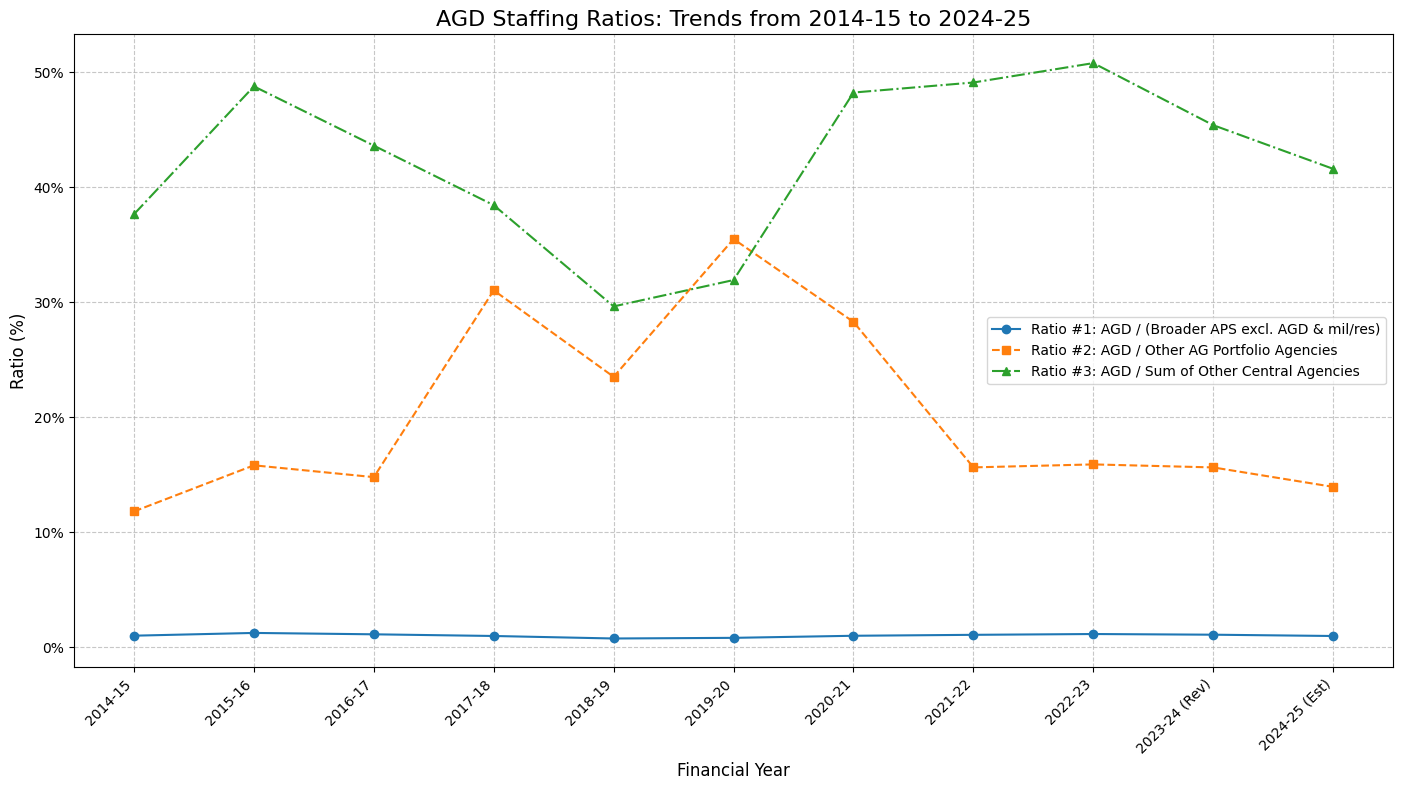

In [1]:
# @title AGD Staffing Ratios: Trends from 2014-15 to 2024-25
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Data
years = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20',
         '2020-21', '2021-22', '2022-23', '2023-24 (Rev)', '2024-25 (Est)']

ratio1 = [0.990, 1.230, 1.110, 0.964, 0.746, 0.802, 0.983, 1.065, 1.135, 1.076, 0.963] # AGD / Broader APS
ratio2 = [11.803, 15.815, 14.786, 31.038, 23.515, 35.502, 28.293, 15.634, 15.894, 15.631, 13.939] # AGD / Other AG Portfolio
ratio3 = [37.663, 48.788, 43.631, 38.449, 29.642, 31.936, 48.250, 49.125, 50.812, 45.411, 41.611] # AGD / Central Agencies

# Plotting
plt.figure(figsize=(14, 8))

plt.plot(years, ratio1, marker='o', linestyle='-', label='Ratio #1: AGD / (Broader APS excl. AGD & mil/res)')
plt.plot(years, ratio2, marker='s', linestyle='--', label='Ratio #2: AGD / Other AG Portfolio Agencies')
plt.plot(years, ratio3, marker='^', linestyle='-.', label='Ratio #3: AGD / Sum of Other Central Agencies')

# Adding titles and labels
plt.title('AGD Staffing Ratios: Trends from 2014-15 to 2024-25', fontsize=16)
plt.xlabel('Financial Year', fontsize=12)
plt.ylabel('Ratio (%)', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Format Y-axis as percentage
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Show plot
plt.show()

# 22nd May

In [ ]:
# @title Cell 8: Stakeholder Report Generation
import json
import os
import time

# --- Configuration for Stakeholder Report Generation ---
# !!! UPDATE THESE PATHS !!!
PHASE4_FINAL_REPORT_JSON_PATH = '/content/drive/MyDrive/Colab Notebooks/Legal/Phase4_Final_Thematic_Analysis/phase4_final_thematic_report_20250523_070820.json' # Input from your Phase 4
STAKEHOLDER_REPORT_OUTPUT_TXT_PATH = f'/content/drive/MyDrive/Colab Notebooks/Legal/stakeholder_thematic_summary_report_{time.strftime("%Y%m%d_%H%M%S")}.txt'

NUM_TOP_POINTS_TO_DISPLAY = 3 # How many top points to show per question
SHOW_LLM_SUGGESTED_THEMES_WITHOUT_COUNTS = True # If True, also lists LLM themes that haven't been quantified yet

def generate_stakeholder_report(phase4_data_file: str, output_report_file: str):
    """
    Reads the Phase 4 final analysis JSON and generates a human-readable
    summary report for stakeholder communication.
    """
    report_lines = []
    report_lines.append("=" * 80)
    report_lines.append("STAKEHOLDER COMMUNICATION: SUMMARY OF THEMATIC ANALYSIS FROM SUBMISSIONS")
    report_lines.append("=" * 80)
    report_lines.append(f"Report generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append(f"Source data: {os.path.basename(phase4_data_file)}\n")

    try:
        with open(phase4_data_file, 'r', encoding='utf-8') as f:
            phase4_data = json.load(f)
    except FileNotFoundError:
        report_lines.append(f"ERROR: Phase 4 report file not found at {phase4_data_file}")
        print("\n".join(report_lines))
        with open(output_report_file, 'w', encoding='utf-8') as f_out:
            f_out.write("\n".join(report_lines))
        return
    except json.JSONDecodeError:
        report_lines.append(f"ERROR: Could not decode JSON from {phase4_data_file}")
        print("\n".join(report_lines))
        with open(output_report_file, 'w', encoding='utf-8') as f_out:
            f_out.write("\n".join(report_lines))
        return

    # Sort QIDs for consistent report order (optional, e.g., sort by Q number if QIDs are like "Q1", "Q2")
    sorted_qids = []
    try:
        # Attempt to sort numerically if QIDs are like "Q1", "Q10", "Q2"
        sorted_qids = sorted(phase4_data.keys(), key=lambda q: int(q[1:]) if q.startswith('Q') and q[1:].isdigit() else float('inf'))
    except:
        sorted_qids = sorted(phase4_data.keys()) # Fallback to alphabetical sort

    for qid in sorted_qids:
        qid_data = phase4_data.get(qid, {})
        question_text = qid_data.get("question_text", f"Question text for {qid} not available.")

        report_lines.append("-" * 70)
        report_lines.append(f"\nQUESTION {qid}: {question_text}\n")

        quantified_points = qid_data.get("quantified_points", [])

        # Sort quantified points by unique_response_count in descending order
        # Ensure 'unique_response_count' exists and is an int for sorting
        valid_quantified_points = [
            pt for pt in quantified_points
            if isinstance(pt.get("unique_response_count"), int) and pt.get("point_label")
        ]
        sorted_points = sorted(valid_quantified_points, key=lambda x: x.get("unique_response_count", 0), reverse=True)

        if sorted_points:
            report_lines.append("  Most Common Points Raised (based on keyphrase matching in PDF submissions):")
            for i, point_data in enumerate(sorted_points[:NUM_TOP_POINTS_TO_DISPLAY]):
                point_label = point_data.get("point_label_human_defined", point_data.get("point_label", "N/A"))
                count = point_data.get("unique_response_count", 0)
                llm_explanation = point_data.get("llm_explanation_if_direct_match", "") # Or from llm_generated_themes if linked

                report_lines.append(f"\n    {i+1}. {point_label} (Mentioned by {count} unique responses)")
                if llm_explanation and llm_explanation != "This point label was human-defined/refined.": # Show LLM explanation if available and relevant
                    report_lines.append(f"       LLM Explanation: {llm_explanation}")

                example_quotes = point_data.get("example_quotes", [])
                if example_quotes:
                    report_lines.append("       Example Quotes:")
                    for quote_idx, quote_info in enumerate(example_quotes[:P4_NUM_EXAMPLE_QUOTES_PER_THEME]): # P4_NUM_EXAMPLE_QUOTES_PER_THEME from global config
                        quote_text = quote_info.get("quote_snippet", quote_info.get("quote", "Quote not available")).strip()
                        source_type = quote_info.get("source_document_type", "N/A")
                        resp_id = quote_info.get("response_id", "N/A")
                        report_lines.append(f"         - \"{quote_text}\" (From Response ID: {resp_id}, Source Type: {source_type})")
                else:
                    report_lines.append("       (No example quotes extracted for this point based on current keyphrases)")

            if len(sorted_points) > NUM_TOP_POINTS_TO_DISPLAY:
                report_lines.append(f"\n    (...and {len(sorted_points) - NUM_TOP_POINTS_TO_DISPLAY} other quantified points with lower counts.)")

        else:
            report_lines.append("  No points were quantified for this question based on the current keyphrase definitions.")

        if SHOW_LLM_SUGGESTED_THEMES_WITHOUT_COUNTS:
            llm_themes = qid_data.get("llm_generated_themes_from_p3", [])
            unquantified_llm_themes = []
            quantified_labels = {pt.get("point_label_human_defined", pt.get("point_label")) for pt in sorted_points}

            for llm_theme in llm_themes:
                llm_label = llm_theme.get("theme_label")
                if llm_label and not llm_label.lower().startswith(("llm error", "unparsed", "valid json")):
                    # Check if this LLM theme (or a very similar one) was already covered by quantified_points
                    # This simple check assumes human labels in keyphrase file might match LLM labels.
                    # A more sophisticated check would involve semantic similarity or manual mapping.
                    if llm_label not in quantified_labels:
                         # Check if a human-defined point *derived* from this LLM theme already exists
                        is_covered = False
                        for qp_label in quantified_labels:
                            if llm_label in qp_label or qp_label in llm_label: # Simple substring check for relation
                                is_covered = True
                                break
                        if not is_covered:
                             unquantified_llm_themes.append(llm_theme)

            if unquantified_llm_themes:
                report_lines.append("\n  Further LLM-Suggested Themes (awaiting keyphrase definition for quantification):")
                for theme in unquantified_llm_themes:
                    report_lines.append(f"    - Label: {theme.get('theme_label')}")
                    report_lines.append(f"      Explanation: {theme.get('explanation')}")
        report_lines.append("") # Blank line for spacing

    report_lines.append("=" * 80)
    report_lines.append("END OF REPORT")
    report_lines.append("=" * 80)

    final_report_str = "\n".join(report_lines)
    print(final_report_str) # Print to console

    try:
        with open(output_report_file, 'w', encoding='utf-8') as f_out:
            f_out.write(final_report_str)
        print(f"\nINFO: Stakeholder report saved to: {output_report_file}")
    except Exception as e:
        print(f"ERROR: Could not save stakeholder report to file: {e}")

# --- Example Usage (assuming this script is in its own cell or .py file) ---
if __name__ == "__main__":
    # Ensure the PHASE4_FINAL_REPORT_JSON_PATH and STAKEHOLDER_REPORT_OUTPUT_TXT_PATH are correctly set above.
    # You might also want to load P4_NUM_EXAMPLE_QUOTES_PER_THEME from your global config if it's defined there.
    # For this standalone script, let's use a default if it's not found in globals.
    try:
        num_quotes_config = P4_NUM_EXAMPLE_QUOTES_PER_THEME
    except NameError:
        print("WARN: P4_NUM_EXAMPLE_QUOTES_PER_THEME not found in global scope, defaulting to 2 for report.")
        P4_NUM_EXAMPLE_QUOTES_PER_THEME = 2 # Default

    if not os.path.exists(PHASE4_FINAL_REPORT_JSON_PATH):
        print(f"ERROR: Input Phase 4 JSON report not found at '{PHASE4_FINAL_REPORT_JSON_PATH}'. Please check the path.")
    else:
        generate_stakeholder_report(PHASE4_FINAL_REPORT_JSON_PATH, STAKEHOLDER_REPORT_OUTPUT_TXT_PATH)

WARN: P4_NUM_EXAMPLE_QUOTES_PER_THEME not found in global scope, defaulting to 2 for report.
STAKEHOLDER COMMUNICATION: SUMMARY OF THEMATIC ANALYSIS FROM SUBMISSIONS
Report generated on: 2025-05-22 06:40:28
Source data: phase4_final_thematic_report_20250522_003334.json

----------------------------------------------------------------------

QUESTION Q1: Should there be a criminal offence for re-identifying de-identified information? What exceptions should apply?

  Most Common Points Raised (based on keyphrase matching in PDF submissions):

    1. Criminal Offense for Malicious Re-Identification (LLM Suggested - Keyphrases Needed for Count) (Mentioned by 0 unique responses)
       (No example quotes extracted for this point based on current keyphrases)

    2. Proportionality and Context-Dependent Exceptions (LLM Suggested - Keyphrases Needed for Count) (Mentioned by 0 unique responses)
       (No example quotes extracted for this point based on current keyphrases)

    3. Need for Cle

In [ ]:
# @title Cell 2: Global Project Configuration

import os
import time

# --- Base Paths ---
BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/'
PHASE1_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase1_PDF_Extraction_Outputs/')
PHASE2_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase2_PDF_Collated_Texts/')
PHASE3_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase3_LLM_Generated_Themes/')
PHASE4_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase4_Final_Thematic_Analysis/')
LOG_DIR = os.path.join(BASE_PROJECT_DIR, 'Pipeline_Logs/')
for d_path in [PHASE1_OUTPUT_DIR, PHASE2_OUTPUT_DIR, PHASE3_OUTPUT_DIR, PHASE4_OUTPUT_DIR, LOG_DIR]:
    os.makedirs(d_path, exist_ok=True)

# --- Common Input Files ---
ORIGINAL_RESPONSES_JSONL = os.path.join(BASE_PROJECT_DIR, 'processed_responses.jsonl')
QUESTION_DEFINITIONS_FILE = os.path.join(BASE_PROJECT_DIR, 'question_centric_aggregation_output.json')

# --- Phase 1: PDF Extraction & Per-Response Summarization ---
P1_LOG_FILE = os.path.join(LOG_DIR, "phase1_pdf_extraction.log")
P1_OUTPUT_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_pdf_analysis_by_response.json') # Changed from _FULL
P1_STATE_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_processing_state.json')
P1_EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
P1_LLM_ID_FOR_SUMMARIES = 'google/gemma-3-4b-it' # Smaller, faster for many small summaries
P1_USE_QUANTIZATION = True # Recommended for 2b to save memory
P1_MIN_PDF_TEXT_LENGTH = 100
P1_MIN_SIMILARITY_SCORE = 0.5
P1_CONTEXT_WINDOW_SIZE_SENTENCES = 1
P1_TOP_K_PASSAGES = 3
P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID = 3 # For P1's summarizer prompt
P1_MIN_CHARS_FOR_SUMMARY = 150
P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY = 250 # For P1 summaries
P1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE = { # As defined before }
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True, "Q6": True, "Q7": True,
    "Q8": True, "Q9": True, "Q10": True,"Q11": True, "Q12": True, "Q13": True, "Q14": True,
    "Q15": True, "Q16": False,"Q17": True, "Q18": True, "Q19": True,"Q20": False, "Q21": True,
    "Q22": True, "Q23": True, "Q24": True, "Q25": True, "Q26": True, "Q27": True, "Q28": True,
    "Q29": True, "Q30": True, "Q31": True,"Q32": False,"Q33": False,"Q34": False,"Q35": False,
    "Q36": False,
}
P1_MAX_RUNTIME_MINUTES = 60 * 8 # For a full run if needed
P1_SAVE_STATE_INTERVAL_SECONDS = 60 * 20

# --- Phase 2: Collation of PDF Content ---
P2_LOG_FILE = os.path.join(LOG_DIR, f'phase2_text_collation_{time.strftime("%Y%m%d")}.log')
P2_INPUT_FILE_OR_DIR = P1_OUTPUT_FILE
P2_OUTPUT_COLLATED_JSON = os.path.join(PHASE2_OUTPUT_DIR, f'phase2_collated_pdf_texts_{time.strftime("%Y%m%d_%H%M%S")}.json')

# --- Phase 3: LLM Thematic Point Generation ---
P3_LOG_FILE = os.path.join(LOG_DIR, f'phase3_llm_themes_{time.strftime("%Y%m%d_%H%M%S")}.log')
P3_INPUT_COLLATED_JSON = P2_OUTPUT_COLLATED_JSON
P3_OUTPUT_LLM_THEMES_JSON = os.path.join(PHASE3_OUTPUT_DIR, f'phase3_llm_generated_themes_{time.strftime("%Y%m%d_%H%M%S")}.json')
P3_LLM_ID_FOR_THEMES = "Qwen/Qwen3-4B" # <<<--- REVISED based on tests
P3_USE_QUANTIZATION = True                     # <<<--- REVISED based on tests
P3_NUM_THEMES_MAP_STR = "up to 2"              # <<<--- REVISED: String for map prompt
P3_NUM_THEMES_MAP_INT = 2                      # <<<--- REVISED: Integer for parsing map output
P3_NUM_THEMES_REDUCE_STR = "top 3"             # <<<--- REVISED: String for reduce prompt
P3_NUM_THEMES_REDUCE_INT = 3                   # <<<--- REVISED: Integer for parsing reduce output
P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 3000 # Max content tokens for a batch of items
P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 800     # <<<--- REVISED based on tests
P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 1000 # <<<--- REVISED based on tests
P3_QIDS_TO_PROCESS_THEMATICALLY = ["Q4", "Q16"] # e.g. ["Q1", "Q4", "Q16"] for testing, None for all

# --- Phase 4: Theme Validation, Quantification & Quotation Extraction ---
P4_LOG_FILE = os.path.join(LOG_DIR, f'phase4_theme_quantification_{time.strftime("%Y%m%d_%H%M%S")}.log')
P4_INPUT_LLM_THEMES_JSON = P3_OUTPUT_LLM_THEMES_JSON
P4_INPUT_COLLATED_TEXTS_JSON = P2_OUTPUT_COLLATED_JSON
P4_OUTPUT_FINAL_ANALYSIS_JSON = os.path.join(PHASE4_OUTPUT_DIR, f'phase4_final_thematic_report_{time.strftime("%Y%m%d_%H%M%S")}.json')
P4_HUMAN_DEFINED_KEYPHRASES_FILE = os.path.join(BASE_PROJECT_DIR, 'human_defined_keyphrases_for_themes.json')
P4_NUM_EXAMPLE_QUOTES_PER_THEME = 2

# --- General ---
ENABLE_DETAILED_DEBUG_LOGGING = True # Keep False for full runs, True for deep debugging

print(f"INFO: Cell 2 - Global Configuration loaded. Base project directory: {BASE_PROJECT_DIR}")

INFO: Cell 2 - Global Configuration loaded. Base project directory: /content/drive/MyDrive/Colab Notebooks/Legal/


In [ ]:
# @title Cell 5: Phase 3 - LLM Thematic Point Generation (Map-Reduce)

# logger_p3 = FileLogger(P3_LOG_FILE) # Will be initialized in Orchestration cell

# --- Helper: Batch Individual Items (for Map step on list of texts) ---
def batch_text_items_p3(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int, logger_instance):
    # ... (Same as batch_text_items_q1_test from successful Qwen test, using logger_instance)
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_instance.log(f"DEBUG P3_BATCHER: Batching {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip(): continue
        text_to_try_adding = item_text_original
        if current_batch_item_texts: text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original
        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: batches.append(current_batch_item_texts)
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_instance.log(f"  WARN P3_BATCHER: Item {item_idx} ({single_item_tokens} tokens) > limit ({max_tokens_per_batch}). Own oversized batch.")
                batches.append([item_text_original])
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original
    if current_batch_item_texts: batches.append(current_batch_item_texts)
    logger_instance.log(f"INFO P3_BATCHER: Created {len(batches)} batches of items.")
    return batches

# --- Helper: LLM Call for Thematic Points (JSON Output, Qwen2-NoThink adapted) ---
def get_llm_json_themes_p3(text_input_for_llm: str, question_text_for_prompt: str,
                           num_themes_instruction_str: str, # e.g., "up to 2" or "top 3"
                           llm_pipe: pipeline, max_new_tokens: int,
                           log_prefix_qid_step: str, map_reduce_step_type: str, logger_instance):
    # ... (Same as get_llm_json_themes_q1_qwen2_nothink_test, using logger_instance)
    # ... (Ensure prompt reflects "MAP_ON_BATCHED_ITEMS" (general items) or "REDUCE_INTERMEDIATE_THEMES")
    json_format_example = ("{\n  \"themes\": [\n    {\"theme_label\": \"Label 1\", \"explanation\": \"Expl 1.\"},\n"
                           "    {\"theme_label\": \"Label 2\", \"explanation\": \"Expl 2.\"}\n  ]\n}")
    system_prompt = "You are an expert policy analyst."
    user_content = ""
    if map_reduce_step_type == "MAP_ON_BATCHED_ITEMS":
        user_content = (
            f"Carefully review the BATCH of excerpts/summaries from PDF submissions, responding to: '{question_text_for_prompt}'.\n"
            f"Identify prominent and distinct points from THIS BATCH, {num_themes_instruction_str}.\n"
            f"Respond *only* with a single, valid JSON object with a 'themes' list, each theme having 'theme_label' and 'explanation'.\n"
            f"Example JSON:\n{json_format_example}\n\nBatch:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:")
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        user_content = (
            f"The following are preliminary themes/points from different responses to: '{question_text_for_prompt}'.\n"
            f"Synthesize these into overall significant and distinct common themes, {num_themes_instruction_str}.\n"
            f"Respond *only* with a single, valid JSON object... (etc.)\nExample JSON:\n{json_format_example}\n\n"
            f"Preliminary Themes:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output (Synthesized {num_themes_instruction_str} Themes):")
    else: # DIRECT_PROCESSING (if only one batch from Phase 2 items)
        user_content = (
            f"Carefully review the following text (summaries/excerpts) from PDF submissions responding to: '{question_text_for_prompt}'.\n"
            f"Identify common and distinct points, {num_themes_instruction_str}.\n"
            f"Respond *only* with a single, valid JSON object... (etc.)\nExample JSON:\n{json_format_example}\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:")

    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)
        terminators = [llm_pipe.tokenizer.eos_token_id, llm_pipe.tokenizer.convert_tokens_to_ids("<|im_end|>")]
        valid_terminators = [t for t in terminators if t is not None]
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": True, "temperature": 0.7, "top_p": 0.8, "top_k": 20,
                           "eos_token_id": valid_terminators, "pad_token_id": llm_pipe.tokenizer.eos_token_id}

        model_config = llm_pipe.model.config
        model_max_len = getattr(model_config, 'max_position_embeddings', None) or \
                        getattr(model_config, 'max_sequence_length', None) or \
                        getattr(model_config, 'sliding_window', None) or \
                        getattr(model_config, 'window_size', None) or \
                        getattr(llm_pipe.tokenizer, 'model_max_length', None) or 32768
        logger_instance.log(f"DEBUG P3_LLM: {map_reduce_step_type} for {log_prefix_qid_step}. Model_max_len: {model_max_len}.")
        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95:
             logger_instance.log(f"WARN P3_LLM: {log_prefix_qid_step} - Prompt+Output may exceed context {model_max_len}.")

        outputs = llm_pipe(prompt_formatted, **generation_args)
        generated_text_full = outputs[0]['generated_text']
        assistant_response_start_tag = "<|im_start|>assistant\n"
        actual_response_text = generated_text_full
        last_assistant_tag_idx = generated_text_full.rfind(assistant_response_start_tag)
        if last_assistant_tag_idx != -1: actual_response_text = generated_text_full[last_assistant_tag_idx + len(assistant_response_start_tag):].strip()
        elif prompt_formatted in generated_text_full: actual_response_text = generated_text_full[len(prompt_formatted):].strip()
        if actual_response_text.endswith("<|im_end|>"): actual_response_text = actual_response_text[:-len("<|im_end|>")].strip()
        llm_json_part = actual_response_text
        json_match = re.search(r"```json\s*(\{.*?\})\s*```", actual_response_text, re.DOTALL)
        if json_match: llm_json_part = json_match.group(1).strip()
        else:
            first_brace = actual_response_text.find('{'); last_brace = actual_response_text.rfind('}')
            if first_brace != -1 and last_brace != -1 and last_brace > first_brace: llm_json_part = actual_response_text[first_brace : last_brace+1].strip()
            else: logger_instance.log(f"WARN P3_LLM: No clear JSON block for {log_prefix_qid_step}.")
        logger_instance.log(f"    RAW LLM JSON-candidate for {log_prefix_qid_step} ({map_reduce_step_type}):\n{llm_json_part}")
        return llm_json_part
    except Exception as e:
        logger_instance.log(f"ERROR P3_LLM: {map_reduce_step_type} exception for {log_prefix_qid_step}: {e}\n{traceback.format_exc()}")
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes_p3(llm_json_output_text: str, max_themes_to_extract: int, logger_instance) -> List[Dict[str, str]]:
    # ... (Same as parse_llm_json_themes_q1_test, using logger_instance) ...
    logger_instance.log(f"DEBUG P3_JSON_PARSER: Parsing up to {max_themes_to_extract} from: '{llm_json_output_text[:100]}...'")
    parsed_themes = []
    error_entry = lambda expl: [{"theme_label": "Parsing/LLM Error", "explanation": str(expl)[:500] + "..."}]
    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"): return error_entry(llm_json_output_text)
    try:
        data = json.loads(llm_json_output_text)
        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if len(parsed_themes) >= max_themes_to_extract: break
                if isinstance(theme_obj, dict) and "theme_label" in theme_obj and "explanation" in theme_obj:
                    parsed_themes.append({"theme_label": str(theme_obj["theme_label"]), "explanation": str(theme_obj["explanation"])})
            if parsed_themes: logger_instance.log(f"DEBUG P3_JSON_PARSER: Parsed {len(parsed_themes)} themes."); return parsed_themes
            else: logger_instance.log("WARN P3_JSON_PARSER: Valid JSON, 'themes' list empty/malformed."); return error_entry(f"Valid JSON, themes empty. Raw: {llm_json_output_text[:200]}")
        else: logger_instance.log(f"WARN P3_JSON_PARSER: LLM JSON not expected structure. Got: {str(data)[:200]}"); return error_entry(f"Valid JSON, unexpected struct. Raw: {llm_json_output_text[:200]}")
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P3_JSON_PARSER: Not valid JSON. Error: {e}. Raw:\n{llm_json_output_text}")
        return error_entry(f"JSONDecodeError: {e}. Raw: {llm_json_output_text[:200]}")
    except Exception as e_gen:
        logger_instance.log(f"ERROR P3_JSON_PARSER: Unexpected error: {e_gen}\n{traceback.format_exc()}")
        return error_entry(f"Unexpected Parsing Error: {e_gen}. Raw: {llm_json_output_text[:200]}")

# --- Main Function for Phase 3 ---
def run_phase3_llm_thematic_generation(logger_p3_instance): # Pass logger
    logger_p3 = logger_p3_instance
    logger_p3.log("=" * 50); logger_p3.log(" INFO: Starting Phase 3: LLM Thematic Point Generation (Qwen2, Map-Reduce, JSON)"); logger_p3.log("=" * 50)

    # --- Load LLM ---
    llm_thematic_pipe_p3 = None; tokenizer_p3_for_batcher = None
    try:
        logger_p3.log(f"INFO P3: Loading LLM: {P3_LLM_ID_FOR_THEMES} (Quant: {P3_USE_QUANTIZATION})")
        tokenizer_p3_for_batcher = AutoTokenizer.from_pretrained(P3_LLM_ID_FOR_THEMES, trust_remote_code=True)
        if getattr(tokenizer_p3_for_batcher, 'pad_token', None) is None : tokenizer_p3_for_batcher.pad_token = tokenizer_p3_for_batcher.eos_token

        bnb_config_p3 = None; current_p3_quant = P3_USE_QUANTIZATION
        if P3_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16
                bnb_config_p3 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except Exception as qe: logger_p3.log(f"WARN P3: BNB config failed: {qe}. Disabling quant."); current_p3_quant=False
        elif P3_USE_QUANTIZATION: current_p3_quant=False; logger_p3.log("WARN P3: Quant requested, No CUDA.")

        model_p3 = AutoModelForCausalLM.from_pretrained( P3_LLM_ID_FOR_THEMES,
            quantization_config=bnb_config_p3 if current_p3_quant else None,
            torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True)
        llm_thematic_pipe_p3 = pipeline("text-generation", model=model_p3, tokenizer=tokenizer_p3_for_batcher)
        logger_p3.log("INFO P3: LLM Pipeline Loaded.")
    except Exception as e: logger_p3.log(f"CRITICAL P3: LLM loading failed: {e}\n{traceback.format_exc()}"); return False

    # --- Load Collated Texts (Phase 2 output) & Question Definitions ---
    try:
        with open(P3_INPUT_COLLATED_JSON, 'r', encoding='utf-8') as f: collated_data = json.load(f)
        collated_texts_by_qid_p3 = collated_data.get("aggregated_pdf_content_by_qid", {})
        if not collated_texts_by_qid_p3 : raise ValueError("P2 output empty or malformed.")
        with open(QUESTION_DEFINITIONS_FILE, 'r', encoding='utf-8') as f: q_defs = json.load(f)
        qid_to_actual_question_text_p3 = {k:v.get("question_text","") for k,v in q_defs.get("question_data", {}).items()}
        logger_p3.log(f"INFO P3: Loaded collated texts for {len(collated_texts_by_qid_p3)} QIDs and {len(qid_to_actual_question_text_p3)} Q-texts.")
    except Exception as e: logger_p3.log(f"FATAL P3: Data loading failed: {e}\n{traceback.format_exc()}"); return False

    overall_thematic_results_p3 = {};
    if os.path.exists(P3_OUTPUT_LLM_THEMES_JSON): # Load existing results to resume
        try:
            with open(P3_OUTPUT_LLM_THEMES_JSON,'r', encoding='utf-8') as f_exist: overall_thematic_results_p3=json.load(f_exist)
            logger_p3.log(f"INFO P3: Loaded {len(overall_thematic_results_p3)} existing results from {P3_OUTPUT_LLM_THEMES_JSON}")
        except: logger_p3.log(f"WARN P3: Could not load existing output {P3_OUTPUT_LLM_THEMES_JSON}, starting fresh for this run.")

    qids_to_run = P3_QIDS_TO_PROCESS_THEMATICALLY if P3_QIDS_TO_PROCESS_THEMATICALLY else sorted(collated_texts_by_qid_p3.keys())

    for qid_idx, qid in enumerate(qids_to_run):
        logger_p3.log(f"\n--- P3 Processing QID {qid_idx + 1}/{len(qids_to_run)}: {qid} ---")
        if qid in overall_thematic_results_p3 and overall_thematic_results_p3[qid].get("status", "").startswith("success"):
            logger_p3.log(f"INFO P3: QID {qid} already successfully processed. Skipping."); continue

        question_actual_text = qid_to_actual_question_text_p3.get(qid, f"Question {qid}")
        source_text_items_for_qid = [item for item in collated_texts_by_qid_p3.get(qid, []) if item.get("text")] # list of dicts

        if not source_text_items_for_qid:
            logger_p3.log(f"WARN P3: No source texts for QID {qid}. Skipping.");
            overall_thematic_results_p3[qid] = {"question_text": question_actual_text, "status":"no_source_texts", "parsed_top_themes":[]};
            continue

        # Default to Scenario B type: batching individual items from Stage4a
        # (These items can be 'pdf_summary' or 'pdf_passages' type from Phase 2)
        list_of_texts_for_qid = [item['text'] for item in source_text_items_for_qid]
        map_batches_p3 = batch_text_items_p3(
            list_of_texts_for_qid,
            llm_thematic_pipe_p3.tokenizer, # Use the loaded tokenizer
            P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
            logger_p3
        )

        final_llm_output_str = "N/A"; raw_map_outputs = []; status_p3="init"

        if not map_batches_p3:
            logger_p3.log(f"WARN P3: No map batches created for QID {qid}."); status_p3="no_map_batches"
        elif len(map_batches_p3) == 1:
            logger_p3.log(f"INFO P3: QID {qid} - Single batch ({len(map_batches_p3[0])} items). Direct LLM call.")
            direct_input_text = "\n\n--- Next Excerpt ---\n".join(map_batches_p3[0])
            final_llm_output_str = get_llm_json_themes_p3(
                direct_input_text, question_actual_text, P3_NUM_THEMES_REDUCE_STR, # Use REDUCE num for direct
                llm_thematic_pipe_p3, P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, # Use REDUCE tokens for final
                f"{qid}_direct_batch", "DIRECT_PROCESSING_PASSAGES", logger_p3 # Generic type
            )
            raw_map_outputs.append(final_llm_output_str)
        else: # Map-Reduce
            logger_p3.log(f"INFO P3: QID {qid} - Map-Reduce with {len(map_batches_p3)} map steps.")
            intermediate_themes_text_p3 = []
            for i, batch_of_item_strings in enumerate(map_batches_p3):
                batch_concat_text = "\n\n--- Next Excerpt ---\n".join(batch_of_item_strings)
                map_out = get_llm_json_themes_p3(
                    batch_concat_text, question_actual_text, P3_NUM_THEMES_MAP_STR, # Use MAP num for prompt
                    llm_thematic_pipe_p3, P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid}_map_batch{i+1}", "MAP_ON_BATCHED_ITEMS", logger_p3
                )
                raw_map_outputs.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_text_p3.append(map_out)
                time.sleep(0.2) # Brief pause

            if intermediate_themes_text_p3:
                parsed_intermediate_for_reduce = []
                for idx, raw_json_map_out in enumerate(intermediate_themes_text_p3):
                    parsed_map_themes = parse_llm_json_themes_p3(raw_json_map_out, P3_NUM_THEMES_MAP_INT, logger_p3) # Use MAP int for parsing
                    for pt_map in parsed_map_themes:
                        if not pt_map.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                            parsed_intermediate_for_reduce.append(f"Theme Label: {pt_map.get('theme_label')}\nExplanation: {pt_map.get('explanation')}")

                if parsed_intermediate_for_reduce:
                    combined_intermediate_text = "\n\n---\n\n".join(parsed_intermediate_for_reduce)
                    final_llm_output_str = get_llm_json_themes_p3(
                        combined_intermediate_text, question_actual_text, P3_NUM_THEMES_REDUCE_STR, # Use REDUCE num for prompt
                        llm_thematic_pipe_p3, P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                        f"{qid}_reduce", "REDUCE_INTERMEDIATE_THEMES", logger_p3)
                else: status_p3 = "error_map_parsing_no_valid_themes"; final_llm_output_str = "Error: Could not parse valid intermediate themes."
            else: status_p3 = "error_map_step_all_failed"; final_llm_output_str = "Error: All map steps failed."

        parsed_themes_list_p3 = parse_llm_json_themes_p3(final_llm_output_str, P3_NUM_THEMES_REDUCE_INT, logger_p3) # Use REDUCE int for final parsing
        if status_p3 == "init":
            status_p3 = "success_thematic_analysis" if not final_llm_output_str.startswith("LLM_ERROR:") and not (len(parsed_themes_list_p3)==1 and parsed_themes_list_p3[0]["theme_label"].lower().startswith(("llm error", "unparsed", "valid json"))) else "error_final_llm_or_parse"

        overall_thematic_results_p3[qid] = {
            "question_text": question_actual_text, "status": status_p3,
            "total_source_items_for_qid": len(source_text_items_for_qid),
            "map_reduce_applied": len(map_batches_p3) > 1 if map_batches_p3 else False,
            "num_map_batches": len(map_batches_p3) if map_batches_p3 else 0,
            "parsed_top_themes": parsed_themes_list_p3,
            "llm_raw_output_final_synthesis": final_llm_output_str,
            "llm_raw_output_map_batches": raw_map_outputs
        }
        try:
            with open(P3_OUTPUT_LLM_THEMES_JSON, 'w', encoding='utf-8') as f_out:
                json.dump(overall_thematic_results_p3, f_out, indent=2, default=logger_p3._get_serializer())
            logger_p3.log(f"INFO P3: Saved results to '{P3_OUTPUT_LLM_THEMES_JSON}' after QID {qid}.")
        except Exception as es: logger_p3.log(f"ERROR P3: Save failed for QID {qid}: {es}")
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None

    logger_p3.log("=" * 50); logger_p3.log(" INFO: Phase 3 Finished "); logger_p3.log("=" * 50)
    return True

print("INFO: Cell 5 - Phase 3 logic defined.")

INFO: Cell 5 - Phase 3 logic defined.


In [ ]:
# @title Cell 6: Phase 4 - Theme Validation, Quantification & Quotation Extraction (REVISED)

# logger_p4 will be initialized in the Orchestration Cell (Cell 7)
# For standalone testing of this cell, you would initialize it here:
# if 'logger_p4' not in locals():
#     P4_LOG_FILE_TEST = os.path.join(LOG_DIR, f'phase4_test_{time.strftime("%Y%m%d_%H%M%S")}.log')
#     logger_p4 = FileLogger(P4_LOG_FILE_TEST) # Needs LOG_DIR from Cell 2
#     ENABLE_DETAILED_DEBUG_LOGGING = True # For testing

def load_human_defined_keyphrases_p4(keyphrase_file_path: str, logger_instance) -> Dict[str, Dict[str, List[str]]]:
    if not os.path.exists(keyphrase_file_path):
        logger_instance.log(f"WARN P4: Keyphrase file not found: {keyphrase_file_path}. Will be treated as empty. Quantification will be limited.")
        return {}
    try:
        with open(keyphrase_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        if not isinstance(data, dict):
            logger_instance.log(f"ERROR P4: Keyphrase file {keyphrase_file_path} is not a valid JSON dictionary. Returning empty.")
            return {}
        logger_instance.log(f"INFO P4: Successfully loaded {len(data)} QIDs with keyphrases from {keyphrase_file_path}.")
        return data
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P4: Failed to decode JSON from keyphrase file {keyphrase_file_path}: {e}")
        return {}
    except Exception as e:
        logger_instance.log(f"ERROR P4: Failed to load keyphrase file {keyphrase_file_path}: {e}")
        return {}

def count_themes_and_extract_quotes_p4(
    llm_themes_by_qid: Dict[str, Any], # Output from Phase 3 (QID -> P3 analysis dict)
    collated_source_texts_data: Dict[str, Any], # Output from Phase 2 (P2_OUTPUT_COLLATED_JSON)
    human_keyphrases_by_qid: Dict[str, Dict[str, List[str]]], # Loaded from P4_HUMAN_DEFINED_KEYPHRASES_FILE
    num_quotes_per_theme: int,
    logger_instance # Instance of FileLogger
) -> Dict[str, Any]:
    final_report_data_p4 = {}
    # aggregated_pdf_content_by_qid is the key in Phase 2's output
    source_texts_for_all_qids = collated_source_texts_data.get("aggregated_pdf_content_by_qid", {})

    for qid, p3_qid_analysis_data in llm_themes_by_qid.items():
        # Ensure ENABLE_DETAILED_DEBUG_LOGGING is accessible, e.g., passed or global
        # For simplicity, assuming it's a global variable from Cell 2
        # If not, pass it as an argument: def count_themes_and_extract_quotes_p4(..., enable_debug_logging_flag)

        logger_instance.log(f"INFO P4: Processing QID: {qid} for quantification and quoting.")

        question_text = p3_qid_analysis_data.get("question_text", f"Question text N/A for {qid}")
        llm_identified_themes_p3 = p3_qid_analysis_data.get("parsed_top_themes", [])

        final_report_data_p4[qid] = {
            "question_text": question_text,
            "llm_generated_themes_from_p3": llm_identified_themes_p3,
            "status_from_p3": p3_qid_analysis_data.get("status", "N/A"),
            "quantified_points": []
        }

        qid_human_keyphrases = human_keyphrases_by_qid.get(qid, {})
        source_text_items_for_this_qid = source_texts_for_all_qids.get(qid, []) # List of dicts from Phase 2

        if not source_text_items_for_this_qid:
            logger_instance.log(f"  WARN P4: No source texts (from Phase 2 output) found for QID {qid}. Cannot quantify or quote.")
            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": "No Source Texts Available for QID",
                "keyphrases_used": [], "unique_response_count": 0, "example_quotes": []
            })
            continue # Next QID

        if not qid_human_keyphrases:
            logger_instance.log(f"  WARN P4: No human-defined keyphrases for QID {qid}. Listing LLM themes from Phase 3 with 0 count.")
            for llm_theme in llm_identified_themes_p3:
                if isinstance(llm_theme, dict) and not llm_theme.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                    final_report_data_p4[qid]["quantified_points"].append({
                        "point_label": llm_theme.get("theme_label") + " (LLM Suggested - Keyphrases Needed for Count)",
                        "llm_explanation": llm_theme.get("explanation"),
                        "keyphrases_used_for_counting": ["N/A - Define keyphrases"],
                        "unique_response_count": 0,
                        "example_quotes": []
                    })
            continue # Next QID

        # If we have human-defined keyphrases for this QID
        for human_point_label, phrases_for_point in qid_human_keyphrases.items():
            if not phrases_for_point: # Skip if a point label has no keyphrases
                logger_instance.log(f"  WARN P4: QID {qid} - Point '{human_point_label}' has no keyphrases defined. Skipping.")
                continue

            logger_instance.log(f"  P4 Counting for QID {qid} - Point: '{human_point_label}' using phrases: {phrases_for_point}")

            point_matching_response_ids = set()
            # Stores dicts: {'response_id':..., 'full_text_item': (str), 'source_document_type': ..., 'matched_phrase':...}
            source_items_for_potential_quotes = []

            # --- First Pass: Identify all matching responses and the specific text items for this point ---
            for source_item in source_text_items_for_this_qid:
                item_text_content = source_item.get("text", "")
                if not item_text_content: continue

                item_text_lower = item_text_content.lower()
                response_id = source_item.get("response_id")

                for phrase in phrases_for_point:
                    phrase_lower = phrase.lower()
                    # Using regex for whole word matching
                    if re.search(r'\b' + re.escape(phrase_lower) + r'\b', item_text_lower):
                        if response_id: point_matching_response_ids.add(response_id)
                        source_items_for_potential_quotes.append({
                            "response_id": response_id,
                            "full_text_item": item_text_content,
                            "source_document_type": source_item.get("type"),
                            "matched_phrase": phrase # Store original case phrase for context
                        })
                        if ENABLE_DETAILED_DEBUG_LOGGING:
                            logger_instance.log(f"    DEBUG P4 MATCH: QID {qid}, Point '{human_point_label}', RespID '{response_id}' matched phrase '{phrase}'. Text snippet: '{item_text_lower[:100]}...'")
                        break # This source_item matches this human_point_label, move to next source_item

            unique_response_count_for_point = len(point_matching_response_ids)
            selected_quotes_for_point = []

            if unique_response_count_for_point > 0 and source_items_for_potential_quotes:
                if ENABLE_DETAILED_DEBUG_LOGGING:
                    logger_instance.log(f"    DEBUG P4 QUOTE PREP: QID {qid}, Point '{human_point_label}': {unique_response_count_for_point} unique responses. Found {len(source_items_for_potential_quotes)} text items containing keyphrases to search for quotes.")

                # --- Second Pass: Extract actual quote snippets from the matched text items ---
                quotes_extracted_so_far = 0
                # To get diverse quotes, we can shuffle or iterate based on response_id
                # For simplicity, let's try to get one quote per matched response first, then fill if needed.

                # Get one quote per response ID first
                temp_quotes_by_response = defaultdict(list)
                for quote_candidate_info in source_items_for_potential_quotes:
                    full_text = quote_candidate_info["full_text_item"]
                    phrase_to_find_in_sentence = quote_candidate_info["matched_phrase"] # Use the phrase that caused the item to be selected

                    try:
                        sentences = nltk.sent_tokenize(full_text)
                    except Exception as e_sent_tokenize:
                        logger_instance.log(f"    WARN P4 QUOTE: NLTK sent_tokenize failed for a text item for QID {qid}, RespID {quote_candidate_info['response_id']}. Error: {e_sent_tokenize}. Using full text as single sentence.")
                        sentences = [full_text]

                    for sent_idx, sentence in enumerate(sentences):
                        if re.search(r'\b' + re.escape(phrase_to_find_in_sentence.lower()) + r'\b', sentence.lower()):
                            context_start = max(0, sent_idx - 1)
                            context_end = min(len(sentences), sent_idx + 2)
                            context_snippet = " ".join(sentences[context_start:context_end]).strip()

                            temp_quotes_by_response[quote_candidate_info["response_id"]].append({
                                "response_id": quote_candidate_info["response_id"],
                                "source_document_type": quote_candidate_info["source_document_type"],
                                "matched_phrase": phrase_to_find_in_sentence,
                                "quote": sentence.strip(),
                                "broader_context": context_snippet
                            })
                            break # Take first matching sentence for this phrase from this source_item

                # Select quotes, prioritizing different responses
                seen_responses_for_this_point_quotes = set()
                for resp_id in point_matching_response_ids: # Iterate through IDs that matched the theme
                    if len(selected_quotes_for_point) >= num_quotes_per_theme: break
                    if resp_id in temp_quotes_by_response and temp_quotes_by_response[resp_id]:
                        selected_quotes_for_point.append(temp_quotes_by_response[resp_id][0]) # Take the first quote found for this response
                        seen_responses_for_this_point_quotes.add(resp_id)

                # If still need more quotes, fill from any available (even if duplicate response_id)
                if len(selected_quotes_for_point) < num_quotes_per_theme:
                    for resp_id, quotes_list in temp_quotes_by_response.items():
                        if len(selected_quotes_for_point) >= num_quotes_per_theme: break
                        if resp_id not in seen_responses_for_this_point_quotes: # Should not happen if logic above is correct
                            for quote_obj in quotes_list:
                                if len(selected_quotes_for_point) < num_quotes_per_theme:
                                    selected_quotes_for_point.append(quote_obj)
                                else: break
                        elif len(quotes_list) > 1 and resp_id in seen_responses_for_this_point_quotes: # If we already have a quote from this response, pick another if available
                             for quote_obj_idx, quote_obj in enumerate(quotes_list):
                                 if quote_obj_idx == 0 and resp_id in seen_responses_for_this_point_quotes: continue # skip first one if already added
                                 if len(selected_quotes_for_point) < num_quotes_per_theme:
                                     selected_quotes_for_point.append(quote_obj)
                                 else: break

            # Find corresponding LLM explanation for this human_point_label
            # This assumes human_point_label in keyphrases might match an LLM-generated theme_label
            llm_explanation_for_point = "N/A - Human point label may not directly map to a single Phase 3 LLM theme."
            if isinstance(llm_identified_themes_p3, list):
                for llm_theme_obj in llm_identified_themes_p3:
                    if isinstance(llm_theme_obj, dict) and llm_theme_obj.get("theme_label") == human_point_label:
                        llm_explanation_for_point = llm_theme_obj.get("explanation", "N/A")
                        break

            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": human_point_label,
                "llm_explanation_if_direct_match": llm_explanation_for_point,
                "keyphrases_used_for_counting": phrases_for_point,
                "unique_response_count": unique_response_count_for_point,
                "example_quotes": selected_quotes_for_point
            })
            logger_instance.log(f"    P4 QID {qid} - Point '{human_point_label}': Final count {unique_response_count_for_point}. Extracted {len(selected_quotes_for_point)} quotes.")
            if ENABLE_DETAILED_DEBUG_LOGGING and not selected_quotes_for_point and unique_response_count_for_point > 0:
                 logger_instance.log(f"      DEBUG P4 NO QUOTES: Point '{human_point_label}' had count {unique_response_count_for_point} but no quotes selected. Check potential_quotes and selection logic.")
                 if point_potential_quotes_with_context:
                     logger_instance.log(f"        First potential quote source info: {point_potential_quotes_with_context[0]}")

    return final_report_data_p4


def run_phase4_theme_quantification_and_quoting(logger_p4_instance):
    # global logger_p4 # Not needed if passed
    logger_p4 = logger_p4_instance
    logger_p4.log("=" * 50); logger_p4.log(" INFO: Starting Phase 4: Theme Quantification & Quotation Extraction"); logger_p4.log("=" * 50)

    # 1. Load LLM-generated themes from Phase 3
    llm_themes_data_from_p3 = {}
    try:
        logger_p4.log(f"INFO P4: Loading LLM themes from: {P4_INPUT_LLM_THEMES_JSON}")
        with open(P4_INPUT_LLM_THEMES_JSON, 'r', encoding='utf-8') as f:
            llm_themes_data_from_p3 = json.load(f)
        if not llm_themes_data_from_p3 or not isinstance(llm_themes_data_from_p3, dict):
             logger_p4.log(f"ERROR P4: Phase 3 output file {P4_INPUT_LLM_THEMES_JSON} is empty or not a dict. Cannot proceed with quantification."); return False
        logger_p4.log(f"INFO P4: Loaded {len(llm_themes_data_from_p3)} QIDs with LLM themes from {P4_INPUT_LLM_THEMES_JSON}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 3 output file {P4_INPUT_LLM_THEMES_JSON} not found. Run Phase 3 first."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load LLM themes: {e}\n{traceback.format_exc()}"); return False

    # 2. Load collated source texts from Phase 2
    collated_texts_data_from_p2 = {}
    try:
        logger_p4.log(f"INFO P4: Loading collated texts from: {P4_INPUT_COLLATED_TEXTS_JSON}")
        with open(P4_INPUT_COLLATED_TEXTS_JSON, 'r', encoding='utf-8') as f:
            collated_texts_data_from_p2 = json.load(f)
        if not collated_texts_data_from_p2 or not isinstance(collated_texts_data_from_p2.get("aggregated_pdf_content_by_qid"), dict):
            logger_p4.log(f"ERROR P4: Phase 2 output file {P4_INPUT_COLLATED_TEXTS_JSON} is empty or malformed."); return False
        logger_p4.log(f"INFO P4: Loaded collated texts from {P4_INPUT_COLLATED_TEXTS_JSON}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 2 collated texts file {P4_INPUT_COLLATED_TEXTS_JSON} not found. Run Phase 2 first."); return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load collated texts: {e}\n{traceback.format_exc()}"); return False

    # 3. Load human-defined keyphrases
    human_keyphrases = load_human_defined_keyphrases_p4(P4_HUMAN_DEFINED_KEYPHRASES_FILE, logger_p4)
    if not human_keyphrases:
        logger_p4.log(f"WARN P4: {P4_HUMAN_DEFINED_KEYPHRASES_FILE} was empty or not found. Quantification will be based on LLM themes only (counts will be 0 unless keyphrases are added).")

    # 4. Perform counting and quote extraction
    # Pass the actual dicts to the processing function
    final_report_content = count_themes_and_extract_quotes_p4(
        llm_themes_data_from_p3,             # This is the dict of QID -> P3 analysis results
        collated_texts_data_from_p2,         # This is the dict from P2 (contains "aggregated_pdf_content_by_qid")
        human_keyphrases,
        P4_NUM_EXAMPLE_QUOTES_PER_THEME, # From global config
        logger_p4
    )

    # 5. Save the final analysis
    try:
        logger_p4.log(f"INFO P4: Saving final thematic report to {P4_OUTPUT_FINAL_ANALYSIS_JSON}")
        with open(P4_OUTPUT_FINAL_ANALYSIS_JSON, 'w', encoding='utf-8') as f:
            json.dump(final_report_content, f, indent=2, default=logger_p4._get_serializer())
        logger_p4.log(f"INFO P4: Successfully saved final thematic report to {P4_OUTPUT_FINAL_ANALYSIS_JSON}")
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to save final analysis: {e}\n{traceback.format_exc()}"); return False

    logger_p4.log("=" * 50); logger_p4.log(" INFO: Phase 4 Finished "); logger_p4.log("=" * 50)
    return True

print("INFO: Cell 6 - Phase 4 logic defined.")

INFO: Cell 6 - Phase 4 logic defined.


# 21st May

Overall Pipeline Structure:
- Cell 0: Initial Setup & Global Imports (As you have it - Python, ML/NLP, Transformers)
- Cell 1: FileLogger Class & NLTK Downloads (As you have it)
- Cell 2: Global Configuration (Define paths, model IDs, key parameters for ALL phases here, or have per-phase config cells)
- --- PDF CONTENT ANALYSIS PIPELINE ---
- Cell 3: Phase 1 - PDF Text & Passage Extraction, Per-Response Summarization (Original Stage 4)
 - Configuration specific to Phase 1 (if not in global config).
 - Helper functions for Phase 1.
 - Main execution function run_phase1_pdf_extraction().
- Cell 4: Phase 2 - Collation of PDF Content (Original Stage 4a)
 - Configuration specific to Phase 2.
 - Helper functions for Phase 2 (like clean_text).
 - Main execution function run_phase2_collate_pdf_texts().
- Cell 5: Phase 3 - LLM Thematic Point Generation (Map-Reduce)
 - Configuration specific to Phase 3 (LLM, Map-Reduce params, QID selection).
 - Helper functions for Phase 3 (chunkers, batchers, LLM call, JSON parser).
 - Main execution function run_phase3_llm_thematic_generation().
- Cell 6: Phase 4 - Theme Validation, Quantification & Quotation Extraction (NEW)
 - Configuration specific to Phase 4.
 - Helper functions for Phase 4 (keyphrase matching, quote extraction).
 - Main execution function run_phase4_theme_quantification_and_quoting().
- Cell 7: Main Orchestration Cell (To run selected phases sequentially)

## Direct Comparison (if desired on same QID):
- While Q4 didn't have passages for Scenario B, you could now run Scenario A (on summaries) for Q16, since Q16 also had PHASE1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE = False. This means for Q16, the collated_texts_by_qid_p3.get("Q16", []) in the Phase 3 input would only contain passage items.
- To run a "Scenario A-like" process on Q16, you would first need to generate Stage 4 summaries for the Q16 passages. This would mean:
 1. Modify PHASE1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE in Cell 2 to set "Q16": True.
 1. Re-run Phase 1 (Cell 3 via Cell 9 orchestration). This will generate summaries for Q16.
 1. Re-run Phase 2 (Cell 4 via Cell 9) to create a new phase2_...json file that now includes pdf_summary type items for Q16.
 1. Then, you could run your Scenario A logic (Map-Reduce on those newly generated summaries for Q16) using the test cell.
- This is a more involved process but would give you a direct comparison of themes from "summaries of Q16 passages" vs. themes from "Q16 passages themselves." For now, comparing Q4-Summaries with Q16-Passages gives you a good sense of the two approaches.

In [ ]:
# @title Q16 TARGETED TEST CELL (SCENARIO B with Qwen2-4B, NoThinking): Thematic Analysis on Passages

# --- Test Cell Imports ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
# try:
#     from bitsandbytes.cextension import ColabNotSupportedError
# except ImportError:
#     ColabNotSupportedError = None

# --- Configuration for this Q16 Scenario B Test Cell ---
Q16B_TEST_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
Q16B_TEST_LOG_FILE = os.path.join(Q16B_TEST_BASE_PROJECT_DIR, f'q16_scenario_b_qwen2_4b_test_v2_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config for Qwen2-4B-Instruct
Q16B_TEST_LLM_MODEL_ID = "Qwen/Qwen3-4B"
Q16B_TEST_USE_QUANTIZATION = True

# Thematic Analysis Parameters
Q16B_TEST_NUM_THEMES_FROM_MAP_CHUNK_STR = "up to 2"
Q16B_TEST_NUM_THEMES_FROM_MAP_CHUNK_INT = 2
Q16B_TEST_FINAL_NUM_THEMES = 3

Q16B_TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 3000
Q16B_TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 800
Q16B_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 1000

Q16B_TEST_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(Q16B_TEST_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE

Q16B_TEST_QUESTION_TEXT_SOURCE_FILE = os.path.join(Q16B_TEST_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json')

QID_FOR_SCENARIO_B_TEST = "Q16"

# --- FileLogger ---
try:
    logger_q16b_test = FileLogger(Q16B_TEST_LOG_FILE)
    logger_q16b_test.log(f"INFO: Q16 Scenario B Test (Qwen2-4B, NoThink) - Logger Initialized for QID: {QID_FOR_SCENARIO_B_TEST}.")
except NameError:
    class PrintLogger:
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
    logger_q16b_test = PrintLogger()
    logger_q16b_test.log(f"WARN: Q16 Scenario B Test (Qwen2-4B, NoThink) - Using fallback PrintLogger for QID: {QID_FOR_SCENARIO_B_TEST}.")

# --- Helper: Batch Individual Text Items ---
def batch_text_items_for_map_step(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int, logger_instance): # Added logger_instance
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_instance.log(f"DEBUG BATCHER: Batching {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip(): continue
        text_to_try_adding = item_text_original
        if current_batch_item_texts: text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original
        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: batches.append(current_batch_item_texts)
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_instance.log(f"  WARN BATCHER: Item {item_idx} ({single_item_tokens} tokens) > limit ({max_tokens_per_batch}). Own oversized batch.")
                batches.append([item_text_original])
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original
    if current_batch_item_texts: batches.append(current_batch_item_texts)
    logger_instance.log(f"INFO BATCHER: Created {len(batches)} batches of items.")
    return batches

# --- Helper: LLM Call ---
def get_llm_json_themes(text_input_for_llm: str, question_text_for_prompt: str,
                        num_themes_to_request_in_prompt: str,
                        llm_pipe: pipeline, max_new_tokens: int,
                        log_prefix_qid_step: str, map_reduce_step_type: str, logger_instance):
    # ... (Function content as provided in the previous "Qwen2-4B No Thinking" test cell, using logger_instance) ...
    # ... (Ensuring prompts are correct for SCENARIO_B_MAP and REDUCE_INTERMEDIATE_THEMES)
    json_format_example = ("{\n  \"themes\": [\n    {\"theme_label\": \"Label 1\", \"explanation\": \"Expl 1.\"},\n"
                           "    {\"theme_label\": \"Label 2\", \"explanation\": \"Expl 2.\"}\n  ]\n}")
    system_prompt = "You are an expert policy analyst."
    user_content = ""
    input_type_description = "excerpts/summaries"
    if map_reduce_step_type == "SCENARIO_A_MAP": input_type_description = "CHUNK of concatenated PREVIOUSLY-GENERATED SUMMARIES"
    elif map_reduce_step_type == "SCENARIO_B_MAP": input_type_description = "BATCH of original excerpts/passages"
    elif map_reduce_step_type == "DIRECT_PROCESSING_SUMMARIES": input_type_description = "combined PDF summaries"
    elif map_reduce_step_type == "DIRECT_PROCESSING_PASSAGES": input_type_description = "single batch of excerpts/passages"

    if map_reduce_step_type in ["SCENARIO_A_MAP", "SCENARIO_B_MAP", "DIRECT_PROCESSING_SUMMARIES", "DIRECT_PROCESSING_PASSAGES"]:
        prompt_verb = "identify"
        if map_reduce_step_type.startswith("DIRECT_PROCESSING"): prompt_verb = "identify the most common and distinct"
        user_content = (
            f"Carefully review the following {input_type_description} from PDF submissions, all responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided text, {prompt_verb} points, arguments, or themes, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, containing a list called 'themes'. Each object in the 'themes' list must have two string keys: 'theme_label' and 'explanation'. If no clear themes are present or fewer than requested are distinct, return only those that are clear within the JSON structure.\n"
            f"Example JSON format (if requesting {num_themes_to_request_in_prompt}):\n{json_format_example}\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:" )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        user_content = (
            f"The following are sets of preliminary themes/points ... question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall most significant and distinct common themes, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object... (etc.)\n"
            f"Example JSON format:\n{json_format_example}\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output (Synthesized {num_themes_to_request_in_prompt} Themes):" )
    else: logger_instance.log(f"ERROR LLM_CALL: Unknown map_reduce_step_type: {map_reduce_step_type}"); return "LLM_ERROR: Unknown step type"

    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)
        terminators = [llm_pipe.tokenizer.eos_token_id, llm_pipe.tokenizer.convert_tokens_to_ids("<|im_end|>")]
        valid_terminators = [t for t in terminators if t is not None]
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": True, "temperature": 0.7, "top_p": 0.8, "top_k": 20,
                           "eos_token_id": valid_terminators, "pad_token_id": llm_pipe.tokenizer.eos_token_id}

        model_config = llm_pipe.model.config
        model_max_len = getattr(model_config, 'max_position_embeddings', None) or \
                        getattr(model_config, 'max_sequence_length', None) or \
                        getattr(model_config, 'sliding_window', None) or \
                        getattr(model_config, 'window_size', None) or \
                        getattr(llm_pipe.tokenizer, 'model_max_length', None) or 32768
        logger_instance.log(f"DEBUG LLM_CALL: {map_reduce_step_type} for {log_prefix_qid_step}. Effective model_max_len: {model_max_len}.")
        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95:
             logger_instance.log(f"WARN LLM_CALL: {log_prefix_qid_step} - Step {map_reduce_step_type} - Prompt+Output may exceed context {model_max_len}.")

        outputs = llm_pipe(prompt_formatted, **generation_args)
        generated_text_full = outputs[0]['generated_text']

        assistant_response_start_tag = "<|im_start|>assistant\n"
        actual_response_text = generated_text_full
        last_assistant_tag_idx = generated_text_full.rfind(assistant_response_start_tag)
        if last_assistant_tag_idx != -1: actual_response_text = generated_text_full[last_assistant_tag_idx + len(assistant_response_start_tag):].strip()
        elif prompt_formatted in generated_text_full: actual_response_text = generated_text_full[len(prompt_formatted):].strip()
        if actual_response_text.endswith("<|im_end|>"): actual_response_text = actual_response_text[:-len("<|im_end|>")].strip()

        llm_json_part = actual_response_text
        json_match = re.search(r"```json\s*(\{.*?\})\s*```", actual_response_text, re.DOTALL)
        if json_match: llm_json_part = json_match.group(1).strip()
        else:
            first_brace = actual_response_text.find('{'); last_brace = actual_response_text.rfind('}')
            if first_brace != -1 and last_brace != -1 and last_brace > first_brace:
                llm_json_part = actual_response_text[first_brace : last_brace+1].strip()
            else: logger_instance.log(f"WARN LLM_CALL: No clear JSON block for {log_prefix_qid_step}.")

        logger_instance.log(f"    RAW LLM JSON-candidate PART for {log_prefix_qid_step} ({map_reduce_step_type}):\n{llm_json_part}")
        return llm_json_part
    except Exception as e:
        logger_instance.log(f"ERROR LLM_CALL: {map_reduce_step_type} LLM exception for {log_prefix_qid_step}: {e}\n{traceback.format_exc()}")
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes(llm_json_output_text: str, max_themes_to_extract: int, logger_instance) -> List[Dict[str, str]]:
    # ... (Same robust JSON parser, using logger_instance) ...
    logger_instance.log(f"DEBUG JSON_PARSER: Parsing up to {max_themes_to_extract} from: '{llm_json_output_text[:100]}...'")
    parsed_themes = []
    error_entry = lambda expl: [{"theme_label": "Parsing/LLM Error", "explanation": str(expl)[:500] + "..."}]
    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"): return error_entry(llm_json_output_text)
    try:
        data = json.loads(llm_json_output_text)
        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if len(parsed_themes) >= max_themes_to_extract: break
                if isinstance(theme_obj, dict) and "theme_label" in theme_obj and "explanation" in theme_obj:
                    parsed_themes.append({"theme_label": str(theme_obj["theme_label"]), "explanation": str(theme_obj["explanation"])})
            if parsed_themes: logger_instance.log(f"DEBUG JSON_PARSER: Parsed {len(parsed_themes)} themes."); return parsed_themes
            else: logger_instance.log("WARN JSON_PARSER: Valid JSON, 'themes' list empty/malformed."); return error_entry(f"Valid JSON, themes empty. Raw: {llm_json_output_text[:200]}")
        else: logger_instance.log(f"WARN JSON_PARSER: LLM JSON not expected structure. Got: {str(data)[:200]}"); return error_entry(f"Valid JSON, unexpected struct. Raw: {llm_json_output_text[:200]}")
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR JSON_PARSER: Not valid JSON. Error: {e}. Raw:\n{llm_json_output_text}")
        return error_entry(f"JSONDecodeError: {e}. Raw: {llm_json_output_text[:200]}")
    except Exception as e_gen:
        logger_instance.log(f"ERROR JSON_PARSER: Unexpected error: {e_gen}\n{traceback.format_exc()}")
        return error_entry(f"Unexpected Parsing Error: {e_gen}. Raw: {llm_json_output_text[:200]}")


# --- Main Test Execution Function for SCENARIO B ---
def run_scenario_b_q16_test():
    logger_q16b_test.log(f"INFO: Scenario B Test (Qwen2-4B, Passages) - Starting for QID: {QID_FOR_SCENARIO_B_TEST}")

    # --- 0. Load Actual Question Text for Q16 ---
    question_actual_text_q16 = f"Question text for {QID_FOR_SCENARIO_B_TEST} not loaded"
    try:
        logger_q16b_test.log(f"INFO Q16B_TEST: Loading question texts from: {Q16B_TEST_QUESTION_TEXT_SOURCE_FILE}")
        if not os.path.exists(Q16B_TEST_QUESTION_TEXT_SOURCE_FILE): raise FileNotFoundError(f"File not found: {Q16B_TEST_QUESTION_TEXT_SOURCE_FILE}")
        with open(Q16B_TEST_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext: qtext_data = json.load(f_qtext)
        if "question_data" in qtext_data:
            q_data = qtext_data.get("question_data", {}).get(QID_FOR_SCENARIO_B_TEST)
            if q_data and "question_text" in q_data: question_actual_text_q16 = q_data["question_text"]
        logger_q16b_test.log(f"INFO Q16B_TEST: Using Q text for {QID_FOR_SCENARIO_B_TEST}: '{question_actual_text_q16[:100]}...'")
    except Exception as e: logger_q16b_test.log(f"ERROR Q16B_TEST: Failed to load Q text: {e}\n{traceback.format_exc()}")

    # --- 1. Load LLM ---
    llm_pipe_q16b_test = None; tokenizer_q16b_test = None
    try:
        logger_q16b_test.log(f"INFO Q16B_TEST: Loading LLM: {Q16B_TEST_LLM_MODEL_ID} (Quant: {Q16B_TEST_USE_QUANTIZATION})")
        tokenizer_q16b_test = AutoTokenizer.from_pretrained(Q16B_TEST_LLM_MODEL_ID, trust_remote_code=True)
        if getattr(tokenizer_q16b_test, 'pad_token', None) is None : tokenizer_q16b_test.pad_token = tokenizer_q16b_test.eos_token
        bnb_config_q16b = None; effective_quant_q16b = Q16B_TEST_USE_QUANTIZATION
        if Q16B_TEST_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16
                bnb_config_q16b = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except ImportError: effective_quant_q16b = False; logger_q16b_test.log("WARN Q16B_TEST: bitsandbytes NI.")
            except Exception as e_bnb: effective_quant_q16b = False; logger_q16b_test.log(f"WARN Q16B_TEST: BNB failed: {e_bnb}.")
        elif Q16B_TEST_USE_QUANTIZATION: effective_quant_q16b = False; logger_q16b_test.log("WARN Q16B_TEST: Quant req, No CUDA.")
        model_q16b_test = AutoModelForCausalLM.from_pretrained(
            Q16B_TEST_LLM_MODEL_ID, quantization_config=bnb_config_q16b if effective_quant_q16b else None,
            torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True )
        llm_pipe_q16b_test = pipeline("text-generation", model=model_q16b_test, tokenizer=tokenizer_q16b_test)
        logger_q16b_test.log("INFO Q16B_TEST: LLM Pipeline (Qwen2-4B) Loaded.")
    except Exception as e: logger_q16b_test.log(f"CRITICAL Q16B_TEST: Failed to load LLM: {e}\n{traceback.format_exc()}"); return

    # --- 2. Load and Filter PASSAGES for Q16 ---
    q16_passages_for_analysis = []
    try:
        with open(Q16B_TEST_INPUT_COLLATED_PDF_TEXTS_JSON, 'r') as f: s4a_data = json.load(f)
        q16_all_s4a_items = s4a_data.get("aggregated_pdf_content_by_qid",{}).get(QID_FOR_SCENARIO_B_TEST,[])
        q16_passages_for_analysis = [item['text'] for item in q16_all_s4a_items if item.get('type')=='pdf_passages' and item.get('text')]
        if not q16_passages_for_analysis:
            logger_q16b_test.log(f"ERROR Q16B_TEST: No 'pdf_passages' items found for {QID_FOR_SCENARIO_B_TEST}. Cannot run Scenario B test."); return
        logger_q16b_test.log(f"INFO Q16B_TEST: Loaded {len(q16_passages_for_analysis)} PASSAGES for {QID_FOR_SCENARIO_B_TEST}.")
    except Exception as e: logger_q16b_test.log(f"CRITICAL Q16B_TEST: Failed data load for {QID_FOR_SCENARIO_B_TEST}: {e}\n{traceback.format_exc()}"); return

    # --- Map-Reduce Thematic Analysis for Q16 Passages ---
    final_parsed_themes_q16b = []
    map_llm_outputs_raw_q16b = []
    reduce_llm_output_raw_q16b = "N/A"

    map_batches_q16b = batch_text_items_for_map_step(
        q16_passages_for_analysis,
        llm_pipe_q16b_test.tokenizer,
        Q16B_TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
        logger_q16b_test # Pass logger
    )
    logger_q16b_test.log(f"INFO Q16B_TEST: Grouped items for {QID_FOR_SCENARIO_B_TEST} into {len(map_batches_q16b)} batches for Map step.")

    if not map_batches_q16b: logger_q16b_test.log(f"WARN Q16B_TEST: No map batches for {QID_FOR_SCENARIO_B_TEST}.")
    elif len(map_batches_q16b) == 1:
        direct_input_q16b = "\n\n--- Next Excerpt ---\n".join(map_batches_q16b[0])
        reduce_llm_output_raw_q16b = get_llm_json_themes(
            direct_input_q16b, question_actual_text_q16, f"top {Q16B_TEST_FINAL_NUM_THEMES}",
            llm_pipe_q16b_test, Q16B_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
            f"{QID_FOR_SCENARIO_B_TEST}_direct_passages", "DIRECT_PROCESSING_PASSAGES", logger_q16b_test
        )
        final_parsed_themes_q16b = parse_llm_json_themes(reduce_llm_output_raw_q16b, Q16B_TEST_FINAL_NUM_THEMES, logger_q16b_test)
        map_llm_outputs_raw_q16b.append(reduce_llm_output_raw_q16b)
    else:
        intermediate_themes_q16b_list = []
        for i, batch_of_passage_strings in enumerate(map_batches_q16b):
            current_batch_concatenated_text = "\n\n--- Next Excerpt ---\n".join(batch_of_passage_strings)
            logger_q16b_test.log(f"  SCENARIO B - MAP BATCH {i+1}/{len(map_batches_q16b)} for {QID_FOR_SCENARIO_B_TEST} (Passage items: {len(batch_of_passage_strings)}, Chars: {len(current_batch_concatenated_text)})")
            map_out = get_llm_json_themes(
                current_batch_concatenated_text, question_actual_text_q16,
                Q16B_TEST_NUM_THEMES_FROM_MAP_CHUNK_STR,
                llm_pipe_q16b_test, Q16B_TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                f"{QID_FOR_SCENARIO_B_TEST}_map_batch{i+1}", "SCENARIO_B_MAP", logger_q16b_test
            )
            map_llm_outputs_raw_q16b.append(map_out)
            if not map_out.startswith("LLM_ERROR:"): intermediate_themes_q16b_list.append(map_out)
            time.sleep(0.5)

        if intermediate_themes_q16b_list:
            parsed_intermediate_for_reduce_q16b = []
            for idx, raw_json_map_out in enumerate(intermediate_themes_q16b_list):
                parsed_map_themes = parse_llm_json_themes(raw_json_map_out, Q16B_TEST_NUM_THEMES_FROM_MAP_CHUNK_INT, logger_q16b_test)
                logger_q16b_test.log(f"  Q16B_TEST PARSED MAP OUTPUT for batch {idx+1}: {parsed_map_themes}")
                for pt_map in parsed_map_themes:
                    if not pt_map.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                        parsed_intermediate_for_reduce_q16b.append(f"Preliminary Theme ... Label: {pt_map.get('theme_label')}\nExplanation: {pt_map.get('explanation')}")

            if parsed_intermediate_for_reduce_q16b:
                combined_intermediate_text_q16b = "\n\n---\n\n".join(parsed_intermediate_for_reduce_q16b)
                reduce_llm_output_raw_q16b = get_llm_json_themes(
                    combined_intermediate_text_q16b, question_actual_text_q16, f"top {Q16B_TEST_FINAL_NUM_THEMES}",
                    llm_pipe_q16b_test, Q16B_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                    f"{QID_FOR_SCENARIO_B_TEST}_reduce", "REDUCE_INTERMEDIATE_THEMES", logger_q16b_test
                )
                final_parsed_themes_q16b = parse_llm_json_themes(reduce_llm_output_raw_q16b, Q16B_TEST_FINAL_NUM_THEMES, logger_q16b_test)
            else: reduce_llm_output_raw_q16b = f"ERROR: No successfully parsed intermediate themes for {QID_FOR_SCENARIO_B_TEST} (Passages)."
        else: reduce_llm_output_raw_q16b = f"ERROR: No valid intermediate themes from MAP step for {QID_FOR_SCENARIO_B_TEST} (Passages)."

    logger_q16b_test.log(f"\n--- Q16 SCENARIO B (Qwen2-4B, Passages) - FINAL PARSED THEMES for {QID_FOR_SCENARIO_B_TEST} ---")
    if final_parsed_themes_q16b:
        for i, theme in enumerate(final_parsed_themes_q16b):
            logger_q16b_test.log(f"  Theme {i+1}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_q16b_test.log(f"  No final themes parsed for {QID_FOR_SCENARIO_B_TEST}.")
    logger_q16b_test.log(f"  Raw MAP (first, max 500): {(map_llm_outputs_raw_q16b[0][:500] + '...') if map_llm_outputs_raw_q16b and map_llm_outputs_raw_q16b[0] else 'N/A'}")
    logger_q16b_test.log(f"  Raw REDUCE (max 500): {(reduce_llm_output_raw_q16b[:500] + '...') if reduce_llm_output_raw_q16b else 'N/A'}")

    logger_q16b_test.log("\nINFO Q16B_TEST: Cleaning up LLM resources...")
    if 'llm_pipe_q16b_test' in locals(): del llm_pipe_q16b_test
    if 'model_q16b_test' in locals(): del model_q16b_test
    if 'tokenizer_q16b_test' in locals(): del tokenizer_q16b_test
    gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
    logger_q16b_test.log(f"INFO: Q16 Scenario B Test (Qwen2-4B, Passages) Finished for QID: {QID_FOR_SCENARIO_B_TEST}")

# --- Execute the Scenario B Test ---
# print("REMINDER: Update Q16B_TEST_... config vars. Ensure Cells 0 & 1 ran.")
# print("REMINDER: To run Scenario B test for Q16, uncomment the line below.")
# run_scenario_b_q16_test()

In [ ]:
# @title Q1 TARGETED TEST CELL (Qwen3-4B, NoThink, Increased Tokens): Thematic Analysis

# --- Test Cell Imports ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
# try:
#     from bitsandbytes.cextension import ColabNotSupportedError # From Cell 0
# except ImportError:
#     ColabNotSupportedError = None

# --- Configuration for this Q1 Test Cell ---
Q1_TEST_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
Q1_TEST_LOG_FILE = os.path.join(Q1_TEST_BASE_PROJECT_DIR, f'q1_targeted_qwen2_4b_nothink_v2_test_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config for Qwen2-4B-Instruct
Q1_TEST_LLM_MODEL_ID = "Qwen/Qwen3-4B"
Q1_TEST_USE_QUANTIZATION = True

# Thematic Analysis Parameters
Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK_STR = "up to 2" # String for LLM prompt for map step
Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK_INT = 2     # Integer for parsing map step output
Q1_TEST_FINAL_NUM_THEMES = 3                  # Final number of themes for REDUCE step (integer)

Q1_TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 3000 # Content tokens for input
Q1_TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 1000     # << INCREASED for LLM to output JSON for map
Q1_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 1000 # << INCREASED for LLM to output JSON for reduce

# Input file from Stage 4a
Q1_TEST_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(Q1_TEST_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE

# Source for actual question texts
Q1_TEST_QUESTION_TEXT_SOURCE_FILE = os.path.join(Q1_TEST_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json')

QID_TO_TEST = "Q1"

# --- FileLogger ---
try:
    logger_q1_test = FileLogger(Q1_TEST_LOG_FILE)
    logger_q1_test.log(f"INFO: Q1 Test (Qwen2-4B, NoThink, IncrTokens) - Logger Initialized for QID: {QID_TO_TEST}.")
except NameError: # Fallback
    class PrintLogger:
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
    logger_q1_test = PrintLogger()
    logger_q1_test.log(f"WARN: Q1 Test (Qwen2-4B, NoThink, IncrTokens) - Using fallback PrintLogger for QID: {QID_TO_TEST}.")

# --- Helper: Batch Individual Items (batch_text_items_q1_test - same as before) ---
def batch_text_items_q1_test(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int):
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_q1_test.log(f"DEBUG Q1_BATCHER: Batching {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip(): continue
        text_to_try_adding = item_text_original
        if current_batch_item_texts: text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original
        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: batches.append(current_batch_item_texts)
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_q1_test.log(f"  WARN Q1_BATCHER: Item {item_idx} ({single_item_tokens} tokens) > limit ({max_tokens_per_batch}). Own oversized batch.")
                batches.append([item_text_original])
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original
    if current_batch_item_texts: batches.append(current_batch_item_texts)
    logger_q1_test.log(f"INFO Q1_BATCHER: Created {len(batches)} batches of items.")
    return batches

# --- Helper: LLM Call (Adapted for Qwen2, enable_thinking=False) ---
def get_llm_json_themes_q1_qwen2_nothink_test(text_input_for_llm: str, question_text_for_prompt: str,
                                              num_themes_to_request_in_prompt: str, # String like "up to 2" or "top 3"
                                              llm_pipe: pipeline, max_new_tokens: int,
                                              log_prefix_qid_step: str, map_reduce_step_type: str):
    json_format_example = ("{\n  \"themes\": [\n    {\"theme_label\": \"Label 1\", \"explanation\": \"Expl 1.\"},\n"
                           "    {\"theme_label\": \"Label 2\", \"explanation\": \"Expl 2.\"}\n  ]\n}") # Example for 2 themes
    system_prompt = "You are an expert policy analyst."
    user_content = ""

    if map_reduce_step_type == "MAP_ON_BATCHED_ITEMS":
        user_content = (
            f"Carefully review the following BATCH of excerpts/summaries from PDF submissions, all responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided BATCH, identify the most prominent and distinct points, arguments, or themes, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, containing a list called 'themes'. Each object in the 'themes' list must have two string keys: 'theme_label' and 'explanation'. If no clear themes are present or fewer than requested are distinct, return only those that are clear within the JSON structure.\n"
            f"Example JSON format (if requesting {num_themes_to_request_in_prompt}):\n{json_format_example}\n\n"
            f"Batch of Excerpts/Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        user_content = (
            f"The following are sets of preliminary themes/points ... question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall most significant and distinct common themes, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object... (etc., ensure example matches num_themes_to_request_in_prompt)\n"
            f"Example JSON format (if requesting {num_themes_to_request_in_prompt}):\n{json_format_example}\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output (Synthesized {num_themes_to_request_in_prompt} Themes):"
        )
    else: # DIRECT_PROCESSING
        user_content = (
            f"Carefully review all the following text ... question: '{question_text_for_prompt}'.\n"
            f"Identify the most common and distinct points, arguments, or themes, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object... (etc.)\n"
            f"Example JSON:\n{json_format_example}\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )

    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True, enable_thinking=False
        )
        terminators = [llm_pipe.tokenizer.eos_token_id, llm_pipe.tokenizer.convert_tokens_to_ids("<|im_end|>")]
        valid_terminators = [t for t in terminators if t is not None]
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": True,
                           "temperature": 0.7, "top_p": 0.8, "top_k": 20,
                           "eos_token_id": valid_terminators, "pad_token_id": llm_pipe.tokenizer.eos_token_id}

        model_config = llm_pipe.model.config
        model_max_len = getattr(model_config, 'max_position_embeddings', None) or \
                        getattr(model_config, 'max_sequence_length', None) or \
                        getattr(model_config, 'sliding_window', None) or \
                        getattr(model_config, 'window_size', None) or \
                        getattr(llm_pipe.tokenizer, 'model_max_length', None) or 32768
        logger_q1_test.log(f"DEBUG Q1_LLM_CALL (Qwen2-NoThink): {map_reduce_step_type} for {log_prefix_qid_step}. Effective model_max_len for check: {model_max_len}.")
        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95: # Check if prompt + output might exceed
             logger_q1_test.log(f"WARN Q1_LLM_CALL (Qwen2-NoThink): {log_prefix_qid_step} - Prompt+Output may exceed context {model_max_len}.")

        outputs = llm_pipe(prompt_formatted, **generation_args)
        generated_text_full = outputs[0]['generated_text']

        assistant_response_start_tag = "<|im_start|>assistant\n"
        actual_response_text = generated_text_full
        last_assistant_tag_idx = generated_text_full.rfind(assistant_response_start_tag)
        if last_assistant_tag_idx != -1:
            actual_response_text = generated_text_full[last_assistant_tag_idx + len(assistant_response_start_tag):].strip()
        elif prompt_formatted in generated_text_full: # Less reliable fallback
            actual_response_text = generated_text_full[len(prompt_formatted):].strip()

        if actual_response_text.endswith("<|im_end|>"):
            actual_response_text = actual_response_text[:-len("<|im_end|>")].strip()

        llm_json_part = actual_response_text
        json_match = re.search(r"```json\s*(\{.*?\})\s*```", actual_response_text, re.DOTALL)
        if json_match: llm_json_part = json_match.group(1).strip()
        else:
            # Try to find first '{' and last '}'
            first_brace = actual_response_text.find('{')
            last_brace = actual_response_text.rfind('}')
            if first_brace != -1 and last_brace != -1 and last_brace > first_brace:
                llm_json_part = actual_response_text[first_brace : last_brace+1].strip()
            else: logger_q1_test.log(f"WARN Q1_LLM_CALL (Qwen2-NoThink): No clear JSON block for {log_prefix_qid_step}.")

        logger_q1_test.log(f"    Q1_TEST {map_reduce_step_type.upper()} RAW LLM JSON-candidate PART for {log_prefix_qid_step}:\n{llm_json_part}")
        return llm_json_part
    except Exception as e:
        logger_q1_test.log(f"ERROR Q1_LLM_CALL (Qwen2-NoThink): {map_reduce_step_type} LLM exception for {log_prefix_qid_step}: {e}\n{traceback.format_exc()}")
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes_q1_test(llm_json_output_text: str, max_themes_to_extract: int) -> List[Dict[str, str]]:
    # ... (Same robust JSON parser from previous, using logger_q1_test) ...
    logger_q1_test.log(f"DEBUG Q1_JSON_PARSER: Attempting to parse up to {max_themes_to_extract} themes from: '{llm_json_output_text[:100]}...'")
    parsed_themes = []
    error_entry = lambda expl: [{"theme_label": "Parsing/LLM Error", "explanation": str(expl)[:500] + "..."}]
    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"):
        return error_entry(llm_json_output_text)
    try:
        data = json.loads(llm_json_output_text)
        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if len(parsed_themes) >= max_themes_to_extract: break
                if isinstance(theme_obj, dict) and "theme_label" in theme_obj and "explanation" in theme_obj:
                    parsed_themes.append({"theme_label": str(theme_obj["theme_label"]), "explanation": str(theme_obj["explanation"])})
            if parsed_themes: logger_q1_test.log(f"DEBUG Q1_JSON_PARSER: Parsed {len(parsed_themes)} themes."); return parsed_themes
            else: logger_q1_test.log("WARN Q1_JSON_PARSER: Valid JSON, 'themes' list empty/malformed."); return error_entry(f"Valid JSON, themes empty. Raw: {llm_json_output_text[:200]}")
        else: logger_q1_test.log(f"WARN Q1_JSON_PARSER: LLM JSON not expected structure. Got: {str(data)[:200]}"); return error_entry(f"Valid JSON, unexpected struct. Raw: {llm_json_output_text[:200]}")
    except json.JSONDecodeError as e:
        logger_q1_test.log(f"ERROR Q1_JSON_PARSER: Not valid JSON. Error: {e}. Raw:\n{llm_json_output_text}")
        return error_entry(f"JSONDecodeError: {e}. Raw: {llm_json_output_text[:200]}")
    except Exception as e_gen:
        logger_q1_test.log(f"ERROR Q1_JSON_PARSER: Unexpected error: {e_gen}\n{traceback.format_exc()}")
        return error_entry(f"Unexpected Parsing Error: {e_gen}. Raw: {llm_json_output_text[:200]}")

# --- Main Test Execution Function ---
def run_q1_targeted_thematic_test_with_qwen2_nothink():
    logger_q1_test.log(f"INFO: Q1 Targeted Test (Qwen2-4B, NoThink, IncrTokens) - Starting analysis for QID: {QID_TO_TEST}")

    # --- 0. Load Actual Question Text ---
    question_actual_text_q1 = f"Question text for {QID_TO_TEST} not loaded"
    try:
        # ... (Q-text loading logic using Q1_TEST_QUESTION_TEXT_SOURCE_FILE) ...
        if not os.path.exists(Q1_TEST_QUESTION_TEXT_SOURCE_FILE): raise FileNotFoundError(f"File not found: {Q1_TEST_QUESTION_TEXT_SOURCE_FILE}")
        with open(Q1_TEST_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f: qtext_data = json.load(f)
        if "question_data" in qtext_data:
            q_data = qtext_data.get("question_data", {}).get(QID_TO_TEST)
            if q_data and "question_text" in q_data: question_actual_text_q1 = q_data["question_text"]
        logger_q1_test.log(f"INFO Q1_TEST: Using Q text: '{question_actual_text_q1[:100]}...'")
    except Exception as e: logger_q1_test.log(f"ERROR Q1_TEST: Failed to load Q text: {e}\n{traceback.format_exc()}")

    # --- 1. Load LLM (Qwen2-4B-Instruct) ---
    llm_pipe_q1_test = None; tokenizer_q1_test = None # For batcher
    # ... (Full LLM loading logic for Qwen2-4B from previous response, using Q1_TEST_... variables) ...
    try:
        logger_q1_test.log(f"INFO Q1_TEST: Loading LLM: {Q1_TEST_LLM_MODEL_ID} (Quant: {Q1_TEST_USE_QUANTIZATION})")
        tokenizer_q1_test = AutoTokenizer.from_pretrained(Q1_TEST_LLM_MODEL_ID, trust_remote_code=True)
        if getattr(tokenizer_q1_test, 'pad_token', None) is None : tokenizer_q1_test.pad_token = tokenizer_q1_test.eos_token
        bnb_config_q1 = None; effective_quant_q1 = Q1_TEST_USE_QUANTIZATION
        if Q1_TEST_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16
                bnb_config_q1 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except ImportError: effective_quant_q1 = False; logger_q1_test.log("WARN Q1_TEST: bitsandbytes NI for Qwen quant.")
            except Exception as e_bnb: effective_quant_q1 = False; logger_q1_test.log(f"WARN Q1_TEST: BNB failed for Qwen: {e_bnb}.")
        elif Q1_TEST_USE_QUANTIZATION: effective_quant_q1 = False; logger_q1_test.log("WARN Q1_TEST: Qwen Quant req, No CUDA.")
        model_q1_test = AutoModelForCausalLM.from_pretrained(
            Q1_TEST_LLM_MODEL_ID, quantization_config=bnb_config_q1 if effective_quant_q1 else None,
            torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True )
        llm_pipe_q1_test = pipeline("text-generation", model=model_q1_test, tokenizer=tokenizer_q1_test)
        logger_q1_test.log("INFO Q1_TEST: LLM Pipeline (Qwen2-4B) Loaded.")
    except Exception as e: logger_q1_test.log(f"CRITICAL Q1_TEST: Failed to load Qwen2-4B LLM: {e}\n{traceback.format_exc()}"); return

    # --- 2. Load and Filter Data for QID_TO_TEST ---
    q1_items_for_analysis = []
    # ... (Data loading and filtering logic as before) ...
    try:
        with open(Q1_TEST_INPUT_COLLATED_PDF_TEXTS_JSON, 'r') as f: s4a_data = json.load(f)
        q1_all_s4a_items = s4a_data.get("aggregated_pdf_content_by_qid",{}).get(QID_TO_TEST,[])
        q1_items_for_analysis = [item['text'] for item in q1_all_s4a_items if item.get('type')=='pdf_summary' and item.get('text')]
        if not q1_items_for_analysis:
            q1_items_for_analysis = [item['text'] for item in q1_all_s4a_items if item.get('type')=='pdf_passages' and item.get('text')]
            if q1_items_for_analysis: logger_q1_test.log(f"INFO Q1_TEST: Using {len(q1_items_for_analysis)} PASSAGES for {QID_TO_TEST}.")
        else: logger_q1_test.log(f"INFO Q1_TEST: Using {len(q1_items_for_analysis)} SUMMARIES for {QID_TO_TEST}.")
        if not q1_items_for_analysis: logger_q1_test.log(f"ERROR Q1_TEST: No usable text for {QID_TO_TEST}."); return
    except Exception as e: logger_q1_test.log(f"CRITICAL Q1_TEST: Failed data load for {QID_TO_TEST}: {e}\n{traceback.format_exc()}"); return

    # --- Map-Reduce Thematic Analysis ---
    final_parsed_themes_q1 = []
    map_llm_outputs_raw_q1 = []
    reduce_llm_output_raw = "N/A"

    map_batches_q1 = batch_text_items_q1_test(
        q1_items_for_analysis, llm_pipe_q1_test.tokenizer,
        Q1_TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
    )
    # ... (Rest of Map-Reduce logic, ensuring correct variables are passed to LLM and parser)
    if not map_batches_q1: logger_q1_test.log(f"WARN Q1_TEST: No map batches for {QID_TO_TEST}.")
    elif len(map_batches_q1) == 1:
        direct_input = "\n\n--- Next Excerpt ---\n".join(map_batches_q1[0])
        reduce_llm_output_raw = get_llm_json_themes_q1_qwen2_nothink_test( # Corrected function name
            direct_input, question_actual_text_q1, f"top {Q1_TEST_FINAL_NUM_THEMES}",
            llm_pipe_q1_test, Q1_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
            f"{QID_TO_TEST}_direct", "DIRECT_PROCESSING" )
        final_parsed_themes_q1 = parse_llm_json_themes_q1_test(reduce_llm_output_raw, Q1_TEST_FINAL_NUM_THEMES)
        map_llm_outputs_raw_q1.append(reduce_llm_output_raw)
    else:
        intermediate_themes_q1_list = []
        for i, batch_strings in enumerate(map_batches_q1):
            batch_concat_text = "\n\n--- Next Excerpt ---\n".join(batch_strings)
            # logger_q1_test.log(f"  Q1_TEST MAP BATCH {i+1}/{len(map_batches_q1)} ...") # Already in get_llm_json_themes
            map_out = get_llm_json_themes_q1_qwen2_nothink_test( # Corrected
                batch_concat_text, question_actual_text_q1,
                Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK_STR, # Use string "up to N" for prompt
                llm_pipe_q1_test, Q1_TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                f"{QID_TO_TEST}_map_batch{i+1}", "MAP_ON_BATCHED_ITEMS")
            map_llm_outputs_raw_q1.append(map_out)
            if not map_out.startswith("LLM_ERROR:"): intermediate_themes_q1_list.append(map_out)
            time.sleep(0.5)

        if intermediate_themes_q1_list:
            parsed_intermediate_for_reduce_q1 = []
            for idx, raw_json_map_out in enumerate(intermediate_themes_q1_list):
                # Use INT for parsing map outputs
                parsed_map_themes = parse_llm_json_themes_q1_test(raw_json_map_out, Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK_INT)
                logger_q1_test.log(f"  Q1_TEST PARSED MAP OUTPUT for batch {idx+1}: {parsed_map_themes}")
                for pt_map in parsed_map_themes:
                    if not pt_map.get("theme_label","").lower().startswith(("llm error", "parsing/llm error", "unparsed", "valid json")):
                        parsed_intermediate_for_reduce_q1.append(f"Preliminary Theme ... Label: {pt_map.get('theme_label')}\nExplanation: {pt_map.get('explanation')}")
                    else: logger_q1_test.log(f"  WARN Q1_TEST: Map batch {idx+1} parsing issue/LLM error for reduce input: {pt_map}")

            if parsed_intermediate_for_reduce_q1:
                combined_intermediate_text_q1 = "\n\n---\n\n".join(parsed_intermediate_for_reduce_q1)
                reduce_llm_output_raw = get_llm_json_themes_q1_qwen2_nothink_test( # Corrected
                    combined_intermediate_text_q1, question_actual_text_q1, f"top {Q1_TEST_FINAL_NUM_THEMES}",
                    llm_pipe_q1_test, Q1_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                    f"{QID_TO_TEST}_reduce", "REDUCE_INTERMEDIATE_THEMES")
                final_parsed_themes_q1 = parse_llm_json_themes_q1_test(reduce_llm_output_raw, Q1_TEST_FINAL_NUM_THEMES)
            else: reduce_llm_output_raw = f"ERROR: No successfully parsed intermediate themes for {QID_TO_TEST}."
        else: reduce_llm_output_raw = f"ERROR: No valid intermediate themes from MAP step for {QID_TO_TEST}."

    logger_q1_test.log(f"\n--- Q1 TARGETED TEST (Qwen2-4B, NoThink) - FINAL PARSED THEMES for {QID_TO_TEST} ---")
    # ... (Logging final themes and raw outputs)
    if final_parsed_themes_q1:
        for i, theme in enumerate(final_parsed_themes_q1): logger_q1_test.log(f"  Theme {i+1}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_q1_test.log(f"  No final themes parsed for {QID_TO_TEST}.")
    logger_q1_test.log(f"  Raw MAP (first, max 500): {(map_llm_outputs_raw_q1[0][:500] + '...') if map_llm_outputs_raw_q1 and map_llm_outputs_raw_q1[0] else 'N/A'}")
    logger_q1_test.log(f"  Raw REDUCE (max 500): {(reduce_llm_output_raw[:500] + '...') if reduce_llm_output_raw else 'N/A'}")

    logger_q1_test.log("\nINFO Q1_TEST: Cleaning up LLM resources...")
    # ... (cleanup code)
    if 'llm_pipe_q1_test' in locals(): del llm_pipe_q1_test
    if 'model_q1_test' in locals(): del model_q1_test
    if 'tokenizer_q1_test' in locals(): del tokenizer_q1_test
    gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
    logger_q1_test.log(f"INFO: Q1 Targeted Test (Qwen2-4B, NoThink) Finished for QID: {QID_TO_TEST}")

# --- Execute the Test ---
# print("REMINDER: Update Q1_TEST_... config variables. Ensure Cells 0 & 1 ran.")
# print("REMINDER: To run, uncomment the line below.")
# run_q1_targeted_thematic_test_with_qwen2_nothink()

In [ ]:
# @title Q1 TARGETED TEST CELL: Thematic Analysis (JSON Output, Map-Reduce)

# --- Test Cell Imports ---
import json
import os
import sys # For FileLogger
import traceback # For FileLogger
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List

import torch
import numpy as np # For FileLogger
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline # From Cell 0
# try:
#     from bitsandbytes.cextension import ColabNotSupportedError # From Cell 0
# except ImportError:
#     ColabNotSupportedError = None

# --- Configuration for this Q1 Test Cell ---
Q1_TEST_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
Q1_TEST_LOG_FILE = os.path.join(Q1_TEST_BASE_PROJECT_DIR, f'q1_targeted_thematic_test_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config
Q1_TEST_LLM_MODEL_ID = 'google/gemma-3-4b-it'  # <<<--- VERIFY/ADJUST (e.g., 'google/gemma-7b-it')
Q1_TEST_USE_QUANTIZATION = False            # <<<--- VERIFY/ADJUST (True/False)

# Thematic Analysis Parameters
Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK = 3   # How many themes to ask from each MAP chunk (integer)
Q1_TEST_FINAL_NUM_THEMES = 3            # Final number of themes to request from REDUCE step (integer)
Q1_TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2800
Q1_TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 500
Q1_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 750
# Q1_TEST_MAPREDUCE_CHUNK_OVERLAP_WORDS = 30 # Not used if batching individual items

# Input file from Stage 4a (Phase 2 output)
Q1_TEST_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(Q1_TEST_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE THIS FILENAME

# Source for actual question texts
Q1_TEST_QUESTION_TEXT_SOURCE_FILE = os.path.join(Q1_TEST_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # <<<--- ENSURE THIS IS CORRECT

QID_TO_TEST = "Q1"

# --- FileLogger (Assuming defined in Cell 1 or globally) ---
try:
    logger_q1_test = FileLogger(Q1_TEST_LOG_FILE)
    logger_q1_test.log(f"INFO: Q1 Targeted Test - Logger Initialized for QID: {QID_TO_TEST}.")
except NameError:
    print("CRITICAL: FileLogger class not defined. Please ensure Cell 1 has been executed.")
    class PrintLogger: # Fallback
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
    logger_q1_test = PrintLogger()
    logger_q1_test.log(f"WARN: Q1 Targeted Test - Using fallback PrintLogger for QID: {QID_TO_TEST}.")


# --- Helper: Batch Individual Items (for Map step on list of texts) ---
def batch_text_items_q1_test(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int):
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_q1_test.log(f"DEBUG Q1_BATCHER: Batching {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip(): continue
        text_to_try_adding = item_text_original
        if current_batch_item_texts: text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original
        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: batches.append(current_batch_item_texts)
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_q1_test.log(f"  WARN Q1_BATCHER: Item {item_idx} ({single_item_tokens} tokens) > limit ({max_tokens_per_batch}). Own oversized batch.")
                batches.append([item_text_original])
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original
    if current_batch_item_texts: batches.append(current_batch_item_texts)
    logger_q1_test.log(f"INFO Q1_BATCHER: Created {len(batches)} batches of items.")
    return batches

# --- Helper: LLM Call for Thematic Points (Requests JSON Output) ---
def get_llm_json_themes_q1_test(text_input_for_llm: str, question_text_for_prompt: str,
                                num_themes_to_request_in_prompt: str, # e.g., "up to 3" - the string for the prompt
                                llm_pipe: pipeline, max_new_tokens: int,
                                log_prefix_qid_step: str, map_reduce_step_type: str):
    json_format_example = ("{\n  \"themes\": [\n    {\"theme_label\": \"Label 1\", \"explanation\": \"Expl 1.\"},\n"
                           "    {\"theme_label\": \"Label 2\", \"explanation\": \"Expl 2.\"}\n  ]\n}")
    prompt_instruction = ""
    if map_reduce_step_type == "MAP_ON_BATCHED_ITEMS":
        prompt_instruction = (
            f"You are an expert policy analyst. Review the BATCH of excerpts/summaries from PDF submissions, all responding to: '{question_text_for_prompt}'.\n"
            f"Identify the most prominent and distinct points from THIS BATCH, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, with a list 'themes', each having 'theme_label' and 'explanation'.\n"
            f"Example JSON:\n{json_format_example}\n\n"
            f"Batch of Excerpts/Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        prompt_instruction = (
            f"You are an expert policy analyst. The following are preliminary themes/points from different parts of responses to: '{question_text_for_prompt}'.\n"
            f"Synthesize these into the overall most significant and distinct common themes, {num_themes_to_request_in_prompt}.\n"
            f"Respond *only* with a single, valid JSON object... (etc. as before)\n"
            f"Example JSON:\n{json_format_example}\n\n"
            f"Preliminary Themes/Points:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output (Synthesized Top Themes):"
        )
    else: # Should not happen if types are managed, but a fallback
        logger_q1_test.log(f"ERROR Q1_LLM_CALL: Unknown map_reduce_step_type: {map_reduce_step_type}"); return "LLM_ERROR: Unknown step type"

    messages = [{"role": "user", "content": prompt_instruction}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": False,
                           "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
                           "top_p": None, "top_k": None} # To silence warnings

        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        input_text_tokens = llm_pipe.tokenizer.encode(text_input_for_llm, add_special_tokens=False)
        model_max_len = 8192
        model_config = llm_pipe.model.config
        if "gemma" in model_config.model_type.lower(): model_max_len = getattr(model_config, 'max_sequence_length', getattr(model_config, 'max_position_embeddings', 8192))
        elif hasattr(model_config, 'max_position_embeddings'): model_max_len = model_config.max_position_embeddings
        elif hasattr(model_config, 'max_sequence_length'): model_max_len = model_config.max_sequence_length
        if "gemma" in model_config.model_type.lower() and model_max_len > 8192 : model_max_len = 8192

        logger_q1_test.log(f"DEBUG Q1_LLM_CALL: {map_reduce_step_type} for {log_prefix_qid_step}. Prompt toks: {len(prompt_tokens)}. Content toks: {len(input_text_tokens)}. Max new: {max_new_tokens}. Model max_len: {model_max_len}.")
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.97:
             logger_q1_test.log(f"WARN Q1_LLM_CALL: {log_prefix_qid_step} - Step {map_reduce_step_type} - Prompt+Output tokens might exceed context ({model_max_len}).")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        generated_text_full = outputs[0]['generated_text']
        llm_response_text = generated_text_full
        json_match = re.search(r"```json\s*(\{.*?\})\s*```", generated_text_full, re.DOTALL)
        if json_match: llm_response_text = json_match.group(1).strip()
        else:
            json_match_alt = re.search(r"(\{.*?\})", generated_text_full, re.DOTALL)
            if json_match_alt: llm_response_text = json_match_alt.group(1).strip()
            else: logger_q1_test.log(f"WARN Q1_LLM_CALL: {map_reduce_step_type} for {log_prefix_qid_step} - No JSON block found. Output may be non-JSON.")

        logger_q1_test.log(f"    Q1_TEST {map_reduce_step_type.upper()} RAW LLM OUTPUT for {log_prefix_qid_step}:\n{llm_response_text}") # Log cleaned/extracted JSON part
        return llm_response_text
    except Exception as e:
        logger_q1_test.log(f"ERROR Q1_LLM_CALL: {map_reduce_step_type} LLM exception for {log_prefix_qid_step}: {e}\n{traceback.format_exc()}")
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes_q1_test(llm_json_output_text: str, max_themes_to_extract: int) -> List[Dict[str, str]]: # Takes INT now
    logger_q1_test.log(f"DEBUG Q1_JSON_PARSER: Attempting to parse up to {max_themes_to_extract} themes.") # Now uses int
    parsed_themes = []
    error_entry = lambda expl: [{"theme_label": "Parsing/LLM Error", "explanation": str(expl)[:500] + "..."}]

    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"):
        logger_q1_test.log(f"DEBUG Q1_JSON_PARSER: LLM Error or empty input: {llm_json_output_text[:100]}")
        return error_entry(llm_json_output_text)
    try:
        data = json.loads(llm_json_output_text) # Expects cleaned JSON string
        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if len(parsed_themes) >= max_themes_to_extract: break # Compare int with int
                if isinstance(theme_obj, dict) and "theme_label" in theme_obj and "explanation" in theme_obj:
                    parsed_themes.append({"theme_label": str(theme_obj["theme_label"]), "explanation": str(theme_obj["explanation"])})
            if parsed_themes:
                logger_q1_test.log(f"DEBUG Q1_JSON_PARSER: Successfully parsed {len(parsed_themes)} themes.")
                return parsed_themes
            else:
                 logger_q1_test.log("WARN Q1_JSON_PARSER: Valid JSON but 'themes' list yielded no usable themes.")
                 return error_entry(f"Valid JSON, but 'themes' list empty/malformed. Raw: {llm_json_output_text[:200]}")
        else:
            logger_q1_test.log(f"WARN Q1_JSON_PARSER: LLM JSON not expected structure {{'themes': [...]}}. Got: {str(data)[:200]}")
            return error_entry(f"Valid JSON, unexpected structure. Raw: {llm_json_output_text[:200]}")
    except json.JSONDecodeError as e:
        logger_q1_test.log(f"ERROR Q1_JSON_PARSER: Not valid JSON. Error: {e}. Raw:\n{llm_json_output_text}")
        return error_entry(f"JSONDecodeError: {e}. Raw: {llm_json_output_text[:200]}")
    except Exception as e_gen:
        logger_q1_test.log(f"ERROR Q1_JSON_PARSER: Unexpected error: {e_gen}\n{traceback.format_exc()}")
        return error_entry(f"Unexpected Parsing Error: {e_gen}. Raw: {llm_json_output_text[:200]}")

# --- Main Test Execution Function ---
def run_q1_targeted_thematic_test():
    logger_q1_test.log(f"INFO: Q1 Targeted Test - Starting analysis for QID: {QID_TO_TEST}")

    # --- 0. Load Actual Question Text for QID_TO_TEST ---
    question_actual_text_q1 = f"Question text for {QID_TO_TEST} not loaded (Default)"
    try:
        logger_q1_test.log(f"INFO Q1_TEST: Attempting to load question texts from: {Q1_TEST_QUESTION_TEXT_SOURCE_FILE}")
        if not os.path.exists(Q1_TEST_QUESTION_TEXT_SOURCE_FILE):
            raise FileNotFoundError(f"File not found: {Q1_TEST_QUESTION_TEXT_SOURCE_FILE}")
        with open(Q1_TEST_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)
        if "question_data" in qtext_source_data:
            q_data_content = qtext_source_data.get("question_data", {}).get(QID_TO_TEST)
            if q_data_content and "question_text" in q_data_content:
                question_actual_text_q1 = q_data_content["question_text"]
                logger_q1_test.log(f"INFO Q1_TEST: Loaded {QID_TO_TEST} text: '{question_actual_text_q1[:100]}...'")
            else: logger_q1_test.log(f"WARN Q1_TEST: {QID_TO_TEST} text not in 'question_data'.")
        else: logger_q1_test.log(f"WARN Q1_TEST: Expected 'question_data' key not in {Q1_TEST_QUESTION_TEXT_SOURCE_FILE}")
    except Exception as e: logger_q1_test.log(f"ERROR Q1_TEST: Failed to load Q text for {QID_TO_TEST}: {e}\n{traceback.format_exc()}")

    # --- 1. Load LLM ---
    llm_pipe_q1_test = None; tokenizer_q1_test = None
    try:
        logger_q1_test.log(f"INFO Q1_TEST: Loading LLM: {Q1_TEST_LLM_MODEL_ID} (Quant: {Q1_TEST_USE_QUANTIZATION})")
        tokenizer_q1_test = AutoTokenizer.from_pretrained(Q1_TEST_LLM_MODEL_ID)
        if getattr(tokenizer_q1_test, 'pad_token', None) is None : tokenizer_q1_test.pad_token = tokenizer_q1_test.eos_token
        bnb_config_q1 = None; effective_quant_q1 = Q1_TEST_USE_QUANTIZATION
        if Q1_TEST_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_q1 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except Exception as e_bnb: effective_quant_q1 = False; logger_q1_test.log(f"WARN Q1_TEST: BNB failed: {e_bnb}.")
        elif Q1_TEST_USE_QUANTIZATION: effective_quant_q1 = False; logger_q1_test.log("WARN Q1_TEST: Quant requested, No CUDA.")
        model_q1_test = AutoModelForCausalLM.from_pretrained(
            Q1_TEST_LLM_MODEL_ID,
            quantization_config=bnb_config_q1 if effective_quant_q1 else None,
            torch_dtype=torch.bfloat16 if not effective_quant_q1 and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not effective_quant_q1 else None),
            device_map="auto", trust_remote_code=True )
        llm_pipe_q1_test = pipeline("text-generation", model=model_q1_test, tokenizer=tokenizer_q1_test)
        logger_q1_test.log("INFO Q1_TEST: LLM Pipeline Loaded.")
    except Exception as e: logger_q1_test.log(f"CRITICAL Q1_TEST: Failed to load LLM: {e}\n{traceback.format_exc()}"); return

    # --- 2. Load and Filter Data for QID_TO_TEST (e.g., Q1 Summaries for Scenario A) ---
    q1_items_from_stage4a = []
    try:
        with open(Q1_TEST_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            stage4a_data = json.load(f)
        q1_all_items_from_s4a = stage4a_data.get("aggregated_pdf_content_by_qid", {}).get(QID_TO_TEST, [])
        # For this Q1 test, let's assume we're testing Scenario A (on summaries) if Q1 was summarized,
        # OR Scenario B (on passages) if Q1 was NOT summarized in Phase 1.
        # The logs show Q1 has 2 passages and many summaries (implicitly, as total is 113 for Q1).
        # Let's try Scenario A on its summaries for this targeted test.
        q1_items_from_stage4a = [item['text'] for item in q1_all_items_from_s4a if item.get('type') == 'pdf_summary' and item.get('text')]
        if not q1_items_from_stage4a:
            logger_q1_test.log(f"WARN Q1_TEST: No 'pdf_summary' items found for {QID_TO_TEST}. Trying 'pdf_passages'.")
            q1_items_from_stage4a = [item['text'] for item in q1_all_items_from_s4a if item.get('type') == 'pdf_passages' and item.get('text')]
            if q1_items_from_stage4a:
                 logger_q1_test.log(f"INFO Q1_TEST: Using {len(q1_items_from_stage4a)} 'pdf_passages' for {QID_TO_TEST} instead.")
            else:
                logger_q1_test.log(f"ERROR Q1_TEST: No usable text (summary or passage) found for {QID_TO_TEST}. Aborting.")
                return
        else:
             logger_q1_test.log(f"INFO Q1_TEST: Loaded {len(q1_items_from_stage4a)} 'pdf_summary' items for {QID_TO_TEST}.")
    except Exception as e:
        logger_q1_test.log(f"CRITICAL Q1_TEST: Failed to load Stage 4a data for {QID_TO_TEST}: {e}\n{traceback.format_exc()}")
        return

    # --- Map-Reduce Thematic Analysis for QID_TO_TEST ---
    final_parsed_themes_q1 = []
    map_llm_outputs_raw_q1 = []
    reduce_llm_output_raw = "N/A"

    # Batch the selected items (summaries or passages)
    # The batch_text_items_q1_test function takes a list of strings.
    map_batches_q1 = batch_text_items_q1_test(
        q1_items_from_stage4a, # This is now List[str]
        llm_pipe_q1_test.tokenizer,
        Q1_TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
    )
    logger_q1_test.log(f"INFO Q1_TEST: Grouped items for {QID_TO_TEST} into {len(map_batches_q1)} batches for Map step.")

    if not map_batches_q1:
        logger_q1_test.log(f"WARN Q1_TEST: No map batches created for {QID_TO_TEST}. Skipping LLM analysis.")
    elif len(map_batches_q1) == 1: # Direct processing
        logger_q1_test.log(f"INFO Q1_TEST: Single batch for {QID_TO_TEST}. Direct LLM call.")
        direct_input_text_q1 = "\n\n--- Next Excerpt ---\n".join(map_batches_q1[0])
        # Use Q1_TEST_FINAL_NUM_THEMES for num_themes_to_request_in_prompt for direct call
        reduce_llm_output_raw = get_llm_json_themes_q1_test(
            direct_input_text_q1, question_actual_text_q1, f"top {Q1_TEST_FINAL_NUM_THEMES}",
            llm_pipe_q1_test, Q1_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, # Using REDUCE tokens as it's final output
            f"{QID_TO_TEST}_direct", "DIRECT_PROCESSING" # A generic type for direct call
        )
        final_parsed_themes_q1 = parse_llm_json_themes_q1_test(reduce_llm_output_raw, Q1_TEST_FINAL_NUM_THEMES)
        map_llm_outputs_raw_q1.append(reduce_llm_output_raw)
    else: # Map-Reduce
        intermediate_themes_q1_list = [] # Store RAW JSON strings from map step
        for i, batch_of_item_strings in enumerate(map_batches_q1):
            current_batch_concatenated_text = "\n\n--- Next Excerpt ---\n".join(batch_of_item_strings)
            logger_q1_test.log(f"  Q1_TEST MAP BATCH {i+1}/{len(map_batches_q1)} (Items: {len(batch_of_item_strings)}, Chars: {len(current_batch_concatenated_text)})")
            # Debug input text
            logger_q1_test.log(f"DEBUG Q1_LLM_INPUT_CHECK for {QID_TO_TEST}_map_batch{i+1} (MAP_ON_BATCHED_ITEMS):\n  Type of text_input_for_llm: {type(current_batch_concatenated_text)}\n  Content snippet (first 300, last 100 chars): {current_batch_concatenated_text[:300]}...{current_batch_concatenated_text[-100:]}")

            map_out = get_llm_json_themes_q1_test(
                current_batch_concatenated_text, question_actual_text_q1,
                f"up to {Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK}", # String instruction for map
                llm_pipe_q1_test, Q1_TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                f"{QID_TO_TEST}_map_batch{i+1}", "MAP_ON_BATCHED_ITEMS"
            )
            map_llm_outputs_raw_q1.append(map_out)
            if not map_out.startswith("LLM_ERROR:"):
                intermediate_themes_q1_list.append(map_out) # Add raw JSON string
            time.sleep(0.5) # Slightly longer sleep between calls

        if intermediate_themes_q1_list:
            parsed_intermediate_for_reduce_q1 = []
            logger_q1_test.log(f"DEBUG Q1_TEST: Processing {len(intermediate_themes_q1_list)} intermediate map outputs for reduce step input.")
            for idx, raw_json_map_out in enumerate(intermediate_themes_q1_list):
                logger_q1_test.log(f"  DEBUG Q1_TEST: Parsing map output text for batch {idx+1}: '{raw_json_map_out[:100]}...'")
                # Pass the INTEGER Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK here
                parsed_map_themes = parse_llm_json_themes_q1_test(raw_json_map_out, Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK)
                logger_q1_test.log(f"  Q1_TEST PARSED MAP OUTPUT for batch {idx+1}: {parsed_map_themes}")

                for pt_map in parsed_map_themes:
                    if not pt_map.get("theme_label","").startswith(("LLM Error", "Parsing/LLM Error", "Unparsed", "Valid JSON")):
                        parsed_intermediate_for_reduce_q1.append(
                            f"Preliminary Theme from Batch {idx+1}, Point {(len(parsed_intermediate_for_reduce_q1) % Q1_TEST_NUM_THEMES_FROM_MAP_CHUNK) + 1}:\n"
                            f"Theme Label: {pt_map.get('theme_label')}\n"
                            f"Explanation: {pt_map.get('explanation')}" )
                    else:
                         logger_q1_test.log(f"  WARN Q1_TEST: Map batch {idx+1} parsing issue/LLM error: {pt_map}")

            if parsed_intermediate_for_reduce_q1:
                combined_intermediate_text_q1 = "\n\n---\n\n".join(parsed_intermediate_for_reduce_q1)
                logger_q1_test.log(f"INFO Q1_TEST: Combined intermediate themes for REDUCE step (Chars: {len(combined_intermediate_text_q1)}):\n{combined_intermediate_text_q1[:1000]}...") # Log snippet
                logger_q1_test.log(f"INFO Q1_TEST: Starting REDUCE step for {QID_TO_TEST}.")
                # Use Q1_TEST_FINAL_NUM_THEMES (int) for the prompt string for reduce
                reduce_llm_output_raw = get_llm_json_themes_q1_test(
                    combined_intermediate_text_q1, question_actual_text_q1,
                    f"top {Q1_TEST_FINAL_NUM_THEMES}", # String instruction for reduce
                    llm_pipe_q1_test, Q1_TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                    f"{QID_TO_TEST}_reduce", "REDUCE_INTERMEDIATE_THEMES"
                )
                final_parsed_themes_q1 = parse_llm_json_themes_q1_test(reduce_llm_output_raw, Q1_TEST_FINAL_NUM_THEMES)
            else:
                logger_q1_test.log(f"ERROR Q1_TEST: No successfully parsed intermediate themes from any MAP step for {QID_TO_TEST}.")
                reduce_llm_output_raw = f"ERROR: No successfully parsed intermediate themes from MAP steps for {QID_TO_TEST}."
        else:
            logger_q1_test.log(f"ERROR Q1_TEST: No valid (non-error) intermediate themes from MAP step for {QID_TO_TEST}.")
            reduce_llm_output_raw = f"ERROR: No valid intermediate themes from MAP step for {QID_TO_TEST}."

    logger_q1_test.log(f"\n--- Q1 TARGETED TEST - FINAL PARSED THEMES for {QID_TO_TEST} ---")
    if final_parsed_themes_q1:
        for i, theme in enumerate(final_parsed_themes_q1):
            logger_q1_test.log(f"  Theme {i+1}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else:
        logger_q1_test.log(f"  No final themes parsed for {QID_TO_TEST}.")

    logger_q1_test.log(f"  Q1_TEST Raw MAP Outputs (first one, max 500 chars):")
    logger_q1_test.log(f"  {(map_llm_outputs_raw_q1[0][:500] + '...') if map_llm_outputs_raw_q1 and map_llm_outputs_raw_q1[0] else 'N/A'}")
    logger_q1_test.log(f"  Q1_TEST Raw REDUCE Output (max 500 chars):")
    logger_q1_test.log(f"  {(reduce_llm_output_raw[:500] + '...') if reduce_llm_output_raw else 'N/A'}")

    logger_q1_test.log("\nINFO Q1_TEST: Cleaning up LLM resources...")
    if 'llm_pipe_q1_test' in locals(): del llm_pipe_q1_test
    if 'model_q1_test' in locals(): del model_q1_test
    if 'tokenizer_q1_test' in locals(): del tokenizer_q1_test
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    logger_q1_test.log(f"INFO: Q1 Targeted Test Finished for QID: {QID_TO_TEST}")

# --- Execute the Test ---
# print("REMINDER: Update Q1_TEST_... config variables, especially file paths and LLM ID.")
# print("REMINDER: Ensure FileLogger class is defined and prerequisite cells (0, 1) are run.")
# print("REMINDER: To run the targeted Q1 test, uncomment the line below.")
run_q1_targeted_thematic_test()

In [ ]:
# @title Cell 2: Global Project Configuration

import os
import time

# --- Base Paths ---
# !!! CRITICAL: UPDATE THIS TO YOUR MAIN PROJECT FOLDER !!!
BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/'

# --- Derived Output Directories (will be created if they don't exist) ---
PHASE1_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase1_PDF_Extraction_Outputs/')
PHASE2_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase2_PDF_Collated_Texts/')
PHASE3_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase3_LLM_Generated_Themes/')
PHASE4_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase4_Final_Thematic_Analysis/')
LOG_DIR = os.path.join(BASE_PROJECT_DIR, 'Pipeline_Logs/')

for d_path in [PHASE1_OUTPUT_DIR, PHASE2_OUTPUT_DIR, PHASE3_OUTPUT_DIR, PHASE4_OUTPUT_DIR, LOG_DIR]:
    os.makedirs(d_path, exist_ok=True)

# --- Common Input Files ---
# !!! CRITICAL: ENSURE THESE PATHS ARE CORRECT !!!
ORIGINAL_RESPONSES_JSONL = os.path.join(BASE_PROJECT_DIR, 'processed_responses.jsonl')
QUESTION_DEFINITIONS_FILE = os.path.join(BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # Source of QID -> Question Text

# --- Phase 1: PDF Extraction & Per-Response Summarization (Original Stage 4) ---
P1_LOG_FILE = os.path.join(LOG_DIR, "phase1_pdf_extraction.log")
# !!! CRITICAL: This should point to your ALREADY EXISTING, COMPLETE output from the long Stage 4 run !!!
P1_OUTPUT_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'pdf_passage_analysis_by_response_FULL.json')
P1_STATE_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'phase1_original_stage4_processing_state.json') # State file for Phase 1
P1_EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
P1_LLM_ID_FOR_SUMMARIES = 'google/gemma-2b-it' # Smaller model for per-response summaries
P1_USE_QUANTIZATION = False # Set based on your preference/capability for this LLM
P1_MIN_PDF_TEXT_LENGTH = 100
P1_MIN_SIMILARITY_SCORE = 0.5
P1_CONTEXT_WINDOW_SIZE_SENTENCES = 1
P1_TOP_K_PASSAGES = 3
P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID = 3
P1_MIN_CHARS_FOR_SUMMARY = 150
P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY = 200 # Max new tokens for P1 summaries

P1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE = {
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True, "Q6": True, "Q7": True,
    "Q8": True, "Q9": True, "Q10": True,"Q11": True, "Q12": True, "Q13": True, "Q14": True,
    "Q15": True, "Q16": False,"Q17": True, "Q18": True, "Q19": True,"Q20": False, "Q21": True,
    "Q22": True, "Q23": True, "Q24": True, "Q25": True, "Q26": True, "Q27": True, "Q28": True,
    "Q29": True, "Q30": True, "Q31": True,"Q32": False,"Q33": False,"Q34": False,"Q35": False,
    "Q36": False,
}
P1_MAX_RUNTIME_MINUTES = 60 * 1 # Shorter for reruns if state exists, adjust if running from scratch
P1_SAVE_STATE_INTERVAL_SECONDS = 60 * 10

# --- Phase 2: Collation of PDF Content (Original Stage 4a) ---
# Input P2_INPUT_FILE_OR_DIR will be set to P1_OUTPUT_FILE in orchestration
P2_LOG_FILE = os.path.join(LOG_DIR, f'phase2_text_collation_{time.strftime("%Y%m%d")}.log')
P2_OUTPUT_COLLATED_JSON = os.path.join(PHASE2_OUTPUT_DIR, f'phase2_collated_pdf_texts_{time.strftime("%Y%m%d_%H%M%S")}.json')

# --- Phase 3: LLM Thematic Point Generation (Map-Reduce from your Test Cell) ---
P3_LOG_FILE = os.path.join(LOG_DIR, f'phase3_llm_themes_{time.strftime("%Y%m%d_%H%M%S")}.log')
P3_INPUT_COLLATED_JSON = P2_OUTPUT_COLLATED_JSON # Output from Phase 2
P3_OUTPUT_LLM_THEMES_JSON = os.path.join(PHASE3_OUTPUT_DIR, f'phase3_llm_generated_themes_{time.strftime("%Y%m%d_%H%M%S")}.json')
P3_LLM_ID_FOR_THEMES = 'google/gemma-3-4b-it' # Or your preferred model like 'google/gemma-7b-it'
P3_USE_QUANTIZATION = False # Set based on LLM choice and resources
P3_NUM_THEMES_TO_REQUEST_FROM_LLM = "up to 3"
P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2800
P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 500
P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 750
P3_MAPREDUCE_CHUNK_OVERLAP_WORDS = 30
P3_QIDS_TO_PROCESS_THEMATICALLY = None # Set to None for all QIDs, or e.g., ["Q4", "Q16"] to test subset

# --- Phase 4: Theme Validation, Quantification & Quotation Extraction ---
P4_LOG_FILE = os.path.join(LOG_DIR, f'phase4_theme_quantification_{time.strftime("%Y%m%d_%H%M%S")}.log')
P4_INPUT_LLM_THEMES_JSON = P3_OUTPUT_LLM_THEMES_JSON # Output from Phase 3
P4_INPUT_COLLATED_TEXTS_JSON = P2_OUTPUT_COLLATED_JSON # Source texts from Phase 2
P4_OUTPUT_FINAL_ANALYSIS_JSON = os.path.join(PHASE4_OUTPUT_DIR, f'phase4_final_thematic_report_{time.strftime("%Y%m%d_%H%M%S")}.json')
P4_HUMAN_DEFINED_KEYPHRASES_FILE = os.path.join(BASE_PROJECT_DIR, 'human_defined_keyphrases_for_themes.json')
P4_NUM_EXAMPLE_QUOTES_PER_THEME = 2

# --- General ---
# This flag is used by helper functions within phases if they have detailed debug paths
ENABLE_DETAILED_DEBUG_LOGGING = False # Set True for very verbose logs within phases

print(f"INFO: Cell 2 - Global Configuration loaded. Base project directory: {BASE_PROJECT_DIR}")

INFO: Cell 2 - Global Configuration loaded. Base project directory: /content/drive/MyDrive/Colab Notebooks/Legal/


In [ ]:
# @title Cell 3: Phase 1 - PDF Extraction & Per-Response Summarization (Original Stage 4)

# This cell contains the full logic of your original Stage 4,
# which is now designated as Phase 1 of the PDF analysis pipeline.
# It reads raw responses, extracts PDF text, finds relevant passages,
# and (for configured QIDs) generates a summary for those passages per response.

# Ensure logger_p1 is initialized here or that run_phase1_pdf_extraction handles it.
# logger_p1 = FileLogger(P1_LOG_FILE) # Defined in orchestration cell or here

# --- Helper Functions for Phase 1 (Copied from your original Stage 4 / Cell 3 of full pipeline) ---

def save_phase1_state(state_file, processed_response_ids_set, current_results_dict, logger_instance):
    logger_instance.log(f"INFO: Saving Phase 1 processing state to {state_file}...")
    try:
        state_data = {
            "processed_responses_ids": sorted(list(processed_response_ids_set)),
            "results_so_far": current_results_dict
        }
        temp_state_file = state_file + ".tmp"
        with open(temp_state_file, 'w', encoding='utf-8') as f:
            json.dump(state_data, f, indent=2, default=logger_instance._get_serializer())
        os.replace(temp_state_file, state_file)
        logger_instance.log(f"INFO: Phase 1 State saved ({len(processed_response_ids_set)} responses).")
    except Exception as e:
        logger_instance.log(f"ERROR: Failed to save Phase 1 state to {state_file}: {e}\n{traceback.format_exc()}")

def load_phase1_state(state_file, logger_instance):
    if os.path.exists(state_file):
        logger_instance.log(f"INFO: Found Phase 1 state file {state_file}. Loading...")
        try:
            with open(state_file, 'r', encoding='utf-8') as f: state_data = json.load(f)
            processed_ids = set(state_data.get("processed_responses_ids", []))
            results = state_data.get("results_so_far", {})
            if not isinstance(results, dict):
                logger_instance.log("ERROR: Loaded 'results_so_far' not a dict. Starting fresh.")
                return set(), {}
            logger_instance.log(f"INFO: Loaded Phase 1 state. Resuming after {len(processed_ids)} responses.")
            return processed_ids, results
        except Exception as e:
            logger_instance.log(f"ERROR: Failed to load/parse Phase 1 state {state_file}: {e}. Starting fresh.")
            return set(), {}
    else:
        logger_instance.log("INFO: No Phase 1 state file found. Starting fresh.")
        return set(), {}

def get_phase1_local_embeddings(texts: List[str], model: SentenceTransformer, device: str, logger_instance, batch_size: int = 64):
    if not texts: return None
    try:
        if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"DEBUG P1: Generating embeddings for {len(texts)} texts on {device}...")
        model.to(device)
        embeddings_tensor = model.encode(texts, convert_to_tensor=True, show_progress_bar=ENABLE_DETAILED_DEBUG_LOGGING, batch_size=batch_size, device=device)
        return embeddings_tensor.cpu().numpy()
    except Exception as e:
        logger_instance.log(f"ERROR P1: Failed local embeddings: {e}\n{traceback.format_exc()}")
        return None

def retrieve_phase1_relevant_passages(question_embedding: np.ndarray, pdf_sentences: List[str],
                                     pdf_sentence_embeddings: np.ndarray, similarity_threshold: float,
                                     top_k: int, context_window_sentences: int, logger_instance):
    # ... (Full retrieve_relevant_passages logic from your Cell 3, using logger_instance)
    # ... (Ensure sbert_util is imported as from sentence_transformers import util as sbert_util in Cell 0)
    relevant_passages_texts = []
    highest_score_found = None
    if question_embedding is None or pdf_sentence_embeddings is None or not pdf_sentences:
        return relevant_passages_texts, highest_score_found
    if question_embedding.ndim == 1: question_embedding = question_embedding.reshape(1, -1)
    try:
        target_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Or pass device
        q_tensor = torch.from_numpy(question_embedding).to(dtype=torch.float32, device=target_device)
        s_tensor = torch.from_numpy(pdf_sentence_embeddings).to(dtype=torch.float32, device=target_device)

        cosine_scores_tensor = sbert_util.cos_sim(q_tensor, s_tensor)[0]
        cosine_scores = cosine_scores_tensor.cpu().numpy()
        sorted_indices = np.argsort(cosine_scores)[::-1]
        added_passage_hashes = set()
        for idx in sorted_indices:
            score = cosine_scores[idx]
            if score < similarity_threshold: break
            if highest_score_found is None: highest_score_found = float(score)
            start_idx = max(0, idx - context_window_sentences)
            end_idx = min(len(pdf_sentences), idx + context_window_sentences + 1)
            if start_idx >= end_idx : continue # Should not happen if idx is valid
            context_passage_list = pdf_sentences[start_idx:end_idx]
            passage_text = " ".join(context_passage_list).strip()
            passage_hash = hash(passage_text)
            if passage_text and passage_hash not in added_passage_hashes:
                relevant_passages_texts.append(passage_text)
                added_passage_hashes.add(passage_hash)
                if len(relevant_passages_texts) >= top_k: break
        return relevant_passages_texts, highest_score_found
    except Exception as e:
        logger_instance.log(f"ERROR P1: Passage retrieval failed: {e}\n{traceback.format_exc()}")
        return [], None


def summarize_phase1_context_block(text_chunk: str, question_text_for_prompt: str, qid_for_log: str,
                                 llm_pipe: pipeline, num_target_sentences: int, max_new_tokens: int, logger_instance):
    # ... (Full summarize_context_block logic from your Cell 3, using logger_instance and ENABLE_DETAILED_DEBUG_LOGGING)
    # ... (Remember the prompt was for "responses to the question", if text_chunk is just one response's passages, adjust prompt)
    if not text_chunk or not llm_pipe: return None
    # Prompt for summarizing passages from a single PDF for a single question
    messages = [{
        "role": "user",
        "content": f"Carefully review the following text excerpt extracted from a PDF submission, which is relevant to the question: \"{question_text_for_prompt}\". "
                   f"Concisely summarize the main points from THIS EXCERPT in approximately {num_target_sentences} distinct sentences. "
                   f"Focus on capturing the essence of this specific excerpt as it relates to the question.\n\nExcerpt:\n\"\"\"\n{text_chunk}\n\"\"\"\n\nSummary of This Excerpt:"
    }]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {
            "max_new_tokens": max_new_tokens, "do_sample": False,
            "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
        }
        if ENABLE_DETAILED_DEBUG_LOGGING: logger_instance.log(f"DEBUG P1: LLM summary call for QID {qid_for_log} (Excerpt chars: {len(text_chunk)})...")
        outputs = llm_pipe(prompt_formatted, **generation_args)
        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_instance.log(f"ERROR P1: LLM summary empty output for QID {qid_for_log}: {outputs}")
            return None
        generated_text_full = outputs[0]['generated_text']
        summary_text = "" # Initialize
        if generated_text_full.startswith(prompt_formatted):
            summary_text = generated_text_full[len(prompt_formatted):].strip()
        else:
            response_marker = "<start_of_turn>model\n"
            summary_start_index = generated_text_full.rfind(response_marker)
            if summary_start_index != -1:
                summary_text = generated_text_full[summary_start_index + len(response_marker):].strip()
            else:
                logger_instance.log(f"WARN P1: No standard marker for QID {qid_for_log}. Using full output minus prompt attempt.")
                if prompt_formatted in generated_text_full: summary_text = generated_text_full.split(prompt_formatted, 1)[-1].strip()
                else: summary_text = generated_text_full
        if not summary_text.strip() or summary_text.startswith("Error:"):
            logger_instance.log(f"WARN P1: Final summary for QID {qid_for_log} empty/error. Raw: {generated_text_full[:200]}")
            return ""
        return summary_text
    except Exception as e:
        logger_instance.log(f"ERROR P1: LLM summarization exception for QID {qid_for_log}: {e}\n{traceback.format_exc()}")
        return None

# --- Main Execution Function for Phase 1 ---
def run_phase1_pdf_extraction(logger_p1_instance): # Pass logger
    # global logger_p1 # Not needed if passed as argument
    logger_p1 = logger_p1_instance # Use the passed logger
    logger_p1.log("=" * 50); logger_p1.log(" INFO: Starting Phase 1: PDF Content Extraction (Original Stage 4 Logic)"); logger_p1.log("=" * 50)
    # ... (Full logic from Cell 4 of your full pipeline, starting from "phase1_device = ...")
    # Make sure all config variables are P1_... (e.g., P1_EMBEDDING_MODEL, P1_LLM_ID_FOR_SUMMARIES)
    # Make sure helper functions are called with logger_p1
    # Example adaptation:
    # processed_response_ids_p1, results_p1 = load_phase1_state(P1_STATE_FILE, logger_p1)
    # ...
    # question_embeddings_all_p1 = get_phase1_local_embeddings(target_qtexts_p1, embedding_model_p1, phase1_device, logger_p1)
    # ...
    # save_phase1_state(P1_STATE_FILE, processed_response_ids_p1, results_p1, logger_p1)
    # ...
    # And the final save to P1_OUTPUT_FILE
    # Ensure it returns True on success, False on critical failure.

    # --- This is a condensed version of your previous Cell 4 logic ----
    phase1_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger_p1.log(f"INFO P1: Using device: {phase1_device}")

    embedding_model_p1 = None; llm_tokenizer_p1 = None; llm_model_p1 = None; llm_summarization_pipe_p1 = None
    try:
        logger_p1.log(f"INFO P1: Loading embedding model: {P1_EMBEDDING_MODEL}...")
        embedding_model_p1 = SentenceTransformer(P1_EMBEDDING_MODEL, device=phase1_device)
        logger_p1.log("INFO P1: Embedding model loaded.")
        logger_p1.log(f"INFO P1: Loading LLM tokenizer for: {P1_LLM_ID_FOR_SUMMARIES}...")
        llm_tokenizer_p1 = AutoTokenizer.from_pretrained(P1_LLM_ID_FOR_SUMMARIES)
        if getattr(llm_tokenizer_p1, 'pad_token', None) is None: llm_tokenizer_p1.pad_token = llm_tokenizer_p1.eos_token
        logger_p1.log("INFO P1: LLM Tokenizer loaded.")
        bnb_config_p1 = None; current_run_p1_quant = P1_USE_QUANTIZATION
        if P1_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_p1 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except Exception as qe: logger_p1.log(f"WARN P1: BNB config failed: {qe}. Disabling quant."); current_run_p1_quant=False
        elif P1_USE_QUANTIZATION: current_run_p1_quant=False; logger_p1.log("WARN P1: Quant requested, no CUDA.")

        logger_p1.log(f"INFO P1: Loading LLM model: {P1_LLM_ID_FOR_SUMMARIES} (Quant: {current_run_p1_quant})...")
        llm_model_p1 = AutoModelForCausalLM.from_pretrained(
            P1_LLM_ID_FOR_SUMMARIES,
            quantization_config=bnb_config_p1 if current_run_p1_quant else None,
            torch_dtype=torch.bfloat16 if not current_run_p1_quant and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not current_run_p1_quant else None),
            device_map="auto", trust_remote_code=True)
        llm_summarization_pipe_p1 = pipeline("text-generation", model=llm_model_p1, tokenizer=llm_tokenizer_p1)
        logger_p1.log("INFO P1: LLM models loaded.")
    except Exception as le: logger_p1.log(f"CRITICAL P1: Model loading failed: {le}\n{traceback.format_exc()}"); return False

    qid_to_text_map_p1 = {}; qid_to_embedding_map_p1 = {}
    try: # Load QID map
        with open(QUESTION_DEFINITIONS_FILE, 'r', encoding='utf-8') as f: q_data = json.load(f)
        for qid, data in q_data.get("question_data", {}).items(): qid_to_text_map_p1[qid] = data.get("question_text")
        if not qid_to_text_map_p1: raise ValueError("No QID texts.")
        logger_p1.log(f"INFO P1: Loaded {len(qid_to_text_map_p1)} QID texts.")
        target_qids_p1 = list(qid_to_text_map_p1.keys()); target_qtexts_p1 = list(qid_to_text_map_p1.values())
        q_embeds = get_phase1_local_embeddings(target_qtexts_p1, embedding_model_p1, phase1_device, logger_p1)
        if q_embeds is None: raise ValueError("Q embeds failed.")
        qid_to_embedding_map_p1 = {qid: emb for qid, emb in zip(target_qids_p1, q_embeds)}
    except Exception as qle: logger_p1.log(f"ERROR P1: QID map/embeds failed: {qle}\n{traceback.format_exc()}"); return False

    processed_response_ids_p1, results_p1 = load_phase1_state(P1_STATE_FILE, logger_p1)
    initial_processed_count = len(processed_response_ids_p1)

    processed_in_this_run_p1 = 0; pdfs_analyzed_this_run_p1 = 0; llm_sums_att_p1 = 0; llm_sums_succ_p1 = 0
    start_processing_time_p1 = time.time(); last_save_time_p1 = start_processing_time_p1
    MAX_RUNTIME_SECONDS_P1 = P1_MAX_RUNTIME_MINUTES * 60

    total_lines_in_input = 0
    try:
        with open(ORIGINAL_RESPONSES_JSONL, 'r', encoding='utf-8') as infile_count: total_lines_in_input = sum(1 for _ in infile_count)
    except: total_lines_in_input = -1
    logger_p1.log(f"INFO P1: Total lines in input: {total_lines_in_input}. Resuming from {initial_processed_count} processed.")

    try:
        with open(ORIGINAL_RESPONSES_JSONL, 'r', encoding='utf-8') as infile:
            for line_num, line in enumerate(infile, 1):
                if total_lines_in_input > 0 and line_num % (total_lines_in_input // 20 or 1) == 0:
                    logger_p1.log(f"PROGRESS P1: Line {line_num}/{total_lines_in_input} ({(line_num/total_lines_in_input)*100:.1f}%).")
                current_elapsed_time = time.time() - start_processing_time_p1
                if current_elapsed_time >= MAX_RUNTIME_SECONDS_P1 and MAX_RUNTIME_SECONDS_P1 > 0 : # Check if max runtime is set
                    logger_p1.log(f"WARN P1: Runtime limit reached ({MAX_RUNTIME_SECONDS_P1}s). Stopping."); break
                if time.time() - last_save_time_p1 >= P1_SAVE_STATE_INTERVAL_SECONDS:
                    save_phase1_state(P1_STATE_FILE, processed_response_ids_p1, results_p1, logger_p1)
                    last_save_time_p1 = time.time()

                response_id_p1 = f"UnknownLine{line_num}"
                try:
                    response_obj_p1 = json.loads(line); response_id_p1 = str(response_obj_p1.get("id", response_id_p1))
                    if response_id_p1 in processed_response_ids_p1: continue

                    t_response_start = time.time()
                    if processed_in_this_run_p1 < 5 or processed_in_this_run_p1 % 100 == 0 or ENABLE_DETAILED_DEBUG_LOGGING:
                        logger_p1.log(f"INFO P1: BEGIN Response ID {response_id_p1} (Line: {line_num}, New: {processed_in_this_run_p1 + 1})")

                    results_p1[response_id_p1] = {}
                    pdf_text_p1 = response_obj_p1.get("pdf_text")
                    if not pdf_text_p1 or len(pdf_text_p1) < P1_MIN_PDF_TEXT_LENGTH:
                        results_p1[response_id_p1]["status"] = "pdf_missing_or_short"
                    else:
                        _cleaned_pdf_text_p1 = re.sub(r'\s+', ' ', pdf_text_p1).strip()
                        _pdf_sentences_p1 = nltk.sent_tokenize(_cleaned_pdf_text_p1)
                        _pdf_sentences_p1 = [s.strip() for s in _pdf_sentences_p1 if s.strip()]
                        _pdf_sentence_embeddings_p1 = None
                        if _pdf_sentences_p1:
                            _pdf_sentence_embeddings_p1 = get_phase1_local_embeddings(_pdf_sentences_p1, embedding_model_p1, phase1_device, logger_p1)

                        if not _pdf_sentences_p1 or _pdf_sentence_embeddings_p1 is None:
                            results_p1[response_id_p1]["status"] = "pdf_no_sentences_or_embedding_error"
                        else:
                            pdfs_analyzed_this_run_p1 +=1
                            for qid_p1 in target_qids_p1:
                                q_text_p1 = qid_to_text_map_p1[qid_p1]; q_emb_p1 = qid_to_embedding_map_p1.get(qid_p1)
                                current_q_result_p1 = {"question_text": q_text_p1}
                                if q_emb_p1 is None: current_q_result_p1["status"] = "error_missing_q_embedding"
                                else:
                                    passages_p1, top_score_p1 = retrieve_phase1_relevant_passages(
                                        q_emb_p1, _pdf_sentences_p1, _pdf_sentence_embeddings_p1,
                                        P1_MIN_SIMILARITY_SCORE, P1_TOP_K_PASSAGES, P1_CONTEXT_WINDOW_SIZE_SENTENCES, logger_p1
                                    )
                                    if passages_p1:
                                        current_q_result_p1.update({"status": "passages_extracted", "extracted_passages": passages_p1,
                                                                    "top_passage_score": float(top_score_p1) if top_score_p1 is not None else None})
                                        if llm_summarization_pipe_p1 and P1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE.get(qid_p1, False):
                                            combined_passage_text_p1 = "\n\n".join(passages_p1)
                                            if len(combined_passage_text_p1) >= P1_MIN_CHARS_FOR_SUMMARY:
                                                llm_sums_att_p1 += 1
                                                summary_p1 = summarize_phase1_context_block(combined_passage_text_p1, q_text_p1, qid_p1,
                                                                                            llm_summarization_pipe_p1, P1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID,
                                                                                            P1_LLM_MAX_NEW_TOKENS_FOR_PER_RESPONSE_SUMMARY, logger_p1)
                                                if summary_p1 is not None:
                                                    current_q_result_p1["summary"] = summary_p1
                                                    if summary_p1: current_q_result_p1["status"] = "success_summarized"; llm_sums_succ_p1 +=1
                                                    else: current_q_result_p1["status"] = "summary_attempted_empty"
                                                else: current_q_result_p1["status"] = "error_llm_summarization"
                                            else: current_q_result_p1["status"] = "passages_too_short_for_summary"
                                    else: current_q_result_p1["status"] = "no_relevant_passages_found"
                                results_p1[response_id_p1][qid_p1] = current_q_result_p1

                    processed_response_ids_p1.add(response_id_p1)
                    processed_in_this_run_p1 += 1
                    if processed_in_this_run_p1 < 5 or processed_in_this_run_p1 % 100 == 0 or ENABLE_DETAILED_DEBUG_LOGGING:
                        logger_p1.log(f"  DONE Response ID {response_id_p1}. Time: {time.time() - t_response_start:.2f}s. New in run: {processed_in_this_run_p1}.")
                    if processed_in_this_run_p1 % 200 == 0 : gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None

                except json.JSONDecodeError: logger_p1.log(f"WARN P1: JSON decode error line {line_num}. Skipping."); results_p1[response_id_p1]={"status":"json_error"}; processed_response_ids_p1.add(response_id_p1)
                except Exception as e_resp: logger_p1.log(f"ERROR P1: Processing response {response_id_p1} failed: {e_resp}\n{traceback.format_exc()}"); results_p1[response_id_p1]={"status":"processing_error"}; processed_response_ids_p1.add(response_id_p1)

    except FileNotFoundError: logger_p1.log(f"ERROR P1: Input file {ORIGINAL_RESPONSES_JSONL} not found."); return False
    except Exception as e_main_loop: logger_p1.log(f"CRITICAL P1: Main loop error: {e_main_loop}\n{traceback.format_exc()}"); return False
    finally:
        logger_p1.log(f"INFO P1: Loop finished. New responses this run: {processed_in_this_run_p1}. PDFs analyzed: {pdfs_analyzed_this_run_p1}. Summaries Att: {llm_sums_att_p1}, Succ: {llm_sums_succ_p1}.")
        save_phase1_state(P1_STATE_FILE, processed_response_ids_p1, results_p1, logger_p1)
        logger_p1.log(f"INFO P1: Saving all {len(results_p1)} accumulated results to {P1_OUTPUT_FILE}...")
        try:
            with open(P1_OUTPUT_FILE, 'w', encoding='utf-8') as f_final:
                json.dump({"pdf_analysis_by_response": results_p1}, f_final, indent=2, default=logger_p1._get_serializer())
            logger_p1.log("INFO P1: Final results saved.")
        except Exception as e_final_save: logger_p1.log(f"ERROR P1: Final save failed: {e_final_save}\n{traceback.format_exc()}")

        logger_p1.log("INFO P1: Cleaning up models...")
        del embedding_model_p1, llm_tokenizer_p1, llm_model_p1, llm_summarization_pipe_p1, qid_to_embedding_map_p1
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        logger_p1.log("INFO P1: Cleanup complete.")

    logger_p1.log("=" * 50); logger_p1.log(" INFO: Phase 1 Processing Finished "); logger_p1.log("=" * 50)
    return True

print("INFO: Cell 3 - Phase 1 logic defined.")

INFO: Cell 3 - Phase 1 logic defined.


In [ ]:
# @title Cell 4: Phase 2 - Collation of PDF Content (Original Stage 4a)

# logger_p2 = FileLogger(P2_LOG_FILE) # Defined in orchestration cell or here

def clean_text_p2(text: str) -> str: # Added type hint
    if not text or not isinstance(text, str): return ""
    text = re.sub(r'\s*\n\s*', '\n', text).strip() # Consolidate multiple newlines then strip
    text = re.sub(r'[ \t]+', ' ', text).strip()    # Consolidate multiple spaces/tabs then strip
    return text

def run_phase2_collate_pdf_texts(logger_p2_instance): # Pass logger
    # global logger_p2 # Not needed
    logger_p2 = logger_p2_instance
    logger_p2.log("=" * 50); logger_p2.log(" INFO: Starting Phase 2: PDF Text Collation"); logger_p2.log("=" * 50)

    input_phase1_path = P1_OUTPUT_FILE # Corrected to use P1_OUTPUT_FILE from global config
    output_collated_json_file = P2_OUTPUT_COLLATED_JSON

    if not os.path.exists(input_phase1_path):
        logger_p2.log(f"ERROR P2: Input file from Phase 1 '{input_phase1_path}' does not exist. Phase 1 might need to be run or output path verified.")
        return False

    output_dir_p2 = os.path.dirname(output_collated_json_file)
    if output_dir_p2 and not os.path.exists(output_dir_p2): # Should have been created by global config
        os.makedirs(output_dir_p2, exist_ok=True)
        logger_p2.log(f"INFO P2: Created output directory for Phase 2: '{output_dir_p2}'")

    # Phase 1 produces a single JSON file, so files_to_process_p2 will be just that one file.
    files_to_process_p2 = [input_phase1_path]
    logger_p2.log(f"INFO P2: Processing Phase 1 output file: '{input_phase1_path}'")

    qid_collected_content_p2 = defaultdict(list)
    total_content_items_collated_p2 = 0
    summaries_collated_count_p2 = 0
    passages_collated_count_p2 = 0
    all_processed_response_ids_p2 = set()

    for file_idx, file_path in enumerate(files_to_process_p2): # Loop will run once
        # logger_p2.log(f"INFO P2: Processing file {file_idx + 1}/{len(files_to_process_p2)}: '{os.path.basename(file_path)}'...") # Log less if only one file
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                phase1_output_data_full = json.load(f) # Load the entire JSON from Phase 1

            pdf_analysis_by_response_p2 = phase1_output_data_full.get("pdf_analysis_by_response")
            if not pdf_analysis_by_response_p2 or not isinstance(pdf_analysis_by_response_p2, dict) :
                logger_p2.log(f"  WARN P2: 'pdf_analysis_by_response' key not found, empty, or not a dict in '{file_path}'.")
                continue

            logger_p2.log(f"INFO P2: Processing {len(pdf_analysis_by_response_p2)} responses from '{os.path.basename(file_path)}'.")
            for response_id, response_q_data_map in pdf_analysis_by_response_p2.items():
                all_processed_response_ids_p2.add(response_id)
                if not isinstance(response_q_data_map, dict): continue # Skip status entries like "pdf_missing_or_short"

                for qid, q_content in response_q_data_map.items():
                    if not isinstance(q_content, dict): continue

                    content_item_p2 = {
                        "source_file": os.path.basename(file_path), # From P1_OUTPUT_FILE
                        "response_id": response_id,
                        "question_id": qid,
                        "type": None, "text": None
                    }
                    text_to_add_p2 = None
                    summary_p2 = q_content.get("summary") # Summary from Phase 1 output for this resp-QID

                    if summary_p2 and isinstance(summary_p2, str) and summary_p2.strip():
                        text_to_add_p2 = clean_text_p2(summary_p2)
                        content_item_p2["type"] = "pdf_summary"
                        summaries_collated_count_p2 +=1
                    # Fallback to passages if summary is not valid OR if it was explicitly skipped in Phase 1 (no "summary" key)
                    elif q_content.get("extracted_passages"):
                        passages_p2 = q_content.get("extracted_passages")
                        if passages_p2 and isinstance(passages_p2, list):
                            valid_passages_p2 = [p for p in passages_p2 if isinstance(p, str) and p.strip()]
                            if valid_passages_p2:
                                text_to_add_p2 = clean_text_p2("\n\n".join(valid_passages_p2)) # Join all passages for this resp-QID
                                content_item_p2["type"] = "pdf_passages"
                                passages_collated_count_p2 +=1

                    if text_to_add_p2: # Only add if text was actually found (either summary or passages)
                        content_item_p2["text"] = text_to_add_p2
                        qid_collected_content_p2[qid].append(content_item_p2)
                        total_content_items_collated_p2 += 1
        except Exception as e:
            logger_p2.log(f"ERROR P2: Processing Phase 1 file '{file_path}' for Phase 2: {e}")
            logger_p2.log(traceback.format_exc())
            return False # Critical error during file processing

    final_output_data_p2 = {
        "metadata": {
            "creation_timestamp": time.strftime('%Y-%m-%d %H:%M:%S %Z', time.gmtime()),
            "source_phase1_output_file": input_phase1_path, # Log the specific file used
            "total_unique_qids_found": len(qid_collected_content_p2),
            "total_content_items_collated": total_content_items_collated_p2,
            "pdf_summaries_collated": summaries_collated_count_p2,
            "pdf_passages_collated": passages_collated_count_p2,
            "total_unique_responses_covered": len(all_processed_response_ids_p2)
        },
        "aggregated_pdf_content_by_qid": dict(qid_collected_content_p2)
    }
    logger_p2.log(f"\n--- Phase 2 Collation Summary ---") # Changed from Aggregation to Collation
    for key, value in final_output_data_p2["metadata"].items(): logger_p2.log(f"  {key}: {value}")

    try:
        with open(output_collated_json_file, 'w', encoding='utf-8') as outfile:
            json.dump(final_output_data_p2, outfile, indent=2, default=logger_p2._get_serializer())
        logger_p2.log(f"INFO P2: Successfully saved Phase 2 collated PDF content to '{output_collated_json_file}'.")
    except Exception as e:
        logger_p2.log(f"ERROR P2: Could not write Phase 2 output JSON: {e}")
        logger_p2.log(traceback.format_exc())
        return False

    logger_p2.log("=" * 50); logger_p2.log(" INFO: Phase 2 (PDF Text Collation) Finished "); logger_p2.log("=" * 50)
    return True

print("INFO: Cell 4 - Phase 2 logic defined.")

INFO: Cell 4 - Phase 2 logic defined.


In [ ]:
# @title Cell 5: Phase 3 - LLM Thematic Point Generation (Map-Reduce)

# logger_p3 = FileLogger(P3_LOG_FILE) # Defined in orchestration cell or here

# --- Helper: Text Chunker (for Scenario A type - concatenating then chunking) ---
def create_text_chunks_p3(full_text: str, tokenizer_for_chunking, max_tokens: int, overlap_words: int, logger_instance):
    # ... (Same as create_text_chunks_json_test or create_text_chunks_for_scenario_a, using logger_instance)
    words = full_text.split()
    if not words: return []
    chunks = []
    current_chunk_words = []
    logger_instance.log(f"DEBUG P3_CHUNKER: Chunking {len(words)} words into max {max_tokens} token chunks.")
    for word_idx, word in enumerate(words): # Simplified from test cell for brevity
        current_chunk_words.append(word)
        current_text = " ".join(current_chunk_words)
        if len(tokenizer_for_chunking.encode(current_text, add_special_tokens=False)) > max_tokens:
            if len(current_chunk_words) > 1 : # If more than one word caused overflow
                 chunks.append(" ".join(current_chunk_words[:-1]))
                 # Apply overlap from the chunk just added
                 prev_chunk_for_overlap = chunks[-1].split()
                 overlap_start = max(0, len(prev_chunk_for_overlap) - overlap_words)
                 current_chunk_words = prev_chunk_for_overlap[overlap_start:] + [current_chunk_words[-1]] # Overlap + overflowing word
            else: # Single word is too long
                 chunks.append(current_text) # Add it as is, will likely be truncated by LLM
                 current_chunk_words = []
    if current_chunk_words: chunks.append(" ".join(current_chunk_words))
    logger_instance.log(f"INFO P3_CHUNKER: Split text into {len(chunks)} chunks.")
    return chunks


# --- Helper: Batch Individual Items (for Map step on list of texts) ---
def batch_text_items_p3(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int, logger_instance):
    # ... (Same as batch_text_items_json_test, using logger_instance)
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_instance.log(f"DEBUG P3_BATCHER: Batching {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list): # text_items_list contains individual text strings
        if not item_text_original or not item_text_original.strip(): continue

        # Tentatively add the new item (with separator if needed) and check token length
        text_for_next_item_in_batch = item_text_original
        if current_batch_item_texts: # If current batch is not empty, add separator
            text_for_next_item_in_batch = "\n\n--- Next Excerpt ---\n" + item_text_original

        potential_full_batch_text = current_batch_concatenated_text + text_for_next_item_in_batch
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))

        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original) # Store original text
            current_batch_concatenated_text = potential_full_batch_text # Update the concatenated version for token check
        else: # Current batch + new item is too long
            if current_batch_item_texts: # Finalize current batch if it has items
                batches.append(current_batch_item_texts)

            # Start new batch with the current item_text_original
            # Check if this single item itself is too long
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_instance.log(f"  WARN P3_BATCHER: Item {item_idx} (tokens: {single_item_tokens}) > limit ({max_tokens_per_batch}). Will be its own oversized batch.")
                batches.append([item_text_original]) # Add as its own batch (might be truncated by LLM)
                current_batch_item_texts = [] # Reset for next
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original

    if current_batch_item_texts: batches.append(current_batch_item_texts) # Add any remaining batch
    logger_instance.log(f"INFO P3_BATCHER: Created {len(batches)} batches of items.")
    return batches

# --- Helper: LLM Call for Thematic Points (Requests JSON Output) ---
def get_llm_json_themes_p3(text_input_for_llm: str, question_text_for_prompt: str,
                             num_themes_instruction: str, # e.g., "up to 3"
                             llm_pipe: pipeline, max_new_tokens: int,
                             log_prefix_qid_scenario: str, map_reduce_step_type: str, logger_instance):
    # ... (Same as get_llm_json_themes_test, using logger_instance and P3_NUM_THEMES_TO_REQUEST_FROM_LLM for instruction)
    # ... (Make sure model_max_len detection is robust)
    json_format_example = ("{\n  \"themes\": [\n    {\"theme_label\": \"Label 1\", \"explanation\": \"Expl 1.\"},\n"
                           "    {\"theme_label\": \"Label 2\", \"explanation\": \"Expl 2.\"}\n  ]\n}")
    prompt_instruction = ""
    # Determine the number for the prompt, e.g. "up to 3" -> use 3, "top 5" -> use 5
    num_themes_for_prompt = 3 # Default
    if "up to" in num_themes_instruction:
        try: num_themes_for_prompt = int(num_themes_instruction.split("up to")[-1].strip())
        except: pass

    if map_reduce_step_type == "MAP_ON_BATCHED_ITEMS": # Processing batches of original items (summaries or passages)
        prompt_instruction = (
            f"You are an expert policy analyst. Review the following BATCH of excerpts/summaries from PDF submissions, all responding to: '{question_text_for_prompt}'.\n"
            f"Identify the most prominent and distinct points, arguments, or themes from THIS BATCH, {num_themes_instruction}.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, with a list 'themes', each having 'theme_label' and 'explanation'.\n"
            f"Example JSON:\n{json_format_example}\n\n"
            f"Batch of Excerpts/Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        prompt_instruction = (
            f"You are an expert policy analyst. The following are preliminary themes/points from different parts of responses to: '{question_text_for_prompt}'.\n"
            f"Synthesize these into the overall most significant and distinct common themes, {num_themes_instruction}.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, with a list 'themes', each having 'theme_label' and 'explanation'. Consolidate similar ideas.\n"
            f"Example JSON:\n{json_format_example}\n\n"
            f"Preliminary Themes/Points:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output (Synthesized Top Themes):"
        )
    else: # DIRECT_PROCESSING (single large chunk of concatenated summaries/passages)
        prompt_instruction = (
            f"You are an expert policy analyst. Review the following combined text from PDF submissions responding to: '{question_text_for_prompt}'.\n"
            f"Identify the most common and distinct points, arguments, or themes, {num_themes_instruction}.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, with a list 'themes', each having 'theme_label' and 'explanation'.\n"
            f"Example JSON:\n{json_format_example}\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\nJSON Output:"
        )
    messages = [{"role": "user", "content": prompt_instruction}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": False,
                           "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id}
        # ... (model_max_len detection and logging as in test cell, using logger_instance) ...
        model_config = llm_pipe.model.config
        model_max_len = 8192 # Default
        if "gemma" in model_config.model_type.lower(): model_max_len = getattr(model_config, 'max_sequence_length', getattr(model_config, 'max_position_embeddings', 8192))
        elif hasattr(model_config, 'max_position_embeddings'): model_max_len = model_config.max_position_embeddings
        elif hasattr(model_config, 'max_sequence_length'): model_max_len = model_config.max_sequence_length
        if model_max_len > 8192 and "gemma" in model_config.model_type.lower() : model_max_len = 8192 # Cap Gemma for safety

        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.97: # Slightly more aggressive buffer
             logger_instance.log(f"WARN P3_LLM: {log_prefix_qid_scenario} - Step {map_reduce_step_type} - Prompt+Output tokens might exceed context ({model_max_len}).")

        outputs = llm_pipe(prompt_formatted, **generation_args)
        # ... (LLM output extraction logic as in test cell, using logger_instance) ...
        generated_text_full = outputs[0]['generated_text']
        llm_response_text = generated_text_full # Default
        json_match = re.search(r"```json\s*(\{.*?\})\s*```", generated_text_full, re.DOTALL)
        if json_match: llm_response_text = json_match.group(1).strip()
        else:
            json_match_alt = re.search(r"(\{.*?\})", generated_text_full, re.DOTALL)
            if json_match_alt: llm_response_text = json_match_alt.group(1).strip()
            else: logger_instance.log(f"WARN P3_LLM: {map_reduce_step_type} for {log_prefix_qid_scenario} - Could not isolate JSON block. Output may be non-JSON.")
        return llm_response_text
    except Exception as e: # Catch all exceptions during LLM call
        logger_instance.log(f"ERROR P3_LLM: {map_reduce_step_type} LLM exception for {log_prefix_qid_scenario}: {e}\n{traceback.format_exc()}")
        return f"LLM_ERROR: Exception during generation - {str(e)}"


# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes_p3(llm_json_output_text: str, num_themes_instruction: str, logger_instance) -> List[Dict[str, str]]:
    # ... (Same as parse_llm_json_themes_test, using logger_instance) ...
    # Determine max themes from instruction like "up to 3"
    max_themes_to_parse = 3 # Default
    match_num = re.search(r'\d+', num_themes_instruction)
    if match_num: max_themes_to_parse = int(match_num.group(0))

    parsed_themes = []
    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "LLM Error in Generation", "explanation": llm_json_output_text}]
    try:
        data = json.loads(llm_json_output_text)
        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if isinstance(theme_obj, dict) and "theme_label" in theme_obj and "explanation" in theme_obj:
                    parsed_themes.append({"theme_label": str(theme_obj["theme_label"]), "explanation": str(theme_obj["explanation"])})
                    if len(parsed_themes) >= max_themes_to_parse: break
            if parsed_themes: return parsed_themes
            else: return [{"theme_label": "Valid JSON, themes list malformed/empty", "explanation": llm_json_output_text[:200]+"..."}]
        else: return [{"theme_label": "Valid JSON, unexpected structure", "explanation": llm_json_output_text[:200]+"..."}]
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P3_JSON_PARSER: LLM output not valid JSON. Error: {e}\nRaw Output:\n{llm_json_output_text}")
        return [{"theme_label": "Invalid JSON Output", "explanation": f"JSONDecodeError. Raw: {llm_json_output_text[:200]}..."}]
    except Exception as e_gen:
        logger_instance.log(f"ERROR P3_JSON_PARSER: Unexpected error: {e_gen}\nRaw Output:\n{llm_json_output_text}")
        return [{"theme_label": "Unexpected Parsing Error", "explanation": f"Error. Raw: {llm_json_output_text[:200]}..."}]


# --- Main Function for Phase 3 ---
def run_phase3_llm_thematic_generation(logger_p3_instance): # Pass logger
    # global logger_p3 # Not needed
    logger_p3 = logger_p3_instance
    logger_p3.log("=" * 50); logger_p3.log(" INFO: Starting Phase 3: LLM Thematic Point Generation (Map-Reduce, JSON Output)"); logger_p3.log("=" * 50)

    # --- Load LLM ---
    llm_thematic_pipe_p3 = None; tokenizer_p3 = None # For chunker/batcher
    try:
        logger_p3.log(f"INFO P3: Loading LLM: {P3_LLM_ID_FOR_THEMES} (Quant: {P3_USE_QUANTIZATION})")
        tokenizer_p3 = AutoTokenizer.from_pretrained(P3_LLM_ID_FOR_THEMES)
        if getattr(tokenizer_p3, 'pad_token', None) is None : tokenizer_p3.pad_token = tokenizer_p3.eos_token
        bnb_config_p3 = None; current_p3_quant = P3_USE_QUANTIZATION
        if P3_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_p3 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except Exception as qe: logger_p3.log(f"WARN P3: BNB config failed: {qe}. Disabling quant."); current_p3_quant=False
        elif P3_USE_QUANTIZATION: current_p3_quant=False; logger_p3.log("WARN P3: Quant requested, no CUDA.")
        model_p3 = AutoModelForCausalLM.from_pretrained( P3_LLM_ID_FOR_THEMES,
            quantization_config=bnb_config_p3 if current_p3_quant else None,
            torch_dtype=torch.bfloat16 if not current_p3_quant and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not current_p3_quant else None),
            device_map="auto", trust_remote_code=True)
        llm_thematic_pipe_p3 = pipeline("text-generation", model=model_p3, tokenizer=tokenizer_p3)
        logger_p3.log("INFO P3: LLM Pipeline Loaded.")
    except Exception as e: logger_p3.log(f"CRITICAL P3: LLM loading failed: {e}\n{traceback.format_exc()}"); return False

    # --- Load Collated Texts (Phase 2 output) & Question Definitions ---
    try:
        with open(P3_INPUT_COLLATED_JSON, 'r', encoding='utf-8') as f: collated_data = json.load(f)
        collated_texts_by_qid_p3 = collated_data.get("aggregated_pdf_content_by_qid", {})
        if not collated_texts_by_qid_p3 : raise ValueError("P2 output empty or malformed.")
        with open(QUESTION_DEFINITIONS_FILE, 'r', encoding='utf-8') as f: q_defs = json.load(f)
        qid_to_actual_question_text_p3 = {k:v.get("question_text","") for k,v in q_defs.get("question_data", {}).items()}
        logger_p3.log(f"INFO P3: Loaded collated texts for {len(collated_texts_by_qid_p3)} QIDs and {len(qid_to_actual_question_text_p3)} Q-texts.")
    except Exception as e: logger_p3.log(f"FATAL P3: Data loading failed: {e}\n{traceback.format_exc()}"); return False

    overall_thematic_results_p3 = {}; # Load existing if P3_OUTPUT_LLM_THEMES_JSON exists
    if os.path.exists(P3_OUTPUT_LLM_THEMES_JSON):
        try:
            with open(P3_OUTPUT_LLM_THEMES_JSON,'r') as f_exist: overall_thematic_results_p3=json.load(f_exist)
            logger_p3.log(f"INFO P3: Loaded {len(overall_thematic_results_p3)} existing results from {P3_OUTPUT_LLM_THEMES_JSON}")
        except: logger_p3.log(f"WARN P3: Could not load existing output {P3_OUTPUT_LLM_THEMES_JSON}, starting fresh.")

    qids_to_run = P3_QIDS_TO_PROCESS_THEMATICALLY if P3_QIDS_TO_PROCESS_THEMATICALLY else sorted(collated_texts_by_qid_p3.keys())

    for qid_idx, qid in enumerate(qids_to_run):
        logger_p3.log(f"\n--- P3 Processing QID {qid_idx + 1}/{len(qids_to_run)}: {qid} ---")
        if qid in overall_thematic_results_p3 and overall_thematic_results_p3[qid].get("status", "").startswith("success"):
            logger_p3.log(f"INFO P3: QID {qid} already successfully processed. Skipping."); continue

        question_actual_text = qid_to_actual_question_text_p3.get(qid, f"Question {qid}")
        # text_items are list of dicts: {'source_file':..., 'text':...}
        source_text_items_for_qid = [item for item in collated_texts_by_qid_p3.get(qid, []) if item.get("text")]
        if not source_text_items_for_qid:
            logger_p3.log(f"WARN P3: No source texts for QID {qid}. Skipping."); overall_thematic_results_p3[qid] = {"question_text": question_actual_text, "status":"no_source_texts", "parsed_top_themes":[]}; continue

        # Decide strategy: if Q4, use concatenated summaries (Scenario A like), else batch items (Scenario B like)
        # This is a simplification. A more robust way is to check if ALL items are summaries for Scenario A.
        # For this main pipeline, let's default to Scenario B type: batching individual items from Stage4a.
        map_batches_p3 = batch_text_items_p3(
            [item['text'] for item in source_text_items_for_qid], # Pass list of text strings
            llm_thematic_pipe_p3.tokenizer, P3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK, logger_p3
        )

        final_llm_output_str = "N/A"; raw_map_outputs = []; status_p3="init"

        if not map_batches_p3:
            logger_p3.log(f"WARN P3: No map batches created for QID {qid}."); status_p3="no_map_batches"
        elif len(map_batches_p3) == 1: # Direct processing
            logger_p3.log(f"INFO P3: QID {qid} - Single batch ({len(map_batches_p3[0])} items). Direct LLM call.")
            direct_input_text = "\n\n--- Next Excerpt ---\n".join(map_batches_p3[0])
            final_llm_output_str = get_llm_json_themes_p3(direct_input_text, question_actual_text, P3_NUM_THEMES_TO_REQUEST_FROM_LLM,
                                                          llm_thematic_pipe_p3, P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, # Use reduce tokens for final output
                                                          f"{qid}_direct", "DIRECT_PROCESSING", logger_p3)
            raw_map_outputs.append(final_llm_output_str)
        else: # Map-Reduce
            logger_p3.log(f"INFO P3: QID {qid} - Map-Reduce with {len(map_batches_p3)} map steps.")
            intermediate_themes_text_p3 = []
            for i, batch_of_item_texts in enumerate(map_batches_p3):
                batch_concat_text = "\n\n--- Next Excerpt ---\n".join(batch_of_item_texts)
                map_out = get_llm_json_themes_p3(batch_concat_text, question_actual_text, "up to 3", # map step gets up to 3
                                                 llm_thematic_pipe_p3, P3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                                                 f"{qid}_map_batch{i+1}", "MAP_ON_BATCHED_ITEMS", logger_p3)
                raw_map_outputs.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_text_p3.append(map_out) # Store raw JSON map output
                time.sleep(0.2)

            if intermediate_themes_text_p3:
                # For reduce, combine the *raw JSON strings* from map outputs or *parsed text*
                # Let's try combining parsed text for cleaner reduce input
                parsed_intermediate_for_reduce = []
                for raw_json_map_out in intermediate_themes_text_p3:
                    parsed_map_themes = parse_llm_json_themes_p3(raw_json_map_out, 3, logger_p3)
                    for pt in parsed_map_themes:
                         if not pt.get("theme_label","").lower().startswith(("llm error", "unparsed", "valid json")):
                             parsed_intermediate_for_reduce.append(f"Theme Label: {pt.get('theme_label')}\nExplanation: {pt.get('explanation')}")

                if parsed_intermediate_for_reduce:
                    combined_intermediate_text = "\n\n---\n\n".join(parsed_intermediate_for_reduce)
                    final_llm_output_str = get_llm_json_themes_p3(combined_intermediate_text, question_actual_text, P3_NUM_THEMES_TO_REQUEST_FROM_LLM,
                                                                llm_thematic_pipe_p3, P3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                                                                f"{qid}_reduce", "REDUCE_INTERMEDIATE_THEMES", logger_p3)
                else: status_p3 = "error_map_parsing_no_valid_themes_for_reduce"; final_llm_output_str = "Error: Could not parse any valid intermediate themes."
            else: status_p3 = "error_map_step_all_failed"; final_llm_output_str = "Error: All map steps failed."

        parsed_themes_list_p3 = parse_llm_json_themes_p3(final_llm_output_str, 3, logger_p3) # Assume asking up to 3
        if status_p3 == "init": # if not set by an error condition above
            status_p3 = "success_thematic_analysis" if not final_llm_output_str.startswith("LLM_ERROR:") and not (len(parsed_themes_list_p3)==1 and parsed_themes_list_p3[0]["theme_label"].lower().startswith(("llm error", "unparsed", "valid json"))) else "error_final_llm_or_parse"

        overall_thematic_results_p3[qid] = {
            "question_text": question_actual_text, "status": status_p3,
            "total_source_items_for_qid": len(source_text_items_for_qid),
            "map_reduce_applied": len(map_batches_p3) > 1 if map_batches_p3 else False,
            "num_map_batches": len(map_batches_p3) if map_batches_p3 else 0,
            "parsed_top_themes": parsed_themes_list_p3,
            "llm_raw_output_final_synthesis": final_llm_output_str,
            "llm_raw_output_map_batches": raw_map_outputs
        }
        try: # Save after each QID
            with open(P3_OUTPUT_LLM_THEMES_JSON, 'w', encoding='utf-8') as f_out:
                json.dump(overall_thematic_results_p3, f_out, indent=2, default=logger_p3._get_serializer())
            logger_p3.log(f"INFO P3: Saved results to '{P3_OUTPUT_LLM_THEMES_JSON}' after QID {qid}.")
        except Exception as es: logger_p3.log(f"ERROR P3: Save failed for QID {qid}: {es}")
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None

    logger_p3.log("=" * 50); logger_p3.log(" INFO: Phase 3 Finished "); logger_p3.log("=" * 50)
    return True

print("INFO: Cell 5 - Phase 3 logic defined.")

INFO: Cell 5 - Phase 3 logic defined.


In [ ]:
# @title Cell 6: Phase 4 - Theme Validation, Quantification & Quotation Extraction (NEW)

# logger_p4 = FileLogger(P4_LOG_FILE) # Defined in orchestration cell or here

def load_human_defined_keyphrases_p4(keyphrase_file_path: str, logger_instance) -> Dict[str, Dict[str, List[str]]]:
    # ... (Same as before, using logger_instance)
    if not os.path.exists(keyphrase_file_path):
        logger_instance.log(f"WARN P4: Keyphrase file not found: {keyphrase_file_path}. Will create empty if orchestration runs Phase 4.")
        return {} # Return empty, Phase 4 orchestration will create an empty one if needed.
    try:
        with open(keyphrase_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if not isinstance(data, dict): # Basic validation
                logger_instance.log(f"ERROR P4: Keyphrase file {keyphrase_file_path} is not a valid JSON dictionary.")
                return {}
            return data
    except json.JSONDecodeError as e:
        logger_instance.log(f"ERROR P4: Failed to decode JSON from keyphrase file {keyphrase_file_path}: {e}")
        return {}
    except Exception as e:
        logger_instance.log(f"ERROR P4: Failed to load keyphrase file {keyphrase_file_path}: {e}")
        return {}

def count_themes_and_extract_quotes_p4(
    llm_themes_by_qid: Dict[str, Any], # Output from Phase 3 (QID -> P3 analysis dict)
    collated_source_texts_data: Dict[str, Any], # Output from Phase 2 (P2_OUTPUT_COLLATED_JSON)
    human_keyphrases_by_qid: Dict[str, Dict[str, List[str]]], # Loaded from P4_HUMAN_DEFINED_KEYPHRASES_FILE
    num_quotes_per_theme: int,
    logger_instance
) -> Dict[str, Any]:
    final_report_data_p4 = {}

    source_texts_for_all_qids = collated_source_texts_data.get("aggregated_pdf_content_by_qid", {})

    for qid, p3_qid_analysis_data in llm_themes_by_qid.items():
        logger_instance.log(f"INFO P4: Processing QID: {qid} for quantification and quoting.")

        question_text = p3_qid_analysis_data.get("question_text", "N/A from Phase 3")
        llm_identified_themes = p3_qid_analysis_data.get("parsed_top_themes", []) # List of {"theme_label": ..., "explanation": ...}

        final_report_data_p4[qid] = {
            "question_text": question_text,
            "llm_generated_themes_from_p3": llm_identified_themes, # Store what LLM produced
            "status_from_p3": p3_qid_analysis_data.get("status", "N/A"),
            "quantified_points": [] # This will hold points with counts and quotes
        }

        # Keyphrases defined by humans for this QID.
        # The keys in qid_human_keyphrases are the "human-validated/curated theme labels".
        qid_human_keyphrases = human_keyphrases_by_qid.get(qid, {})
        source_text_items_for_this_qid = source_texts_for_all_qids.get(qid, [])

        if not source_text_items_for_this_qid:
            logger_instance.log(f"  WARN P4: No source texts found in collated data for QID {qid}. Cannot quantify or quote.")
            # Add a note or empty quantified_points if needed
            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": "No source texts for quantification",
                "keyphrases_used": [], "unique_response_count": 0, "example_quotes": []
            })
            continue

        if not qid_human_keyphrases:
            logger_instance.log(f"  WARN P4: No human-defined keyphrases for QID {qid}. Will list LLM themes with 0 count.")
            # If no human keyphrases, list LLM's themes but with 0 count as we can't verify/count them
            for llm_theme in llm_identified_themes:
                if llm_theme.get("theme_label","").lower().startswith(("llm error", "unparsed", "valid json")): # Skip error entries
                    continue
                final_report_data_p4[qid]["quantified_points"].append({
                    "point_label": llm_theme.get("theme_label") + " (LLM Suggested - Keyphrases Needed for Count)",
                    "llm_explanation": llm_theme.get("explanation"),
                    "keyphrases_used": ["N/A - Define keyphrases"],
                    "unique_response_count": 0,
                    "example_quotes": []
                })
            continue # Move to next QID

        # --- If we have human-defined keyphrases for this QID ---
        for human_point_label, phrases_for_point in qid_human_keyphrases.items():
            logger_instance.log(f"  P4 Counting for QID {qid} - Human Point: '{human_point_label}'")
            matching_response_ids = set()
            potential_quotes = []
            # Find corresponding LLM explanation if label matches (for context in output)
            corresponding_llm_explanation = "N/A - Label not directly from LLM or LLM theme list empty."
            for llm_theme_obj in llm_identified_themes:
                if llm_theme_obj.get("theme_label") == human_point_label: # Assuming human labels might align with LLM labels
                    corresponding_llm_explanation = llm_theme_obj.get("explanation", "N/A")
                    break

            for source_item in source_text_items_for_this_qid:
                item_text = source_item.get("text", "")
                if not item_text: continue
                item_text_lower = item_text.lower()
                response_id = source_item.get("response_id")

                for phrase in phrases_for_point:
                    if phrase.lower() in item_text_lower:
                        if response_id: matching_response_ids.add(response_id) # Only add if response_id is valid
                        # Quote extraction logic (as before)
                        sentences = nltk.sent_tokenize(item_text) # Requires NLTK
                        for sent_idx, sentence in enumerate(sentences):
                            if phrase.lower() in sentence.lower():
                                quote_context_start = max(0, sent_idx - 1)
                                quote_context_end = min(len(sentences), sent_idx + 2)
                                context_snippet = " ".join(sentences[quote_context_start:quote_context_end])
                                potential_quotes.append({
                                    "response_id": response_id,
                                    "source_document_type": source_item.get("type"),
                                    "matched_phrase": phrase,
                                    "quote": sentence,
                                    "broader_context": context_snippet # Context of +/- 1 sentence
                                })
                        break # Count this source_item once for this human_point_label

            selected_quotes_p4 = [] # Basic quote selection
            # ... (quote selection logic as before, ensuring diversity) ...
            seen_quote_responses = set()
            for pq_item in sorted(potential_quotes, key=lambda x: len(x.get("quote","")), reverse=True): # Sort by quote length
                if len(selected_quotes_p4) < num_quotes_per_theme:
                    if pq_item.get("response_id") not in seen_quote_responses or len(selected_quotes_p4) < num_quotes_per_theme / 2 :
                         selected_quotes_p4.append(pq_item)
                         if pq_item.get("response_id"): seen_quote_responses.add(pq_item.get("response_id"))
                else: break

            final_report_data_p4[qid]["quantified_points"].append({
                "point_label": human_point_label,
                "llm_explanation_if_direct_match": corresponding_llm_explanation if corresponding_llm_explanation != "N/A - Label not directly from LLM or LLM theme list empty." else "This point label was human-defined/refined.",
                "keyphrases_used_for_counting": phrases_for_point,
                "unique_response_count": len(matching_response_ids),
                "example_quotes": selected_quotes_p4
            })
            logger_instance.log(f"    P4 QID {qid} - Point '{human_point_label}': {len(matching_response_ids)} unique responses. Extracted {len(selected_quotes_p4)} quotes.")

    return final_report_data_p4

def run_phase4_theme_quantification_and_quoting(logger_p4_instance): # Pass logger
    # global logger_p4 # Not needed
    logger_p4 = logger_p4_instance
    logger_p4.log("=" * 50); logger_p4.log(" INFO: Starting Phase 4: Theme Quantification & Quotation Extraction"); logger_p4.log("=" * 50)

    # 1. Load LLM-generated themes from Phase 3
    llm_themes_output_from_p3 = {}
    try:
        with open(P4_INPUT_LLM_THEMES_JSON, 'r', encoding='utf-8') as f: # P4_INPUT_LLM_THEMES_JSON is P3_OUTPUT_LLM_THEMES_JSON
            llm_themes_output_from_p3 = json.load(f)
        if not llm_themes_output_from_p3 or not isinstance(llm_themes_output_from_p3, dict):
             logger_p4.log(f"ERROR P4: Phase 3 output file {P4_INPUT_LLM_THEMES_JSON} is empty or not a dict.")
             return False
        logger_p4.log(f"INFO P4: Loaded {len(llm_themes_output_from_p3)} QIDs with LLM themes from {P4_INPUT_LLM_THEMES_JSON}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 3 output file {P4_INPUT_LLM_THEMES_JSON} not found. Run Phase 3 first.")
        return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load LLM themes from {P4_INPUT_LLM_THEMES_JSON}: {e}\n{traceback.format_exc()}")
        return False

    # 2. Load collated source texts from Phase 2
    collated_texts_output_from_p2 = {}
    try:
        with open(P4_INPUT_COLLATED_TEXTS_JSON, 'r', encoding='utf-8') as f: # P4_INPUT_COLLATED_TEXTS_JSON is P2_OUTPUT_COLLATED_JSON
            collated_texts_output_from_p2 = json.load(f)
        if not collated_texts_output_from_p2 or not isinstance(collated_texts_output_from_p2.get("aggregated_pdf_content_by_qid"), dict):
            logger_p4.log(f"ERROR P4: Phase 2 output file {P4_INPUT_COLLATED_TEXTS_JSON} is empty or missing 'aggregated_pdf_content_by_qid'.")
            return False
        logger_p4.log(f"INFO P4: Loaded collated texts from {P4_INPUT_COLLATED_TEXTS_JSON}")
    except FileNotFoundError:
        logger_p4.log(f"ERROR P4: Phase 2 collated texts file {P4_INPUT_COLLATED_TEXTS_JSON} not found. Run Phase 2 first.")
        return False
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to load collated texts from {P4_INPUT_COLLATED_TEXTS_JSON}: {e}\n{traceback.format_exc()}")
        return False

    # 3. Load human-defined keyphrases
    human_keyphrases_for_themes = load_human_defined_keyphrases_p4(P4_HUMAN_DEFINED_KEYPHRASES_FILE, logger_p4)
    if not human_keyphrases_for_themes:
        logger_p4.log("WARN P4: No human-defined keyphrases loaded. Quantification will be based on LLM themes directly if possible, or be limited.")
        # If this file is crucial and must exist, you might return False here.
        # For now, it will proceed and the count_themes function will handle empty keyphrases per QID.

    # 4. Perform counting and quote extraction
    # Pass the actual dicts, not just paths
    final_thematic_report_content = count_themes_and_extract_quotes_p4(
        llm_themes_output_from_p3, # This is QID -> {P3 analysis data}
        collated_texts_output_from_p2, # This is QID -> list of text items, inside "aggregated_pdf_content_by_qid"
        human_keyphrases_for_themes,
        P4_NUM_EXAMPLE_QUOTES_PER_THEME,
        logger_p4
    )

    # 5. Save the final analysis
    try:
        with open(P4_OUTPUT_FINAL_ANALYSIS_JSON, 'w', encoding='utf-8') as f:
            json.dump(final_thematic_report_content, f, indent=2, default=logger_p4._get_serializer())
        logger_p4.log(f"INFO P4: Successfully saved final thematic report to {P4_OUTPUT_FINAL_ANALYSIS_JSON}")
    except Exception as e:
        logger_p4.log(f"ERROR P4: Failed to save final analysis: {e}\n{traceback.format_exc()}"); return False

    logger_p4.log("=" * 50); logger_p4.log(" INFO: Phase 4 Finished "); logger_p4.log("=" * 50)
    return True

print("INFO: Cell 6 - Phase 4 logic defined.")

INFO: Cell 6 - Phase 4 logic defined.


In [ ]:
# @title Cell 7: Main Pipeline Orchestration

# Initialize a master logger for orchestration steps
# Ensure LOG_DIR from Cell 2 is defined and created
master_logger_file = os.path.join(LOG_DIR, f"pipeline_orchestration_master_{time.strftime('%Y%m%d_%H%M%S')}.log")
master_logger = FileLogger(master_logger_file)
master_logger.log("INFO: Orchestration Cell Started.")

# --- Flags to control which phases to run ---
# !!! SET THESE BASED ON YOUR NEEDS AND PREVIOUSLY COMPLETED STEPS !!!
RUN_PHASE_1 = False # PDF Extraction & Per-Response Summarization (Set to False if P1_OUTPUT_FILE is complete)
RUN_PHASE_2 = True # Collation of PDF Content (Set to False if P2_OUTPUT_COLLATED_JSON is complete)
RUN_PHASE_3 = True # LLM Thematic Point Generation (Set to False if P3_OUTPUT_LLM_THEMES_JSON is complete)
RUN_PHASE_4 = True  # Theme Validation, Quantification & Quotation Extraction

# --- NLTK Resource Check (using master_logger) ---
master_logger.log("INFO: Orchestrator - Checking NLTK resources...")
# Assuming download_nltk_resource_with_logger is defined (e.g., from Cell 1)
# and NLTK resources list from Cell 1 is sufficient.
download_nltk_resource_with_logger(master_logger, 'tokenizers/punkt', 'punkt')
download_nltk_resource_with_logger(master_logger, 'corpora/stopwords', 'stopwords')
# Add 'sentiment/vader_lexicon' if any phase uses VADER directly (Phase 1 doesn't seem to anymore for PDF)

# --- Execute Pipeline Phases ---
phase_success_flags = {
    "phase1": False if RUN_PHASE_1 else True, # Assume success if not run and output exists
    "phase2": False if RUN_PHASE_2 else True,
    "phase3": False if RUN_PHASE_3 else True,
    "phase4": False if RUN_PHASE_4 else True,
}

# This guard is good practice if you intend to run this cell directly
# In Colab, cells run in order, so __name__ is usually "__main__" for the executed cell
if __name__ == "__main__":
    master_logger.log("INFO: Starting Pipeline Execution based on RUN_PHASE flags...")

    # --- Phase 1 ---
    if RUN_PHASE_1:
        master_logger.log("\n>>> EXECUTING PHASE 1: PDF Extraction & Per-Response Summarization <<<")
        logger_p1_orch = FileLogger(P1_LOG_FILE) # Initialize logger for the phase
        success_p1 = run_phase1_pdf_extraction(logger_p1_orch)
        phase_success_flags["phase1"] = success_p1
        if not success_p1: master_logger.log("CRITICAL: Phase 1 failed. Consider halting dependent phases.")
        else: master_logger.log(">>> PHASE 1 COMPLETED SUCCESSFULLY <<<")
    else:
        master_logger.log(">>> SKIPPING PHASE 1 (RUN_PHASE_1 is False) <<<")
        if not os.path.exists(P1_OUTPUT_FILE):
            master_logger.log(f"ERROR: Phase 1 skipped, but required output {P1_OUTPUT_FILE} not found! Dependent phases may fail.")
            phase_success_flags["phase1"] = False # Mark as failed for dependency
        else:
            master_logger.log(f"INFO: Assuming Phase 1 output {P1_OUTPUT_FILE} is valid.")
            phase_success_flags["phase1"] = True


    # --- Phase 2 ---
    if phase_success_flags["phase1"] and RUN_PHASE_2:
        master_logger.log("\n>>> EXECUTING PHASE 2: Collation of PDF Content <<<")
        logger_p2_orch = FileLogger(P2_LOG_FILE)
        success_p2 = run_phase2_collate_pdf_texts(logger_p2_orch)
        phase_success_flags["phase2"] = success_p2
        if not success_p2: master_logger.log("CRITICAL: Phase 2 failed. Consider halting dependent phases.")
        else: master_logger.log(">>> PHASE 2 COMPLETED SUCCESSFULLY <<<")
    elif not phase_success_flags["phase1"] and RUN_PHASE_2:
        master_logger.log("WARN: Phase 1 did not complete successfully or was skipped without valid output. Skipping Phase 2.")
    else: # RUN_PHASE_2 is False
        master_logger.log(">>> SKIPPING PHASE 2 <<<")
        if not os.path.exists(P2_OUTPUT_COLLATED_JSON) and phase_success_flags["phase1"]: # If P1 was ok but P2 output is needed later
            master_logger.log(f"ERROR: Phase 2 skipped, but required output {P2_OUTPUT_COLLATED_JSON} not found! Dependent phases may fail.")
            phase_success_flags["phase2"] = False
        elif os.path.exists(P2_OUTPUT_COLLATED_JSON):
             phase_success_flags["phase2"] = True # Assume existing output is fine
             master_logger.log(f"INFO: Assuming Phase 2 output {P2_OUTPUT_COLLATED_JSON} is valid.")


    # --- Phase 3 ---
    if phase_success_flags["phase2"] and RUN_PHASE_3:
        master_logger.log("\n>>> EXECUTING PHASE 3: LLM Thematic Point Generation <<<")
        logger_p3_orch = FileLogger(P3_LOG_FILE)
        success_p3 = run_phase3_llm_thematic_generation(logger_p3_orch)
        phase_success_flags["phase3"] = success_p3
        if not success_p3: master_logger.log("CRITICAL: Phase 3 failed. Consider halting dependent phases.")
        else: master_logger.log(">>> PHASE 3 COMPLETED SUCCESSFULLY <<<")
    elif not phase_success_flags["phase2"] and RUN_PHASE_3:
        master_logger.log("WARN: Phase 2 did not complete successfully or was skipped without valid output. Skipping Phase 3.")
    else: # RUN_PHASE_3 is False
        master_logger.log(">>> SKIPPING PHASE 3 <<<")
        if not os.path.exists(P3_OUTPUT_LLM_THEMES_JSON) and phase_success_flags["phase2"]:
            master_logger.log(f"ERROR: Phase 3 skipped, but required output {P3_OUTPUT_LLM_THEMES_JSON} not found! Dependent phases may fail.")
            phase_success_flags["phase3"] = False
        elif os.path.exists(P3_OUTPUT_LLM_THEMES_JSON):
            phase_success_flags["phase3"] = True
            master_logger.log(f"INFO: Assuming Phase 3 output {P3_OUTPUT_LLM_THEMES_JSON} is valid.")


    # --- Phase 4 ---
    if phase_success_flags["phase3"] and RUN_PHASE_4:
        master_logger.log("\n>>> EXECUTING PHASE 4: Theme Validation, Quantification & Quotation Extraction <<<")
        logger_p4_orch = FileLogger(P4_LOG_FILE)
        # Crucial Step: Ensure P4_HUMAN_DEFINED_KEYPHRASES_FILE exists and is populated!
        if not os.path.exists(P4_HUMAN_DEFINED_KEYPHRASES_FILE):
            master_logger.log(f"WARN: Phase 4 - Human defined keyphrases file not found at {P4_HUMAN_DEFINED_KEYPHRASES_FILE}. Creating empty file.")
            try:
                with open(P4_HUMAN_DEFINED_KEYPHRASES_FILE, 'w') as f_empty_kp: json.dump({}, f_empty_kp)
                master_logger.log(f"INFO: Created empty keyphrase file at {P4_HUMAN_DEFINED_KEYPHRASES_FILE}. Quantification will be limited until populated.")
            except Exception as e_kp_create:
                 master_logger.log(f"ERROR: Could not create empty keyphrase file: {e_kp_create}")

        success_p4 = run_phase4_theme_quantification_and_quoting(
            logger_p4_orch,
            P4_INPUT_LLM_THEMES_JSON,    # Defined in Cell 2, output of P3
            P4_INPUT_COLLATED_TEXTS_JSON,# Defined in Cell 2, output of P2
            P4_HUMAN_DEFINED_KEYPHRASES_FILE, # Defined in Cell 2
            P4_OUTPUT_FINAL_ANALYSIS_JSON,   # Defined in Cell 2
            P4_NUM_EXAMPLE_QUOTES_PER_THEME  # Defined in Cell 2
        )
        phase_success_flags["phase4"] = success_p4
        if not success_p4: master_logger.log("ERROR: Phase 4 encountered issues.")
        else: master_logger.log(">>> PHASE 4 COMPLETED SUCCESSFULLY <<<")
    elif not phase_success_flags["phase3"] and RUN_PHASE_4:
        master_logger.log("WARN: Phase 3 did not complete successfully or was skipped without valid output. Skipping Phase 4.")
    else: # RUN_PHASE_4 is False
        master_logger.log(">>> SKIPPING PHASE 4 <<<")
        # No direct dependency from Phase 4 output to another phase in this setup.

    master_logger.log("\n" + "="*50)
    master_logger.log("Overall Pipeline Orchestration Concluded.")
    for phase_name_idx, (phase_key, was_run_flag) in enumerate(
        [("phase1", RUN_PHASE_1), ("phase2", RUN_PHASE_2),
         ("phase3", RUN_PHASE_3), ("phase4", RUN_PHASE_4)]):

        status_msg = "SKIPPED (Output assumed valid if exists)"
        if was_run_flag:
            status_msg = 'SUCCESS' if phase_success_flags[phase_key] else 'FAILED'
        elif not phase_success_flags[phase_key]: # Skipped but required output missing
            status_msg = 'SKIPPED (Output MISSING for dependent phase!)'

        master_logger.log(f"  {phase_key.upper()} Status: {status_msg}")

    master_logger.log("Please check individual phase log files for details.")
    master_logger.log("="*50)

print("INFO: Cell 7 - Main Orchestration Cell defined. Set RUN_PHASE_X flags and execute this cell to run the pipeline.")

INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/Pipeline_Logs/pipeline_orchestration_master_20250522_081121.log
INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/Pipeline_Logs/phase2_text_collation_20250522.log
INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/Pipeline_Logs/phase3_llm_themes_20250522_081111.log


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cpu


# 19th May Afternoon

In [ ]:
# @title TEST CELL (JSON Output): Q4 (Scenario A - Summaries) & Q16 (Scenario B - Passages) Thematic Analysis

# --- Test Cell Imports ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List

import torch
import numpy as np
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline # In Cell 0
# try:
#     from bitsandbytes.cextension import ColabNotSupportedError # In Cell 0
# except ImportError:
#     ColabNotSupportedError = None

# --- Configuration for this Test Cell ---
TEST_JSON_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
TEST_JSON_LOG_FILE = os.path.join(TEST_JSON_BASE_PROJECT_DIR, f'test_q4a_q16b_json_themes_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config
TEST_JSON_LLM_MODEL_ID = 'google/gemma-3-4b-it'  # <<<--- Using 2b-it. Adjust if needed.
TEST_JSON_USE_QUANTIZATION = False             # <<<--- Adjust if needed.

# Thematic Analysis Parameters
TEST_JSON_NUM_THEMES_TO_REQUEST = 3
TEST_JSON_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2800
TEST_JSON_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 500 # Increased slightly for JSON structure
TEST_JSON_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 750 # Increased slightly for JSON structure
TEST_JSON_MAPREDUCE_CHUNK_OVERLAP_WORDS = 30

# Input file from Stage 4a (Phase 2 output)
TEST_JSON_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(TEST_JSON_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE THIS FILENAME

# Source for actual question texts
TEST_JSON_QUESTION_TEXT_SOURCE_FILE = os.path.join(TEST_JSON_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # <<<--- ENSURE THIS IS CORRECT

# --- FileLogger (Assuming defined in Cell 1 or globally) ---
try:
    logger_test_json = FileLogger(TEST_JSON_LOG_FILE)
    logger_test_json.log(f"INFO: Test Cell (JSON Themes) - Logger Initialized.")
except NameError:
    print("CRITICAL: FileLogger class not defined. Please ensure Cell 1 has been executed.")
    class PrintLogger: # Fallback
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
    logger_test_json = PrintLogger()
    logger_test_json.log("WARN: Using fallback PrintLogger.")

# --- Helper: Text Chunker (for Scenario A) ---
def create_text_chunks_json_test(full_text: str, tokenizer_for_chunking, max_tokens: int, overlap_words: int = 30):
    # ... (Same as create_text_chunks_for_scenario_a, using logger_test_json) ...
    words = full_text.split()
    if not words: return []
    chunks = []
    current_chunk_words = []
    logger_test_json.log(f"DEBUG CHUNKER_JSON: Starting to chunk text of {len(words)} words into max {max_tokens} token chunks.")
    for word_idx, word in enumerate(words):
        potential_chunk_text = " ".join(current_chunk_words + [word])
        num_tokens = len(tokenizer_for_chunking.encode(potential_chunk_text, add_special_tokens=False))
        if num_tokens <= max_tokens: current_chunk_words.append(word)
        else:
            if current_chunk_words: chunks.append(" ".join(current_chunk_words))
            if chunks and overlap_words > 0:
                prev_chunk_words = chunks[-1].split()
                overlap_start_idx = max(0, len(prev_chunk_words) - overlap_words)
                current_chunk_words = prev_chunk_words[overlap_start_idx:] + [word]
            else: current_chunk_words = [word]
            new_chunk_text_check = " ".join(current_chunk_words)
            new_chunk_tokens_check = len(tokenizer_for_chunking.encode(new_chunk_text_check, add_special_tokens=False))
            if new_chunk_tokens_check > max_tokens:
                if len(current_chunk_words) > 1 and chunks: current_chunk_words = [word]
                elif len(current_chunk_words) == 1: logger_test_json.log(f"    WARN CHUNKER_JSON: Single word '{word}' oversized ({new_chunk_tokens_check} tokens).")
    if current_chunk_words: chunks.append(" ".join(current_chunk_words))
    logger_test_json.log(f"INFO CHUNKER_JSON: Split text into {len(chunks)} chunks.")
    return chunks

# --- Helper: Batch Individual Items (for Scenario B map step) ---
def batch_text_items_json_test(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int):
    # ... (Same as batch_text_items_for_scenario_b, using logger_test_json) ...
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_test_json.log(f"DEBUG BATCHER_JSON: Starting to batch {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip(): continue
        text_to_try_adding = item_text_original
        if current_batch_item_texts: text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original
        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: batches.append(current_batch_item_texts)
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_test_json.log(f"  WARN BATCHER_JSON: Item {item_idx} ({single_item_tokens} tokens) oversized. Own batch.")
                batches.append([item_text_original])
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original
    if current_batch_item_texts: batches.append(current_batch_item_texts)
    logger_test_json.log(f"INFO BATCHER_JSON: Created {len(batches)} batches of items.")
    return batches


# --- Helper: LLM Call for Thematic Points (Requests JSON Output) ---
def get_llm_json_themes_test(text_input_for_llm: str, question_text_for_prompt: str,
                             num_themes_requested: int, llm_pipe: pipeline, max_new_tokens: int,
                             log_prefix_qid_scenario: str, map_reduce_step_type: str):
    json_format_example = (
        "{\n"
        "  \"themes\": [\n"
        "    {\n"
        "      \"theme_label\": \"Concise Label for Theme 1\",\n"
        "      \"explanation\": \"A 1-2 sentence explanation of Theme 1 based on the provided text.\"\n"
        "    },\n"
        "    {\n"
        "      \"theme_label\": \"Concise Label for Theme 2\",\n"
        "      \"explanation\": \"A 1-2 sentence explanation of Theme 2 based on the provided text.\"\n"
        "    }\n"
        "    // ... up to " + str(num_themes_requested) + " themes ...\n"
        "  ]\n"
        "}"
    )
    num_map_themes_to_ask = 3 # Ask for up to 3 themes from each map chunk/batch

    prompt_instruction = ""
    if map_reduce_step_type == "SCENARIO_A_MAP": # Chunk of concatenated summaries
        prompt_instruction = (
            f"You are an expert policy analyst. The following text is a CHUNK of concatenated PREVIOUSLY-GENERATED SUMMARIES from multiple PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided CHUNK OF SUMMARIES, identify up to {num_map_themes_to_ask} most prominent and distinct points, arguments, or themes.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, containing a list called 'themes'. Each object in the 'themes' list must have two string keys: 'theme_label' and 'explanation'.\n"
            f"Example JSON format:\n{json_format_example}\n\n"
            f"Chunk of Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"JSON Output:"
        )
    elif map_reduce_step_type == "SCENARIO_B_MAP": # Batch of original passages
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review the following BATCH of original excerpts/passages from PDF submissions, all responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided BATCH of original excerpts/passages, identify up to {num_map_themes_to_ask} prominent and distinct points, arguments, or themes.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, containing a list called 'themes'. Each object in the 'themes' list must have two string keys: 'theme_label' and 'explanation'.\n"
            f"Example JSON format:\n{json_format_example}\n\n"
            f"Batch of Excerpts/Passages:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"JSON Output:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        # Input `text_input_for_llm` for reduce is a string of preliminary JSON outputs or parsed themes
        prompt_instruction = (
            f"You are an expert policy analyst. The following are sets of preliminary themes/points (potentially in JSON format or as text summaries of themes) that were individually extracted in previous steps from responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall top {num_themes_requested} overarching and distinct common points or themes.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, containing a list called 'themes'. Each object in the 'themes' list must have two string keys: 'theme_label' (a concise title) and 'explanation' (a 1-2 sentence summary).\n"
            f"Example JSON format:\n{json_format_example}\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"JSON Output (Synthesized Top {num_themes_requested} Themes):"
        )
    else: # DIRECT_PROCESSING
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review all the following text (which consists of combined PDF summaries OR a single batch of excerpts/passages) responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the provided text, identify the top {num_themes_requested} most common and distinct points, arguments, or themes.\n"
            f"Respond *only* with a single, valid JSON object formatted as follows, containing a list called 'themes'. Each object in the 'themes' list must have two string keys: 'theme_label' and 'explanation'.\n"
            f"Example JSON format:\n{json_format_example}\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"JSON Output (Top {num_themes_requested} Common Points):"
        )

    messages = [{"role": "user", "content": prompt_instruction}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": False,
                           "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id}

        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        input_text_tokens = llm_pipe.tokenizer.encode(text_input_for_llm, add_special_tokens=False)
        model_max_len = 8192
        # ... (model_max_len detection logic from previous get_llm_thematic_points_ab_test, using logger_test_json)
        if hasattr(llm_pipe.model.config, 'max_position_embeddings'): model_max_len = llm_pipe.model.config.max_position_embeddings
        elif hasattr(llm_pipe.model.config, 'max_sequence_length'): model_max_len = llm_pipe.model.config.max_sequence_length
        elif hasattr(llm_pipe.tokenizer, 'model_max_length'): model_max_len = llm_pipe.tokenizer.model_max_length
        if "gemma" in llm_pipe.model.config.model_type.lower() and model_max_len > 8192 : model_max_len = 8192


        logger_test_json.log(f"DEBUG LLM_JSON_CALL: {map_reduce_step_type} for {log_prefix_qid_scenario}. Prompt toks: {len(prompt_tokens)}. Content toks: {len(input_text_tokens)}. Max new: {max_new_tokens}. Model max_len: {model_max_len}.")
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95: # Check against determined model_max_len
             logger_test_json.log(f"WARN LLM_JSON_CALL: {log_prefix_qid_scenario} - Step {map_reduce_step_type} - Prompt+Output tokens might exceed context ({model_max_len}).")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_test_json.log(f"ERROR LLM_JSON_CALL: {map_reduce_step_type} LLM unexpected output for {log_prefix_qid_scenario}.")
            return "LLM_ERROR: No output generated."
        generated_text_full = outputs[0]['generated_text']

        llm_response_text = generated_text_full
        # Try to extract only the JSON part, be more aggressive
        json_match = re.search(r"```json\s*(\{.*?\})\s*```", generated_text_full, re.DOTALL)
        if json_match:
            llm_response_text = json_match.group(1).strip()
        else:
            json_match_alt = re.search(r"(\{.*?\})", generated_text_full, re.DOTALL) # Look for any {...}
            if json_match_alt:
                llm_response_text = json_match_alt.group(1).strip()
                logger_test_json.log(f"WARN LLM_JSON_CALL: {map_reduce_step_type} for {log_prefix_qid_scenario} - Used generic JSON block extraction. Review output.")
            else: # Fallback: try stripping prompt if it's an exact match (less likely with JSON instructions)
                if generated_text_full.startswith(prompt_formatted):
                    llm_response_text = generated_text_full[len(prompt_formatted):].strip()
                else: # If no JSON found and prompt doesn't match, might be just model's text response
                    model_response_marker = "<start_of_turn>model\n"
                    if model_response_marker in generated_text_full:
                         llm_response_text = generated_text_full.split(model_response_marker, 1)[-1].strip()
                    # else llm_response_text remains generated_text_full
                    logger_test_json.log(f"WARN LLM_JSON_CALL: {map_reduce_step_type} for {log_prefix_qid_scenario} - Could not isolate JSON. Output may be non-JSON or include prompt.")

        return llm_response_text
    except Exception as e:
        logger_test_json.log(f"ERROR LLM_JSON_CALL: {map_reduce_step_type} LLM exception for {log_prefix_qid_scenario}: {e}")
        logger_test_json.log(traceback.format_exc())
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM JSON Thematic Output ---
def parse_llm_json_themes_test(llm_json_output_text: str, num_expected_themes: int) -> List[Dict[str, str]]:
    parsed_themes = []
    if not llm_json_output_text or llm_json_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "LLM Error in Generation", "explanation": llm_json_output_text}]

    try:
        # Basic cleanup that was in get_llm_json_themes_test is already done before this parser is called.
        # This parser now expects a string that *should* be JSON.
        data = json.loads(llm_json_output_text) # Expects cleaned JSON string

        if isinstance(data, dict) and "themes" in data and isinstance(data["themes"], list):
            for theme_obj in data["themes"]:
                if isinstance(theme_obj, dict) and "theme_label" in theme_obj and "explanation" in theme_obj:
                    parsed_themes.append({
                        "theme_label": str(theme_obj["theme_label"]),
                        "explanation": str(theme_obj["explanation"])
                    })
                    if len(parsed_themes) >= num_expected_themes:
                        break
            if parsed_themes:
                return parsed_themes
            else:
                 logger_test_json.log("WARN JSON_PARSER: Valid JSON but 'themes' list malformed or empty.")
                 return [{"theme_label": "Valid JSON, themes list malformed/empty", "explanation": llm_json_output_text[:200]+"..."}]
        else:
            logger_test_json.log("WARN JSON_PARSER: LLM output was valid JSON but not expected structure {'themes': [...]}." )
            return [{"theme_label": "Valid JSON, unexpected structure", "explanation": llm_json_output_text[:200]+"..."}]
    except json.JSONDecodeError as e:
        logger_test_json.log(f"ERROR JSON_PARSER: LLM output not valid JSON. Error: {e}")
        logger_test_json.log(f"LLM Raw Output for JSON Parse Error:\n{llm_json_output_text}")
        return [{"theme_label": "Invalid JSON Output", "explanation": f"JSONDecodeError: {e}. Raw: {llm_json_output_text[:200]}..."}]
    except Exception as e_gen:
        logger_test_json.log(f"ERROR JSON_PARSER: Unexpected error parsing: {e_gen}")
        return [{"theme_label": "Unexpected Parsing Error", "explanation": f"Error: {e_gen}. Raw: {llm_json_output_text[:200]}..."}]


# --- Main Test Execution Function ---
def run_thematic_analysis_tests_with_json():
    logger_test_json.log("INFO: Test Cell (JSON) - Starting Thematic Analysis Scenarios Test (Q4-A, Q16-B).")

    # --- 0. Load LLM ---
    llm_thematic_pipe_test = None
    tokenizer_for_llm_test = None
    try:
        logger_test_json.log(f"INFO TEST JSON: Loading LLM: {TEST_JSON_LLM_MODEL_ID} (Quant: {TEST_JSON_USE_QUANTIZATION})")
        tokenizer_for_llm_test = AutoTokenizer.from_pretrained(TEST_JSON_LLM_MODEL_ID)
        if getattr(tokenizer_for_llm_test, 'pad_token', None) is None and tokenizer_for_llm_test.eos_token is not None:
            tokenizer_for_llm_test.pad_token = tokenizer_for_llm_test.eos_token
        elif getattr(tokenizer_for_llm_test, 'pad_token', None) is None and tokenizer_for_llm_test.eos_token is None:
             logger_test_json.log(f"CRITICAL TEST JSON: Tokenizer for {TEST_JSON_LLM_MODEL_ID} has neither pad_token nor eos_token.")

        bnb_config_test = None; effective_quant_test = TEST_JSON_USE_QUANTIZATION
        if TEST_JSON_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_test = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except ImportError: effective_quant_test = False; logger_test_json.log("WARN TEST JSON: bitsandbytes not imported.")
            except ColabNotSupportedError: effective_quant_test = False; logger_test_json.log("WARN TEST JSON: ColabNotSupportedError for bnb.")
            except Exception as e_bnb: effective_quant_test = False; logger_test_json.log(f"WARN TEST JSON: BNB config failed: {e_bnb}.")
        elif TEST_JSON_USE_QUANTIZATION: effective_quant_test = False; logger_test_json.log("WARN TEST JSON: Quant requested, No CUDA.")

        model_for_llm_test = AutoModelForCausalLM.from_pretrained(
            TEST_JSON_LLM_MODEL_ID,
            quantization_config=bnb_config_test if effective_quant_test else None,
            torch_dtype=torch.bfloat16 if not effective_quant_test and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not effective_quant_test else None),
            device_map="auto", trust_remote_code=True
        )
        llm_thematic_pipe_test = pipeline("text-generation", model=model_for_llm_test, tokenizer=tokenizer_for_llm_test)
        logger_test_json.log("INFO TEST JSON: LLM Pipeline Loaded.")
    except Exception as e:
        logger_test_json.log(f"CRITICAL TEST JSON: Failed to load LLM: {e}\n{traceback.format_exc()}")
        return

    # --- 1. Load Full Stage 4a Data ---
    all_qids_collated_data = {}
    # ... (same loading logic as before, using TEST_JSON_INPUT_COLLATED_PDF_TEXTS_JSON and logger_test_json) ...
    try:
        with open(TEST_JSON_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            stage4a_data = json.load(f)
        all_qids_collated_data = stage4a_data.get("aggregated_pdf_content_by_qid", {})
        if not all_qids_collated_data:
            logger_test_json.log(f"ERROR TEST JSON: No 'aggregated_pdf_content_by_qid' in {TEST_JSON_INPUT_COLLATED_PDF_TEXTS_JSON}.")
            return
        logger_test_json.log(f"INFO TEST JSON: Loaded data for {len(all_qids_collated_data)} QIDs from {TEST_JSON_INPUT_COLLATED_PDF_TEXTS_JSON}.")
    except Exception as e:
        logger_test_json.log(f"CRITICAL TEST JSON: Failed to load Stage 4a data: {e}\n{traceback.format_exc()}")
        return

    # --- 2. Load All Question Texts ---
    qid_to_actual_question_text_map = {}
    # ... (same loading logic as before, using TEST_JSON_QUESTION_TEXT_SOURCE_FILE and logger_test_json) ...
    try:
        logger_test_json.log(f"INFO TEST JSON: Loading Q texts from: {TEST_JSON_QUESTION_TEXT_SOURCE_FILE}")
        if not os.path.exists(TEST_JSON_QUESTION_TEXT_SOURCE_FILE):
             raise FileNotFoundError(f"Q text source file not found: {TEST_JSON_QUESTION_TEXT_SOURCE_FILE}")
        with open(TEST_JSON_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)
        if "question_data" in qtext_source_data:
            for qid_key, data_val in qtext_source_data.get("question_data", {}).items():
                qid_to_actual_question_text_map[qid_key] = data_val.get("question_text", f"Text for {qid_key} NF")
        logger_test_json.log(f"INFO TEST JSON: Loaded {len(qid_to_actual_question_text_map)} Q texts.")
    except Exception as e:
        logger_test_json.log(f"ERROR TEST JSON: Failed to load Q texts: {e}\n{traceback.format_exc()}")


    # ==============================================================================
    # --- Scenario A: Map-Reduce on Stage 4 SUMMARIES for Q4 ---
    # ==============================================================================
    qid_for_scenario_a = "Q4"
    logger_test_json.log("\n" + "="*30 + f" SCENARIO A (JSON): Map-Reduce on PDF SUMMARIES for {qid_for_scenario_a} " + "="*30)

    q_a_all_items = all_qids_collated_data.get(qid_for_scenario_a, [])
    q_a_summaries = [item['text'] for item in q_a_all_items if item.get('type') == 'pdf_summary' and item.get('text')]
    question_text_for_q_a = qid_to_actual_question_text_map.get(qid_for_scenario_a, f"Question {qid_for_scenario_a} text not loaded")

    scenario_a_final_themes = []
    scenario_a_map_outputs_raw = []
    scenario_a_reduce_output_raw = "N/A"

    if not q_a_summaries:
        logger_test_json.log(f"WARN TEST JSON SCENARIO A: No 'pdf_summary' items for QID {qid_for_scenario_a}.")
    else:
        logger_test_json.log(f"INFO TEST JSON SCENARIO A: Found {len(q_a_summaries)} PDF summaries for {qid_for_scenario_a}.")
        concatenated_q_a_summaries = "\n\n--- Next Summary Entry ---\n".join(q_a_summaries)

        summary_chunks_A = create_text_chunks_json_test(
            concatenated_q_a_summaries, llm_thematic_pipe_test.tokenizer,
            TEST_JSON_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK, TEST_JSON_MAPREDUCE_CHUNK_OVERLAP_WORDS
        )

        if len(summary_chunks_A) > 1:
            logger_test_json.log(f"INFO TEST JSON SCENARIO A: {qid_for_scenario_a} summaries split into {len(summary_chunks_A)} chunks.")
            intermediate_themes_A_list = []
            for i, chunk in enumerate(summary_chunks_A):
                logger_test_json.log(f"  SCENARIO A - MAP CHUNK {i+1}/{len(summary_chunks_A)} (Chars: {len(chunk)})")
                map_out = get_llm_json_themes_test(
                    chunk, question_text_for_q_a, 3, llm_thematic_pipe_test,
                    TEST_JSON_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid_for_scenario_a}_A_map_chunk{i+1}", "SCENARIO_A_MAP"
                )
                scenario_a_map_outputs_raw.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_A_list.append(map_out) # Store raw JSON output
                time.sleep(0.2)

            if intermediate_themes_A_list:
                # For reduce step, we pass the raw JSON strings from map step, or parsed themes joined as string
                # Passing raw JSON strings might be too verbose. Let's try parsing them first.
                parsed_intermediate_themes_for_reduce_A = []
                for raw_json_map_out in intermediate_themes_A_list:
                    parsed_map_themes = parse_llm_json_themes_test(raw_json_map_out, 3)
                    for pt in parsed_map_themes: # Convert parsed themes to a string format for reduce prompt
                        if not pt.get("theme_label","").startswith("LLM Error") and not pt.get("theme_label","").startswith("Unparsed"):
                             parsed_intermediate_themes_for_reduce_A.append(f"Theme Label: {pt.get('theme_label')}\nExplanation: {pt.get('explanation')}")

                if parsed_intermediate_themes_for_reduce_A:
                    combined_intermediate_A = "\n\n---\n\n".join(parsed_intermediate_themes_for_reduce_A)
                    logger_test_json.log(f"  SCENARIO A - REDUCE Step for {qid_for_scenario_a} (Input Chars for reduce: {len(combined_intermediate_A)})")
                    scenario_a_reduce_output_raw = get_llm_json_themes_test(
                        combined_intermediate_A, question_text_for_q_a, TEST_JSON_NUM_THEMES_TO_REQUEST,
                        llm_thematic_pipe_test, TEST_JSON_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                        f"{qid_for_scenario_a}_A_reduce", "REDUCE_INTERMEDIATE_THEMES"
                    )
                    scenario_a_final_themes = parse_llm_json_themes_test(scenario_a_reduce_output_raw, TEST_JSON_NUM_THEMES_TO_REQUEST)
                else:
                    logger_test_json.log(f"ERROR TEST_JSON SCENARIO A: No successfully parsed intermediate themes from MAP step for {qid_for_scenario_a}.")
                    scenario_a_reduce_output_raw = f"ERROR: No successfully parsed intermediate themes from MAP step for {qid_for_scenario_a} (Summaries)."
            else:
                logger_test_json.log(f"ERROR TEST_JSON SCENARIO A: No valid (non-error) intermediate themes from MAP step for {qid_for_scenario_a}.")
                scenario_a_reduce_output_raw = f"ERROR: No valid intermediate themes from MAP step for {qid_for_scenario_a} (Summaries)."

        elif summary_chunks_A:
             logger_test_json.log(f"INFO TEST_JSON SCENARIO A: {qid_for_scenario_a} summaries fit in one chunk. Direct LLM call.")
             scenario_a_reduce_output_raw = get_llm_json_themes_test(
                 summary_chunks_A[0], question_text_for_q_a, TEST_JSON_NUM_THEMES_TO_REQUEST,
                 llm_thematic_pipe_test, TEST_JSON_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                 f"{qid_for_scenario_a}_A_direct", "DIRECT_PROCESSING"
             )
             scenario_a_final_themes = parse_llm_json_themes_test(scenario_a_reduce_output_raw, TEST_JSON_NUM_THEMES_TO_REQUEST)
             scenario_a_map_outputs_raw.append(scenario_a_reduce_output_raw) # Store direct output
        else:
            logger_test_json.log(f"WARN TEST_JSON SCENARIO A: No summary chunks created for {qid_for_scenario_a}.")

    logger_test_json.log("\n--- SCENARIO A (Map-Reduce on SUMMARIES, JSON Output) - Q4 Final Themes ---")
    # ... (logging of Scenario A results) ...
    if scenario_a_final_themes:
        for i, theme in enumerate(scenario_a_final_themes): logger_test_json.log(f"  A Theme {i+1} for {qid_for_scenario_a}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_test_json.log(f"  No final themes parsed for Scenario A on {qid_for_scenario_a}.")
    logger_test_json.log(f"  Scenario A - Raw Map Outputs for {qid_for_scenario_a} (first one, max 500 chars):")
    logger_test_json.log(f"  {(scenario_a_map_outputs_raw[0][:500] + '...') if scenario_a_map_outputs_raw and scenario_a_map_outputs_raw[0] else 'N/A'}")
    logger_test_json.log(f"  Scenario A - Raw Reduce Output for {qid_for_scenario_a} (max 500 chars):")
    logger_test_json.log(f"  {(scenario_a_reduce_output_raw[:500] + '...') if scenario_a_reduce_output_raw else 'N/A'}")


    # ==============================================================================
    # --- Scenario B: Map-Reduce on Stage 4 PASSAGES for Q16 ---
    # ==============================================================================
    qid_for_scenario_b = "Q16"
    logger_test_json.log("\n" + "="*30 + f" SCENARIO B (JSON): Map-Reduce on PDF PASSAGES for {qid_for_scenario_b} " + "="*30)

    q_b_all_items = all_qids_collated_data.get(qid_for_scenario_b, [])
    q_b_passages = [item['text'] for item in q_b_all_items if item.get('type') == 'pdf_passages' and item.get('text')]
    question_text_for_q_b = qid_to_actual_question_text_map.get(qid_for_scenario_b, f"Question {qid_for_scenario_b} text not loaded")

    scenario_b_final_themes = []
    scenario_b_map_outputs_raw = []
    scenario_b_reduce_output_raw = "N/A"

    if not q_b_passages:
        logger_test_json.log(f"WARN TEST_JSON SCENARIO B: No 'pdf_passages' items found for QID {qid_for_scenario_b}.")
    else:
        logger_test_json.log(f"INFO TEST_JSON SCENARIO B: Found {len(q_b_passages)} PDF passage blocks for {qid_for_scenario_b}.")

        passage_batches_B = batch_text_items_json_test(
            q_b_passages, llm_thematic_pipe_test.tokenizer,
            TEST_JSON_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
        )
        logger_test_json.log(f"INFO TEST_JSON SCENARIO B: Grouped {qid_for_scenario_b} passages into {len(passage_batches_B)} batches.")

        if len(passage_batches_B) > 0:
            intermediate_themes_B_list = []
            for i, batch_of_passage_strings in enumerate(passage_batches_B):
                current_batch_concatenated_text = "\n\n--- Next Excerpt ---\n".join(batch_of_passage_strings)
                logger_test_json.log(f"  SCENARIO B - MAP BATCH {i+1}/{len(passage_batches_B)} for {qid_for_scenario_b} (Passage items: {len(batch_of_passage_strings)}, Chars: {len(current_batch_concatenated_text)})")
                map_out = get_llm_json_themes_test(
                    current_batch_concatenated_text, question_text_for_q_b, 3,
                    llm_thematic_pipe_test, TEST_JSON_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid_for_scenario_b}_B_map_batch{i+1}", "SCENARIO_B_MAP"
                )
                scenario_b_map_outputs_raw.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_B_list.append(map_out) # Store raw JSON
                time.sleep(0.2)

            if intermediate_themes_B_list:
                # Similar to Scenario A, parse intermediate themes before combining for reduce
                parsed_intermediate_themes_for_reduce_B = []
                for raw_json_map_out_B in intermediate_themes_B_list:
                    parsed_map_themes_B = parse_llm_json_themes_test(raw_json_map_out_B, 3)
                    for pt_B in parsed_map_themes_B:
                        if not pt_B.get("theme_label","").startswith("LLM Error") and not pt_B.get("theme_label","").startswith("Unparsed") and not pt_B.get("theme_label","").startswith("Valid JSON"):
                             parsed_intermediate_themes_for_reduce_B.append(f"Theme Label: {pt_B.get('theme_label')}\nExplanation: {pt_B.get('explanation')}")

                if parsed_intermediate_themes_for_reduce_B:
                    combined_intermediate_B = "\n\n---\n\n".join(parsed_intermediate_themes_for_reduce_B)
                    logger_test_json.log(f"  SCENARIO B - REDUCE Step for {qid_for_scenario_b} (Input Chars for reduce: {len(combined_intermediate_B)})")
                    scenario_b_reduce_output_raw = get_llm_json_themes_test(
                        combined_intermediate_B, question_text_for_q_b, TEST_JSON_NUM_THEMES_TO_REQUEST,
                        llm_thematic_pipe_test, TEST_JSON_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                        f"{qid_for_scenario_b}_B_reduce", "REDUCE_INTERMEDIATE_THEMES"
                    )
                    scenario_b_final_themes = parse_llm_json_themes_test(scenario_b_reduce_output_raw, TEST_JSON_NUM_THEMES_TO_REQUEST)
                else:
                    logger_test_json.log(f"ERROR TEST_JSON SCENARIO B: No successfully parsed intermediate themes from MAP step for {qid_for_scenario_b} (Passages).")
                    scenario_b_reduce_output_raw = f"ERROR: No successfully parsed intermediate themes from MAP step for {qid_for_scenario_b} (Passages)."
            else:
                logger_test_json.log(f"ERROR TEST_JSON SCENARIO B: No valid intermediate themes from MAP step for {qid_for_scenario_b} (Passages).")
                scenario_b_reduce_output_raw = f"ERROR: No valid intermediate themes from MAP step for {qid_for_scenario_b} (Passages)."
        else:
            logger_test_json.log(f"WARN TEST_JSON SCENARIO B: No passage batches created for {qid_for_scenario_b}.")

    logger_test_json.log("\n--- SCENARIO B (Map-Reduce on PDF PASSAGES, JSON Output) - Q16 Final Themes ---")
    # ... (logging of Scenario B results) ...
    if scenario_b_final_themes:
        for i, theme in enumerate(scenario_b_final_themes): logger_test_json.log(f"  B Theme {i+1} for {qid_for_scenario_b}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_test_json.log(f"  No final themes parsed for Scenario B on {qid_for_scenario_b}.")
    logger_test_json.log(f"  Scenario B - Raw Map Outputs for {qid_for_scenario_b} (first one, max 500 chars):")
    logger_test_json.log(f"  {(scenario_b_map_outputs_raw[0][:500] + '...') if scenario_b_map_outputs_raw and scenario_b_map_outputs_raw[0] else 'N/A'}")
    logger_test_json.log(f"  Scenario B - Raw Reduce Output for {qid_for_scenario_b} (max 500 chars):")
    logger_test_json.log(f"  {(scenario_b_reduce_output_raw[:500] + '...') if scenario_b_reduce_output_raw else 'N/A'}")


    logger_test_json.log("\nINFO: Test Cell (JSON) - All Thematic Analysis Scenarios Test Finished.")

    logger_test_json.log("INFO TEST JSON: Cleaning up test LLM resources...")
    # ... (cleanup code as before) ...
    if 'llm_thematic_pipe_test' in locals() and llm_thematic_pipe_test is not None: del llm_thematic_pipe_test
    if 'model_for_llm_test' in locals() and model_for_llm_test is not None: del model_for_llm_test
    if 'tokenizer_for_llm_test' in locals() and tokenizer_for_llm_test is not None: del tokenizer_for_llm_test
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    logger_test_json.log("INFO TEST JSON: Test LLM cleanup complete.")

# --- Execute the Test ---
# print("REMINDER: Update TEST_JSON_... config variables, especially file paths and LLM ID.")
# print("REMINDER: Ensure FileLogger class is defined and prerequisite cells (0, 1) are run.")
# print("REMINDER: To run the test, uncomment the line below.")
# run_thematic_analysis_tests_with_json()

In [ ]:
# @title TEST CELL: Q4 (Scenario A - Summaries) & Q16 (Scenario B - Passages) Thematic Analysis

# --- Test Cell Imports (ensure these are run if not already globally available) ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List

import torch
import numpy as np
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline # In Cell 0
# try:
#     from bitsandbytes.cextension import ColabNotSupportedError # In Cell 0
# except ImportError:
#     ColabNotSupportedError = None

# --- Configuration for this Test Cell ---
TEST_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
TEST_LOG_FILE = os.path.join(TEST_BASE_PROJECT_DIR, f'test_q4a_q16b_thematic_analysis_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config
TEST_LLM_MODEL_ID = 'google/gemma-3-4b-it'  # <<<--- Using 2b-it. Adjust to your PHASE3_LLM_MODEL_ID if desired.
TEST_USE_QUANTIZATION = False             # <<<--- Set to your PHASE3_USE_QUANTIZATION.

# Thematic Analysis Parameters
TEST_NUM_THEMES_TO_REQUEST = 3 # Final number of themes for both scenarios
TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2800
TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 400
TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 600
TEST_MAPREDUCE_CHUNK_OVERLAP_WORDS = 30

# Input file from Stage 4a (Phase 2 output)
TEST_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(TEST_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE THIS FILENAME

# Source for actual question texts
TEST_QUESTION_TEXT_SOURCE_FILE = os.path.join(TEST_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # <<<--- ENSURE THIS IS CORRECT

# --- FileLogger (Assuming defined in Cell 1 or globally) ---
try:
    logger_test_ab = FileLogger(TEST_LOG_FILE) # Changed logger name for this combined test
    logger_test_ab.log("INFO: Test Cell (Q4-A, Q16-B) - Logger Initialized.")
except NameError:
    print("CRITICAL: FileLogger class not defined. Please ensure Cell 1 has been executed.")
    class PrintLogger: # Fallback
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
    logger_test_ab = PrintLogger()
    logger_test_ab.log("WARN: Using fallback PrintLogger.")

# --- Helper: Text Chunker (for Scenario A - chunks a single long string of concatenated summaries) ---
def create_text_chunks_for_scenario_a(full_text: str, tokenizer_for_chunking, max_tokens: int, overlap_words: int = 30):
    # ... (Same robust create_text_chunks_for_test / create_text_chunks_scenario_a from previous response)
    # ... (Ensure it uses logger_test_ab.log())
    words = full_text.split()
    if not words: return []
    chunks = []
    current_chunk_words = []
    logger_test_ab.log(f"DEBUG CHUNKER_A: Starting to chunk text of {len(words)} words into max {max_tokens} token chunks.")
    for word_idx, word in enumerate(words):
        potential_chunk_text = " ".join(current_chunk_words + [word])
        num_tokens = len(tokenizer_for_chunking.encode(potential_chunk_text, add_special_tokens=False))
        if num_tokens <= max_tokens:
            current_chunk_words.append(word)
        else:
            if current_chunk_words:
                chunks.append(" ".join(current_chunk_words))
            if chunks and overlap_words > 0:
                prev_chunk_words = chunks[-1].split()
                overlap_start_idx = max(0, len(prev_chunk_words) - overlap_words)
                current_chunk_words = prev_chunk_words[overlap_start_idx:] + [word]
            else:
                current_chunk_words = [word]
            new_chunk_text_check = " ".join(current_chunk_words)
            new_chunk_tokens_check = len(tokenizer_for_chunking.encode(new_chunk_text_check, add_special_tokens=False))
            if new_chunk_tokens_check > max_tokens:
                if len(current_chunk_words) > 1 and chunks: current_chunk_words = [word]
                elif len(current_chunk_words) == 1: logger_test_ab.log(f"    WARN CHUNKER_A: Single word '{word}' oversized ({new_chunk_tokens_check} tokens).")
    if current_chunk_words: chunks.append(" ".join(current_chunk_words))
    logger_test_ab.log(f"INFO CHUNKER_A: Split text into {len(chunks)} chunks.")
    return chunks

# --- Helper: Batch Individual Items (for Scenario B map step - batches a list of text items) ---
def batch_text_items_for_scenario_b(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int):
    # ... (Same robust batch_text_items_for_test from previous response)
    # ... (Ensure it uses logger_test_ab.log())
    batches = []
    current_batch_item_texts = []
    current_batch_concatenated_text = ""
    logger_test_ab.log(f"DEBUG BATCHER_B: Starting to batch {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")
    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip(): continue
        text_to_try_adding = item_text_original
        if current_batch_item_texts: text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original
        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))
        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original)
            current_batch_concatenated_text = potential_full_batch_text
        else:
            if current_batch_item_texts: batches.append(current_batch_item_texts)
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_test_ab.log(f"  WARN BATCHER_B: Item {item_idx} ({single_item_tokens} tokens) oversized. Own batch.")
                batches.append([item_text_original])
                current_batch_item_texts = []
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original
    if current_batch_item_texts: batches.append(current_batch_item_texts)
    logger_test_ab.log(f"INFO BATCHER_B: Created {len(batches)} batches of items.")
    return batches

# --- Helper: LLM Call for Thematic Points ---
def get_llm_thematic_points_ab_test(text_input_for_llm: str, question_text_for_prompt: str,
                                 num_themes_requested: int, llm_pipe: pipeline, max_new_tokens: int,
                                 log_prefix_qid_scenario: str, map_reduce_step_type: str):
    # ... (Same get_llm_thematic_points_test function from previous test cell, including robust context window check)
    # ... (Ensure it uses logger_test_ab.log())
    prompt_instruction = "" # Create this based on map_reduce_step_type like before
    if map_reduce_step_type == "SCENARIO_A_MAP": # Chunk of concatenated summaries
        prompt_instruction = (
            f"You are an expert policy analyst. The following text is a CHUNK of concatenated PREVIOUSLY-GENERATED SUMMARIES from multiple PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided CHUNK OF SUMMARIES, identify up to 3 most prominent and distinct points, arguments, or themes they collectively raise.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than 3 points are evident, list only those that are clear and distinct.\n\n"
            f"Chunk of Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Chunk of Summaries:"
        )
    elif map_reduce_step_type == "SCENARIO_B_MAP": # Batch of original passages
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review the following BATCH of original excerpts/passages from PDF submissions, all responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided BATCH of original excerpts/passages, identify up to 3 prominent and distinct points, arguments, or themes they collectively raise.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than 3 points are evident, list only those that are clear and distinct.\n\n"
            f"Batch of Excerpts/Passages:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Batch:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        prompt_instruction = (
             f"You are an expert policy analyst. The following are sets of preliminary themes/points that were individually extracted in previous steps from responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall top {num_themes_requested} overarching and distinct common points or themes.\n"
            f"For each final synthesized point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). Consolidate similar preliminary themes. Ensure the final themes are distinct and well-supported by the range of preliminary themes provided.\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Synthesized Common Points:"
        )
    else: # DIRECT_PROCESSING
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review all the following text (which consists of combined PDF summaries OR a single batch of excerpts/passages) responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the provided text, identify the top {num_themes_requested} most common and distinct points, arguments, or themes raised by the respondents.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than {num_themes_requested} points are evident, list only those that are clear.\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Common Points:"
        )
    messages = [{"role": "user", "content": prompt_instruction}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": False,
                           "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id}
        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        input_text_tokens = llm_pipe.tokenizer.encode(text_input_for_llm, add_special_tokens=False)
        model_max_len = 8192
        if hasattr(llm_pipe.model.config, 'max_position_embeddings'): model_max_len = llm_pipe.model.config.max_position_embeddings
        elif hasattr(llm_pipe.model.config, 'max_sequence_length'): model_max_len = llm_pipe.model.config.max_sequence_length
        elif hasattr(llm_pipe.tokenizer, 'model_max_length'): model_max_len = llm_pipe.tokenizer.model_max_length
        logger_test_ab.log(f"DEBUG LLM_CALL: {map_reduce_step_type} for {log_prefix_qid_scenario}. Prompt toks: {len(prompt_tokens)}. Content toks: {len(input_text_tokens)}. Max new: {max_new_tokens}. Model max_len: {model_max_len}.")
        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95:
             logger_test_ab.log(f"WARN LLM_CALL: {log_prefix_qid_scenario} - Step {map_reduce_step_type} - Prompt+Output tokens might exceed context ({model_max_len}).")
        outputs = llm_pipe(prompt_formatted, **generation_args)
        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_test_ab.log(f"ERROR LLM_CALL: {map_reduce_step_type} LLM unexpected output for {log_prefix_qid_scenario}.")
            return "LLM_ERROR: No output generated."
        generated_text_full = outputs[0]['generated_text']
        llm_response_text = generated_text_full[len(prompt_formatted):].strip() if generated_text_full.startswith(prompt_formatted) else generated_text_full.split("<start_of_turn>model\n", 1)[-1].strip() if "<start_of_turn>model\n" in generated_text_full else generated_text_full
        return llm_response_text
    except Exception as e:
        logger_test_ab.log(f"ERROR LLM_CALL: {map_reduce_step_type} LLM exception for {log_prefix_qid_scenario}: {e}")
        logger_test_ab.log(traceback.format_exc())
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM Thematic Output ---
def parse_llm_themes_ab_test(llm_output_text: str, num_expected_themes: int) -> List[Dict[str, str]]:
    # ... (Same robust parse_llm_themes_test function from previous test cell, ensure it uses logger_test_ab) ...
    parsed_themes = []
    if not llm_output_text or llm_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "LLM Error or Parsing Error", "explanation": llm_output_text}]
    theme_pattern = re.compile(r"Theme Label \d+[:\-\s]*(.*?)\s*Explanation \d+[:\-\s]*(.*?)(?=(Theme Label \d+|$|\Z))", re.DOTALL | re.IGNORECASE) # Added \Z for end of string
    matches = theme_pattern.findall(llm_output_text)
    for match_idx, match in enumerate(matches):
        if len(parsed_themes) < num_expected_themes:
            parsed_themes.append({"theme_label": match[0].strip(), "explanation": match[1].strip()})
        else: break
    if not parsed_themes and llm_output_text.strip() and not llm_output_text.startswith("LLM_ERROR:"):
        potential_blocks = re.split(r'\n\s*(?=\d+[\.\)\-])', "\n" + llm_output_text.strip())
        for block in potential_blocks:
            block = block.strip()
            if not block: continue
            if len(parsed_themes) >= num_expected_themes: break
            label_part = block.split('\n')[0]
            explanation_part = block
            parsed_themes.append({"theme_label": re.sub(r"^\d+[\.\)\-]\s*", "", label_part).strip()[:150], "explanation": explanation_part})
    if not parsed_themes and llm_output_text.strip() and not llm_output_text.startswith("LLM_ERROR:"):
        parsed_themes.append({"theme_label": "Unparsed LLM Output Block", "explanation": llm_output_text.strip()})
    return parsed_themes[:num_expected_themes]


# --- Main Test Execution Function ---
def run_thematic_analysis_tests():
    logger_test_ab.log("INFO: Test Cell - Starting Thematic Analysis Scenarios Test (Q4-A, Q16-B).")

    # --- 0. Load LLM (once for all tests in this cell) ---
    llm_thematic_pipe_test = None
    tokenizer_for_llm_test = None # For chunkers/batchers
    try:
        logger_test_ab.log(f"INFO TEST: Loading LLM: {TEST_LLM_MODEL_ID} (Quant: {TEST_USE_QUANTIZATION})")
        tokenizer_for_llm_test = AutoTokenizer.from_pretrained(TEST_LLM_MODEL_ID)
        if getattr(tokenizer_for_llm_test, 'pad_token', None) is None and tokenizer_for_llm_test.eos_token is not None:
            tokenizer_for_llm_test.pad_token = tokenizer_for_llm_test.eos_token
        elif getattr(tokenizer_for_llm_test, 'pad_token', None) is None and tokenizer_for_llm_test.eos_token is None:
             logger_test_ab.log(f"CRITICAL TEST: Tokenizer for {TEST_LLM_MODEL_ID} has neither pad_token nor eos_token.")

        bnb_config_test = None
        effective_quant_test = TEST_USE_QUANTIZATION
        if TEST_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_test = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
                logger_test_ab.log(f"INFO TEST: BNB config with compute_dtype: {compute_dtype}")
            except ImportError: # Specific for bitsandbytes
                 logger_test_ab.log(f"WARN TEST: bitsandbytes not imported. Disabling quantization.")
                 effective_quant_test = False
            except ColabNotSupportedError: # Specific error from bnb
                 logger_test_ab.log(f"WARN TEST: Bitsandbytes ColabNotSupportedError. Disabling quantization.")
                 effective_quant_test = False
            except Exception as e_bnb:
                logger_test_ab.log(f"WARN TEST: BNB config failed: {e_bnb}. Disabling quantization.")
                effective_quant_test = False
        elif TEST_USE_QUANTIZATION and not torch.cuda.is_available():
            logger_test_ab.log("WARN TEST: Quantization requested, No CUDA. Disabling quantization.")
            effective_quant_test = False

        model_for_llm_test = AutoModelForCausalLM.from_pretrained(
            TEST_LLM_MODEL_ID,
            quantization_config=bnb_config_test if effective_quant_test else None,
            torch_dtype=torch.bfloat16 if not effective_quant_test and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not effective_quant_test else None),
            device_map="auto", trust_remote_code=True
        )
        llm_thematic_pipe_test = pipeline("text-generation", model=model_for_llm_test, tokenizer=tokenizer_for_llm_test)
        logger_test_ab.log("INFO TEST: LLM Pipeline Loaded.")
    except Exception as e:
        logger_test_ab.log(f"CRITICAL TEST: Failed to load LLM: {e}")
        logger_test_ab.log(traceback.format_exc())
        return # Cannot proceed without LLM

    # --- 1. Load Full Stage 4a Data (once) ---
    all_qids_collated_data = {}
    try:
        with open(TEST_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            stage4a_data = json.load(f)
        all_qids_collated_data = stage4a_data.get("aggregated_pdf_content_by_qid", {})
        if not all_qids_collated_data:
            logger_test_ab.log("ERROR TEST: No 'aggregated_pdf_content_by_qid' found in Stage 4a output. Aborting.")
            return
        logger_test_ab.log(f"INFO TEST: Loaded collated data for {len(all_qids_collated_data)} QIDs from {TEST_INPUT_COLLATED_PDF_TEXTS_JSON}.")
    except Exception as e:
        logger_test_ab.log(f"CRITICAL TEST: Failed to load Stage 4a data from {TEST_INPUT_COLLATED_PDF_TEXTS_JSON}: {e}")
        logger_test_ab.log(traceback.format_exc())
        return

    # --- 2. Load All Question Texts (once) ---
    qid_to_actual_question_text_map = {}
    try:
        logger_test_ab.log(f"INFO TEST: Attempting to load question texts from: {TEST_QUESTION_TEXT_SOURCE_FILE}")
        if not os.path.exists(TEST_QUESTION_TEXT_SOURCE_FILE):
             raise FileNotFoundError(f"Question text source file not found: {TEST_QUESTION_TEXT_SOURCE_FILE}")
        with open(TEST_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)
        if "question_data" in qtext_source_data:
            for qid_key, data_val in qtext_source_data.get("question_data", {}).items():
                qid_to_actual_question_text_map[qid_key] = data_val.get("question_text", f"Text for {qid_key} not found")
            logger_test_ab.log(f"INFO TEST: Loaded {len(qid_to_actual_question_text_map)} question texts (from 'question_data' structure).")
        elif "analysis_by_question" in qtext_source_data: # Fallback for CAR_35 like structure
             for qid_key, data_val in qtext_source_data.get("analysis_by_question", {}).items():
                qid_to_actual_question_text_map[qid_key] = data_val.get("question_text", f"Text for {qid_key} not found")
             logger_test_ab.log(f"INFO TEST: Loaded {len(qid_to_actual_question_text_map)} question texts (from 'analysis_by_question' structure).")
        else:
            logger_test_ab.log(f"WARN TEST: Neither 'question_data' nor 'analysis_by_question' key found in {TEST_QUESTION_TEXT_SOURCE_FILE}. Question texts may be missing.")
    except Exception as e:
        logger_test_ab.log(f"ERROR TEST: Failed to load question texts: {e}")
        logger_test_ab.log(traceback.format_exc())


    # ==============================================================================
    # --- Scenario A: Map-Reduce on Stage 4 SUMMARIES for Q4 ---
    # ==============================================================================
    qid_for_scenario_a = "Q4"
    logger_test_ab.log("\n" + "="*30 + f" SCENARIO A: Map-Reduce on PDF SUMMARIES for {qid_for_scenario_a} " + "="*30)

    q_a_all_items = all_qids_collated_data.get(qid_for_scenario_a, [])
    q_a_summaries = [item['text'] for item in q_a_all_items if item.get('type') == 'pdf_summary' and item.get('text')]
    question_text_for_q_a = qid_to_actual_question_text_map.get(qid_for_scenario_a, f"Question {qid_for_scenario_a} text not loaded")

    scenario_a_final_themes = []
    scenario_a_map_outputs_raw = []
    scenario_a_reduce_output_raw = "N/A"

    if not q_a_summaries:
        logger_test_ab.log(f"WARN TEST SCENARIO A: No 'pdf_summary' items found for QID {qid_for_scenario_a}. Scenario A cannot proceed for this QID.")
    else:
        logger_test_ab.log(f"INFO TEST SCENARIO A: Found {len(q_a_summaries)} PDF summaries for {qid_for_scenario_a}.")
        concatenated_q_a_summaries = "\n\n--- Next Summary Entry ---\n".join(q_a_summaries)
        logger_test_ab.log(f"INFO TEST SCENARIO A: Concatenated summaries char length for {qid_for_scenario_a}: {len(concatenated_q_a_summaries)}")

        summary_chunks_A = create_text_chunks_for_scenario_a(
            concatenated_q_a_summaries,
            llm_thematic_pipe_test.tokenizer,
            TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
            TEST_MAPREDUCE_CHUNK_OVERLAP_WORDS
        )

        if len(summary_chunks_A) > 1:
            logger_test_ab.log(f"INFO TEST SCENARIO A: {qid_for_scenario_a} summaries split into {len(summary_chunks_A)} chunks for Map step.")
            intermediate_themes_A_list = []
            for i, chunk in enumerate(summary_chunks_A):
                logger_test_ab.log(f"  SCENARIO A - MAP CHUNK {i+1}/{len(summary_chunks_A)} for {qid_for_scenario_a} (Chars: {len(chunk)})")
                map_out = get_llm_thematic_points_ab_test(
                    chunk, question_text_for_q_a, 3,
                    llm_thematic_pipe_test, TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid_for_scenario_a}_A_map_chunk{i+1}", "SCENARIO_A_MAP"
                )
                scenario_a_map_outputs_raw.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_A_list.append(f"Themes from Chunk {i+1}:\n{map_out}")
                time.sleep(0.2)

            if intermediate_themes_A_list:
                combined_intermediate_A = "\n\n".join(intermediate_themes_A_list)
                logger_test_ab.log(f"  SCENARIO A - REDUCE Step for {qid_for_scenario_a} (Input Chars for reduce: {len(combined_intermediate_A)})")
                scenario_a_reduce_output_raw = get_llm_thematic_points_ab_test(
                    combined_intermediate_A, question_text_for_q_a, TEST_NUM_THEMES_TO_REQUEST,
                    llm_thematic_pipe_test, TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                    f"{qid_for_scenario_a}_A_reduce", "REDUCE_INTERMEDIATE_THEMES"
                )
                scenario_a_final_themes = parse_llm_themes_ab_test(scenario_a_reduce_output_raw, TEST_NUM_THEMES_TO_REQUEST)
            else:
                logger_test_ab.log(f"ERROR TEST SCENARIO A: No intermediate themes from MAP step for {qid_for_scenario_a}.")
                scenario_a_reduce_output_raw = f"ERROR: No intermediate themes from MAP step for {qid_for_scenario_a} (Summaries)."
        elif summary_chunks_A:
             logger_test_ab.log(f"INFO TEST SCENARIO A: {qid_for_scenario_a} summaries fit in one chunk. Direct LLM call.")
             scenario_a_reduce_output_raw = get_llm_thematic_points_ab_test(
                 summary_chunks_A[0], question_text_for_q_a, TEST_NUM_THEMES_TO_REQUEST,
                 llm_thematic_pipe_test, TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                 f"{qid_for_scenario_a}_A_direct", "DIRECT_PROCESSING"
             )
             scenario_a_final_themes = parse_llm_themes_ab_test(scenario_a_reduce_output_raw, TEST_NUM_THEMES_TO_REQUEST)
             scenario_a_map_outputs_raw.append(scenario_a_reduce_output_raw)
        else:
            logger_test_ab.log(f"WARN TEST SCENARIO A: No summary chunks created for {qid_for_scenario_a}.")

    logger_test_ab.log("\n--- SCENARIO A (Map-Reduce on SUMMARIES) - Q4 Final Themes ---")
    if scenario_a_final_themes:
        for i, theme in enumerate(scenario_a_final_themes): logger_test_ab.log(f"  A Theme {i+1} for {qid_for_scenario_a}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_test_ab.log(f"  No final themes parsed for Scenario A on {qid_for_scenario_a}.")
    logger_test_ab.log(f"  Scenario A - Raw Map Outputs for {qid_for_scenario_a} (first one, max 500 chars):")
    logger_test_ab.log(f"  {(scenario_a_map_outputs_raw[0][:500] + '...') if scenario_a_map_outputs_raw and scenario_a_map_outputs_raw[0] else 'N/A'}")
    logger_test_ab.log(f"  Scenario A - Raw Reduce Output for {qid_for_scenario_a} (max 500 chars):")
    logger_test_ab.log(f"  {(scenario_a_reduce_output_raw[:500] + '...') if scenario_a_reduce_output_raw else 'N/A'}")


    # ==============================================================================
    # --- Scenario B: Map-Reduce on Stage 4 PASSAGES for Q16 ---
    # ==============================================================================
    qid_for_scenario_b = "Q16"
    logger_test_ab.log("\n" + "="*30 + f" SCENARIO B: Map-Reduce on PDF PASSAGES for {qid_for_scenario_b} " + "="*30)

    q_b_all_items = all_qids_collated_data.get(qid_for_scenario_b, [])
    q_b_passages = [item['text'] for item in q_b_all_items if item.get('type') == 'pdf_passages' and item.get('text')]
    question_text_for_q_b = qid_to_actual_question_text_map.get(qid_for_scenario_b, f"Question {qid_for_scenario_b} text not loaded")

    scenario_b_final_themes = []
    scenario_b_map_outputs_raw = []
    scenario_b_reduce_output_raw = "N/A"

    if not q_b_passages:
        logger_test_ab.log(f"WARN TEST SCENARIO B: No 'pdf_passages' items found for QID {qid_for_scenario_b}. Scenario B cannot proceed for this QID.")
    else:
        logger_test_ab.log(f"INFO TEST SCENARIO B: Found {len(q_b_passages)} PDF passage blocks for {qid_for_scenario_b}.")

        passage_batches_B = batch_text_items_for_scenario_b( # Renamed to avoid conflict
            q_b_passages,
            llm_thematic_pipe_test.tokenizer,
            TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
        )
        logger_test_ab.log(f"INFO TEST SCENARIO B: Grouped {qid_for_scenario_b} passages into {len(passage_batches_B)} batches for Map step.")

        if len(passage_batches_B) > 0:
            intermediate_themes_B_list = []
            for i, batch_of_passage_strings in enumerate(passage_batches_B): # Each item is a list of passage strings
                current_batch_concatenated_text = "\n\n--- Next Excerpt ---\n".join(batch_of_passage_strings)
                logger_test_ab.log(f"  SCENARIO B - MAP BATCH {i+1}/{len(passage_batches_B)} for {qid_for_scenario_b} (Passage items: {len(batch_of_passage_strings)}, Chars: {len(current_batch_concatenated_text)})")
                map_out = get_llm_thematic_points_ab_test(
                    current_batch_concatenated_text, question_text_for_q_b, 3,
                    llm_thematic_pipe_test, TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid_for_scenario_b}_B_map_batch{i+1}", "SCENARIO_B_MAP"
                )
                scenario_b_map_outputs_raw.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_B_list.append(f"Themes from Batch {i+1}:\n{map_out}")
                time.sleep(0.2)

            if intermediate_themes_B_list:
                combined_intermediate_B = "\n\n".join(intermediate_themes_B_list)
                logger_test_ab.log(f"  SCENARIO B - REDUCE Step for {qid_for_scenario_b} (Input Chars: {len(combined_intermediate_B)})")
                scenario_b_reduce_output_raw = get_llm_thematic_points_ab_test(
                    combined_intermediate_B, question_text_for_q_b, TEST_NUM_THEMES_TO_REQUEST,
                    llm_thematic_pipe_test, TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                    f"{qid_for_scenario_b}_B_reduce", "REDUCE_INTERMEDIATE_THEMES"
                )
                scenario_b_final_themes = parse_llm_themes_ab_test(scenario_b_reduce_output_raw, TEST_NUM_THEMES_TO_REQUEST)
            else:
                logger_test_ab.log(f"ERROR TEST SCENARIO B: No intermediate themes from MAP step for {qid_for_scenario_b} (Passages).")
                scenario_b_reduce_output_raw = f"ERROR: No intermediate themes from MAP step for {qid_for_scenario_b} (Passages)."
        else:
            logger_test_ab.log(f"WARN TEST SCENARIO B: No passage batches created for {qid_for_scenario_b}.")

    logger_test_ab.log("\n--- SCENARIO B (Map-Reduce on PDF PASSAGES) - Q16 Final Themes ---")
    if scenario_b_final_themes:
        for i, theme in enumerate(scenario_b_final_themes): logger_test_ab.log(f"  B Theme {i+1} for {qid_for_scenario_b}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_test_ab.log(f"  No final themes parsed for Scenario B on {qid_for_scenario_b}.")
    logger_test_ab.log(f"  Scenario B - Raw Map Outputs for {qid_for_scenario_b} (first one, max 500 chars):")
    logger_test_ab.log(f"  {(scenario_b_map_outputs_raw[0][:500] + '...') if scenario_b_map_outputs_raw and scenario_b_map_outputs_raw[0] else 'N/A'}")
    logger_test_ab.log(f"  Scenario B - Raw Reduce Output for {qid_for_scenario_b} (max 500 chars):")
    logger_test_ab.log(f"  {(scenario_b_reduce_output_raw[:500] + '...') if scenario_b_reduce_output_raw else 'N/A'}")


    logger_test_ab.log("\nINFO: Test Cell - All Thematic Analysis Scenarios Test Finished.")

    logger_test_ab.log("INFO TEST: Cleaning up test LLM resources...")
    if 'llm_thematic_pipe_test' in locals() and llm_thematic_pipe_test is not None: del llm_thematic_pipe_test
    if 'model_for_llm_test' in locals() and model_for_llm_test is not None: del model_for_llm_test
    if 'tokenizer_for_llm_test' in locals() and tokenizer_for_llm_test is not None: del tokenizer_for_llm_test
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    logger_test_ab.log("INFO TEST: Test LLM cleanup complete.")

# --- Execute the Test ---
# print("REMINDER: Update TEST_... config variables, especially file paths and LLM ID.")
# print("REMINDER: Ensure FileLogger class is defined and prerequisite cells (0, 1) are run.")
# print("REMINDER: To run the test, uncomment the line below.")
# run_thematic_analysis_tests()

In [ ]:
# @title Quick script to find QIDs with passage counts
import json
stage4a_file = '/content/drive/MyDrive/Colab Notebooks/Legal/phase2_stage4a_collated_pdf_texts_20250518_233834.json' # Your actual file
passage_counts_per_qid = {}
with open(stage4a_file, 'r') as f:
    data = json.load(f)
for qid, items in data.get("aggregated_pdf_content_by_qid", {}).items():
    passage_counts_per_qid[qid] = sum(1 for item in items if item.get('type') == 'pdf_passages')

sorted_passage_counts = sorted(passage_counts_per_qid.items(), key=lambda x: x[1], reverse=True)
print("QIDs with most 'pdf_passages' items:")
for qid, count in sorted_passage_counts[:10]:
    print(f"{qid}: {count} passages")

In [ ]:
# @title TEST CELL: Q4 Thematic Analysis - SCENARIO A (Map-Reduce on PDF Summaries) ONLY

# --- Test Cell Imports (ensure these are run if not already globally available) ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List

import torch
import numpy as np
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline # Already in Cell 0
# try:
#     from bitsandbytes.cextension import ColabNotSupportedError # Already in Cell 0
# except ImportError:
#     ColabNotSupportedError = None

# --- Configuration for this Test Cell ---
TEST_A_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
TEST_A_LOG_FILE = os.path.join(TEST_A_BASE_PROJECT_DIR, f'test_q4_scenario_A_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config
TEST_A_LLM_MODEL_ID = 'google/gemma-3-4b-it'  # <<<--- Using 2b-it for test. Adjust to your PHASE3_LLM_MODEL_ID (e.g., 'google/gemma-7b-it') if desired.
TEST_A_USE_QUANTIZATION = False             # <<<--- Set to your PHASE3_USE_QUANTIZATION

# Thematic Analysis Parameters
TEST_A_NUM_THEMES_TO_REQUEST = 3
TEST_A_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2800 # Max *content* tokens for map step input (for chunks of concatenated summaries)
TEST_A_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 400
TEST_A_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 600
TEST_A_MAPREDUCE_CHUNK_OVERLAP_WORDS = 30

# Input file from Stage 4a (Phase 2 output)
TEST_A_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(TEST_A_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE THIS FILENAME

# Source for actual question texts
TEST_A_QUESTION_TEXT_SOURCE_FILE = os.path.join(TEST_A_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # <<<--- ENSURE THIS IS CORRECT

# Specific QID for this test
TEST_A_QID_TO_ANALYZE = "Q4"

# --- FileLogger (Assuming defined in Cell 1 or globally) ---
try:
    logger_test_A = FileLogger(TEST_A_LOG_FILE)
    logger_test_A.log(f"INFO: Test Scenario A - Logger Initialized for QID: {TEST_A_QID_TO_ANALYZE}.")
except NameError:
    print("CRITICAL: FileLogger class not defined. Please ensure Cell 1 has been executed.")
    class PrintLogger: # Fallback
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
    logger_test_A = PrintLogger()
    logger_test_A.log("WARN: Using fallback PrintLogger.")

# --- Helper: Text Chunker (for Scenario A - chunks a single long string) ---
def create_text_chunks_scenario_a(full_text: str, tokenizer_for_chunking, max_tokens: int, overlap_words: int = 30):
    # ... (Using the create_text_chunks_for_test from previous response, ensure it uses logger_test_A.log())
    words = full_text.split()
    if not words: return []
    chunks = []
    current_chunk_words = []
    logger_test_A.log(f"DEBUG CHUNKER_A: Starting to chunk text of {len(words)} words into max {max_tokens} token chunks.")
    for word_idx, word in enumerate(words):
        potential_chunk_text = " ".join(current_chunk_words + [word])
        num_tokens = len(tokenizer_for_chunking.encode(potential_chunk_text, add_special_tokens=False))
        if num_tokens <= max_tokens:
            current_chunk_words.append(word)
        else:
            if current_chunk_words:
                chunks.append(" ".join(current_chunk_words))
                # logger_test_A.log(f"  DEBUG CHUNKER_A: Added chunk {len(chunks)} with {len(current_chunk_words)} words, {len(tokenizer_for_chunking.encode(chunks[-1], add_special_tokens=False))} tokens.")
            if chunks and overlap_words > 0:
                prev_chunk_words = chunks[-1].split()
                overlap_start_idx = max(0, len(prev_chunk_words) - overlap_words)
                current_chunk_words = prev_chunk_words[overlap_start_idx:] + [word]
            else:
                current_chunk_words = [word]
            new_chunk_text_check = " ".join(current_chunk_words)
            new_chunk_tokens_check = len(tokenizer_for_chunking.encode(new_chunk_text_check, add_special_tokens=False))
            if new_chunk_tokens_check > max_tokens:
                if len(current_chunk_words) > 1 and chunks:
                    current_chunk_words = [word]
                elif len(current_chunk_words) == 1:
                     logger_test_A.log(f"    WARN CHUNKER_A: Single word '{word}' oversized ({new_chunk_tokens_check} tokens).")
    if current_chunk_words:
        chunks.append(" ".join(current_chunk_words))
        # logger_test_A.log(f"  DEBUG CHUNKER_A: Added final chunk {len(chunks)} with {len(current_chunk_words)} words, {len(tokenizer_for_chunking.encode(chunks[-1], add_special_tokens=False))} tokens.")
    logger_test_A.log(f"INFO CHUNKER_A: Split text into {len(chunks)} chunks.")
    return chunks

# --- Helper: LLM Call for Thematic Points ---
def get_llm_thematic_points_scenario_a(text_input_for_llm: str, question_text_for_prompt: str,
                                       num_themes_requested: int, llm_pipe: pipeline, max_new_tokens: int,
                                       log_prefix_qid: str, map_reduce_step_type: str): # "SCENARIO_A_MAP", "REDUCE_INTERMEDIATE_THEMES", "DIRECT_PROCESSING"
    prompt_instruction = ""
    if map_reduce_step_type == "SCENARIO_A_MAP":
        prompt_instruction = (
            f"You are an expert policy analyst. The following text is a CHUNK of concatenated PREVIOUSLY-GENERATED SUMMARIES from multiple PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided CHUNK OF SUMMARIES, identify up to 3 most prominent and distinct points, arguments, or themes they collectively raise.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than 3 points are evident, list only those that are clear and distinct.\n\n"
            f"Chunk of Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Chunk of Summaries:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        prompt_instruction = ( # Same reduce prompt as before
            f"You are an expert policy analyst. The following are sets of preliminary themes/points that were individually extracted in previous steps from responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall top {num_themes_requested} overarching and distinct common points or themes.\n"
            # ... (rest of reduce prompt as in your full Cell 8)
            f"For each final synthesized point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). Consolidate similar preliminary themes. Ensure the final themes are distinct and well-supported by the range of preliminary themes provided.\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Synthesized Common Points:"
        )
    else: # DIRECT_PROCESSING (if concatenated summaries fit in one go)
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review all the following text (which consists of combined PDF summaries) responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the provided text, identify the top {num_themes_requested} most common and distinct points, arguments, or themes raised by the respondents.\n"
            # ... (rest of direct prompt as in your full Cell 8)
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than {num_themes_requested} distinct common points are evident, list only those that are clear.\n\n"
            f"Provided Text (Combined PDF Summaries):\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Common Points:"
        )
    messages = [{"role": "user", "content": prompt_instruction}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": False,
                           "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id}

        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True)
        input_text_tokens = llm_pipe.tokenizer.encode(text_input_for_llm, add_special_tokens=False)

        model_max_len = 8192 # Default
        if hasattr(llm_pipe.model.config, 'max_position_embeddings'): model_max_len = llm_pipe.model.config.max_position_embeddings
        elif hasattr(llm_pipe.model.config, 'max_sequence_length'): model_max_len = llm_pipe.model.config.max_sequence_length
        elif hasattr(llm_pipe.tokenizer, 'model_max_length'): model_max_len = llm_pipe.tokenizer.model_max_length

        logger_test_A.log(f"DEBUG SCENARIO_A: {map_reduce_step_type} LLM call for {log_prefix_qid}. Prompt toks: {len(prompt_tokens)}. Content toks: {len(input_text_tokens)}. Max new: {max_new_tokens}. Model max_len: {model_max_len}.")

        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95:
             logger_test_A.log(f"WARN SCENARIO_A: {log_prefix_qid} - Step {map_reduce_step_type} - Prompt+Output tokens might exceed model context ({model_max_len}).")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_test_A.log(f"ERROR SCENARIO_A: {map_reduce_step_type} LLM returned unexpected for {log_prefix_qid}.")
            return "LLM_ERROR: No output generated."
        generated_text_full = outputs[0]['generated_text']
        llm_response_text = generated_text_full[len(prompt_formatted):].strip() if generated_text_full.startswith(prompt_formatted) else generated_text_full.split("<start_of_turn>model\n", 1)[-1].strip() if "<start_of_turn>model\n" in generated_text_full else generated_text_full
        return llm_response_text
    except Exception as e:
        logger_test_A.log(f"ERROR SCENARIO_A: {map_reduce_step_type} LLM exception for {log_prefix_qid}: {e}")
        logger_test_A.log(traceback.format_exc())
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM Thematic Output ---
def parse_llm_themes_scenario_a(llm_output_text: str, num_expected_themes: int) -> List[Dict[str, str]]:
    # ... (Use the same parse_llm_themes_test function from the previous test cell, ensure it uses logger_test_A) ...
    parsed_themes = []
    if not llm_output_text or llm_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "LLM Error or Parsing Error", "explanation": llm_output_text}]
    theme_pattern = re.compile(r"Theme Label \d+[:\-\s]*(.*?)\s*Explanation \d+[:\-\s]*(.*?)(?=(Theme Label \d+|$))", re.DOTALL | re.IGNORECASE)
    matches = theme_pattern.findall(llm_output_text)
    for match_idx, match in enumerate(matches):
        if len(parsed_themes) < num_expected_themes:
            parsed_themes.append({"theme_label": match[0].strip(), "explanation": match[1].strip()})
        else: break
    if not parsed_themes and llm_output_text.strip() and not llm_output_text.startswith("LLM_ERROR:"):
        potential_blocks = re.split(r'\n\s*(?=\d+[\.\)\-])', "\n" + llm_output_text.strip())
        for block in potential_blocks:
            block = block.strip()
            if not block: continue
            if len(parsed_themes) >= num_expected_themes: break
            label_part = block.split('\n')[0] # Simplistic grab
            explanation_part = block
            parsed_themes.append({"theme_label": re.sub(r"^\d+[\.\)\-]\s*", "", label_part).strip()[:150], "explanation": explanation_part})
    if not parsed_themes and llm_output_text.strip() and not llm_output_text.startswith("LLM_ERROR:"):
        parsed_themes.append({"theme_label": "Unparsed LLM Output Block", "explanation": llm_output_text.strip()})
    return parsed_themes[:num_expected_themes]


# --- Main Test Execution Function for SCENARIO A ---
def run_q4_scenario_a_test():
    logger_test_A.log("INFO: Test Scenario A - Starting Q4 Thematic Analysis on SUMMARIES.")

    # --- 0. Load Actual Question Text for Q4 ---
    question_actual_text_q4 = f"Question text for {TEST_A_QID_TO_ANALYZE} not loaded (Default)"
    try:
        # ... (Same question text loading logic as in your previous test cell, using TEST_A_QUESTION_TEXT_SOURCE_FILE)
        logger_test_A.log(f"INFO TEST_A: Attempting to load question texts from: {TEST_A_QUESTION_TEXT_SOURCE_FILE}")
        if not os.path.exists(TEST_A_QUESTION_TEXT_SOURCE_FILE):
            raise FileNotFoundError(f"File not found: {TEST_A_QUESTION_TEXT_SOURCE_FILE}")
        with open(TEST_A_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)
        if "question_data" in qtext_source_data:
            q4_data_content = qtext_source_data.get("question_data", {}).get(TEST_A_QID_TO_ANALYZE)
            if q4_data_content and "question_text" in q4_data_content:
                question_actual_text_q4 = q4_data_content["question_text"]
                logger_test_A.log(f"INFO TEST_A: Loaded Q4 text: '{question_actual_text_q4[:100]}...'")
            else: logger_test_A.log(f"WARN TEST_A: Q4 text not in 'question_data'.")
        # Add elif for "analysis_by_question" if needed
        else: logger_test_A.log(f"WARN TEST_A: Expected keys for Q texts not in {TEST_A_QUESTION_TEXT_SOURCE_FILE}")
    except Exception as e:
        logger_test_A.log(f"ERROR TEST_A: Failed to load Q4 text: {e}")
        logger_test_A.log(traceback.format_exc())

    # --- 1. Load LLM ---
    llm_pipe_scenario_a = None
    tokenizer_scenario_a = None
    try:
        # ... (LLM loading logic as in your previous test cell, using TEST_A_LLM_MODEL_ID, TEST_A_USE_QUANTIZATION)
        logger_test_A.log(f"INFO TEST_A: Loading LLM: {TEST_A_LLM_MODEL_ID} (Quant: {TEST_A_USE_QUANTIZATION})")
        tokenizer_scenario_a = AutoTokenizer.from_pretrained(TEST_A_LLM_MODEL_ID)
        if getattr(tokenizer_scenario_a, 'pad_token', None) is None : tokenizer_scenario_a.pad_token = tokenizer_scenario_a.eos_token

        bnb_config_A = None
        effective_quant_A = TEST_A_USE_QUANTIZATION
        if TEST_A_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_A = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
            except Exception as e_bnb: effective_quant_A = False; logger_test_A.log(f"WARN TEST_A: BNB failed: {e_bnb}")
        elif TEST_A_USE_QUANTIZATION: effective_quant_A = False; logger_test_A.log("WARN TEST_A: Quant requested, No CUDA.")

        model_A = AutoModelForCausalLM.from_pretrained(
            TEST_A_LLM_MODEL_ID,
            quantization_config=bnb_config_A if effective_quant_A else None,
            torch_dtype=torch.bfloat16 if not effective_quant_A and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not effective_quant_A else None),
            device_map="auto", trust_remote_code=True
        )
        llm_pipe_scenario_a = pipeline("text-generation", model=model_A, tokenizer=tokenizer_scenario_a)
        logger_test_A.log("INFO TEST_A: LLM Pipeline Loaded.")
    except Exception as e:
        logger_test_A.log(f"CRITICAL TEST_A: Failed to load LLM: {e}")
        logger_test_A.log(traceback.format_exc())
        return

    # --- 2. Load and Filter Q4 Summaries from Stage 4a Data ---
    q4_summaries_from_stage4a = []
    try:
        with open(TEST_A_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            stage4a_data = json.load(f)
        q4_all_items = stage4a_data.get("aggregated_pdf_content_by_qid", {}).get(TEST_A_QID_TO_ANALYZE, [])
        q4_summaries_from_stage4a = [item['text'] for item in q4_all_items if item.get('type') == 'pdf_summary' and item.get('text')]
        if not q4_summaries_from_stage4a:
            logger_test_A.log(f"ERROR TEST_A: No 'pdf_summary' items found for QID {TEST_A_QID_TO_ANALYZE}. Aborting Scenario A test.")
            return
        logger_test_A.log(f"INFO TEST_A: Loaded {len(q4_summaries_from_stage4a)} PDF summaries for {TEST_A_QID_TO_ANALYZE}.")
    except Exception as e:
        logger_test_A.log(f"CRITICAL TEST_A: Failed to load Stage 4a data: {e}")
        logger_test_A.log(traceback.format_exc())
        return

    # --- Scenario A: Map-Reduce on Concatenated Stage 4 Summaries ---
    concatenated_q4_summaries = "\n\n--- Next Summary Entry ---\n".join(q4_summaries_from_stage4a) # Use a clear separator
    logger_test_A.log(f"INFO TEST_A: Concatenated summaries char length: {len(concatenated_q4_summaries)}")

    final_themes_A = []
    map_outputs_raw_A = []
    reduce_output_raw_A = "N/A"

    # Chunk the concatenated string of summaries
    summary_chunks = create_text_chunks_scenario_a(
        concatenated_q4_summaries,
        llm_pipe_scenario_a.tokenizer, # Pass the loaded tokenizer
        TEST_A_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
        TEST_A_MAPREDUCE_CHUNK_OVERLAP_WORDS
    )

    if len(summary_chunks) > 1: # Map-Reduce needed
        logger_test_A.log(f"INFO TEST_A: Concatenated summaries for Q4 split into {len(summary_chunks)} chunks for Map step.")
        intermediate_themes_text_A = []
        for i, chunk in enumerate(summary_chunks):
            logger_test_A.log(f"  SCENARIO A - MAP CHUNK {i+1}/{len(summary_chunks)} (Chars: {len(chunk)})")
            map_out = get_llm_thematic_points_scenario_a(
                chunk, question_actual_text_q4, 3, # Request e.g. 3 themes per chunk
                llm_pipe_scenario_a, TEST_A_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                f"{TEST_A_QID_TO_ANALYZE}_A_map_chunk{i+1}", "SCENARIO_A_MAP"
            )
            map_outputs_raw_A.append(map_out)
            if not map_out.startswith("LLM_ERROR:"):
                intermediate_themes_text_A.append(f"Themes from Chunk {i+1}:\n{map_out}")
            time.sleep(0.5) # Small delay

        if intermediate_themes_text_A:
            combined_intermediate_A = "\n\n".join(intermediate_themes_text_A)
            logger_test_A.log(f"  SCENARIO A - REDUCE Step on intermediate themes (Input Chars: {len(combined_intermediate_A)})")
            reduce_output_raw_A = get_llm_thematic_points_scenario_a(
                combined_intermediate_A, question_actual_text_q4, TEST_A_NUM_THEMES_TO_REQUEST,
                llm_pipe_scenario_a, TEST_A_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                f"{TEST_A_QID_TO_ANALYZE}_A_reduce", "REDUCE_INTERMEDIATE_THEMES"
            )
            final_themes_A = parse_llm_themes_scenario_a(reduce_output_raw_A, TEST_A_NUM_THEMES_TO_REQUEST)
        else:
            logger_test_A.log("ERROR TEST_A: No valid intermediate themes from MAP step.")
            reduce_output_raw_A = "ERROR: No intermediate themes from MAP step (Summaries)."

    elif summary_chunks: # Only one chunk, direct processing
         logger_test_A.log(f"INFO TEST_A: Concatenated summaries fit in one chunk. Direct LLM call on summaries.")
         reduce_output_raw_A = get_llm_thematic_points_scenario_a(
             summary_chunks[0], question_actual_text_q4, TEST_A_NUM_THEMES_TO_REQUEST,
             llm_pipe_scenario_a, TEST_A_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, # Use reduce tokens for final output
             f"{TEST_A_QID_TO_ANALYZE}_A_direct", "DIRECT_PROCESSING"
         )
         final_themes_A = parse_llm_themes_scenario_a(reduce_output_raw_A, TEST_A_NUM_THEMES_TO_REQUEST)
         map_outputs_raw_A.append(reduce_output_raw_A) # Store direct output as if it was a map output
    else:
        logger_test_A.log("WARN TEST_A: No summary chunks created (input likely empty after join/filter).")

    logger_test_A.log("\n" + "-"*15 + f" SCENARIO A (Map-Reduce on SUMMARIES) - {TEST_A_QID_TO_ANALYZE} Final Themes " + "-"*15)
    if final_themes_A:
        for i, theme in enumerate(final_themes_A):
            logger_test_A.log(f"  A Theme {i+1}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else:
        logger_test_A.log("  No final themes parsed for Scenario A.")
    logger_test_A.log("  Scenario A - Raw Map Outputs (first one if many, max 500 chars):")
    logger_test_A.log(f"  {(map_outputs_raw_A[0][:500] + '...') if map_outputs_raw_A and map_outputs_raw_A[0] else 'N/A'}")
    logger_test_A.log("  Scenario A - Raw Reduce Output (max 500 chars):")
    logger_test_A.log(f"  {(reduce_output_raw_A[:500] + '...') if reduce_output_raw_A else 'N/A'}")

    logger_test_A.log("\nINFO: Test Cell - Scenario A for Q4 Finished.")

    # Cleanup
    logger_test_A.log("INFO TEST_A: Cleaning up LLM resources for Scenario A...")
    if 'llm_pipe_scenario_a' in locals() and llm_pipe_scenario_a is not None: del llm_pipe_scenario_a
    if 'model_A' in locals() and model_A is not None: del model_A
    if 'tokenizer_scenario_a' in locals() and tokenizer_scenario_a is not None: del tokenizer_scenario_a
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    logger_test_A.log("INFO TEST_A: LLM cleanup complete.")

# --- Execute the Test for Scenario A ---
# run_q4_scenario_a_test()
# print("REMINDER: Uncomment 'run_q4_scenario_a_test()' to execute SCENARIO A test for Q4.")

# 19th May

In [ ]:
# @title TEST CELL: Q4 Thematic Analysis - Scenario A (Summaries) vs. Scenario B (Passages)

# --- Test Cell Imports (ensure these are run if not already globally available) ---
import json
import os
import sys # Used by FileLogger if not already imported
import traceback # Used by FileLogger if not already imported
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List # Used by FileLogger if not already imported

# Assuming ML/NLP Core Imports, Hugging Face, BitsAndBytes are done in Cell 0
# Ensure torch, numpy, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline are available
# For FileLogger, ensure numpy and torch are available if you expect to log such objects,
# though this specific test cell doesn't directly create them for logging.
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
try:
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    ColabNotSupportedError = None


# --- Configuration for this Test Cell ---
TEST_BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # <<<--- ADJUST IF NEEDED
TEST_LOG_FILE = os.path.join(TEST_BASE_PROJECT_DIR, f'test_q4_thematic_analysis_{time.strftime("%Y%m%d_%H%M%S")}.log')

# LLM Config
TEST_LLM_MODEL_ID = 'google/gemma-3-4b-it'  # <<<--- IMPORTANT: Using 2b-it. Adjust to your PHASE3_LLM_MODEL_ID (e.g., 'google/gemma-7b-it') if different and you have resources.
TEST_USE_QUANTIZATION = False             # <<<--- IMPORTANT: Set to your PHASE3_USE_QUANTIZATION (True/False)

# Thematic Analysis Parameters
TEST_NUM_THEMES_TO_REQUEST = 3 # Final number of themes
TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2800 # Max *content* tokens for map step input items (text part only)
                                                 # LLM tokenizer.encode(text) to check. Needs room for prompt.
TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 400     # Max tokens LLM generates for themes *from one sub-chunk*.
TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 600  # Max tokens LLM generates for *final* themes.
TEST_MAPREDUCE_CHUNK_OVERLAP_WORDS = 30          # For create_text_chunks_for_test if used.

# Input file from Stage 4a (Phase 2 output)
# Replace with the *actual filename* generated by your Stage 4a / Phase 2 script
TEST_INPUT_COLLATED_PDF_TEXTS_JSON = os.path.join(TEST_BASE_PROJECT_DIR, 'phase2_stage4a_collated_pdf_texts_20250518_233834.json') # <<<--- UPDATE THIS FILENAME (Example from your log)

# Source for actual question texts
TEST_QUESTION_TEXT_SOURCE_FILE = os.path.join(TEST_BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # <<<--- ENSURE THIS IS CORRECT

# --- FileLogger Class (Assuming defined in Cell 1 or globally) ---
# If not, you would paste the FileLogger class definition here.
# For this example, I'll assume it's available and works as you provided.
try:
    logger_phase3_test = FileLogger(TEST_LOG_FILE)
    logger_phase3_test.log("INFO: Test Cell - Logger Initialized.")
except NameError:
    print("CRITICAL: FileLogger class not defined. Please ensure Cell 1 has been executed.")
    # Fallback to print if logger fails, to allow some output
    class PrintLogger:
        def log(self, msg): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {msg}")
        def log_json(self, data, prefix="JSON"): print(f"{time.strftime('%Y%m%d_%H%M%S')}: {prefix} - {json.dumps(data, indent=2)}")
    logger_phase3_test = PrintLogger()
    logger_phase3_test.log("WARN: Using fallback PrintLogger as FileLogger was not found.")


# --- Helper: Text Chunker (for Scenario A if concatenated summaries are too long) ---
def create_text_chunks_for_test(full_text: str, tokenizer_for_chunking, max_tokens: int, overlap_words: int = 30):
    words = full_text.split() # Simple split, consider nltk.word_tokenize for more complex text
    if not words: return []

    chunks = []
    current_chunk_words = []

    logger_phase3_test.log(f"DEBUG CHUNKER: Starting to chunk text of {len(words)} words into max {max_tokens} token chunks.")

    for word_idx, word in enumerate(words):
        # Test adding the new word
        potential_chunk_text = " ".join(current_chunk_words + [word])
        num_tokens = len(tokenizer_for_chunking.encode(potential_chunk_text, add_special_tokens=False))

        if num_tokens <= max_tokens:
            current_chunk_words.append(word)
        else:
            # Current chunk plus new word is too long. Finalize current_chunk_words.
            if current_chunk_words: # Add current chunk if it has content
                chunks.append(" ".join(current_chunk_words))
                logger_phase3_test.log(f"  DEBUG CHUNKER: Added chunk {len(chunks)} with {len(current_chunk_words)} words, {len(tokenizer_for_chunking.encode(chunks[-1], add_special_tokens=False))} tokens.")

            # Start new chunk. Apply overlap from the *finalized* previous chunk.
            if chunks and overlap_words > 0:
                 # Get words from the *actual last chunk added* for overlap
                prev_chunk_words = chunks[-1].split()
                overlap_start_idx = max(0, len(prev_chunk_words) - overlap_words)
                current_chunk_words = prev_chunk_words[overlap_start_idx:] + [word]
            else: # No previous chunk or no overlap
                current_chunk_words = [word]

            # If the new chunk (overlap + new word, or just new word) is ALREADY too long
            new_chunk_text_check = " ".join(current_chunk_words)
            new_chunk_tokens_check = len(tokenizer_for_chunking.encode(new_chunk_text_check, add_special_tokens=False))
            if new_chunk_tokens_check > max_tokens:
                logger_phase3_test.log(f"  WARN CHUNKER: Word '{word}' or (overlap + word) resulted in an oversized new chunk ({new_chunk_tokens_check} tokens).")
                if len(current_chunk_words) > 1 and chunks: # If it was overlap + word that was too long
                    # Discard overlap for this problematic word, just start with the word
                    logger_phase3_test.log(f"    DEBUG CHUNKER: Discarding overlap, starting new chunk with just '{word}'.")
                    current_chunk_words = [word]
                    # Check again if the single word is too long
                    if len(tokenizer_for_chunking.encode(word, add_special_tokens=False)) > max_tokens:
                         logger_phase3_test.log(f"    WARN CHUNKER: Single word '{word}' itself is too long ({len(tokenizer_for_chunking.encode(word, add_special_tokens=False))} tokens). Adding as oversized chunk.")
                         # It will be added as its own chunk in the next 'if current_chunk_words'
                elif len(current_chunk_words) == 1: # Single word is too long
                     logger_phase3_test.log(f"    WARN CHUNKER: Single word '{word}' itself is too long ({new_chunk_tokens_check} tokens). Adding as oversized chunk.")
                     # Will be added as its own chunk below

    if current_chunk_words: # Add the last remaining chunk
        chunks.append(" ".join(current_chunk_words))
        logger_phase3_test.log(f"  DEBUG CHUNKER: Added final chunk {len(chunks)} with {len(current_chunk_words)} words, {len(tokenizer_for_chunking.encode(chunks[-1], add_special_tokens=False))} tokens.")

    logger_phase3_test.log(f"INFO CHUNKER: Split text into {len(chunks)} chunks.")
    return chunks


# --- Helper: Batch Individual Items (for Scenario B map step) ---
def batch_text_items_for_test(text_items_list: List[str], tokenizer_for_batching, max_tokens_per_batch: int):
    batches = [] # List of lists of strings (each inner list is a batch of item texts)
    current_batch_item_texts = [] # List of strings for the current batch
    current_batch_concatenated_text = "" # For token checking

    logger_phase3_test.log(f"DEBUG BATCHER: Starting to batch {len(text_items_list)} items into max {max_tokens_per_batch} token batches.")

    for item_idx, item_text_original in enumerate(text_items_list):
        if not item_text_original or not item_text_original.strip():
            logger_phase3_test.log(f"  DEBUG BATCHER: Item {item_idx} is empty, skipping.")
            continue

        # Text for next item to potentially add, with separator if needed
        text_to_try_adding = item_text_original
        if current_batch_item_texts: # If batch is not empty, add separator before next item
            text_to_try_adding = "\n\n--- Next Excerpt ---\n" + item_text_original

        potential_full_batch_text = current_batch_concatenated_text + text_to_try_adding
        num_tokens = len(tokenizer_for_batching.encode(potential_full_batch_text, add_special_tokens=False))

        if num_tokens <= max_tokens_per_batch:
            current_batch_item_texts.append(item_text_original) # Store original item text
            current_batch_concatenated_text = potential_full_batch_text # Update concatenated text for next check
        else:
            # Current batch + new item is too long. Finalize current_batch_item_texts.
            if current_batch_item_texts:
                batches.append(current_batch_item_texts)
                logger_phase3_test.log(f"  DEBUG BATCHER: Added batch {len(batches)} with {len(current_batch_item_texts)} items, {len(tokenizer_for_batching.encode(current_batch_concatenated_text, add_special_tokens=False))} tokens.")

            # Start new batch with the current item_text_original
            # Check if the item_text_original itself is too long
            single_item_tokens = len(tokenizer_for_batching.encode(item_text_original, add_special_tokens=False))
            if single_item_tokens > max_tokens_per_batch:
                logger_phase3_test.log(f"  WARN BATCHER: Item {item_idx} (len {len(item_text_original)} chars, {single_item_tokens} tokens) is too long for batch limit {max_tokens_per_batch}. Will be its own oversized batch.")
                batches.append([item_text_original]) # Add as its own batch
                logger_phase3_test.log(f"  DEBUG BATCHER: Added oversized item as batch {len(batches)}.")
                current_batch_item_texts = [] # Reset for next iteration
                current_batch_concatenated_text = ""
            else:
                current_batch_item_texts = [item_text_original]
                current_batch_concatenated_text = item_text_original

    if current_batch_item_texts: # Add any remaining batch
        batches.append(current_batch_item_texts)
        logger_phase3_test.log(f"  DEBUG BATCHER: Added final batch {len(batches)} with {len(current_batch_item_texts)} items, {len(tokenizer_for_batching.encode(current_batch_concatenated_text, add_special_tokens=False))} tokens.")

    logger_phase3_test.log(f"INFO BATCHER: Created {len(batches)} batches of items.")
    return batches


# --- Helper: LLM Call for Thematic Points ---
def get_llm_thematic_points_test(text_input_for_llm: str,
                                 question_text_for_prompt: str,
                                 num_themes_requested: int,
                                 llm_pipe: pipeline,
                                 max_new_tokens: int,
                                 qid_for_log: str, # For logging purposes
                                 map_reduce_step_type: str): # "SCENARIO_A_MAP", "SCENARIO_B_MAP", "REDUCE_INTERMEDIATE_THEMES", "DIRECT_PROCESSING"
    prompt_instruction = ""
    if map_reduce_step_type == "SCENARIO_A_MAP":
        prompt_instruction = (
            f"You are an expert policy analyst. The following text is a CHUNK of concatenated PREVIOUSLY-GENERATED SUMMARIES from multiple PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided CHUNK OF SUMMARIES, identify up to 3 most prominent and distinct points, arguments, or themes they collectively raise.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than 3 points are evident, list only those that are clear and distinct.\n\n"
            f"Chunk of Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Chunk of Summaries:"
        )
    elif map_reduce_step_type == "SCENARIO_B_MAP":
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review the following BATCH of original excerpts/passages from PDF submissions, all responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided BATCH of original excerpts/passages, identify up to 3 prominent and distinct points, arguments, or themes they collectively raise.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than 3 points are evident, list only those that are clear and distinct.\n\n"
            f"Batch of Excerpts/Passages:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Batch:"
        )
    elif map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        prompt_instruction = (
            f"You are an expert policy analyst. The following are sets of preliminary themes/points that were individually extracted in previous steps from responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall top {num_themes_requested} overarching and distinct common points or themes.\n"
            f"For each final synthesized point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). Consolidate similar preliminary themes. Ensure the final themes are distinct and well-supported by the range of preliminary themes provided.\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Synthesized Common Points:"
        )
    else: # Direct processing (e.g. Scenario A if all summaries fit, or if only one batch in Scenario B)
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review all the following text (which consists of combined summaries OR a single batch of excerpts/passages) from PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the provided text, identify the top {num_themes_requested} most common and distinct points, arguments, or themes raised by the respondents.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than {num_themes_requested} points are evident, list only those that are clear.\n\n"
            f"Provided Text:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Common Points:"
        )
    messages = [{"role": "user", "content": prompt_instruction}]
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        generation_args = {"max_new_tokens": max_new_tokens, "do_sample": False,
                           "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id}

        # Debug logging for prompt length and input length
        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=True) # Full prompt tokens
        input_text_tokens = llm_pipe.tokenizer.encode(text_input_for_llm, add_special_tokens=False) # Just the content part
        logger_phase3_test.log(f"DEBUG TEST: {map_reduce_step_type} LLM call for {qid_for_log}. Prompt tokens: {len(prompt_tokens)}. Input content tokens: {len(input_text_tokens)}. Max new: {max_new_tokens}.")

        # if len(prompt_tokens) + max_new_tokens > (llm_pipe.model.config.max_position_embeddings or 8192) * 0.95: # Check against model's actual max context (use 95% as buffer)
        #      logger_phase3_test.log(f"WARN TEST: QID {qid_for_log} - Step {map_reduce_step_type} - Combined prompt tokens ({len(prompt_tokens)}) + max_new_tokens ({max_new_tokens}) might exceed model's context window. LLM might truncate or error.")

# Inside get_llm_thematic_points_test function

        # --- Determine model's max context window ---
        model_max_len = 8192 # Default if not found
        if hasattr(llm_pipe.model.config, 'max_position_embeddings'):
            model_max_len = llm_pipe.model.config.max_position_embeddings
        elif hasattr(llm_pipe.model.config, 'max_sequence_length'): # Common for Gemma
            model_max_len = llm_pipe.model.config.max_sequence_length
        elif hasattr(llm_pipe.tokenizer, 'model_max_length'): # Sometimes tokenizer has it
             model_max_len = llm_pipe.tokenizer.model_max_length
        logger_phase3_test.log(f"DEBUG TEST: Determined model_max_len: {model_max_len}")


        if len(prompt_tokens) + max_new_tokens > model_max_len * 0.95: # Check against determined model_max_len
             logger_phase3_test.log(f"WARN TEST: QID {qid_for_log} - Step {map_reduce_step_type} - Combined prompt tokens ({len(prompt_tokens)}) + max_new_tokens ({max_new_tokens}) might exceed model's context window ({model_max_len}). LLM might truncate or error.")
        # --- End context window check modification ---

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_phase3_test.log(f"ERROR TEST: {map_reduce_step_type} LLM returned unexpected for QID {qid_for_log}.")
            return "LLM_ERROR: No output generated."

        generated_text_full = outputs[0]['generated_text']

        # Attempt to strip the prompt part from the generated text
        llm_response_text = generated_text_full
        if generated_text_full.startswith(prompt_formatted):
            llm_response_text = generated_text_full[len(prompt_formatted):].strip()
        else:
            # Gemma specific, or general model response start
            model_response_marker = "<start_of_turn>model\n"
            if model_response_marker in generated_text_full:
                llm_response_text = generated_text_full.split(model_response_marker, 1)[-1].strip()
            else: # If no clear marker and no prompt match, log a warning and return the full text
                logger_phase3_test.log(f"WARN TEST: {map_reduce_step_type} for QID {qid_for_log} - Could not reliably strip prompt. LLM output may contain prompt residue.")

        return llm_response_text
    except Exception as e:
        logger_phase3_test.log(f"ERROR TEST: {map_reduce_step_type} LLM call exception for QID {qid_for_log}: {e}")
        logger_phase3_test.log(traceback.format_exc())
        return f"LLM_ERROR: Exception - {str(e)}"

# --- Helper: Parse LLM Thematic Output ---
def parse_llm_themes_test(llm_output_text: str, num_expected_themes: int) -> List[Dict[str, str]]:
    parsed_themes = []
    if not llm_output_text or llm_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "LLM Error or Parsing Error", "explanation": llm_output_text}]

    # Improved regex to capture "X. Theme Label: [Label]" and "Explanation: [Explanation]"
    # It looks for a number, then optionally "Theme Label:", then captures the label text.
    # Then it looks for "Explanation:" and captures the explanation text until the next theme number or end of string.
    # This pattern is designed to be more flexible.

    # Split the output into potential theme blocks based on numbering (e.g., "1.", "2.", etc.)
    # Add a newline at the beginning to help regex catch the first item if not starting with \n
    potential_blocks = re.split(r'\n\s*(?=\d+[\.\)\-])', "\n" + llm_output_text.strip())

    for block_idx, block in enumerate(potential_blocks):
        block = block.strip()
        if not block:
            continue

        theme_label = f"Theme {len(parsed_themes) + 1} (Label not distinctly parsed)" # Default label
        explanation = block # Default explanation is the whole block initially

        # Try to find "Theme Label:" or similar, then "Explanation:"
        # Case-insensitive search for "Theme Label" and "Explanation"
        label_match = re.search(r"^(?:\d+[\.\)\-]\s*)?(?:Theme Label\s*[:\-]?\s*)(.*?)(?:\n|$)", block, re.IGNORECASE | re.MULTILINE)
        expl_match = re.search(r"Explanation\s*[:\-]?\s*(.*)", block, re.IGNORECASE | re.DOTALL)

        if label_match:
            theme_label = label_match.group(1).strip()
            if expl_match: # If explanation keyword is also found
                explanation = expl_match.group(1).strip()
            else: # If label found, but no "Explanation:" keyword, assume rest of block after label is explanation
                # This part is tricky; LLM might not always use "Explanation:"
                # Try to take text after the found label
                explanation_start_index = block.lower().find(theme_label.lower()) + len(theme_label)
                # Look for a newline or just take the rest
                temp_expl = block[explanation_start_index:].strip()
                if temp_expl.startswith(":") or temp_expl.startswith("-"):
                    temp_expl = temp_expl[1:].strip()
                if temp_expl: # Only if there's something left after the label
                     explanation = temp_expl
                # else explanation remains the full block or needs better logic

        elif expl_match: # Found explanation but no distinct label before it
            explanation = expl_match.group(1).strip()
            # Try to infer label from text before "Explanation:"
            label_candidate_text = block[:expl_match.start()].strip()
            # Remove potential numbering like "1. " from the inferred label
            label_candidate_text = re.sub(r"^\d+[\.\)\-]\s*", "", label_candidate_text).strip()
            if label_candidate_text:
                theme_label = label_candidate_text

        # Only add if we have something meaningful
        if theme_label != f"Theme {len(parsed_themes) + 1} (Label not distinctly parsed)" or explanation != block :
             if theme_label.strip() or explanation.strip(): # Ensure at least one part has content
                parsed_themes.append({"theme_label": theme_label.strip(), "explanation": explanation.strip()})

        if len(parsed_themes) >= num_expected_themes:
            break

    if not parsed_themes and llm_output_text.strip() and not llm_output_text.startswith("LLM_ERROR:"): # Fallback for completely unparsed
        parsed_themes.append({"theme_label": "Unparsed LLM Output Block", "explanation": llm_output_text.strip()})

    return parsed_themes[:num_expected_themes]


# --- Main Test Execution Function ---
def run_q4_thematic_test_scenarios():
    logger_phase3_test.log("INFO: Test Cell - Starting Q4 Thematic Analysis Scenarios Test.")

    # --- 0. Load Actual Question Text for Q4 ---
    question_actual_text_q4_for_test = f"Question text for Q4 not loaded (Default)"
    try:
        logger_phase3_test.log(f"INFO TEST: Attempting to load question texts from: {TEST_QUESTION_TEXT_SOURCE_FILE}")
        if not os.path.exists(TEST_QUESTION_TEXT_SOURCE_FILE):
            raise FileNotFoundError(f"File not found: {TEST_QUESTION_TEXT_SOURCE_FILE}")

        with open(TEST_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)

        if "question_data" in qtext_source_data:
            q4_data = qtext_source_data.get("question_data", {}).get("Q4")
            if q4_data and "question_text" in q4_data:
                question_actual_text_q4_for_test = q4_data["question_text"]
                logger_phase3_test.log(f"INFO TEST: Successfully loaded Q4 text (Stage 2 struct): '{question_actual_text_q4_for_test[:100]}...'")
            else:
                logger_phase3_test.log(f"WARN TEST: Q4 or 'question_text' not in 'question_data' in {TEST_QUESTION_TEXT_SOURCE_FILE}")
        elif "analysis_by_question" in qtext_source_data: # Fallback to CAR_35 like structure
            q4_data = qtext_source_data.get("analysis_by_question", {}).get("Q4")
            if q4_data and "question_text" in q4_data:
                question_actual_text_q4_for_test = q4_data["question_text"]
                logger_phase3_test.log(f"INFO TEST: Successfully loaded Q4 text (CAR_35 struct): '{question_actual_text_q4_for_test[:100]}...'")
            else:
                logger_phase3_test.log(f"WARN TEST: Q4 or 'question_text' not in 'analysis_by_question' in {TEST_QUESTION_TEXT_SOURCE_FILE}")
        else:
            logger_phase3_test.log(f"WARN TEST: Expected keys for question texts not found in {TEST_QUESTION_TEXT_SOURCE_FILE}")
    except Exception as e:
        logger_phase3_test.log(f"ERROR TEST: Failed to load question text for Q4: {e}")
        logger_phase3_test.log(traceback.format_exc())

    # --- 1. Load LLM ---
    llm_thematic_pipe_test = None
    tokenizer_for_llm_test = None # To be used by chunkers
    try:
        logger_phase3_test.log(f"INFO TEST: Loading LLM: {TEST_LLM_MODEL_ID} (Quant: {TEST_USE_QUANTIZATION})")
        tokenizer_for_llm_test = AutoTokenizer.from_pretrained(TEST_LLM_MODEL_ID) # Assign to variable
        if getattr(tokenizer_for_llm_test, 'pad_token', None) is None and tokenizer_for_llm_test.eos_token is not None:
            tokenizer_for_llm_test.pad_token = tokenizer_for_llm_test.eos_token
        elif getattr(tokenizer_for_llm_test, 'pad_token', None) is None and tokenizer_for_llm_test.eos_token is None:
             logger_phase3_test.log(f"CRITICAL TEST: Tokenizer for {TEST_LLM_MODEL_ID} has neither pad_token nor eos_token.")

        bnb_config_test = None
        effective_quant_test = TEST_USE_QUANTIZATION
        if TEST_USE_QUANTIZATION and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_test = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
                logger_phase3_test.log(f"INFO TEST: BNB config with compute_dtype: {compute_dtype}")
            except Exception as e_bnb:
                logger_phase3_test.log(f"WARN TEST: BNB config failed: {e_bnb}. Disabling quantization.")
                effective_quant_test = False
        elif TEST_USE_QUANTIZATION and not torch.cuda.is_available(): # Check if CUDA is available for quantization
            logger_phase3_test.log("WARN TEST: Quantization requested but CUDA not available. Disabling quantization.")
            effective_quant_test = False # Ensure quantization is disabled

        model_for_llm_test = AutoModelForCausalLM.from_pretrained( # Assign to variable
            TEST_LLM_MODEL_ID,
            quantization_config=bnb_config_test if effective_quant_test else None,
            torch_dtype=torch.bfloat16 if not effective_quant_test and torch.cuda.is_available() and torch.cuda.is_bf16_supported() else (torch.float32 if not effective_quant_test else None), # Conditional dtype
            device_map="auto", trust_remote_code=True
        )
        llm_thematic_pipe_test = pipeline("text-generation", model=model_for_llm_test, tokenizer=tokenizer_for_llm_test)
        logger_phase3_test.log("INFO TEST: LLM Pipeline Loaded.")
    except Exception as e:
        logger_phase3_test.log(f"CRITICAL TEST: Failed to load LLM for test: {e}")
        logger_phase3_test.log(traceback.format_exc())
        return

    # --- 2. Load Stage 4a Data for Q4 ---
    q4_all_items = []
    try:
        with open(TEST_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            stage4a_data = json.load(f)
        q4_all_items = stage4a_data.get("aggregated_pdf_content_by_qid", {}).get("Q4", [])
        if not q4_all_items:
            logger_phase3_test.log("ERROR TEST: No data found for Q4 in Stage 4a output. Aborting test.")
            return
        logger_phase3_test.log(f"INFO TEST: Loaded {len(q4_all_items)} text items for Q4 from Stage 4a output.")
    except Exception as e:
        logger_phase3_test.log(f"CRITICAL TEST: Failed to load Stage 4a data: {e}")
        logger_phase3_test.log(traceback.format_exc())
        return

    # --- Scenario A: Map-Reduce on Stage 4 SUMMARIES for Q4 ---
    logger_phase3_test.log("\n" + "="*30 + " SCENARIO A: Map-Reduce on Q4 PDF SUMMARIES " + "="*30)
    q4_summaries_from_stage4a = [item['text'] for item in q4_all_items if item.get('type') == 'pdf_summary' and item.get('text')]

    scenario_a_final_themes = []
    scenario_a_map_outputs_raw = []
    scenario_a_reduce_output_raw = "N/A"

    if not q4_summaries_from_stage4a:
        logger_phase3_test.log("WARN TEST SCENARIO A: No Stage 4 PDF summaries found for Q4. Scenario A cannot proceed as intended based on summaries.")
    else:
        logger_phase3_test.log(f"INFO TEST SCENARIO A: Found {len(q4_summaries_from_stage4a)} Stage 4 PDF summaries for Q4.")
        concatenated_q4_summaries = "\n\n--- Next Summary ---\n".join(q4_summaries_from_stage4a)
        logger_phase3_test.log(f"INFO TEST SCENARIO A: Concatenated summaries char length: {len(concatenated_q4_summaries)}")

        summary_chunks = create_text_chunks_for_test(
            concatenated_q4_summaries,
            llm_thematic_pipe_test.tokenizer,
            TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
            TEST_MAPREDUCE_CHUNK_OVERLAP_WORDS
        )

        if len(summary_chunks) > 1:
            logger_phase3_test.log(f"INFO TEST SCENARIO A: Concatenated summaries split into {len(summary_chunks)} chunks for Map step.")
            intermediate_themes_A = []
            for i, chunk in enumerate(summary_chunks):
                logger_phase3_test.log(f"  SCENARIO A - MAP CHUNK {i+1}/{len(summary_chunks)}")
                map_out = get_llm_thematic_points_test(chunk, question_actual_text_q4_for_test, 3, llm_thematic_pipe_test, TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS, "Q4_A_map_chunk", "SCENARIO_A_MAP")
                scenario_a_map_outputs_raw.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_A.append(map_out)
                time.sleep(0.2) # Shorter sleep for faster test

            if intermediate_themes_A:
                combined_intermediate_A = "\n\n--- Next Set of Preliminary Themes ---\n".join(intermediate_themes_A)
                logger_phase3_test.log(f"  SCENARIO A - REDUCE Step (Input chars for reduce: {len(combined_intermediate_A)})")
                scenario_a_reduce_output_raw = get_llm_thematic_points_test(combined_intermediate_A, question_actual_text_q4_for_test, TEST_NUM_THEMES_TO_REQUEST, llm_thematic_pipe_test, TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, "Q4_A_reduce", "REDUCE_INTERMEDIATE_THEMES")
                scenario_a_final_themes = parse_llm_themes_test(scenario_a_reduce_output_raw, TEST_NUM_THEMES_TO_REQUEST)
            else:
                logger_phase3_test.log("ERROR TEST SCENARIO A: No intermediate themes from MAP step for summaries.")
                scenario_a_reduce_output_raw = "ERROR: No intermediate themes from MAP step (Summaries)."
        elif summary_chunks:
             logger_phase3_test.log(f"INFO TEST SCENARIO A: Concatenated summaries fit in one chunk. Direct LLM call on summaries.")
             scenario_a_reduce_output_raw = get_llm_thematic_points_test(summary_chunks[0], question_actual_text_q4_for_test, TEST_NUM_THEMES_TO_REQUEST, llm_thematic_pipe_test, TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, "Q4_A_direct_summaries", "DIRECT_PROCESSING")
             scenario_a_final_themes = parse_llm_themes_test(scenario_a_reduce_output_raw, TEST_NUM_THEMES_TO_REQUEST)
             scenario_a_map_outputs_raw.append(scenario_a_reduce_output_raw)
        else:
            logger_phase3_test.log("WARN TEST SCENARIO A: No summary chunks created (input likely empty after join/filter).")

    logger_phase3_test.log("\n--- SCENARIO A (Map-Reduce on PDF SUMMARIES) - Q4 Final Themes ---")
    if scenario_a_final_themes:
        for i, theme in enumerate(scenario_a_final_themes): logger_phase3_test.log(f"  A Theme {i+1}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_phase3_test.log("  No final themes parsed for Scenario A.")
    logger_phase3_test.log("  Scenario A - Raw Map Outputs (first one if many):")
    logger_phase3_test.log(f"  {scenario_a_map_outputs_raw[0][:500] if scenario_a_map_outputs_raw else 'N/A'}...")
    logger_phase3_test.log("  Scenario A - Raw Reduce Output:")
    logger_phase3_test.log(f"  {scenario_a_reduce_output_raw[:500]}...")


    # --- Scenario B: Map-Reduce on Stage 4 PASSAGES for Q4 ---
    logger_phase3_test.log("\n" + "="*30 + " SCENARIO B: Map-Reduce on Q4 PDF PASSAGES " + "="*30)
    q4_passages_from_stage4a = [item['text'] for item in q4_all_items if item.get('type') == 'pdf_passages' and item.get('text')]

    scenario_b_final_themes = []
    scenario_b_map_outputs_raw = []
    scenario_b_reduce_output_raw = "N/A"

    if not q4_passages_from_stage4a:
        logger_phase3_test.log("WARN TEST SCENARIO B: No Stage 4 PDF passages found for Q4. Scenario B cannot proceed.")
    else:
        logger_phase3_test.log(f"INFO TEST SCENARIO B: Found {len(q4_passages_from_stage4a)} Stage 4 PDF passage blocks for Q4.")

        passage_batches = batch_text_items_for_test(
            q4_passages_from_stage4a,
            llm_thematic_pipe_test.tokenizer,
            TEST_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
        )
        logger_phase3_test.log(f"INFO TEST SCENARIO B: Grouped passages into {len(passage_batches)} batches for Map step.")

        if len(passage_batches) > 0:
            intermediate_themes_B = []
            for i, batch_of_passage_items_text in enumerate(passage_batches): # batch_of_passage_items_text is List[str]
                current_batch_concatenated_text = "\n\n--- Next Excerpt ---\n".join(batch_of_passage_items_text)
                logger_phase3_test.log(f"  SCENARIO B - MAP BATCH {i+1}/{len(passage_batches)} (Passage items in batch: {len(batch_of_passage_items_text)}, Chars: {len(current_batch_concatenated_text)})")
                map_out = get_llm_thematic_points_test(current_batch_concatenated_text, question_actual_text_q4_for_test, 3, llm_thematic_pipe_test, TEST_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS, "Q4_B_map_batch", "SCENARIO_B_MAP")
                scenario_b_map_outputs_raw.append(map_out)
                if not map_out.startswith("LLM_ERROR:"): intermediate_themes_B.append(map_out)
                time.sleep(0.2)

            if intermediate_themes_B:
                combined_intermediate_B = "\n\n--- Next Set of Preliminary Themes ---\n".join(intermediate_themes_B)
                logger_phase3_test.log(f"  SCENARIO B - REDUCE Step (Input chars for reduce: {len(combined_intermediate_B)})")
                scenario_b_reduce_output_raw = get_llm_thematic_points_test(combined_intermediate_B, question_actual_text_q4_for_test, TEST_NUM_THEMES_TO_REQUEST, llm_thematic_pipe_test, TEST_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS, "Q4_B_reduce", "REDUCE_INTERMEDIATE_THEMES")
                scenario_b_final_themes = parse_llm_themes_test(scenario_b_reduce_output_raw, TEST_NUM_THEMES_TO_REQUEST)
            else:
                logger_phase3_test.log("ERROR TEST SCENARIO B: No intermediate themes from MAP step for passages.")
                scenario_b_reduce_output_raw = "ERROR: No intermediate themes from MAP step (Passages)."
        else: # Should not happen if q4_passages_from_stage4a was not empty
            logger_phase3_test.log("WARN TEST SCENARIO B: No passage batches created (input passage list might have been empty or all items filtered).")


    logger_phase3_test.log("\n--- SCENARIO B (Map-Reduce on PDF PASSAGES) - Q4 Final Themes ---")
    if scenario_b_final_themes:
        for i, theme in enumerate(scenario_b_final_themes): logger_phase3_test.log(f"  B Theme {i+1}: {theme.get('theme_label')}\n     Explanation: {theme.get('explanation')}")
    else: logger_phase3_test.log("  No final themes parsed for Scenario B.")
    logger_phase3_test.log("  Scenario B - Raw Map Outputs (first one if many):")
    logger_phase3_test.log(f"  {scenario_b_map_outputs_raw[0][:500] if scenario_b_map_outputs_raw else 'N/A'}...")
    logger_phase3_test.log("  Scenario B - Raw Reduce Output:")
    logger_phase3_test.log(f"  {scenario_b_reduce_output_raw[:500]}...")

    logger_phase3_test.log("\nINFO: Test Cell - Q4 Thematic Analysis Scenarios Test Finished.")

    # Cleanup test LLM
    logger_phase3_test.log("INFO TEST: Cleaning up test LLM resources...")
    if 'llm_thematic_pipe_test' in locals() and llm_thematic_pipe_test is not None: del llm_thematic_pipe_test
    if 'model_for_llm_test' in locals() and model_for_llm_test is not None: del model_for_llm_test # Changed variable name
    if 'tokenizer_for_llm_test' in locals() and tokenizer_for_llm_test is not None: del tokenizer_for_llm_test # Changed variable name
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    logger_phase3_test.log("INFO TEST: Test LLM cleanup complete.")

# --- Execute the Test ---
# Ensure prerequisite cells (0 for imports, 1 for FileLogger) are run.
# Update paths and model IDs in the configuration section at the top of THIS cell.
# Then, uncomment the line below to run:
run_q4_thematic_test_scenarios()

In [ ]:
# @title Cell 7: Configuration for Phase 3 (LLM Thematic Analysis)

# Input for Phase 3 is the output from Phase 2
PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON = PHASE2_OUTPUT_COLLATED_JSON

# Output file for Phase 3
PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON = os.path.join(BASE_PROJECT_DIR, f'phase3_pdf_thematic_points_{time.strftime("%Y%m%d_%H%M%S")}.json')
PHASE3_LOG_FILE = os.path.join(BASE_PROJECT_DIR, f"phase3_llm_thematic_analysis_{time.strftime('%Y%m%d_%H%M%S')}.log")

# LLM and Tokenizer for Thematic Analysis
PHASE3_LLM_MODEL_ID = 'google/gemma-3-4b-it' # Your chosen model
PHASE3_USE_QUANTIZATION = False # Set to False as per your Phase 1 config, or True if desired for Phase 3

# Thematic Analysis Parameters
PHASE3_NUM_THEMES_TO_REQUEST = 3 # Final number of themes desired

# --- Parameters for Map-Reduce Chunking ---
PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK = 2500 # Max *content* tokens per sub-chunk for the MAP step.
                                                  # LLM (e.g. Gemma 8k context) tokenizer.encode(text) to check.
                                                  # Needs to leave room for prompt and LLM's map-step output.
PHASE3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS = 500    # Max tokens for LLM to generate themes *from one sub-chunk*.
PHASE3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS = 700 # Max tokens for LLM to generate *final* themes from intermediate themes.
PHASE3_MAPREDUCE_CHUNK_OVERLAP_WORDS = 50         # Optional: Overlap words between chunks to maintain context.

# Optional: QID selection for thematic analysis (if not processing all)
PHASE3_QIDS_TO_PROCESS_THEMATICALLY = None # ["Q4"] or None for all

# Source for actual question texts
PHASE3_QUESTION_TEXT_SOURCE_FILE = os.path.join(BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # From original Stage 2 for question text
# OR: os.path.join(BASE_PROJECT_DIR, 'comprehensive_analysis_report.json') if CAR_35 is preferred source for Q texts

print("INFO: Cell 7 - Configuration for Phase 3 (LLM Thematic Analysis) loaded with Map-Reduce params.")

In [ ]:
# @title Cell 8: Helper Functions & Main Logic for Phase 3 (LLM Thematic Analysis)

logger_phase3 = FileLogger(PHASE3_LOG_FILE)

# --- Helper: Text Chunker ---
def create_text_chunks(full_text: str, tokenizer, max_tokens_per_chunk: int, overlap_words: int = 50):
    """
    Splits a long text into smaller chunks based on token count, with optional word overlap.
    """
    # Simple word-based chunking as a proxy for token-based, then refine with tokenizer.
    # A more precise method would tokenize the whole text and then split token IDs.
    # This is a practical approximation for now.

    words = full_text.split() # Split by space, not ideal for all languages but okay for English
    chunks = []
    current_chunk_words = []
    current_token_count = 0

    # Estimate tokens per word (very rough, depends on tokenizer and text)
    # For a more accurate approach, tokenize word by word or sentence by sentence.
    # avg_tokens_per_word = 1.5 # Highly approximate, adjust based on observation

    for word_idx, word in enumerate(words):
        # Estimate token length of current word + space
        # word_token_len = len(tokenizer.encode(word + " ", add_special_tokens=False))

        # Simpler: check combined current_chunk_words with the new word
        potential_chunk_text = " ".join(current_chunk_words + [word])
        potential_chunk_tokens = tokenizer.encode(potential_chunk_text, add_special_tokens=False) # Don't add BOS/EOS here

        if len(potential_chunk_tokens) <= max_tokens_per_chunk:
            current_chunk_words.append(word)
        else:
            # Current chunk is full (or adding the word makes it full)
            if current_chunk_words: # Add current chunk if it has content
                chunks.append(" ".join(current_chunk_words))

            # Start new chunk, potentially with overlap
            overlap_start_index = max(0, len(current_chunk_words) - overlap_words) if chunks else 0
            current_chunk_words = current_chunk_words[overlap_start_index:] + [word] # Start new with overlap + current word

            # If even a single word is too long (after overlap logic), this needs more advanced splitting
            # For now, assume words are not excessively long token-wise.
            new_chunk_test_tokens = tokenizer.encode(" ".join(current_chunk_words), add_special_tokens=False)
            if len(new_chunk_test_tokens) > max_tokens_per_chunk and len(current_chunk_words) > 1 : # if just one word made it too long, it will be handled by next if
                 # if the overlap made it too long, reset current_chunk_words to just the new word
                 current_chunk_words = [word]


    # Add the last remaining chunk
    if current_chunk_words:
        chunks.append(" ".join(current_chunk_words))

    # Final check on chunk token lengths (can be slightly off due to word splitting)
    # This step is optional but good for ensuring compliance
    # It might require re-chunking or truncating, which adds complexity.
    # For now, we assume the above gives reasonably sized chunks.
    # A more robust chunker would tokenize the full text and split based on token IDs.

    logger_phase3.log(f"INFO: Split text into {len(chunks)} chunks for Map-Reduce.")
    if chunks:
        for i, chunk_text in enumerate(chunks[:3]): # Log first few
            logger_phase3.log(f"  DEBUG: Chunk {i} approx char length: {len(chunk_text)}, approx token length: {len(tokenizer.encode(chunk_text, add_special_tokens=False))}")
    return chunks


# --- Helper: LLM Call for Thematic Points (get_llm_thematic_points - same as before) ---
def get_llm_thematic_points(text_chunk_for_llm: str,
                            question_text_for_prompt: str,
                            num_themes: int, # Can be num_themes for sub-chunk or final num_themes
                            llm_pipe: pipeline,
                            max_new_tokens: int,
                            qid_for_log: str,
                            is_reduce_step: bool = False): # New flag
    """
    Sends a text chunk to the LLM to get thematic points.
    Returns the raw text output from the LLM.
    """
    prompt_instruction = ""
    if is_reduce_step:
        prompt_instruction = (
            f"You are an expert policy analyst. The following are sets of preliminary themes/points extracted from different parts of a larger collection of responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the top {num_themes} overarching and distinct common points or themes that represent the entire collection.\n"
            f"For each final synthesized point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). Consolidate similar preliminary themes into a single, more general point.\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_chunk_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes} Synthesized Common Points:"
        )
    else: # Map step prompt
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review the following excerpt from PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on this provided excerpt, identify up to {num_themes} most prominent and distinct points, arguments, or themes raised.\n" # "up to" for map step
            f"For each point, provide a concise label for the point (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than {num_themes} distinct common points are evident, list only those that are clear.\n\n"
            f"Excerpt:\n\"\"\"\n{text_chunk_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Excerpt:"
        )

    messages = [{"role": "user", "content": prompt_instruction}]

    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        # Token check for prompt length
        prompt_tokens = llm_pipe.tokenizer.encode(prompt_formatted, add_special_tokens=False)
        if len(prompt_tokens) + max_new_tokens > (llm_pipe.model.config.max_position_embeddings or 8192) : # Check against model's actual max context
            logger_phase3.log(f"WARN: Phase 3 - QID {qid_for_log} - Prompt tokens ({len(prompt_tokens)}) + max_new_tokens ({max_new_tokens}) might exceed model's context window. Truncating input text chunk if this is not reduce step.")
            # For map step, the input `text_chunk_for_llm` should have already been managed by `create_text_chunks`.
            # For reduce step, if `text_chunk_for_llm` (combined intermediate themes) is too long, this is an issue.

        generation_args = {
            "max_new_tokens": max_new_tokens,
            "do_sample": False,
            "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
        }

        step_type = "Reduce" if is_reduce_step else "Map"
        if PHASE1_ENABLE_DEBUG_LOGGING:
             logger_phase3.log(f"DEBUG: Phase 3 - {step_type} Step LLM call for QID {qid_for_log}. Input text char length: {len(text_chunk_for_llm)}")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        # ... (rest of LLM output parsing, same as before) ...
        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_phase3.log(f"ERROR: Phase 3 - {step_type} Step LLM pipeline returned unexpected/empty output for QID {qid_for_log}.")
            return "LLM_ERROR: No output generated."
        generated_text_full = outputs[0]['generated_text']
        llm_response_text = ""
        if generated_text_full.startswith(prompt_formatted):
            llm_response_text = generated_text_full[len(prompt_formatted):].strip()
        else:
            response_marker = "<start_of_turn>model\n"
            summary_start_index = generated_text_full.rfind(response_marker)
            if summary_start_index != -1:
                llm_response_text = generated_text_full[summary_start_index + len(response_marker):].strip()
            else:
                llm_response_text = generated_text_full
                logger_phase3.log(f"WARN: Phase 3 - {step_type} Step - Could not reliably strip prompt for QID {qid_for_log}.")
        return llm_response_text

    except Exception as e:
        step_type = "Reduce" if is_reduce_step else "Map"
        logger_phase3.log(f"ERROR: Phase 3 - {step_type} Step - Exception during LLM call for QID {qid_for_log}: {e}")
        logger_phase3.log(traceback.format_exc())
        return f"LLM_ERROR: Exception during generation - {str(e)}"


# --- Helper: Parse LLM Thematic Output (parse_llm_themes - same as before) ---
def parse_llm_themes(llm_output_text: str, num_expected_themes: int) -> List[Dict[str, str]]:
    # ... (parser logic from previous script, ensure it's robust) ...
    # ... (same as in your Cell 8)
    parsed_themes = []
    if not llm_output_text or llm_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "Parsing Error", "explanation": llm_output_text}]
    current_theme_label = None
    current_explanation = ""
    lines = llm_output_text.splitlines()
    theme_item = {}

    for line in lines:
        line_stripped = line.strip()
        if not line_stripped: continue
        match_new_theme = re.match(r"^\s*(\d+[\.\)\-]?)\s*(?:Theme Label\s*[:\-]?\s*)?(.*)", line_stripped, re.IGNORECASE)
        if match_new_theme:
            if theme_item.get("theme_label"):
                if not theme_item.get("explanation"): theme_item["explanation"] = current_explanation.strip()
                if theme_item.get("theme_label") or theme_item.get("explanation"):
                    parsed_themes.append(theme_item)
            theme_item = {}
            current_explanation = ""
            label_candidate = match_new_theme.group(2).strip()
            if "explanation:" in label_candidate.lower():
                parts = re.split(r"explanation\s*[:\-]", label_candidate, maxsplit=1, flags=re.IGNORECASE)
                theme_item["theme_label"] = parts[0].strip()
                current_explanation = parts[1].strip() if len(parts) > 1 else ""
            else:
                theme_item["theme_label"] = label_candidate
        elif "explanation:" in line_stripped.lower():
            if theme_item and not theme_item.get("theme_label") and current_explanation.strip():
                theme_item["theme_label"] = current_explanation.strip()
                current_explanation = ""
            current_explanation += re.split(r"explanation\s*[:\-]", line_stripped, maxsplit=1, flags=re.IGNORECASE)[-1].strip() + " "
        elif theme_item:
            current_explanation += line_stripped + " "
    if theme_item.get("theme_label"):
        if not theme_item.get("explanation"): theme_item["explanation"] = current_explanation.strip()
        if theme_item.get("theme_label") or theme_item.get("explanation"):
            parsed_themes.append(theme_item)
    elif current_explanation.strip() and not parsed_themes:
        parsed_themes.append({"theme_label": "General Theme", "explanation": current_explanation.strip()})
    if not parsed_themes and llm_output_text:
        parsed_themes.append({"theme_label": "Unparsed LLM Output", "explanation": llm_output_text})
    return parsed_themes[:num_expected_themes]


# --- Main Function for Phase 3 (Modified for Map-Reduce) ---
def run_phase3_llm_thematic_analysis():
    global logger_phase3
    logger_phase3.log("=" * 50); logger_phase3.log(" INFO: Starting Phase 3: LLM Thematic Analysis per QID (with Map-Reduce)"); logger_phase3.log("=" * 50)
    # ... (initial logging of configs, LLM loading, Phase 2 data loading, QID text loading - same as before) ...
    # ... ENSURE llm_thematic_pipe_p3 is loaded and available ...
    # --- Load LLM for Thematic Analysis ---
    llm_tokenizer_p3 = None
    llm_model_p3 = None
    llm_thematic_pipe_p3 = None # This is our Hugging Face pipeline
    try:
        logger_phase3.log(f"INFO: Loading LLM tokenizer for Phase 3: {PHASE3_LLM_MODEL_ID}...")
        llm_tokenizer_p3 = AutoTokenizer.from_pretrained(PHASE3_LLM_MODEL_ID)
        if getattr(llm_tokenizer_p3, 'pad_token', None) is None and getattr(llm_tokenizer_p3, 'eos_token', None):
            llm_tokenizer_p3.pad_token = llm_tokenizer_p3.eos_token
            llm_tokenizer_p3.padding_side = "left"
        logger_phase3.log("INFO: Phase 3 LLM Tokenizer loaded.")

        bnb_config_p3 = None
        current_use_quantization_p3 = PHASE3_USE_QUANTIZATION
        if current_use_quantization_p3 and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_p3 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype, bnb_4bit_use_double_quant=True)
                logger_phase3.log(f"INFO: Phase 3 - 4-bit quantization configured (Compute dtype: {compute_dtype}).")
            except Exception as q_err:
                logger_phase3.log(f"ERROR: Phase 3 - Failed BitsAndBytesConfig: {q_err}. Disabling quantization.")
                current_use_quantization_p3 = False

        logger_phase3.log(f"INFO: Loading Phase 3 LLM model: {PHASE3_LLM_MODEL_ID} (Quantization: {current_use_quantization_p3})...")
        llm_model_p3 = AutoModelForCausalLM.from_pretrained(
            PHASE3_LLM_MODEL_ID,
            quantization_config=bnb_config_p3 if current_use_quantization_p3 else None,
            torch_dtype=torch.bfloat16 if not current_use_quantization_p3 else None, # Ensure correct dtype
            device_map="auto", trust_remote_code=True
        )
        logger_phase3.log("INFO: Phase 3 LLM model loaded.")

        llm_thematic_pipe_p3 = pipeline("text-generation", model=llm_model_p3, tokenizer=llm_tokenizer_p3)
        logger_phase3.log("INFO: Phase 3 LLM text-generation pipeline created successfully.")
    except Exception as load_err:
        logger_phase3.log(f"CRITICAL: Failed to load LLM/pipeline for Phase 3: {load_err}")
        logger_phase3.log(traceback.format_exc())
        return False

    # --- Load Collated Texts from Phase 2 ---
    try:
        with open(PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            phase2_data = json.load(f)
        collated_texts_by_qid_p3 = phase2_data.get("aggregated_pdf_content_by_qid", {})
        if not collated_texts_by_qid_p3: # Check if the key itself is missing or the dict is empty
            logger_phase3.log(f"ERROR: 'aggregated_pdf_content_by_qid' key not found or no data in {PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON}")
            return False
        logger_phase3.log(f"INFO: Loaded collated PDF texts for {len(collated_texts_by_qid_p3)} QIDs from Phase 2 output.")
    except Exception as e:
        logger_phase3.log(f"FATAL: Could not load Phase 2 collated texts file: {PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON}. Error: {e}")
        return False

    # --- Load Question Texts ---
    qid_to_actual_question_text_p3 = {}
    # ... (same question text loading logic as before) ...
    try:
        with open(PHASE3_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)
        if "analysis_by_question" in qtext_source_data: # CAR_35 structure
            for qid_key, data_val in qtext_source_data.get("analysis_by_question", {}).items():
                qid_to_actual_question_text_p3[qid_key] = data_val.get("question_text", f"Unknown text for {qid_key}")
        elif "question_data" in qtext_source_data: # Stage 2 form output structure
             for qid_key, data_val in qtext_source_data.get("question_data", {}).items():
                qid_to_actual_question_text_p3[qid_key] = data_val.get("question_text", f"Unknown text for {qid_key}")
        logger_phase3.log(f"INFO: Loaded actual question texts for {len(qid_to_actual_question_text_p3)} QIDs from {PHASE3_QUESTION_TEXT_SOURCE_FILE}.")
    except Exception as e:
        logger_phase3.log(f"WARN: Could not load question texts from {PHASE3_QUESTION_TEXT_SOURCE_FILE}. Prompts will use QID only. Error: {e}")


    overall_thematic_results_p3 = {}
    # ... (load existing results logic - same as before) ...
    if os.path.exists(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON):
        try:
            with open(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON, 'r', encoding='utf-8') as f_exist:
                overall_thematic_results_p3 = json.load(f_exist)
            logger_phase3.log(f"INFO: Loaded {len(overall_thematic_results_p3)} existing thematic results from {PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}")
        except Exception as e_load_exist:
            logger_phase3.log(f"WARN: Could not load existing results file {PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}. Starting fresh. Error: {e_load_exist}")


    qids_for_processing_p3 = PHASE3_QIDS_TO_PROCESS_THEMATICALLY if PHASE3_QIDS_TO_PROCESS_THEMATICALLY else sorted(collated_texts_by_qid_p3.keys())

    for qid_idx, qid in enumerate(qids_for_processing_p3):
        logger_phase3.log(f"\n--- Processing Thematic Analysis for QID {qid_idx + 1}/{len(qids_for_processing_p3)}: {qid} ---")
        if qid in overall_thematic_results_p3 and overall_thematic_results_p3[qid].get("status", "").startswith("success"):
            logger_phase3.log(f"INFO: QID {qid} already successfully processed. Skipping.")
            continue

        question_actual_text_p3 = qid_to_actual_question_text_p3.get(qid, f"Question {qid}") # Get actual question text
        text_items_for_this_qid_p3 = collated_texts_by_qid_p3.get(qid, [])
        # ... (check for empty text_items_for_this_qid_p3 - same as before) ...
        if not text_items_for_this_qid_p3:
            logger_phase3.log(f"WARN: No collated texts found for QID {qid}. Skipping thematic analysis.")
            overall_thematic_results_p3[qid] = {"question_text": question_actual_text_p3, "status": "no_collated_text_for_qid", "themes": [], "llm_raw_output_map": [], "llm_raw_output_reduce": "N/A"}
            continue

        texts_to_combine_p3 = [item['text'] for item in text_items_for_this_qid_p3 if item.get('text')]
        if not texts_to_combine_p3:
             logger_phase3.log(f"WARN: All text items for QID {qid} were empty after extraction. Skipping.")
             overall_thematic_results_p3[qid] = {"question_text": question_actual_text_p3, "status": "all_texts_empty_for_qid", "themes": [], "llm_raw_output_map": [], "llm_raw_output_reduce": "N/A"}
             continue

        current_qid_full_text = "\n\n--- New Excerpt ---\n".join(texts_to_combine_p3)
        logger_phase3.log(f"INFO: QID {qid} - Total combined character length for LLM input: {len(current_qid_full_text)}")

        # --- MAP-REDUCE LOGIC ---
        all_intermediate_themes_text = []
        raw_map_outputs = []

        # Tokenize once for length check for the whole document, then chunk based on words as an approximation.
        # A more accurate way is to tokenize the whole document and split based on token IDs.
        # This is a simplification.
        full_text_tokens = llm_thematic_pipe_p3.tokenizer.encode(current_qid_full_text, add_special_tokens=False)

        if len(full_text_tokens) > PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK:
            logger_phase3.log(f"INFO: QID {qid} - Full text ({len(full_text_tokens)} tokens) exceeds chunk limit ({PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK}). Applying Map-Reduce.")

            text_sub_chunks = create_text_chunks(
                current_qid_full_text,
                llm_thematic_pipe_p3.tokenizer, # Pass the tokenizer
                PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK,
                PHASE3_MAPREDUCE_CHUNK_OVERLAP_WORDS
            )
            logger_phase3.log(f"INFO: QID {qid} - Split into {len(text_sub_chunks)} sub-chunks for Map step.")

            for i, sub_chunk in enumerate(text_sub_chunks):
                logger_phase3.log(f"  MAP Step for QID {qid}, Chunk {i+1}/{len(text_sub_chunks)}...")
                map_llm_output = get_llm_thematic_points(
                    sub_chunk,
                    question_actual_text_p3,
                    PHASE3_NUM_THEMES_TO_REQUEST, # Ask for same number of themes from each chunk
                    llm_thematic_pipe_p3,
                    PHASE3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid}_map_chunk_{i+1}",
                    is_reduce_step=False
                )
                raw_map_outputs.append(map_llm_output)
                if not map_llm_output.startswith("LLM_ERROR:"):
                    all_intermediate_themes_text.append(map_llm_output)
                time.sleep(1) # Small delay between LLM calls if needed

            if not all_intermediate_themes_text:
                logger_phase3.log(f"ERROR: QID {qid} - Map step produced no valid intermediate themes.")
                overall_thematic_results_p3[qid] = {
                    "question_text": question_actual_text_p3, "status": "error_map_step_no_themes",
                    "themes": [], "llm_raw_output_map": raw_map_outputs, "llm_raw_output_reduce": "N/A - Map failed"
                }
                # ... (save and continue to next qid) ...
                continue # to next QID

            # Combine intermediate themes for the Reduce step
            combined_intermediate_themes = "\n\n--- Next Set of Preliminary Themes ---\n\n".join(all_intermediate_themes_text)
            logger_phase3.log(f"INFO: QID {qid} - REDUCE Step: Processing {len(all_intermediate_themes_text)} sets of intermediate themes.")

            # Check if combined_intermediate_themes itself is too long for Reduce step context
            reduce_input_tokens = llm_thematic_pipe_p3.tokenizer.encode(combined_intermediate_themes, add_special_tokens=False)
            if len(reduce_input_tokens) > PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK * 1.5 : # Heuristic, allow reduce input to be a bit larger
                logger_phase3.log(f"WARN: QID {qid} - Combined intermediate themes ({len(reduce_input_tokens)} tokens) might be too long for Reduce step. Truncating.")
                # Simple truncation (could be smarter, e.g. summarize intermediate themes first)
                # This is a complex problem: if intermediate themes are too many, need recursive reduce or different strategy.
                # For now, simple truncation:
                # How to truncate text based on token count without splitting mid-token is tricky.
                # One way: join, tokenize, then decode a slice of tokens.
                # For simplicity here, we'll just send it and rely on LLM or see if it errors.
                # A better way: if combined_intermediate_themes is too long, run create_text_chunks on IT,
                # then run reduce on EACH chunk of intermediate_themes, then another reduce layer.
                # This makes it truly recursive map-reduce.
                # For now, we'll just note the risk.
                pass


            final_llm_themes_output = get_llm_thematic_points(
                combined_intermediate_themes,
                question_actual_text_p3,
                PHASE3_NUM_THEMES_TO_REQUEST, # Final number of themes
                llm_thematic_pipe_p3,
                PHASE3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                f"{qid}_reduce_step",
                is_reduce_step=True
            )
            llm_raw_output_for_storage = final_llm_themes_output # This is the output of the reduce step
        else:
            # Full text is small enough, process directly (no map-reduce needed)
            logger_phase3.log(f"INFO: QID {qid} - Full text ({len(full_text_tokens)} tokens) is within limit. Processing directly.")
            final_llm_themes_output = get_llm_thematic_points(
                current_qid_full_text,
                question_actual_text_p3,
                PHASE3_NUM_THEMES_TO_REQUEST,
                llm_thematic_pipe_p3,
                PHASE3_LLM_MAX_NEW_TOKENS_FOR_THEMES, # Use the general theme token limit
                qid,
                is_reduce_step=False # Effectively a single map step
            )
            llm_raw_output_for_storage = final_llm_themes_output
            raw_map_outputs.append(final_llm_themes_output) # Store the single output as if it was a map output

        # Parse the final themes output (either from direct call or reduce step)
        parsed_themes_list = parse_llm_themes(final_llm_themes_output, PHASE3_NUM_THEMES_TO_REQUEST)
        # ... (status setting and saving overall_thematic_results_p3 - same as before) ...
        status_p3 = "success_thematic_analysis"
        if final_llm_themes_output.startswith("LLM_ERROR:"):
            status_p3 = "error_llm_theme_generation"
            if not all_intermediate_themes_text: status_p3 = "error_direct_llm_theme_generation" # if not map-reduce
            elif len(text_sub_chunks) > 0 : status_p3 = "error_reduce_step_llm_theme_generation"

        elif not parsed_themes_list or (len(parsed_themes_list) == 1 and parsed_themes_list[0]["theme_label"] == "Unparsed LLM Output"):
            status_p3 = "llm_output_parsing_failed_or_empty"
            if len(text_sub_chunks) > 0 : status_p3 = "reduce_step_llm_output_parsing_failed"
            else: status_p3 = "direct_llm_output_parsing_failed"


        overall_thematic_results_p3[qid] = {
            "question_text": question_actual_text_p3,
            "status": status_p3,
            "total_pdf_text_items_for_qid": len(texts_to_combine_p3),
            "approx_char_length_fed_to_llm_initial": len(current_qid_full_text),
            "map_reduce_applied": len(text_sub_chunks) > 0 if 'text_sub_chunks' in locals() else False,
            "num_map_chunks": len(text_sub_chunks) if 'text_sub_chunks' in locals() else 1,
            "llm_raw_output_map_chunks": raw_map_outputs, # List of raw outputs from map steps
            "llm_raw_output_final": llm_raw_output_for_storage, # Raw output from reduce or direct step
            "parsed_top_themes": parsed_themes_list
        }
        # ... (save results after each QID logic - same as before) ...
        try:
            with open(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON, 'w', encoding='utf-8') as f_out_p3:
                json.dump(overall_thematic_results_p3, f_out_p3, indent=2, default=logger_phase3._get_serializer())
            logger_phase3.log(f"INFO: Saved thematic analysis results to '{PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}' after QID {qid}.")
        except Exception as e_save_p3:
            logger_phase3.log(f"ERROR: Could not save intermediate results for Phase 3: {e_save_p3}")

        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()


    logger_phase3.log("=" * 50); logger_phase3.log(" INFO: Phase 3 (LLM Thematic Analysis with Map-Reduce) Finished "); logger_phase3.log("=" * 50)
    return True

# print("INFO: Cell 8 - Logic for Phase 3 (LLM Thematic Analysis) defined with Map-Reduce.")
# To run:
# Make sure configurations in Cell 7 are set, especially PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK
# run_phase3_llm_thematic_analysis()

In [ ]:
# @title Cell 8: Helper Functions & Main Logic for Phase 3 (LLM Thematic Analysis) - REFINED MAP-REDUCE

logger_phase3 = FileLogger(PHASE3_LOG_FILE) # Assuming this is initialized

# --- Helper: LLM Call for Thematic Points (get_llm_thematic_points - modified prompt logic) ---
def get_llm_thematic_points(text_input_for_llm: str, # Can be a single excerpt or combined intermediate themes
                            question_text_for_prompt: str,
                            num_themes_requested: int,
                            llm_pipe: pipeline,
                            max_new_tokens: int,
                            qid_for_log: str,
                            map_reduce_step_type: str): # "MAP_INDIVIDUAL_ITEMS", "REDUCE_INTERMEDIATE_THEMES"
    """
    Sends text to the LLM to get thematic points.
    Returns the raw text output from the LLM.
    """
    prompt_instruction = ""
    if map_reduce_step_type == "REDUCE_INTERMEDIATE_THEMES":
        prompt_instruction = (
            f"You are an expert policy analyst. The following are sets of preliminary themes/points that were individually extracted from different batches of responses to the question: '{question_text_for_prompt}'.\n"
            f"Your task is to synthesize these preliminary themes into the overall top {num_themes_requested} overarching and distinct common points or themes that represent the entire collection of original responses.\n"
            f"For each final synthesized point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). Consolidate similar preliminary themes. Ensure the final themes are distinct and well-supported by the range of preliminary themes provided.\n\n"
            f"Preliminary Themes/Points Provided:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Synthesized Common Points:"
        )
    elif map_reduce_step_type == "MAP_INDIVIDUAL_ITEMS":
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review the following batch of {num_themes_requested} excerpts/summaries from PDF submissions, all responding to the question: '{question_text_for_prompt}'.\n" # Assuming num_themes_requested for map might be # of items in batch
            f"Based *only* on this provided batch of excerpts/summaries, identify up to 3 prominent and distinct points, arguments, or themes they collectively raise.\n"
            f"For each point, provide a concise label (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than 3 distinct common points are evident, list only those that are clear.\n\n"
            f"Batch of Excerpts/Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Prominent Points from this Batch:"
        )
    else: # Direct processing if no map-reduce
        prompt_instruction = (
            f"You are an expert policy analyst. Carefully review all the following excerpts/summaries from PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
            f"Based *only* on the provided excerpts/summaries, identify the top {num_themes_requested} most common and distinct points, arguments, or themes raised by the respondents.\n"
            f"For each point, provide a concise label for the point (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
            f"List them clearly in a numbered format (1., 2., 3.). If fewer than {num_themes_requested} distinct common points are evident, list only those that are clear.\n\n"
            f"Excerpts/Summaries:\n\"\"\"\n{text_input_for_llm}\n\"\"\"\n\n"
            f"Top {num_themes_requested} Common Points:"
        )


    messages = [{"role": "user", "content": prompt_instruction}]
    # ... (rest of the get_llm_thematic_points function: try-except, LLM call, output parsing - remains similar)
    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        generation_args = {
            "max_new_tokens": max_new_tokens, "do_sample": False,
            "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
        }
        if PHASE1_ENABLE_DEBUG_LOGGING:
             logger_phase3.log(f"DEBUG: Phase 3 - {map_reduce_step_type} LLM call for QID {qid_for_log}. Input char len: {len(text_input_for_llm)}")
        outputs = llm_pipe(prompt_formatted, **generation_args)
        # ... (output extraction logic) ...
        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_phase3.log(f"ERROR: Phase 3 - {map_reduce_step_type} LLM pipeline returned unexpected/empty output for QID {qid_for_log}.")
            return "LLM_ERROR: No output generated."
        generated_text_full = outputs[0]['generated_text']
        llm_response_text = ""
        if generated_text_full.startswith(prompt_formatted):
            llm_response_text = generated_text_full[len(prompt_formatted):].strip()
        else: # Fallback extraction
            response_marker = "<start_of_turn>model\n"
            summary_start_index = generated_text_full.rfind(response_marker)
            if summary_start_index != -1:
                llm_response_text = generated_text_full[summary_start_index + len(response_marker):].strip()
            else:
                llm_response_text = generated_text_full
                logger_phase3.log(f"WARN: Phase 3 - {map_reduce_step_type} - Could not reliably strip prompt for QID {qid_for_log}.")
        return llm_response_text
    except Exception as e:
        logger_phase3.log(f"ERROR: Phase 3 - {map_reduce_step_type} - Exception during LLM call for QID {qid_for_log}: {e}")
        logger_phase3.log(traceback.format_exc())
        return f"LLM_ERROR: Exception during generation - {str(e)}"


# --- Helper: Parse LLM Thematic Output (parse_llm_themes - same as before) ---
# ... (ensure this function is robust for your LLM's output format) ...

# --- Main Function for Phase 3 (Modified for BETTER Map-Reduce) ---
def run_phase3_llm_thematic_analysis():
    global logger_phase3
    logger_phase3.log("=" * 50); logger_phase3.log(" INFO: Starting Phase 3: LLM Thematic Analysis per QID (Refined Map-Reduce)"); logger_phase3.log("=" * 50)
    # ... (LLM loading, Phase 2 data loading, QID text loading - same as before) ...
    # ... Ensure llm_thematic_pipe_p3 (the pipeline object) is loaded and available ...
    # ... Ensure collated_texts_by_qid_p3 and qid_to_actual_question_text_p3 are loaded ...

    overall_thematic_results_p3 = {} # To store final results
    # ... (load existing results logic - same as before) ...

    qids_for_processing_p3 = PHASE3_QIDS_TO_PROCESS_THEMATICALLY if PHASE3_QIDS_TO_PROCESS_THEMATICALLY else sorted(collated_texts_by_qid_p3.keys())

    for qid_idx, qid in enumerate(qids_for_processing_p3):
        logger_phase3.log(f"\n--- Processing Thematic Analysis for QID {qid_idx + 1}/{len(qids_for_processing_p3)}: {qid} ---")
        # ... (skip if already processed logic - same as before) ...

        question_actual_text_p3 = qid_to_actual_question_text_p3.get(qid, f"Question {qid}")
        # text_items_for_this_qid is a list of dicts: [{'source_file': ..., 'text': ...}, ...]
        text_items_for_this_qid_p3 = collated_texts_by_qid_p3.get(qid, [])
        # ... (check for empty text_items_for_this_qid_p3 - same as before) ...

        if not text_items_for_this_qid_p3: # Handle empty list for QID
            logger_phase3.log(f"WARN: No collated texts found for QID {qid}. Skipping thematic analysis.")
            overall_thematic_results_p3[qid] = {"question_text": question_actual_text_p3, "status": "no_collated_text_for_qid", "parsed_top_themes": []}
            continue

        # --- REFINED MAP-REDUCE LOGIC ---
        all_intermediate_themes_text_list = [] # Store raw text outputs of map step
        raw_map_outputs_list = [] # Store raw LLM response for each map call for debugging

        # Group individual text items (summaries/passages from Stage 4a) into batches for the MAP step
        # The goal is for the *concatenated text of items in a batch* to be within LLM limits
        map_batches = []
        current_batch_texts = []
        current_batch_token_count = 0 # Approximation by char length initially, refine with tokenizer

        # Heuristic: average tokens per character (very rough)
        # For a more robust approach, tokenize each item's text and sum tokens.
        # avg_chars_per_token = 4
        # max_chars_per_map_batch = PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK * avg_chars_per_token

        # More robust batching based on tokenizing the combined text of the batch:
        temp_batch_texts = []
        for item_idx, item in enumerate(text_items_for_this_qid_p3):
            item_text = item.get('text')
            if not item_text: continue

            temp_batch_texts.append(item_text)
            # Check token length of the current temp_batch_texts combined
            combined_text_for_batch_check = "\n\n--- Next Excerpt ---\n".join(temp_batch_texts)
            tokens_for_batch_check = llm_thematic_pipe_p3.tokenizer.encode(combined_text_for_batch_check, add_special_tokens=False)

            if len(tokens_for_batch_check) > PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK:
                if len(temp_batch_texts) > 1: # If more than one item made it too long
                    map_batches.append(temp_batch_texts[:-1]) # Add batch without the last item
                    temp_batch_texts = [temp_batch_texts[-1]] # Start new batch with the last item
                else: # Single item itself is too long
                    logger_phase3.log(f"WARN: QID {qid}, Item {item_idx} text is too long ({len(tokens_for_batch_check)} tokens) even for a single map chunk. Truncating this item.")
                    # Simple truncation for this item (could be smarter)
                    # Re-tokenize the single item and slice tokens
                    single_item_tokens = llm_thematic_pipe_p3.tokenizer.encode(item_text, add_special_tokens=False)
                    truncated_item_tokens = single_item_tokens[:PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK]
                    truncated_item_text = llm_thematic_pipe_p3.tokenizer.decode(truncated_item_tokens, skip_special_tokens=True)
                    map_batches.append([truncated_item_text])
                    temp_batch_texts = [] # Reset

        if temp_batch_texts: # Add any remaining batch
            map_batches.append(temp_batch_texts)

        logger_phase3.log(f"INFO: QID {qid} - Created {len(map_batches)} batches of text items for MAP step.")

        if not map_batches: # Should not happen if text_items_for_this_qid_p3 was not empty
             logger_phase3.log(f"WARN: QID {qid} - No map batches created. Skipping LLM analysis.")
             overall_thematic_results_p3[qid] = {"question_text": question_actual_text_p3, "status": "no_map_batches_created", "parsed_top_themes": []}
             continue


        if len(map_batches) > 1 : # Apply Map-Reduce
            logger_phase3.log(f"INFO: QID {qid} - Applying Map-Reduce with {len(map_batches)} map steps.")
            for i, batch_of_texts in enumerate(map_batches):
                batch_combined_text = "\n\n--- Next Excerpt ---\n".join(batch_of_texts)
                logger_phase3.log(f"  MAP Step for QID {qid}, Batch {i+1}/{len(map_batches)} (Items: {len(batch_of_texts)}, Chars: {len(batch_combined_text)})...")

                map_llm_output = get_llm_thematic_points(
                    batch_combined_text,
                    question_actual_text_p3,
                    3, # Request e.g., 3 themes from each small batch
                    llm_thematic_pipe_p3,
                    PHASE3_MAPREDUCE_MAP_STEP_MAX_NEW_TOKENS,
                    f"{qid}_map_batch_{i+1}",
                    map_reduce_step_type="MAP_INDIVIDUAL_ITEMS"
                )
                raw_map_outputs_list.append({"batch_index": i+1, "raw_output": map_llm_output})
                if not map_llm_output.startswith("LLM_ERROR:"):
                    all_intermediate_themes_text_list.append(f"Preliminary Themes from Batch {i+1}:\n{map_llm_output}")
                time.sleep(1) # Optional delay

            if not all_intermediate_themes_text_list:
                logger_phase3.log(f"ERROR: QID {qid} - Map step produced no valid intermediate themes.")
                # ... (store error status and continue) ...
                overall_thematic_results_p3[qid] = {
                    "question_text": question_actual_text_p3, "status": "error_map_step_no_themes",
                    "parsed_top_themes": [], "llm_raw_output_map_chunks": raw_map_outputs_list, "llm_raw_output_final": "N/A - Map failed"
                }
                # ... (save and continue logic from before) ...
                continue


            combined_intermediate_themes_for_reduce = "\n\n".join(all_intermediate_themes_text_list)
            logger_phase3.log(f"INFO: QID {qid} - REDUCE Step: Processing {len(all_intermediate_themes_text_list)} sets of intermediate themes (Total chars: {len(combined_intermediate_themes_for_reduce)}).")

            # **CRITICAL**: Check if combined_intermediate_themes_for_reduce is too long for the reduce LLM call
            reduce_input_tokens = llm_thematic_pipe_p3.tokenizer.encode(combined_intermediate_themes_for_reduce, add_special_tokens=False)
            if len(reduce_input_tokens) > PHASE3_MAPREDUCE_MAX_TOKENS_PER_INPUT_CHUNK * 2.0 : # Allow reduce input to be larger, e.g. 2x map chunk, but still limited
                logger_phase3.log(f"WARN: QID {qid} - Combined intermediate themes ({len(reduce_input_tokens)} tokens) too long for a single Reduce step. Further recursive reduction or summarization of intermediate themes would be needed for optimal results. Proceeding with potentially truncated/problematic input for now.")
                # Implement more robust handling here if this becomes common:
                # e.g., chunk combined_intermediate_themes_for_reduce and do multiple reduce calls, then a final reduce.
                # For now, we pass it as is, LLM might truncate or error.

            final_llm_themes_output = get_llm_thematic_points(
                combined_intermediate_themes_for_reduce,
                question_actual_text_p3,
                PHASE3_NUM_THEMES_TO_REQUEST, # Final number of themes
                llm_thematic_pipe_p3,
                PHASE3_MAPREDUCE_REDUCE_STEP_MAX_NEW_TOKENS,
                f"{qid}_reduce_step",
                map_reduce_step_type="REDUCE_INTERMEDIATE_THEMES"
            )
            llm_raw_final_output_for_storage = final_llm_themes_output
        else: # Only one batch, so effectively no reduce step needed, direct processing.
            logger_phase3.log(f"INFO: QID {qid} - Only one batch ({len(map_batches[0])} items). Processing directly (no separate reduce step).")
            direct_input_text = "\n\n--- Next Excerpt ---\n".join(map_batches[0])
            final_llm_themes_output = get_llm_thematic_points(
                direct_input_text,
                question_actual_text_p3,
                PHASE3_NUM_THEMES_TO_REQUEST,
                llm_thematic_pipe_p3,
                PHASE3_LLM_MAX_NEW_TOKENS_FOR_THEMES, # Max new tokens for final output
                qid,
                map_reduce_step_type="DIRECT_SINGLE_BATCH" # Or a unique type
            )
            llm_raw_final_output_for_storage = final_llm_themes_output
            raw_map_outputs_list.append({"batch_index": 0, "raw_output": final_llm_themes_output})


        parsed_themes_list = parse_llm_themes(final_llm_themes_output, PHASE3_NUM_THEMES_TO_REQUEST)
        # ... (status setting and saving overall_thematic_results_p3, adapted for map-reduce logging)
        status_p3 = "success_thematic_analysis"
        if final_llm_themes_output.startswith("LLM_ERROR:"): status_p3 = "error_llm_theme_generation_final"
        elif not parsed_themes_list or (len(parsed_themes_list) == 1 and parsed_themes_list[0]["theme_label"] == "Unparsed LLM Output"):
            status_p3 = "llm_final_output_parsing_failed_or_empty"

        overall_thematic_results_p3[qid] = {
            "question_text": question_actual_text_p3,
            "status": status_p3,
            "total_source_text_items_for_qid": len(text_items_for_this_qid_p3), # From Stage 4a
            "map_reduce_applied": len(map_batches) > 1,
            "num_map_batches": len(map_batches),
            "llm_raw_output_map_batches": raw_map_outputs_list,
            "llm_raw_output_final_synthesis": llm_raw_final_output_for_storage,
            "parsed_top_themes": parsed_themes_list
        }
        # ... (save intermediate results to JSON logic) ...
        try:
            with open(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON, 'w', encoding='utf-8') as f_out_p3:
                json.dump(overall_thematic_results_p3, f_out_p3, indent=2, default=logger_phase3._get_serializer()) # Use logger's serializer
            logger_phase3.log(f"INFO: Saved/Updated thematic analysis results to '{PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}' after QID {qid}.")
        except Exception as e_save_p3:
            logger_phase3.log(f"ERROR: Could not save intermediate results for Phase 3 (QID {qid}): {e_save_p3}")


        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    logger_phase3.log("=" * 50); logger_phase3.log(" INFO: Phase 3 (LLM Thematic Analysis - Refined Map-Reduce) Finished "); logger_phase3.log("=" * 50)
    return True

# print("INFO: Cell 8 - Logic for Phase 3 (LLM Thematic Analysis) with Refined Map-Reduce defined.")
# To run Phase 3:
# run_phase3_llm_thematic_analysis()

In [ ]:
# @title Get the config of LLM
from transformers import AutoConfig

model_id = "google/gemma-3-4b-it" # Or your actual model ID
try:
    config = AutoConfig.from_pretrained(model_id)

    # Common attribute names for max sequence length / context window:
    max_len_attrs = [
        "max_position_embeddings",
        "n_positions",
        "max_sequence_length",
        "model_max_length" # Often found in tokenizer_config.json too
    ]

    context_window = None
    for attr in max_len_attrs:
        if hasattr(config, attr):
            context_window = getattr(config, attr)
            print(f"Found context window attribute '{attr}': {context_window}")
            break

    if context_window is None:
        print(f"Could not definitively determine context window from config attributes: {max_len_attrs}")
        print("Full config:", config) # Print full config to inspect manually

except Exception as e:
    print(f"Error loading config for {model_id}: {e}")

Could not definitively determine context window from config attributes: ['max_position_embeddings', 'n_positions', 'max_sequence_length', 'model_max_length']
Full config: Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 10240,
    "max_position_embeddings": 131072,
    "model_type": "gemma3_text",
    "num_attention_heads": 8,
    "num_hidden_layers": 34,
    "num_key_value_heads": 4,
    "query_pre_attn_scalar": 256

# 16th May

## New Stage 4: Question-Centric PDF Thematic Summarization.

In [ ]:
# @title Cell 0: Initial Setup & Global Imports

# --- Basic Python and System ---
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict, Counter
from typing import Dict, Any, List, Tuple, Optional
import warnings
import argparse # Kept for potential future use
import tempfile # Needed for test mode

# --- ML/NLP Core Imports ---
import torch
import numpy as np
import nltk

# --- Hugging Face Transformers & Related ---
from sentence_transformers import SentenceTransformer, util as sbert_util
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

# --- Suppress Warnings (Optional) ---
warnings.filterwarnings("ignore", message=".*Using the latest cached version.*")
warnings.filterwarnings("ignore", message=".*torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly.*")

# --- BitsAndBytes (Optional, for Quantization) ---
try:
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    ColabNotSupportedError = None # Define dummy class if not importable
    print("WARN: bitsandbytes library not found. Quantization will be disabled if requested.")
    pass

print("INFO: Cell 0 - Initial imports complete.")

WARN: bitsandbytes library not found. Quantization will be disabled if requested.
INFO: Cell 0 - Initial imports complete.


In [ ]:
# @title Cell 1: FileLogger Class & NLTK Downloads

# =====================================================
#                Custom FileLogger Class
# =====================================================
class FileLogger:
    def __init__(self, log_file_path): # Renamed log_file to log_file_path for clarity
        self.log_file_path = log_file_path
        log_dir = os.path.dirname(log_file_path)
        if log_dir and not os.path.exists(log_dir):
            os.makedirs(log_dir, exist_ok=True)
        try:
            with open(self.log_file_path, 'w', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: Starting new log at {self.log_file_path}\n")
            print(f"INFO: Logger initialized. Log file: {self.log_file_path}")
        except IOError as e:
            print(f"CRITICAL: Failed to initialize log file {self.log_file_path}: {e}")

    def _get_timestamp(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

    def log(self, message: str):
        try:
            with open(self.log_file_path, 'a', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e:
            print(f"!!! LOGGER FAILED TO WRITE TO {self.log_file_path}: {e} !!!")
            print(f"{self._get_timestamp()}: {message}") # Fallback print

    def _get_serializer(self):
        def default_serializer(obj):
            if isinstance(obj, (np.integer, np.floating)): return obj.item()
            if isinstance(obj, np.ndarray): return obj.tolist()
            if isinstance(obj, set): return sorted(list(obj))
            if 'torch' in sys.modules and isinstance(obj, torch.Tensor):
                return obj.detach().cpu().numpy().tolist()
            try:
                return json.JSONEncoder().default(obj)
            except TypeError:
                return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer

    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer()
        log_entry = {"timestamp": self._get_timestamp(), "type": prefix, "data": data}
        try:
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file_path, 'a', encoding='utf-8') as f:
                f.write(json_string + "\n")
        except Exception as e:
            self.log(f"ERROR: Unexpected error during log_json (prefix={prefix}): {e}")
            self.log(f"TRACEBACK for log_json error:\n{traceback.format_exc()}")


# =====================================================
#         NLTK Setup
# =====================================================
def download_nltk_resource_with_logger(logger_instance, resource_id, download_name):
    """Checks for an NLTK resource and downloads it if missing, using provided logger."""
    try:
        nltk.data.find(resource_id)
    except LookupError:
        logger_instance.log(f"INFO: NLTK resource '{download_name}' not found. Downloading...")
        try:
            nltk.download(download_name, quiet=True)
            logger_instance.log(f"INFO: Downloaded NLTK resource: {download_name}")
        except Exception as dl_e:
            logger_instance.log(f"ERROR: Failed NLTK download {download_name}: {dl_e}")
    except Exception as e:
        logger_instance.log(f"ERROR: NLTK check error {download_name}: {e}")

# Initialize a temporary logger for NLTK downloads if main logger isn't ready
# Or, ensure this cell runs after the main logger for a stage is initialized.
# For now, using print for this self-contained NLTK setup.
print("INFO: Checking/Downloading NLTK resources (using print for this setup block)...")
def temp_nltk_download(resource_id, download_name):
    try: nltk.data.find(resource_id)
    except LookupError:
        print(f"INFO: NLTK (temp): Downloading {download_name}...")
        nltk.download(download_name, quiet=True)
temp_nltk_download('tokenizers/punkt', 'punkt')
temp_nltk_download('tokenizers/punkt_tab', 'punkt_tab')
temp_nltk_download('corpora/stopwords', 'stopwords')
print("INFO: NLTK resource check complete for Cell 1.")

INFO: Checking/Downloading NLTK resources (using print for this setup block)...
INFO: NLTK (temp): Downloading punkt...
INFO: NLTK (temp): Downloading punkt_tab...
INFO: NLTK (temp): Downloading stopwords...
INFO: NLTK resource check complete for Cell 1.


In [ ]:
# @title Verify environment
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

try:
    import bitsandbytes
    print("Successfully imported bitsandbytes!")
    # You can now try using a feature that requires GPU bitsandbytes,
    # e.g., loading a model with load_in_8bit=True from Hugging Face transformers
except Exception as e:
    print(f"Error importing bitsandbytes or bitsandbytes GPU features not available: {e}")
    print("Make sure you have:")
    print("1. Enabled GPU in Runtime > Change runtime type.")
    print("2. Installed bitsandbytes with !pip install bitsandbytes.")
    print("3. RESTARTED THE RUNTIME after installation.")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU name: Tesla T4
Successfully imported bitsandbytes!


In [ ]:
# @title Cell 2: Configuration for Phase 1 (Original Stage 4)

# --- Global Path Configuration (UPDATE THESE!) ---
# Assuming Colab environment and Google Drive mounted at /content/drive
BASE_PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Legal/' # Main project folder

# --- Input Files for Phase 1 ---
PHASE1_ORIGINAL_RESPONSES_FILE = os.path.join(BASE_PROJECT_DIR, 'processed_responses.jsonl') # Source for raw data + PDF text
PHASE1_STAGE2_AGGREGATION_FILE = os.path.join(BASE_PROJECT_DIR, 'question_centric_aggregation_output.json') # Source for QID->Text map (ensure this exists or is created by your form-only Stage 2)

# --- Output & State Files for Phase 1 ---
# Directory to store chunked outputs of Phase 1 if it processes in chunks
PHASE1_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'Phase1_OriginalStage4_Outputs/')
os.makedirs(PHASE1_OUTPUT_DIR, exist_ok=True)
# Example: PHASE1_PDF_ANALYSIS_BASE_FILENAME = 'pdf_passage_analysis_chunk' # Will be PHASE1_OUTPUT_DIR/pdf_passage_analysis_chunk_N.json
# For simplicity, if your original Stage 4 outputs to one potentially large file that it appends to or manages state for:
PHASE1_SINGLE_OUTPUT_FILE = os.path.join(PHASE1_OUTPUT_DIR, 'pdf_passage_analysis_by_response_FULL.json') # If it produces ONE file
PHASE1_STATE_FILE = os.path.join(BASE_PROJECT_DIR, 'phase1_original_stage4_processing_state.json')
PHASE1_LOG_FILE = os.path.join(BASE_PROJECT_DIR, "phase1_original_stage4_pdf_extraction.log")

# --- Model Configuration for Phase 1 ---
PHASE1_EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
PHASE1_LLM_MODEL_ID = 'google/gemma-3-4b-it' # Changed from 3-4b-it for wider compatibility, adjust if needed
PHASE1_USE_QUANTIZATION = False

# --- Retrieval & Summarization Parameters for Phase 1 ---
PHASE1_MIN_SIMILARITY_SCORE = 0.5
PHASE1_CONTEXT_WINDOW_SIZE_SENTENCES = 1 # sentences before/after for passage
PHASE1_TOP_K_PASSAGES = 3
PHASE1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID = 3
PHASE1_MIN_CHARS_FOR_SUMMARY = 150
PHASE1_LLM_MAX_NEW_TOKENS = 250 # Adjusted for 3 sentences from Gemma 2B

# --- PDF Processing for Phase 1 ---
PHASE1_MIN_PDF_TEXT_LENGTH = 100

# --- Runtime & Logging for Phase 1 ---
PHASE1_MAX_RUNTIME_MINUTES = 60 * 60 * 8 # e.g., 8 hours (adjust per run)
PHASE1_SAVE_STATE_INTERVAL_SECONDS = 60 * 20 # Save progress every 20 minutes
PHASE1_ENABLE_DEBUG_LOGGING = True # Set True for very detailed logs, False for production runs
PHASE1_TEST_SINGLE_RESPONSE_ID = None # Set to an ID for testing, None for full run

# --- Question Selection for Per-Response Summarization in Phase 1 ---
# This determines which QIDs will have summaries generated *within each response's PDF analysis*
PHASE1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE = {
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True, "Q6": True, "Q7": True,
    "Q8": True, "Q9": True, "Q10": True,"Q11": True, "Q12": True, "Q13": True, "Q14": True,
    "Q15": True, "Q16": False,"Q17": True, "Q18": True, "Q19": True,"Q20": False, "Q21": True,
    "Q22": True, "Q23": True, "Q24": True, "Q25": True, "Q26": True, "Q27": True, "Q28": True,
    "Q29": True, "Q30": True, "Q31": True,"Q32": False,"Q33": False,"Q34": False,"Q35": False,
    "Q36": False,
}

print("INFO: Cell 2 - Configuration for Phase 1 (Original Stage 4) loaded.")

INFO: Cell 2 - Configuration for Phase 1 (Original Stage 4) loaded.


In [ ]:
# @title Cell 3: Helper Functions for Phase 1 (Original Stage 4)
# These are adapted from your unstructured_text_response_centric_uds_v2_py.txt

# (Global logger for this Phase)
logger_phase1 = FileLogger(PHASE1_LOG_FILE)

def save_phase1_output_chunk(output_dir, chunk_index, output_data):
    """Saves a chunk of Phase 1 output."""
    # This function needs to be designed based on how Original Stage 4 chunks.
    # If it produces one large resumable file, this isn't needed.
    # If it processes N responses and saves, this is where it saves.
    # For now, assuming the main loop of Original Stage 4 will call a general save function.
    # This function is more conceptual if your original Stage 4 saves its full state.
    filename = os.path.join(output_dir, f"pdf_passage_analysis_chunk_{chunk_index}.json")
    logger_phase1.log(f"INFO: Saving Phase 1 output chunk to {filename}...")
    serializer = logger_phase1._get_serializer() # Use logger's serializer
    try:
        final_output = {"pdf_analysis_by_response": output_data}
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(final_output, f, indent=2, default=serializer)
        logger_phase1.log(f"INFO: Successfully saved Phase 1 chunk output.")
    except Exception as e:
        logger_phase1.log(f"ERROR: Saving Phase 1 chunk output failed: {e}")
        logger_phase1.log(traceback.format_exc())

def save_phase1_state(state_file, processed_response_ids_set, current_results_dict):
    """Saves the current processing state for Phase 1."""
    logger_phase1.log(f"INFO: Saving Phase 1 processing state to {state_file}...")
    try:
        state_data = {
            "processed_responses_ids": sorted(list(processed_response_ids_set)),
            "results_so_far": current_results_dict # This could be large if not careful
        }
        # Atomic save: write to temp then rename
        temp_state_file = state_file + ".tmp"
        with open(temp_state_file, 'w', encoding='utf-8') as f:
            json.dump(state_data, f, indent=2, default=logger_phase1._get_serializer())
        os.replace(temp_state_file, state_file)
        logger_phase1.log(f"INFO: Phase 1 State saved successfully ({len(processed_response_ids_set)} responses processed).")
    except Exception as e:
        logger_phase1.log(f"ERROR: Failed to save Phase 1 state to {state_file}: {e}")
        logger_phase1.log(traceback.format_exc())

def load_phase1_state(state_file):
    """Loads Phase 1 processing state from a file."""
    if os.path.exists(state_file):
        logger_phase1.log(f"INFO: Found Phase 1 state file {state_file}. Attempting to load state...")
        try:
            with open(state_file, 'r', encoding='utf-8') as f:
                state_data = json.load(f)
            processed_ids = set(state_data.get("processed_responses_ids", []))
            results = state_data.get("results_so_far", {}) # Results loaded from previous run
            if not isinstance(results, dict):
                logger_phase1.log("ERROR: Loaded 'results_so_far' is not a dictionary. Starting fresh.")
                return set(), {}
            logger_phase1.log(f"INFO: Successfully loaded Phase 1 state. Resuming after {len(processed_ids)} processed responses.")
            return processed_ids, results
        except Exception as e:
            logger_phase1.log(f"ERROR: Failed to load/parse Phase 1 state from {state_file}: {e}. Starting fresh.")
            return set(), {}
    else:
        logger_phase1.log("INFO: No Phase 1 state file found. Starting fresh.")
        return set(), {}

def get_phase1_local_embeddings(texts: List[str], model: SentenceTransformer, device: str, batch_size: int = 32):
    if not texts: return None
    try:
        if PHASE1_ENABLE_DEBUG_LOGGING: logger_phase1.log(f"DEBUG: Phase 1 - Generating local embeddings for {len(texts)} texts on {device}...")
        model.to(device) # Ensure model is on the correct device
        # embeddings = model.encode(texts, convert_to_tensor=True, device=device, show_progress_bar=False, batch_size=batch_size)
        # Detach from graph and move to CPU before converting to numpy
        # return embeddings.detach().cpu().numpy()

        # Corrected sbert usage
        embeddings_tensor = model.encode(texts, convert_to_tensor=True, show_progress_bar=PHASE1_ENABLE_DEBUG_LOGGING, batch_size=batch_size, device=device)
        return embeddings_tensor.cpu().numpy() # No need to detach if not part of a computation graph being tracked
    except Exception as e:
        logger_phase1.log(f"ERROR: Phase 1 - Failed to generate local embeddings: {e}")
        logger_phase1.log(traceback.format_exc())
        return None

def retrieve_phase1_relevant_passages(question_embedding: np.ndarray,
                                     pdf_sentences: List[str],
                                     pdf_sentence_embeddings: np.ndarray,
                                     similarity_threshold: float,
                                     top_k: int,
                                     context_window_sentences: int):
    relevant_passages_texts = []
    highest_score_found = None
    if question_embedding is None or pdf_sentence_embeddings is None or not pdf_sentences:
        return relevant_passages_texts, highest_score_found

    # Ensure question_embedding is 2D
    if question_embedding.ndim == 1:
        question_embedding = question_embedding.reshape(1, -1)

    try:
        # Convert numpy arrays to PyTorch tensors for sbert_util.cos_sim
        q_tensor = torch.from_numpy(question_embedding).to(dtype=torch.float32)
        s_tensor = torch.from_numpy(pdf_sentence_embeddings).to(dtype=torch.float32)

        # Move tensors to the same device (e.g., CPU if one is on CPU and other on GPU, or consistent GPU)
        # Assuming q_tensor and s_tensor might be on different devices or need to be moved to where SentenceTransformer model ran
        target_device = s_tensor.device # Assume sentence embeddings are on the target device
        q_tensor = q_tensor.to(target_device)

        cosine_scores_tensor = sbert_util.cos_sim(q_tensor, s_tensor)[0] # Get the first row of scores
        cosine_scores = cosine_scores_tensor.cpu().numpy() # Move to CPU for numpy operations

        # Sort scores in descending order and get indices
        sorted_indices = np.argsort(cosine_scores)[::-1]

        added_passage_hashes = set() # To avoid duplicate passages from overlapping contexts

        for idx in sorted_indices:
            score = cosine_scores[idx]
            if score < similarity_threshold:
                break # Scores are sorted, no need to check further

            if highest_score_found is None: # Capture the top score
                highest_score_found = float(score)

            start_idx = max(0, idx - context_window_sentences)
            end_idx = min(len(pdf_sentences), idx + context_window_sentences + 1)

            context_passage_list = pdf_sentences[start_idx:end_idx]
            passage_text = " ".join(context_passage_list).strip()
            passage_hash = hash(passage_text)

            if passage_text and passage_hash not in added_passage_hashes:
                relevant_passages_texts.append(passage_text)
                added_passage_hashes.add(passage_hash)
                if len(relevant_passages_texts) >= top_k:
                    break

        return relevant_passages_texts, highest_score_found

    except Exception as e:
        logger_phase1.log(f"ERROR: Phase 1 - Failed during passage retrieval: {e}")
        logger_phase1.log(traceback.format_exc())
        return [], None


def summarize_phase1_context_block(text_chunk: str, question_text_for_prompt: str, qid_for_log: str,
                                 llm_pipe: pipeline, num_target_sentences: int, max_new_tokens_for_summary: int):
    if not text_chunk or not llm_pipe: return None

    messages = [{
        "role": "user",
        "content": f"Carefully review the following text excerpt which is in response to the question: \"{question_text_for_prompt}\". "
                   f"Concisely summarize the main points from this excerpt in approximately {num_target_sentences} distinct sentences. "
                   f"Focus on capturing the essence of the input text relevant to the question.\n\nExcerpt:\n\"\"\"\n{text_chunk}\n\"\"\""
    }]

    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )

        generation_args = {
            "max_new_tokens": max_new_tokens_for_summary,
            "do_sample": False, # For deterministic summaries
            "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
        }

        if PHASE1_ENABLE_DEBUG_LOGGING:
            logger_phase1.log(f"DEBUG: Phase 1 - Calling LLM for per-response summary (QID {qid_for_log}, {len(text_chunk)} chars input)...")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_phase1.log(f"ERROR: Phase 1 - LLM pipeline returned unexpected/empty output for QID {qid_for_log}: {outputs}")
            return None

        generated_text_full = outputs[0]['generated_text']
###
        if PHASE1_ENABLE_DEBUG_LOGGING or not summary_text.strip(): # Log if debug or if summary ends up empty
            logger_phase1.log(f"DEBUG/WARN: QID {qid_for_log} - LLM Raw Output (generated_text_full):\nSOF<<<<<\n{generated_text_full}\n>>>>>EOF")
###
        # Extract summary (logic from your original Stage 4)
        summary_text = ""
        if generated_text_full.startswith(prompt_formatted):
            summary_text = generated_text_full[len(prompt_formatted):].strip()
        else:
            response_marker = "<start_of_turn>model\n" # Specific to Gemma instruct
            summary_start_index = generated_text_full.rfind(response_marker)
            if summary_start_index != -1:
                summary_text = generated_text_full[summary_start_index + len(response_marker):].strip()
            else:
                logger_phase1.log(f"WARN: Phase 1 - Could not find standard model response marker for QID {qid_for_log}. Using full output minus prompt attempt.")
                # Fallback: try to remove the known prompt string if it's not an exact start match (less reliable)
                # This might not be perfect if the LLM slightly alters the prompt start in its echo.
                if prompt_formatted in generated_text_full:
                    summary_text = generated_text_full.split(prompt_formatted, 1)[-1].strip()
                else:
                    summary_text = generated_text_full # Best guess

        if summary_text.startswith("Error:") or not summary_text.strip():
            logger_phase1.log(f"WARN: Phase 1 - Final extracted summary for QID {qid_for_log} is empty or indicates error.")
            return ""
        return summary_text

    except Exception as e:
        logger_phase1.log(f"ERROR: Phase 1 - Exception during LLM summarization for QID {qid_for_log}: {e}")
        logger_phase1.log(traceback.format_exc())
        return None

print("INFO: Cell 3 - Helper functions for Phase 1 (Original Stage 4) defined.")

INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/phase1_original_stage4_pdf_extraction.log
INFO: Cell 3 - Helper functions for Phase 1 (Original Stage 4) defined.


In [ ]:
# @title Cell 4: Main Execution Logic for Phase 1 (Original Stage 4)

def run_phase1_pdf_extraction():
    global logger_phase1 # Use the logger initialized for this phase
    logger_phase1.log("=" * 50)
    logger_phase1.log(" INFO: Starting Phase 1: PDF Content Extraction (Original Stage 4 Logic)")
    logger_phase1.log("=" * 50)
    # Log key configurations
    logger_phase1.log(f"INFO: Input Original Responses (JSONL): {PHASE1_ORIGINAL_RESPONSES_FILE}")
    logger_phase1.log(f"INFO: Input QID Map (Stage 2 Form Output): {PHASE1_STAGE2_AGGREGATION_FILE}")
    logger_phase1.log(f"INFO: Output Directory for Chunks: {PHASE1_OUTPUT_DIR} (or single file: {PHASE1_SINGLE_OUTPUT_FILE})") # Adjust log based on actual save strategy
    logger_phase1.log(f"INFO: State File: {PHASE1_STATE_FILE}")
    logger_phase1.log(f"INFO: Embedding Model: {PHASE1_EMBEDDING_MODEL_NAME}")
    logger_phase1.log(f"INFO: LLM Model for Per-Response Summaries: {PHASE1_LLM_MODEL_ID}")
    logger_phase1.log(f"INFO: Use Quantization: {PHASE1_USE_QUANTIZATION}")

    # --- Determine Device ---
    phase1_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger_phase1.log(f"INFO: Phase 1 using device: {phase1_device}")

    # --- Load Models ---
    embedding_model_p1 = None
    llm_tokenizer_p1 = None
    llm_model_p1 = None
    llm_summarization_pipe_p1 = None
    models_loaded_successfully_p1 = False

    # Create a local variable to store the *effective* quantization state for this run.
    # Initialize it with the global configuration value.
    current_run_use_quantization = PHASE1_USE_QUANTIZATION # Local variable for this function's scope

    try:
        logger_phase1.log(f"INFO: Loading embedding model: {PHASE1_EMBEDDING_MODEL_NAME}...")
        embedding_model_p1 = SentenceTransformer(PHASE1_EMBEDDING_MODEL_NAME, device=phase1_device)
        logger_phase1.log("INFO: Embedding model loaded.")

        logger_phase1.log(f"INFO: Loading LLM tokenizer for: {PHASE1_LLM_MODEL_ID}...")
        llm_tokenizer_p1 = AutoTokenizer.from_pretrained(PHASE1_LLM_MODEL_ID)
        if getattr(llm_tokenizer_p1, 'pad_token', None) is None and getattr(llm_tokenizer_p1, 'eos_token', None):
            llm_tokenizer_p1.pad_token = llm_tokenizer_p1.eos_token
            llm_tokenizer_p1.padding_side = "left" # Typical for Causal LMs
        logger_phase1.log("INFO: LLM Tokenizer loaded.")

        bnb_config_p1 = None
        if current_run_use_quantization and torch.cuda.is_available():
            logger_phase1.log("INFO: Setting up 4-bit quantization for LLM...")
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_p1 = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=compute_dtype,
                    bnb_4bit_use_double_quant=True
                )
                logger_phase1.log(f"INFO: 4-bit quantization configured (Compute dtype: {compute_dtype}).")
            except Exception as q_err:
                logger_phase1.log(f"ERROR: Failed BitsAndBytesConfig: {q_err}. Disabling quantization for LLM.")
                current_run_use_quantization = False # Modify ONLY the local variable

        logger_phase1.log(f"INFO: Loading LLM model: {PHASE1_LLM_MODEL_ID} (Quantization: {current_run_use_quantization})...")
        llm_model_p1 = AutoModelForCausalLM.from_pretrained(
            PHASE1_LLM_MODEL_ID,
            quantization_config=bnb_config_p1 if PHASE1_USE_QUANTIZATION else None,
            torch_dtype=torch.bfloat16 if not PHASE1_USE_QUANTIZATION else None, # Gemma prefers bfloat16
            device_map="auto", # Handles multi-GPU or CPU if CUDA not available for model
            trust_remote_code=True # Often needed for Gemma
        )
        logger_phase1.log("INFO: LLM model loaded.")

        llm_summarization_pipe_p1 = pipeline(
            "text-generation",
            model=llm_model_p1,
            tokenizer=llm_tokenizer_p1,
            # device handled by device_map
        )
        logger_phase1.log("INFO: LLM text-generation pipeline created successfully.")
        models_loaded_successfully_p1 = True

    except Exception as load_err:
        logger_phase1.log(f"CRITICAL: Failed to load models/pipeline for Phase 1: {load_err}")
        logger_phase1.log(traceback.format_exc())
        # Depending on requirements, you might exit or try to proceed without LLM summarization
        # For now, let's assume if LLM fails, we can't do per-response summaries but can still extract passages.
        # The main loop will need to handle llm_summarization_pipe_p1 being None.
        llm_summarization_pipe_p1 = None # Ensure it's None if loading failed

    # --- Load QID to Text map and Pre-compute Question Embeddings ---
    qid_to_text_map_p1 = {}
    qid_to_embedding_map_p1 = {}
    try:
        with open(PHASE1_STAGE2_AGGREGATION_FILE, 'r', encoding='utf-8') as f_s2:
            stage2_data = json.load(f_s2)
        for qid, data in stage2_data.get("question_data", {}).items():
            if "question_text" in data:
                qid_to_text_map_p1[qid] = data["question_text"]
        if not qid_to_text_map_p1: raise ValueError("No question texts found in Stage 2 aggregation file.")
        logger_phase1.log(f"INFO: Loaded text for {len(qid_to_text_map_p1)} questions.")

        target_qids_p1 = list(qid_to_text_map_p1.keys())
        target_qtexts_p1 = list(qid_to_text_map_p1.values())
        if embedding_model_p1: # Only if embedding model loaded
            question_embeddings_all_p1 = get_phase1_local_embeddings(target_qtexts_p1, embedding_model_p1, phase1_device)
            if question_embeddings_all_p1 is None:
                raise ValueError("Failed to generate question embeddings.")
            qid_to_embedding_map_p1 = {qid: emb for qid, emb in zip(target_qids_p1, question_embeddings_all_p1)}
            logger_phase1.log(f"INFO: Generated embeddings for {len(qid_to_embedding_map_p1)} questions.")
        else: # Critical if embedding model failed
            logger_phase1.log("CRITICAL: Embedding model not loaded. Cannot perform PDF passage retrieval. Exiting Phase 1.")
            return False # Indicate failure

    except Exception as e_qload:
        logger_phase1.log(f"ERROR: Failed loading question texts/embeddings for Phase 1: {e_qload}")
        logger_phase1.log(traceback.format_exc())
        return False # Indicate failure

    # --- Load State for Resumption ---
    # `results_p1` will store {"response_id": {"QID": {"summary": ..., "passages": ...}}}
    processed_response_ids_p1, results_p1 = load_phase1_state(PHASE1_STATE_FILE)

    # --- Determine Input File for Iteration (Original or Temp for Test) ---
    input_file_for_iteration_p1 = PHASE1_ORIGINAL_RESPONSES_FILE
    # Logic for TEST_SINGLE_RESPONSE_ID (creates temp file)
    # This part of your original Stage 4 can be reused here if needed for testing.
    # For brevity, assuming full run for now. If TEST_SINGLE_RESPONSE_ID is set,
    # input_file_for_iteration_p1 would point to the temp file with that single response.
    # Ensure this temp file creation uses PHASE1_ORIGINAL_RESPONSES_FILE as its source.

    # --- Main Processing Loop (Iterating through responses) ---
    processed_in_this_run_p1 = 0
    pdfs_analyzed_this_run_p1 = 0
    start_processing_time_p1 = time.time()
    last_save_time_p1 = start_processing_time_p1
    MAX_RUNTIME_SECONDS_P1 = PHASE1_MAX_RUNTIME_MINUTES * 60

    logger_phase1.log(f"INFO: Starting Phase 1 processing loop for {input_file_for_iteration_p1}...")
    try:
        # It's often better to read large JSONL files line by line
        # rather than loading all responses into memory at once.
        with open(input_file_for_iteration_p1, 'r', encoding='utf-8') as infile:
            for line_num, line in enumerate(infile, 1):
                # Runtime Limit Check
                if time.time() - start_processing_time_p1 >= MAX_RUNTIME_SECONDS_P1:
                    logger_phase1.log(f"WARN: Phase 1 reached runtime limit. Stopping.")
                    break
                # Periodic State Saving
                if time.time() - last_save_time_p1 >= PHASE1_SAVE_STATE_INTERVAL_SECONDS:
                    save_phase1_state(PHASE1_STATE_FILE, processed_response_ids_p1, results_p1)
                    last_save_time_p1 = time.time()

                try:
                    response_obj_p1 = json.loads(line)
                    response_id_p1 = str(response_obj_p1.get("id", f"UnknownLine{line_num}"))

                    if response_id_p1 in processed_response_ids_p1:
                        continue # Skip already processed

                    results_p1[response_id_p1] = {} # Initialize dict for this response's QID results

                    pdf_text_p1 = response_obj_p1.get("pdf_text")
                    if not pdf_text_p1 or len(pdf_text_p1) < PHASE1_MIN_PDF_TEXT_LENGTH:
                        results_p1[response_id_p1] = {"status": "pdf_missing_or_short"}
                        processed_response_ids_p1.add(response_id_p1)
                        continue

                    # Get or process PDF sentences and embeddings
                    # Reusing the caching function from your "Revised Stage 4" idea is good here
                    # but original Stage 4 processes one PDF fully then moves to next.
                    # So, no cross-PDF caching needed *within this Stage 4 response loop itself*.
                    # The caching is beneficial if Stage 4 itself is restarted for the same PDF.

                    _cleaned_pdf_text_p1 = re.sub(r'\s+', ' ', pdf_text_p1).strip()
                    _pdf_sentences_p1 = nltk.sent_tokenize(_cleaned_pdf_text_p1)
                    _pdf_sentences_p1 = [s.strip() for s in _pdf_sentences_p1 if s.strip()]

                    _pdf_sentence_embeddings_p1 = None
                    if _pdf_sentences_p1 and embedding_model_p1:
                         _pdf_sentence_embeddings_p1 = get_phase1_local_embeddings(
                             _pdf_sentences_p1, embedding_model_p1, phase1_device
                         )

                    if not _pdf_sentences_p1 or _pdf_sentence_embeddings_p1 is None:
                        results_p1[response_id_p1] = {"status": "pdf_no_sentences_or_embedding_error"}
                        processed_response_ids_p1.add(response_id_p1)
                        continue

                    pdfs_analyzed_this_run_p1 +=1

                    # Inner loop for QIDs for this response's PDF
                    for qid_p1 in target_qids_p1:
                        q_text_p1 = qid_to_text_map_p1[qid_p1]
                        q_emb_p1 = qid_to_embedding_map_p1.get(qid_p1)

                        current_q_result_p1 = {"question_text": q_text_p1}
                        if q_emb_p1 is None:
                            current_q_result_p1["status"] = "error_missing_q_embedding"
                            results_p1[response_id_p1][qid_p1] = current_q_result_p1
                            continue

                        passages_p1, top_score_p1 = retrieve_phase1_relevant_passages(
                            q_emb_p1, _pdf_sentences_p1, _pdf_sentence_embeddings_p1,
                            PHASE1_MIN_SIMILARITY_SCORE, PHASE1_TOP_K_PASSAGES, PHASE1_CONTEXT_WINDOW_SIZE_SENTENCES
                        )

                        if passages_p1:
                            current_q_result_p1["status"] = "passages_extracted"
                            current_q_result_p1["extracted_passages"] = passages_p1
                            current_q_result_p1["top_passage_score"] = float(top_score_p1) if top_score_p1 is not None else None

                            # Conditional Per-Response/Per-QID Summarization
                            if llm_summarization_pipe_p1 and PHASE1_QUESTIONS_TO_SUMMARIZE_PER_RESPONSE.get(qid_p1, False):
                                combined_passage_text_p1 = "\n\n".join(passages_p1)
                                if len(combined_passage_text_p1) >= PHASE1_MIN_CHARS_FOR_SUMMARY:
                                    summary_p1 = summarize_phase1_context_block(
                                        combined_passage_text_p1, q_text_p1, qid_p1,
                                        llm_summarization_pipe_p1,
                                        PHASE1_NUM_SUMMARY_SENTENCES_PER_RESPONSE_QID,
                                        PHASE1_LLM_MAX_NEW_TOKENS
                                    )
                                    if summary_p1 is not None: # Check for None from error
                                        current_q_result_p1["summary"] = summary_p1
                                        if summary_p1: # If not empty string from LLM error
                                             current_q_result_p1["status"] = "success_summarized"
                                        else: # Empty string often means LLM had an issue but didn't except
                                             current_q_result_p1["status"] = "summary_attempted_empty_result"
                                    else: # Summarization function returned None (explicit error)
                                        current_q_result_p1["status"] = "error_llm_summarization_response_qid"
                                else:
                                    current_q_result_p1["status"] = "passages_extracted_too_short_for_summary"
                        else:
                            current_q_result_p1["status"] = "no_relevant_passages_found"

                        results_p1[response_id_p1][qid_p1] = current_q_result_p1

                    processed_response_ids_p1.add(response_id_p1)
                    processed_in_this_run_p1 += 1
                    if processed_in_this_run_p1 % 50 == 0:
                        logger_phase1.log(f"INFO: Phase 1 - Processed {processed_in_this_run_p1} new responses in this run...")
                        gc.collect()
                        if torch.cuda.is_available(): torch.cuda.empty_cache()


                except json.JSONDecodeError:
                    logger_phase1.log(f"WARN: Phase 1 - Skipping line {line_num} due to JSON parse error.")
                    results_p1[f"ErrorLine{line_num}"] = {"status": "error_json_decode_line"}
                except Exception as e_resp:
                    logger_phase1.log(f"ERROR: Phase 1 - Processing response line {line_num} (ID attempt: {response_id_p1 if 'response_id_p1' in locals() else 'N/A'}) failed: {e_resp}")
                    logger_phase1.log(traceback.format_exc())
                    results_p1[response_id_p1 if 'response_id_p1' in locals() else f"ErrorRespLine{line_num}"] = {"status": "error_processing_response", "error_message": str(e_resp)}
                    if 'response_id_p1' in locals() : processed_response_ids_p1.add(response_id_p1) # Mark as processed to avoid retrying broken response

    except FileNotFoundError:
        logger_phase1.log(f"ERROR: Phase 1 - Input file not found: {input_file_for_iteration_p1}")
        return False
    except Exception as e_file_loop:
        logger_phase1.log(f"ERROR: Phase 1 - Unhandled error during file processing loop: {e_file_loop}")
        logger_phase1.log(traceback.format_exc())
        # Attempt to save state even on this error
        save_phase1_state(PHASE1_STATE_FILE, processed_response_ids_p1, results_p1)
        return False
    finally:
        # Final save of state and results
        logger_phase1.log(f"INFO: Phase 1 - Loop finished. Total new responses processed in this run: {processed_in_this_run_p1}. Total PDFs analyzed: {pdfs_analyzed_this_run_p1}.")
        save_phase1_state(PHASE1_STATE_FILE, processed_response_ids_p1, results_p1)

        # Decide how to save the final "results_p1".
        # If it's one large file that "load_phase1_state" can handle, save it directly.
        # If it's meant to be chunked, this part needs to align with your original Stage 4's chunking save logic.
        # For now, let's save it as a single (potentially large) file.
        # This assumes PHASE1_SINGLE_OUTPUT_FILE is the target.
        logger_phase1.log(f"INFO: Saving all Phase 1 accumulated results to {PHASE1_SINGLE_OUTPUT_FILE}...")
        try:
            with open(PHASE1_SINGLE_OUTPUT_FILE, 'w', encoding='utf-8') as f_final:
                json.dump({"pdf_analysis_by_response": results_p1}, f_final, indent=2, default=logger_phase1._get_serializer())
            logger_phase1.log("INFO: Final Phase 1 results saved.")
        except Exception as e_final_save:
            logger_phase1.log(f"ERROR: Could not save final Phase 1 results: {e_final_save}")
            logger_phase1.log(traceback.format_exc())

        # Cleanup models
        logger_phase1.log("INFO: Phase 1 - Cleaning up models and resources...")
        del embedding_model_p1, llm_tokenizer_p1, llm_model_p1, llm_summarization_pipe_p1
        del qid_to_embedding_map_p1 #, question_embeddings_all_p1 (if defined)
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        logger_phase1.log("INFO: Phase 1 - Cleanup complete.")

    logger_phase1.log("=" * 50); logger_phase1.log(" INFO: Phase 1 Processing Finished "); logger_phase1.log("=" * 50)
    return True # Indicate success

# print("INFO: Cell 4 - Main Execution Logic for Phase 1 defined.")
# To run Phase 1:
run_phase1_pdf_extraction()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

True

In [ ]:
# @title Cell 5: Configuration for Phase 2 (Stage 4a)

# Input for Phase 2 is the output directory from Phase 1 (or the single file if Phase 1 produced that)
PHASE2_INPUT_PHASE1_OUTPUT_PATH = PHASE1_OUTPUT_DIR # If Phase 1 saved chunks in this dir
# Or if Phase 1 saved one big file:
# PHASE2_INPUT_PHASE1_OUTPUT_PATH = PHASE1_SINGLE_OUTPUT_FILE

PHASE2_OUTPUT_COLLATED_JSON = os.path.join(BASE_PROJECT_DIR, f'phase2_stage4a_collated_pdf_texts_{time.strftime("%Y%m%d_%H%M%S")}.json')
PHASE2_LOG_FILE = os.path.join(BASE_PROJECT_DIR, f"phase2_stage4a_text_collation_{time.strftime('%Y%m%d_%H%M%S')}.log")

print("INFO: Cell 5 - Configuration for Phase 2 (Stage 4a) loaded.")

INFO: Cell 5 - Configuration for Phase 2 (Stage 4a) loaded.


In [ ]:
# @title Cell 6: Helper Functions & Main Logic for Phase 2 (Stage 4a)
# This is the script for "extract_and_aggregate_content_to_json" we developed.
import glob # <--- ADD THIS LINE

logger_phase2 = FileLogger(PHASE2_LOG_FILE) # Logger for this phase

# Re-define clean_text or ensure it's available globally
def clean_text_phase2(text):
    if not text or not isinstance(text, str): return ""
    text = re.sub(r'\s*\n\s*', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

def run_phase2_collate_pdf_texts(input_phase1_path, output_collated_json_file):
    global logger_phase2
    logger_phase2.log("=" * 50); logger_phase2.log(" INFO: Starting Phase 2: PDF Text Collation (Stage 4a Logic)"); logger_phase2.log("=" * 50)

    # Copied and adapted from the script "extract_and_aggregate_content_to_json"
    if not os.path.exists(input_phase1_path):
        logger_phase2.log(f"ERROR: Input path '{input_phase1_path}' for Phase 1 outputs does not exist.")
        return False

    output_dir_p2 = os.path.dirname(output_collated_json_file)
    if output_dir_p2 and not os.path.exists(output_dir_p2):
        os.makedirs(output_dir_p2, exist_ok=True)
        logger_phase2.log(f"INFO: Created output directory for Phase 2: '{output_dir_p2}'")

    files_to_process_p2 = []
    if os.path.isfile(input_phase1_path):
        files_to_process_p2 = [input_phase1_path]
    elif os.path.isdir(input_phase1_path):
        # This glob should match the output file names from your Original Stage 4 if it chunks,
        # or the single file if it produces one.
        files_to_process_p2 = glob.glob(os.path.join(input_phase1_path, 'pdf_passage_analysis*.json'))
        if not files_to_process_p2: # Fallback
             files_to_process_p2 = glob.glob(os.path.join(input_phase1_path, '*.json'))
    else:
        logger_phase2.log(f"ERROR: Input path '{input_phase1_path}' is neither a file nor a directory.")
        return False

    if not files_to_process_p2:
        logger_phase2.log(f"INFO: No JSON files from Phase 1 found to process in '{input_phase1_path}'.")
        return False
    logger_phase2.log(f"INFO: Found {len(files_to_process_p2)} Phase 1 output file(s) to process.")

    qid_collected_content_p2 = defaultdict(list)
    # ... (Rest of the `extract_and_aggregate_content_to_json` logic from previous message) ...
    # ... ensuring it uses `logger_phase2` and `clean_text_phase2` ...
    # ... and saves to `output_collated_json_file` ...
    # Key part is the loop:
    total_content_items_collected_p2 = 0
    summaries_collected_count_p2 = 0
    passages_collected_count_p2 = 0
    all_processed_response_ids_p2 = set()


    for file_idx, file_path in enumerate(files_to_process_p2):
        logger_phase2.log(f"INFO: Processing Phase 1 file {file_idx + 1}/{len(files_to_process_p2)}: '{os.path.basename(file_path)}'...")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                phase1_output_data = json.load(f)

            pdf_analysis_by_response_p2 = phase1_output_data.get("pdf_analysis_by_response")
            if not pdf_analysis_by_response_p2:
                logger_phase2.log(f"  WARN: 'pdf_analysis_by_response' key not found or empty in '{file_path}'.")
                continue

            for response_id, response_q_data in pdf_analysis_by_response_p2.items():
                all_processed_response_ids_p2.add(response_id)
                if not isinstance(response_q_data, dict): continue

                for qid, q_content in response_q_data.items():
                    if not isinstance(q_content, dict): continue # Skip question text if it's just a string here

                    content_item_p2 = {
                        "source_file": os.path.basename(file_path),
                        "response_id": response_id,
                        "question_id": qid, # Assuming qid is the actual QID key
                        "type": None, "text": None
                    }
                    text_to_add_p2 = None
                    summary_p2 = q_content.get("summary")
                    if summary_p2 and isinstance(summary_p2, str) and summary_p2.strip():
                        text_to_add_p2 = clean_text_phase2(summary_p2)
                        content_item_p2["type"] = "pdf_summary"
                        summaries_collected_count_p2 +=1
                    elif q_content.get("extracted_passages"):
                        passages_p2 = q_content.get("extracted_passages")
                        if passages_p2 and isinstance(passages_p2, list):
                            valid_passages_p2 = [p for p in passages_p2 if isinstance(p, str) and p.strip()]
                            if valid_passages_p2:
                                text_to_add_p2 = clean_text_phase2("\n\n".join(valid_passages_p2))
                                content_item_p2["type"] = "pdf_passages"
                                passages_collected_count_p2 +=1

                    if text_to_add_p2:
                        content_item_p2["text"] = text_to_add_p2
                        qid_collected_content_p2[qid].append(content_item_p2)
                        total_content_items_collected_p2 += 1
        except Exception as e:
            logger_phase2.log(f"ERROR: Processing Phase 1 file '{file_path}' for Phase 2: {e}")
            logger_phase2.log(traceback.format_exc())

    final_output_data_p2 = {
        "metadata": {
            "creation_timestamp": time.strftime('%Y-%m-%d %H:%M:%S %Z', time.gmtime()),
            "source_phase1_output_path": input_phase1_path,
            "total_phase1_files_processed": len(files_to_process_p2),
            "total_unique_qids_found": len(qid_collected_content_p2),
            "total_content_items_collated": total_content_items_collected_p2,
            "pdf_summaries_collated": summaries_collected_count_p2,
            "pdf_passages_collated": passages_collected_count_p2,
            "total_unique_responses_covered": len(all_processed_response_ids_p2)
        },
        "aggregated_pdf_content_by_qid": dict(qid_collected_content_p2)
    }
    logger_phase2.log(f"\n--- Phase 2 Aggregation Summary ---")
    for key, value in final_output_data_p2["metadata"].items(): logger_phase2.log(f"  {key}: {value}")

    try:
        with open(output_collated_json_file, 'w', encoding='utf-8') as outfile:
            json.dump(final_output_data_p2, outfile, indent=2, default=logger_phase2._get_serializer())
        logger_phase2.log(f"INFO: Successfully saved Phase 2 collated PDF content to '{output_collated_json_file}'.")
    except Exception as e:
        logger_phase2.log(f"ERROR: Could not write Phase 2 output JSON: {e}")
        logger_phase2.log(traceback.format_exc())

    logger_phase2.log("=" * 50); logger_phase2.log(" INFO: Phase 2 (PDF Text Collation) Finished "); logger_phase2.log("=" * 50)
    return True

# print("INFO: Cell 6 - Logic for Phase 2 (Stage 4a) defined.")
# To run Phase 2:
# Make sure PHASE1_OUTPUT_DIR (or PHASE1_SINGLE_OUTPUT_FILE) contains the COMPLETE output from Phase 1
run_phase2_collate_pdf_texts(PHASE2_INPUT_PHASE1_OUTPUT_PATH, PHASE2_OUTPUT_COLLATED_JSON)

INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/phase2_stage4a_text_collation_20250518_233834.log


True

In [ ]:
# @title Cell 7: Configuration for Phase 3 (LLM Thematic Analysis)

# Input for Phase 3 is the output from Phase 2
PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON = PHASE2_OUTPUT_COLLATED_JSON # Use the output file name from Phase 2 config

# Output file for Phase 3
PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON = os.path.join(BASE_PROJECT_DIR, f'phase3_pdf_thematic_points_{time.strftime("%Y%m%d_%H%M%S")}.json')
PHASE3_LOG_FILE = os.path.join(BASE_PROJECT_DIR, f"phase3_llm_thematic_analysis_{time.strftime('%Y%m%d_%H%M%S')}.log")

# LLM and Tokenizer for Thematic Analysis (can be same as Phase 1's LLM, or different)
PHASE3_LLM_MODEL_ID = 'google/gemma-3-4b-it' # Or PHASE1_LLM_MODEL_ID
PHASE3_USE_QUANTIZATION = False                # Or PHASE1_USE_QUANTIZATION

# Thematic Analysis Parameters
PHASE3_NUM_THEMES_TO_REQUEST = 3
PHASE3_MAX_TOKENS_FOR_LLM_INPUT_CHUNK = 3000 # Max tokens to feed LLM in one go for map-reduce sub-problem
                                            # This is for the *text content*. Prompt will add more.
PHASE3_LLM_MAX_NEW_TOKENS_FOR_THEMES = 700  # Max tokens for LLM to generate for themes (e.g., 3 themes * (label + 2 sentences explanation))
                                            # Adjust based on NUM_THEMES_TO_REQUEST and desired explanation length

# Optional: QID selection for thematic analysis (if not processing all)
PHASE3_QIDS_TO_PROCESS_THEMATICALLY = ["Q4"] # None # Set to a list of QIDs like ["Q1", "Q4"] to process only those, or None for all

# Source for actual question texts (e.g., your CAR_35 or Stage 2 form output)
PHASE3_QUESTION_TEXT_SOURCE_FILE = os.path.join(BASE_PROJECT_DIR, 'comprehensive_analysis_report.json') # Example: CAR_35
# OR use PHASE1_STAGE2_AGGREGATION_FILE if that's more reliable for question texts

print("INFO: Cell 7 - Configuration for Phase 3 (LLM Thematic Analysis) loaded.")

INFO: Cell 7 - Configuration for Phase 3 (LLM Thematic Analysis) loaded.


In [ ]:
# @title Cell 8: Helper Functions & Main Logic for Phase 3 (LLM Thematic Analysis)

logger_phase3 = FileLogger(PHASE3_LOG_FILE)

# --- Helper: LLM Call for Thematic Points ---
def get_llm_thematic_points(text_chunk_for_llm: str,
                            question_text_for_prompt: str,
                            num_themes: int,
                            llm_pipe: pipeline,
                            max_new_tokens: int,
                            qid_for_log: str):
    """
    Sends a text chunk to the LLM to get thematic points.
    Returns the raw text output from the LLM.
    """
    messages = [{
        "role": "user",
        "content": f"You are an expert policy analyst. Carefully review all the following excerpts from PDF submissions responding to the question: '{question_text_for_prompt}'.\n"
                   f"Based *only* on the provided excerpts, identify the top {num_themes} (e.g., three) most common and distinct points, arguments, or themes raised by the respondents.\n"
                   f"For each point, provide a concise label for the point (as 'Theme Label X:') and a brief 1-2 sentence explanation of that point (as 'Explanation X:').\n"
                   f"List them clearly in a numbered format (1., 2., 3.). If fewer than {num_themes} distinct common points are evident, list only those that are clear.\n\n"
                   f"Excerpts:\n\"\"\"\n{text_chunk_for_llm}\n\"\"\"\n\n"
                   f"Top {num_themes} Common Points:"
    }]

    try:
        prompt_formatted = llm_pipe.tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )

        generation_args = {
            "max_new_tokens": max_new_tokens,
            "do_sample": False,
            "pad_token_id": llm_pipe.tokenizer.pad_token_id if llm_pipe.tokenizer.pad_token_id is not None else llm_pipe.tokenizer.eos_token_id,
        }
        if PHASE1_ENABLE_DEBUG_LOGGING: # Use a global debug flag or pass one
             logger_phase3.log(f"DEBUG: Phase 3 - LLM call for QID {qid_for_log}. Prompt length (chars): {len(prompt_formatted)}, Input text length (chars): {len(text_chunk_for_llm)}")

        outputs = llm_pipe(prompt_formatted, **generation_args)

        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger_phase3.log(f"ERROR: Phase 3 - LLM pipeline returned unexpected/empty output for QID {qid_for_log}.")
            return "LLM_ERROR: No output generated."

        generated_text_full = outputs[0]['generated_text']

        llm_response_text = ""
        if generated_text_full.startswith(prompt_formatted):
            llm_response_text = generated_text_full[len(prompt_formatted):].strip()
        else:
            response_marker = "<start_of_turn>model\n"
            summary_start_index = generated_text_full.rfind(response_marker)
            if summary_start_index != -1:
                llm_response_text = generated_text_full[summary_start_index + len(response_marker):].strip()
            else:
                llm_response_text = generated_text_full # Take raw if unsure
                logger_phase3.log(f"WARN: Phase 3 - Could not reliably strip prompt for QID {qid_for_log}.")

        return llm_response_text

    except Exception as e:
        logger_phase3.log(f"ERROR: Phase 3 - Exception during LLM call for QID {qid_for_log}: {e}")
        logger_phase3.log(traceback.format_exc())
        return f"LLM_ERROR: Exception during generation - {str(e)}"

# --- Helper: Parse LLM Thematic Output ---
def parse_llm_themes(llm_output_text: str, num_expected_themes: int) -> List[Dict[str, str]]:
    """
    Parses the LLM's text output to extract structured themes.
    This is a basic parser and might need significant refinement based on actual LLM output.
    """
    parsed_themes = []
    if not llm_output_text or llm_output_text.startswith("LLM_ERROR:"):
        return [{"theme_label": "Parsing Error", "explanation": llm_output_text}]

    # Attempt to find numbered points
    # Regex to find "X. Theme Label: [Label]" and "Explanation X: [Explanation]"
    # This regex is complex and highly dependent on consistent LLM output.
    # It tries to capture: number, label, and explanation separately.
    # Pattern assumes "Theme Label X:" and "Explanation X:" might appear.
    # Simpler: look for "1.", "2.", "3." and then try to find "Theme Label:" and "Explanation:" after each.

    # Simpler approach: Split by common theme delimiters if LLM is consistent
    # For example, if LLM outputs "1. Theme Label: ... Explanation: ..." then "2. Theme Label: ..."

    # Let's try a line-by-line approach looking for keywords
    current_theme_label = None
    current_explanation = ""

    # Normalize potential list markers (e.g., "1.", "1)", "1-")
    lines = llm_output_text.splitlines()
    theme_item = {}

    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue

        # Try to find a new theme item marker (e.g., "1.", "2. Theme Label:")
        # More robustly: if line starts with a number followed by . or )
        # and (contains "Theme Label" or we just assume it's a new theme if previous one had explanation)
        match_new_theme = re.match(r"^\s*(\d+[\.\)\-]?)\s*(?:Theme Label\s*[:\-]?\s*)?(.*)", line_stripped, re.IGNORECASE)

        if match_new_theme:
            if theme_item.get("theme_label"): # Save previous theme if fully formed
                if not theme_item.get("explanation"): theme_item["explanation"] = current_explanation.strip()
                if theme_item.get("theme_label") or theme_item.get("explanation"): # Ensure it's not empty
                    parsed_themes.append(theme_item)

            theme_item = {} # Start new theme
            current_explanation = ""
            label_candidate = match_new_theme.group(2).strip()

            # If "Explanation:" is also on this line after the label
            if "explanation:" in label_candidate.lower():
                parts = re.split(r"explanation\s*[:\-]", label_candidate, maxsplit=1, flags=re.IGNORECASE)
                theme_item["theme_label"] = parts[0].strip()
                current_explanation = parts[1].strip() if len(parts) > 1 else ""
            else:
                theme_item["theme_label"] = label_candidate

        elif "explanation:" in line_stripped.lower():
            # If we haven't captured a label yet for the current theme_item,
            # then previous non-explanation lines might constitute the label.
            if theme_item and not theme_item.get("theme_label") and current_explanation.strip():
                theme_item["theme_label"] = current_explanation.strip()
                current_explanation = "" # Reset current_explanation as it was actually the label

            current_explanation += re.split(r"explanation\s*[:\-]", line_stripped, maxsplit=1, flags=re.IGNORECASE)[-1].strip() + " "

        elif theme_item: # If we are in a theme_item (label started) and it's not an explanation line start
            current_explanation += line_stripped + " " # Append to current explanation or potential label

    # Add the last processed theme
    if theme_item.get("theme_label"):
        if not theme_item.get("explanation"): theme_item["explanation"] = current_explanation.strip()
        if theme_item.get("theme_label") or theme_item.get("explanation"):
            parsed_themes.append(theme_item)
    elif current_explanation.strip() and not parsed_themes: # case where output is just a single block of text
        parsed_themes.append({"theme_label": "General Theme", "explanation": current_explanation.strip()})


    if not parsed_themes and llm_output_text: # Fallback if no structured themes found
        parsed_themes.append({"theme_label": "Unparsed LLM Output", "explanation": llm_output_text})

    return parsed_themes[:num_expected_themes] # Return up to the number of expected themes

# --- Main Function for Phase 3 ---
def run_phase3_llm_thematic_analysis():
    global logger_phase3
    logger_phase3.log("=" * 50); logger_phase3.log(" INFO: Starting Phase 3: LLM Thematic Analysis per QID"); logger_phase3.log("=" * 50)
    logger_phase3.log(f"INFO: Input Collated PDF Texts (from Phase 2/Stage 4a): {PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON}")
    logger_phase3.log(f"INFO: LLM Model for Thematic Analysis: {PHASE3_LLM_MODEL_ID}")
    logger_phase3.log(f"INFO: Output Thematic Analysis File: {PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}")

    # --- Load LLM for Thematic Analysis ---
    llm_tokenizer_p3 = None
    llm_model_p3 = None
    llm_thematic_pipe_p3 = None
    # (Reuse LLM loading logic from Phase 1, adapting variable names)
    try:
        logger_phase3.log(f"INFO: Loading LLM tokenizer for Phase 3: {PHASE3_LLM_MODEL_ID}...")
        llm_tokenizer_p3 = AutoTokenizer.from_pretrained(PHASE3_LLM_MODEL_ID)
        if getattr(llm_tokenizer_p3, 'pad_token', None) is None and getattr(llm_tokenizer_p3, 'eos_token', None):
            llm_tokenizer_p3.pad_token = llm_tokenizer_p3.eos_token
            llm_tokenizer_p3.padding_side = "left"
        logger_phase3.log("INFO: Phase 3 LLM Tokenizer loaded.")

        bnb_config_p3 = None
        current_use_quantization_p3 = PHASE3_USE_QUANTIZATION # Use phase-specific config
        if current_use_quantization_p3 and torch.cuda.is_available():
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config_p3 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype, bnb_4bit_use_double_quant=True)
                logger_phase3.log(f"INFO: Phase 3 - 4-bit quantization configured (Compute dtype: {compute_dtype}).")
            except Exception as q_err:
                logger_phase3.log(f"ERROR: Phase 3 - Failed BitsAndBytesConfig: {q_err}. Disabling quantization.")
                current_use_quantization_p3 = False

        logger_phase3.log(f"INFO: Loading Phase 3 LLM model: {PHASE3_LLM_MODEL_ID} (Quantization: {current_use_quantization_p3})...")
        llm_model_p3 = AutoModelForCausalLM.from_pretrained(
            PHASE3_LLM_MODEL_ID,
            quantization_config=bnb_config_p3 if current_use_quantization_p3 else None,
            torch_dtype=torch.bfloat16 if not current_use_quantization_p3 else None,
            device_map="auto", trust_remote_code=True
        )
        logger_phase3.log("INFO: Phase 3 LLM model loaded.")

        llm_thematic_pipe_p3 = pipeline("text-generation", model=llm_model_p3, tokenizer=llm_tokenizer_p3)
        logger_phase3.log("INFO: Phase 3 LLM text-generation pipeline created successfully.")
    except Exception as load_err:
        logger_phase3.log(f"CRITICAL: Failed to load LLM/pipeline for Phase 3: {load_err}")
        logger_phase3.log(traceback.format_exc())
        return False # Cannot proceed

    # --- Load Collated Texts from Phase 2 (Stage 4a) ---
    try:
        with open(PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON, 'r', encoding='utf-8') as f:
            phase2_data = json.load(f)
        collated_texts_by_qid_p3 = phase2_data.get("aggregated_pdf_content_by_qid", {}) # Ensure correct key
        if not collated_texts_by_qid_p3:
            logger_phase3.log(f"ERROR: No 'aggregated_pdf_content_by_qid' found in {PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON}")
            return False
        logger_phase3.log(f"INFO: Loaded collated PDF texts for {len(collated_texts_by_qid_p3)} QIDs from Phase 2 output.")
    except Exception as e:
        logger_phase3.log(f"FATAL: Could not load Phase 2 collated texts file: {PHASE3_INPUT_COLLATED_PDF_TEXTS_JSON}. Error: {e}")
        return False

    # --- Load Question Texts for Prompts ---
    qid_to_actual_question_text_p3 = {}
    try:
        with open(PHASE3_QUESTION_TEXT_SOURCE_FILE, 'r', encoding='utf-8') as f_qtext:
            qtext_source_data = json.load(f_qtext)
        # Adjust key based on the source file (CAR_35 or Stage 2 form output)
        if "analysis_by_question" in qtext_source_data: # From CAR_35
            for qid, data in qtext_source_data.get("analysis_by_question", {}).items():
                qid_to_actual_question_text_p3[qid] = data.get("question_text", f"Unknown text for {qid}")
        elif "question_data" in qtext_source_data: # From Stage 2 form output
             for qid, data in qtext_source_data.get("question_data", {}).items():
                qid_to_actual_question_text_p3[qid] = data.get("question_text", f"Unknown text for {qid}")
        logger_phase3.log(f"INFO: Loaded actual question texts for {len(qid_to_actual_question_text_p3)} QIDs.")
    except Exception as e:
        logger_phase3.log(f"WARN: Could not load question texts from {PHASE3_QUESTION_TEXT_SOURCE_FILE}. Prompts will use QID only. Error: {e}")


    # --- Main Loop: Iterate QID by QID for Thematic Analysis ---
    overall_thematic_results_p3 = {}
    if os.path.exists(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON):
        try:
            with open(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON, 'r', encoding='utf-8') as f_exist:
                overall_thematic_results_p3 = json.load(f_exist)
            logger_phase3.log(f"INFO: Loaded {len(overall_thematic_results_p3)} existing thematic results from {PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}")
        except Exception as e_load_exist:
            logger_phase3.log(f"WARN: Could not load existing results file {PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}. Starting fresh. Error: {e_load_exist}")

    qids_for_processing_p3 = PHASE3_QIDS_TO_PROCESS_THEMATICALLY if PHASE3_QIDS_TO_PROCESS_THEMATICALLY else sorted(collated_texts_by_qid_p3.keys())

    for qid_idx, qid in enumerate(qids_for_processing_p3):
        logger_phase3.log(f"\n--- Processing Thematic Analysis for QID {qid_idx + 1}/{len(qids_for_processing_p3)}: {qid} ---")

        if qid in overall_thematic_results_p3 and overall_thematic_results_p3[qid].get("status", "").startswith("success"):
            logger_phase3.log(f"INFO: QID {qid} already successfully processed. Skipping.")
            continue

        question_actual_text_p3 = qid_to_actual_question_text_p3.get(qid, f"Question {qid}")

        text_items_for_this_qid_p3 = collated_texts_by_qid_p3.get(qid, [])
        if not text_items_for_this_qid_p3:
            logger_phase3.log(f"WARN: No collated texts found for QID {qid}. Skipping thematic analysis for it.")
            overall_thematic_results_p3[qid] = {"question_text": question_actual_text_p3, "status": "no_collated_text_for_qid", "themes": []}
            continue

        # Combine texts for this QID
        # Each item in text_items_for_this_qid_p3 is {'source_file': ..., 'response_id': ..., 'question_id': ..., 'type': ..., 'text': ...}
        texts_to_combine_p3 = [item['text'] for item in text_items_for_this_qid_p3 if item.get('text')]
        if not texts_to_combine_p3:
            logger_phase3.log(f"WARN: All text items for QID {qid} were empty. Skipping.")
            overall_thematic_results_p3[qid] = {"question_text": question_actual_text_p3, "status": "all_texts_empty_for_qid", "themes": []}
            continue

        current_qid_full_text_chunk = "\n\n--- New Excerpt ---\n".join(texts_to_combine_p3)

        # --- Context Window Management & LLM Call ---
        # This is where the map-reduce logic would be implemented if current_qid_full_text_chunk is too large
        # For now, simplified: if too large, it will likely error or truncate in the LLM call.
        # A robust implementation needs chunking of current_qid_full_text_chunk,
        # then map (LLM themes per chunk), then reduce (LLM themes of themes).

        llm_raw_themes_output = get_llm_thematic_points(
            current_qid_full_text_chunk,
            question_actual_text_p3,
            PHASE3_NUM_THEMES_TO_REQUEST,
            llm_thematic_pipe_p3,
            PHASE3_LLM_MAX_NEW_TOKENS_FOR_THEMES,
            qid
        )

        parsed_themes_list = parse_llm_themes(llm_raw_themes_output, PHASE3_NUM_THEMES_TO_REQUEST)

        status_p3 = "success_thematic_analysis"
        if llm_raw_themes_output.startswith("LLM_ERROR:"):
            status_p3 = "error_llm_theme_generation"
        elif not parsed_themes_list or (len(parsed_themes_list) == 1 and parsed_themes_list[0]["theme_label"] == "Unparsed LLM Output"):
            status_p3 = "llm_output_parsing_failed_or_empty"

        overall_thematic_results_p3[qid] = {
            "question_text": question_actual_text_p3,
            "status": status_p3,
            "total_pdf_text_items_for_qid": len(texts_to_combine_p3),
            "approx_char_length_fed_to_llm": len(current_qid_full_text_chunk), # Add this
            "llm_raw_output": llm_raw_themes_output,
            "parsed_top_themes": parsed_themes_list
        }

        # Save after each QID
        try:
            with open(PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON, 'w', encoding='utf-8') as f_out_p3:
                json.dump(overall_thematic_results_p3, f_out_p3, indent=2, default=logger_phase3._get_serializer())
            logger_phase3.log(f"INFO: Saved thematic analysis results to '{PHASE3_OUTPUT_THEMATIC_ANALYSIS_JSON}' after QID {qid}.")
        except Exception as e_save_p3:
            logger_phase3.log(f"ERROR: Could not save intermediate results for Phase 3: {e_save_p3}")

        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    # --- Final Save (redundant if saving after each QID, but good for final confirmation) ---
    # ... (same save logic as above) ...
    logger_phase3.log("=" * 50); logger_phase3.log(" INFO: Phase 3 (LLM Thematic Analysis) Finished "); logger_phase3.log("=" * 50)
    return True


# print("INFO: Cell 8 - Logic for Phase 3 (LLM Thematic Analysis) defined.")
# To run Phase 3:
# Make sure PHASE2_OUTPUT_COLLATED_JSON points to the COMPLETE output from Phase 2
# run_phase3_llm_thematic_analysis()

INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/phase3_llm_thematic_analysis_20250518_234242.log


In [ ]:
# @title Cell 9: Main Orchestration Cell

if __name__ == "__main__": # Standard guard
    # --- Phase 1 Execution ---
    # IMPORTANT: This phase needs to run to completion for ALL ~485 responses.
    # Due to its length, you might run it separately or ensure its state file
    # (PHASE1_STATE_FILE) is robustly managed for resumption.
    # If PHASE1_SINGLE_OUTPUT_FILE already exists and is complete, you can optionally skip.

    PHASE1_COMPLETE = False # Set to True if you know Phase 1 output is complete and up-to-date
    if os.path.exists(PHASE1_SINGLE_OUTPUT_FILE): # Or check based on your chunking strategy
        # Add a more robust check if possible, e.g., number of responses in state file
        # For now, simple existence check
        # user_confirms_complete = input(f"INFO: Phase 1 output file '{PHASE1_SINGLE_OUTPUT_FILE}' exists. Assume it's complete for all responses? (yes/no): ")
        # if user_confirms_complete.lower() == 'yes':
        #     PHASE1_COMPLETE = True
        #     logger_master.log("INFO: User confirmed Phase 1 output is complete. Skipping Phase 1 execution.")
        # For automated runs, you might need a flag or a more sophisticated check.
        # For now, if the main output file exists, let's assume we might not need to run it,
        # BUT IT'S SAFER TO RUN IT if you're unsure, as it uses a state file to resume.
        # For this example, we'll assume it needs to be run or resumed.
        print(f"INFO: Phase 1 output file '{PHASE1_SINGLE_OUTPUT_FILE}' target. Script will use state to resume/run.")


    print("\n>>> EXECUTING PHASE 1: PDF Content Extraction (Original Stage 4 Logic) <<<")
    # Ensure logger_phase1 is re-initialized if you run this cell multiple times without kernel restart
    logger_phase1 = FileLogger(PHASE1_LOG_FILE)
    phase1_success = run_phase1_pdf_extraction()
    if not phase1_success:
        logger_phase1.log("CRITICAL: Phase 1 failed or did not complete. Subsequent phases may use incomplete data or fail.")
        # Decide whether to stop the entire pipeline here
        # sys.exit("Phase 1 failed.")
        print("CRITICAL: Phase 1 failed. Please check logs. Stopping further execution in this orchestration.")
    else:
        print(">>> PHASE 1 COMPLETED SUCCESSFULLY <<<\n")

        # --- Phase 2 Execution ---
        # This runs only if Phase 1 was successful (or deemed complete)
        print("\n>>> EXECUTING PHASE 2: PDF Text Collation (Stage 4a Logic) <<<")
        logger_phase2 = FileLogger(PHASE2_LOG_FILE)
        # Determine the correct input for Phase 2
        # If Phase 1 produces one file, use PHASE1_SINGLE_OUTPUT_FILE
        # If Phase 1 produces chunks into PHASE1_OUTPUT_DIR, use that directory
        input_for_phase2 = PHASE1_SINGLE_OUTPUT_FILE if os.path.exists(PHASE1_SINGLE_OUTPUT_FILE) else PHASE1_OUTPUT_DIR

        phase2_success = run_phase2_collate_pdf_texts(input_for_phase2, PHASE2_OUTPUT_COLLATED_JSON)
        if not phase2_success:
            logger_phase2.log("CRITICAL: Phase 2 failed. Cannot proceed to Phase 3.")
            print("CRITICAL: Phase 2 failed. Please check logs. Stopping further execution.")
        else:
            print(">>> PHASE 2 COMPLETED SUCCESSFULLY <<<\n")

            # --- Phase 3 Execution ---
            # This runs only if Phase 2 was successful
            print("\n>>> EXECUTING PHASE 3: LLM Thematic Analysis per QID <<<")
            logger_phase3 = FileLogger(PHASE3_LOG_FILE)
            phase3_success = run_phase3_llm_thematic_analysis()
            if not phase3_success:
                logger_phase3.log("ERROR: Phase 3 thematic analysis encountered issues.")
                print("ERROR: Phase 3 thematic analysis encountered issues. Please check logs.")
            else:
                print(">>> PHASE 3 COMPLETED SUCCESSFULLY <<<\n")
                print("PIPELINE EXECUTION FINISHED.")

    # Final message
    master_log_file_for_orchestration = os.path.join(BASE_PROJECT_DIR, "pipeline_orchestration_main.log")
    master_logger = FileLogger(master_log_file_for_orchestration) # For overall pipeline status
    master_logger.log("="*50)
    master_logger.log("Overall Pipeline Orchestration Attempt Concluded.")
    master_logger.log(f"Phase 1 Success: {phase1_success if 'phase1_success' in locals() else 'Not Run or Failed Early'}")
    master_logger.log(f"Phase 2 Success: {phase2_success if 'phase2_success' in locals() else 'Not Run'}")
    master_logger.log(f"Phase 3 Success: {phase3_success if 'phase3_success' in locals() else 'Not Run'}")
    master_logger.log("Please check individual phase log files for details.")
    master_logger.log("="*50)

print("INFO: Cell 9 - Main Orchestration Cell defined. Execute this cell to run the pipeline.")

INFO: Phase 1 output file '/content/drive/MyDrive/Colab Notebooks/Legal/Phase1_OriginalStage4_Outputs/pdf_passage_analysis_by_response_FULL.json' target. Script will use state to resume/run.

>>> EXECUTING PHASE 1: PDF Content Extraction (Original Stage 4 Logic) <<<
INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/phase1_original_stage4_pdf_extraction.log


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

>>> PHASE 1 COMPLETED SUCCESSFULLY <<<


>>> EXECUTING PHASE 2: PDF Text Collation (Stage 4a Logic) <<<
INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/phase2_stage4a_text_collation_20250518_233834.log
>>> PHASE 2 COMPLETED SUCCESSFULLY <<<


>>> EXECUTING PHASE 3: LLM Thematic Analysis per QID <<<
INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/phase3_llm_thematic_analysis_20250518_234242.log


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


>>> PHASE 3 COMPLETED SUCCESSFULLY <<<

PIPELINE EXECUTION FINISHED.
INFO: Logger initialized. Log file: /content/drive/MyDrive/Colab Notebooks/Legal/pipeline_orchestration_main.log
INFO: Cell 9 - Main Orchestration Cell defined. Execute this cell to run the pipeline.


# 15th May

## Stage 4a-Helper - Draft Keyphrase Generation

In [ ]:
import json
import os
import time
from collections import Counter
import re
# For more advanced NLP if you want to try it:
# import spacy
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import CountVectorizer

# (Assume FileLogger class is defined and initialized as 'logger')
# Example:
# SCRIPT_LOG_FILE_KP_HELPER = 'stage4a_keyphrase_helper.log'
# logger = FileLogger(SCRIPT_LOG_FILE_KP_HELPER)


def preprocess_for_candidates(text, remove_stopwords=True):
    text = text.lower()
    # Remove typical summarization intro phrases more aggressively
    text = re.sub(r"here.s a \d-sentence summary of the responses?,? capturing the core themes:", "", text)
    text = re.sub(r"here.s a \d-sentence summary of the response, capturing the core themes:", "", text)
    text = re.sub(r"here.s a \d-sentence summary, capturing the core points:", "", text)
    text = re.sub(r"this response doesn't address the specific question.*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"please provide the responses.*", "", text, flags=re.IGNORECASE)

    text = re.sub(r'[^\w\s-]', '', text) # Keep hyphens for compound words, remove other punctuation
    text = re.sub(r'\d+', '', text)     # Remove numbers

    # More aggressive stopword removal for keyphrase candidates
    # if remove_stopwords:
    #     # Consider a domain-specific stopword list + standard English
    #     stop_words = set(stopwords.words('english'))
    #     # Add more common but uninformative words from your domain if needed
    #     # e.g., stop_words.update(["proposal", "act", "privacy", "individual", "rights"])
    #     # - be careful not to remove actual keywords
    #     words = text.split()
    #     words = [word for word in words if word not in stop_words and len(word) > 2]
    #     text = " ".join(words)

    text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
    return text

def extract_candidate_phrases_ngrams(texts, n_values=(2, 3, 4), top_k=15):
    """Extracts top n-grams as candidate phrases."""
    candidate_phrases = defaultdict(list)
    for n in n_values:
        all_n_grams = []
        for text in texts:
            processed_text = preprocess_for_candidates(text, remove_stopwords=False) # Keep stopwords for natural phrases initially
            words = processed_text.split()
            if len(words) < n:
                continue
            for i in range(len(words) - n + 1):
                ngram = " ".join(words[i:i+n])
                # Filter out n-grams that are likely just common function words or too short
                if len(ngram.replace(" ", "")) > 5 : # Heuristic: at least 5 non-space characters
                    all_n_grams.append(ngram)

        # Filter n-grams that are substrings of longer, more frequent n-grams (simple version)
        counts = Counter(all_n_grams)
        top_phrases_for_n = []
        # Sort by count, then by length (longer preferred if count is same)
        sorted_phrases = sorted(counts.items(), key=lambda item: (-item[1], -len(item[0])))

        added_phrases_set = set() # To avoid adding shorter versions if a longer one covers it
        for phrase, count in sorted_phrases:
            is_substring = False
            for added_p in added_phrases_set:
                if phrase in added_p:
                    is_substring = True
                    break
            if not is_substring:
                top_phrases_for_n.append((phrase, count))
                added_phrases_set.add(phrase)
            if len(top_phrases_for_n) >= top_k:
                break
        candidate_phrases[f'{n}-grams'] = top_phrases_for_n
    return candidate_phrases

# If using spaCy for Noun Phrase Chunks (more advanced, requires spaCy installation and model)
# def extract_candidate_phrases_spacy_np(texts, nlp_spacy, top_k=20):
#     all_noun_phrases = []
#     for text in texts:
#         # Limit text length for spaCy if it's very long
#         doc = nlp_spacy(text[:5000]) # Process first 5000 chars
#         for chunk in doc.noun_chunks:
#             # Filter noun chunks - e.g., not too short, not just pronouns/determiners
#             if len(chunk.text.split()) > 1 and len(chunk.text) > 3:
#                 all_noun_phrases.append(chunk.text.lower().strip())
#     return Counter(all_noun_phrases).most_common(top_k)


def generate_draft_keyphrases_for_qid(qid, texts_for_qid, sample_size=20, nlp_spacy_model=None):
    """
    Generates draft keyphrases for a single QID.
    - Provides a sample of texts for human/LLM review.
    - Extracts candidate n-grams.
    - Optionally, extracts noun phrases if spaCy is used.
    """
    output = {
        "qid": qid,
        "sample_texts_for_review": [],
        "candidate_ngrams": {},
        # "candidate_noun_phrases_spacy": [] # If using spaCy
    }

    if not texts_for_qid:
        return output

    # Take a sample of texts (e.g., first N, or random N)
    # Prioritize summaries in the sample if type information is available
    summaries_sample = [item['text'] for item in texts_for_qid if item.get('type') == 'summary' and item.get('text')]
    passages_sample = [item['text'] for item in texts_for_qid if item.get('type') == 'passages' and item.get('text')]

    combined_sample = summaries_sample[:sample_size//2] # Prioritize summaries
    remaining_needed = sample_size - len(combined_sample)
    if remaining_needed > 0:
        combined_sample.extend(passages_sample[:remaining_needed])

    if not combined_sample and texts_for_qid: # Fallback if no type info or no summaries
        combined_sample = [item['text'] for item in texts_for_qid[:sample_size] if item.get('text')]

    output["sample_texts_for_review"] = combined_sample

    # Candidate N-grams
    if combined_sample: # Use the sample for n-gram generation to speed things up
        output["candidate_ngrams"] = extract_candidate_phrases_ngrams(combined_sample, n_values=(2,3,4), top_k=15)

    # Candidate Noun Phrases (Optional, using spaCy)
    # if nlp_spacy_model and combined_sample:
    #     output["candidate_noun_phrases_spacy"] = extract_candidate_phrases_spacy_np(combined_sample, nlp_spacy_model, top_k=20)

    return output


# --- Main execution block for the Keyphrase Helper Script ---
if __name__ == "__main__":
    # --- Configuration ---
    # Ensure FileLogger is initialized if you uncomment logger lines
    SCRIPT_LOG_FILE_KP_HELPER = 'stage4a_keyphrase_helper.log'
    logger = FileLogger(SCRIPT_LOG_FILE_KP_HELPER)

    INPUT_COLLATED_TEXTS_JSON = 'stage4a_collated_texts_for_thematic_analysis_20250515_060005.json' # From Stage 4a
    OUTPUT_DRAFT_KEYPHRASES_JSON = 'stage4a_helper_draft_keyphrases.json'

    SAMPLE_SIZE_PER_QID = 10 # Number of text samples to include for review for each QID

    # Optional: spaCy for Noun Phrase chunking (more advanced)
    # try:
    #     import spacy
    #     # You might need to download the model if running for the first time in Colab:
    #     # !python -m spacy download en_core_web_sm
    #     nlp_spacy = spacy.load("en_core_web_sm")
    #     logger.log("INFO: spaCy model loaded for Noun Phrase extraction.")
    # except ImportError:
    #     logger.log("WARN: spaCy not installed or model not found. Noun Phrase extraction will be skipped.")
    #     nlp_spacy = None
    nlp_spacy = None # Keeping it simple for now

    # --- Load data from Stage 4a ---
    try:
        with open(INPUT_COLLATED_TEXTS_JSON, 'r', encoding='utf-8') as f:
            stage4a_data = json.load(f)
        collated_content_by_qid = stage4a_data.get("aggregated_content_by_qid", {})
        # metadata_from_4a = stage4a_data.get("metadata", {}) # For question texts if stored there
    except Exception as e:
        logger.log(f"FATAL: Could not load Stage 4a input JSON '{INPUT_COLLATED_TEXTS_JSON}': {e}")
        print(f"FATAL: Could not load Stage 4a input JSON '{INPUT_COLLATED_TEXTS_JSON}': {e}")
        # import sys; sys.exit(1) # if running as standalone script
        raise # if running in Colab, let the error stop the cell

    if not collated_content_by_qid:
        logger.log(f"FATAL: No 'aggregated_content_by_qid' found in {INPUT_COLLATED_TEXTS_JSON}. Cannot proceed.")
        print(f"FATAL: No 'aggregated_content_by_qid' found in {INPUT_COLLATED_TEXTS_JSON}. Cannot proceed.")
        raise ValueError("Missing aggregated content in input file.")


    all_qids_draft_keyphrases = {}
    qids_to_process = sorted(collated_content_by_qid.keys())

    logger.log(f"INFO: Starting draft keyphrase generation for {len(qids_to_process)} QIDs.")

    for i, qid in enumerate(qids_to_process):
        logger.log(f"INFO: Generating draft keyphrases for QID {i+1}/{len(qids_to_process)}: {qid}...")
        texts_for_this_qid = collated_content_by_qid.get(qid, [])

        # Each item in texts_for_this_qid is like:
        # {'source_file': 'file1.json', 'response_id': 'id_A', 'type': 'summary', 'text': '...'}

        draft_output_for_qid = generate_draft_keyphrases_for_qid(
            qid,
            texts_for_this_qid,
            sample_size=SAMPLE_SIZE_PER_QID,
            nlp_spacy_model=nlp_spacy
        )
        all_qids_draft_keyphrases[qid] = draft_output_for_qid
        logger.log(f"INFO: Draft keyphrases generated for QID: {qid}. Sample texts: {len(draft_output_for_qid['sample_texts_for_review'])}, N-grams generated.")

    # --- Save the draft keyphrases ---
    logger.log(f"\nINFO: Saving all draft keyphrases to '{OUTPUT_DRAFT_KEYPHRASES_JSON}'...")
    try:
        final_output_structure = {
            "metadata": {
                "generation_timestamp": time.strftime('%Y-%m-%d %H:%M:%S %Z', time.gmtime()),
                "source_collated_texts_file": INPUT_COLLATED_TEXTS_JSON,
                "sample_size_per_qid_for_review_texts": SAMPLE_SIZE_PER_QID,
                "notes": "This file contains DRAFT keyphrase suggestions and sample texts. MANUAL REVIEW AND REFINEMENT IS ESSENTIAL before using these in the main thematic analysis."
            },
            "draft_keyphrases_by_qid": all_qids_draft_keyphrases
        }
        with open(OUTPUT_DRAFT_KEYPHRASES_JSON, 'w', encoding='utf-8') as f_out:
            json.dump(final_output_structure, f_out, indent=2, default=logger._get_serializer()) # Using logger's serializer
        logger.log(f"INFO: Successfully saved draft keyphrases to '{OUTPUT_DRAFT_KEYPHRASES_JSON}'.")
    except Exception as e:
        logger.log(f"ERROR: Could not write draft keyphrases JSON output: {e}")
        logger.log(f"TRACEBACK:\n{traceback.format_exc()}")

    logger.log("\nINFO: Draft keyphrase generation process complete.")

# Remember to update paths and ensure FileLogger is available when running in Colab.

## Stage 4b: Thematic Analysis

You are absolutely right to think that parts of what I described can be automated or at least semi-automated in another script! This would be a logical "Stage 4b" or "Stage 5 - Thematic Analysis Module."

Let's break down which parts are more amenable to automation and which still benefit greatly from human oversight, especially for a nuanced task like identifying "common points" in qualitative data.

**Parts That Can Be Automated or Semi-Automated in a New Script:**

1.  **Loading Data:**
    *   Loading the `stage4a_collated_texts_for_thematic_analysis_...json` file.
    *   Selecting a specific QID to analyze.
    *   Extracting the list of text items for that QID.

2.  **Initial Filtering (Automated with Rules/Keywords):**
    *   **Removing Placeholder/Error Summaries:**
        *   Script can automatically filter out text items where `text` matches known placeholders like "Please provide the responses..." or "This response doesn't address the specific question..."
    *   **Filtering Potentially Off-Topic Summaries (Heuristic):**
        *   This is trickier but can be attempted. For Q4 ("...exceptions...in the employment context?"), you could define:
            *   **Positive keywords:** `employ`, `worker`, `staff`, `workplace`, `HR`, `personnel`, `exception`, `right`, `APP12`, `APP13`, `proposal 18`
            *   **Negative keywords (for Q4):** `small business support`, `child`, `age verification` (if these consistently indicate a summary meant for another question).
        *   The script could flag summaries that have a low count of positive keywords or a high count of negative keywords for a given QID for manual review, or even automatically set them aside. This is a heuristic and needs care.

3.  **N-gram Frequency Analysis (Automated):**
    *   For the filtered texts of a given QID, the script can:
        *   Preprocess the text (lowercase, remove punctuation, potentially remove common stop words, though be careful with domain-specific stop words).
        *   Calculate and list the most frequent unigrams (single words), bi-grams (2-word phrases), and tri-grams (3-word phrases).
    *   **Output:** A ranked list of common phrases. This doesn't give "points" directly but provides strong clues to human reviewers about recurring terminology and potential themes.

4.  **Keyword/Keyphrase Counting (Semi-Automated):**
    *   **After initial human review identifies potential "points" or keyphrases representing those points:**
    *   The script can take a list of these keyphrases (e.g., "employee records exemption," "balance privacy public interest," "international standards alignment").
    *   It can then search for these exact phrases (or variants using regular expressions) within the text items for the QID.
    *   **Counting (with de-duplication):**
        *   For each keyphrase found in a text item, record the `response_id`.
        *   The count for the "point" represented by that keyphrase would be the number of unique `response_id`s associated with it.

5.  **Basic Topic Modeling (Automated, but requires human interpretation):**
    *   As discussed before, you could run LDA or NMF on the collected texts for a QID.
    *   The script automates the model training and outputting the top words for each topic.
    *   **Human step:** Someone still needs to look at the word lists for each topic and assign a meaningful "point" or "theme" label to it. The script can then count how many documents (and unique `response_id`s) are strongly associated with each (now labeled) topic.

6.  **LLM-based Point Extraction and Clustering (More Complex Automation):**
    *   This is the most advanced automation.
    *   **Automated parts:** Sending texts to an LLM for point extraction, embedding those points, running clustering algorithms.
    *   **Human/Semi-Automated parts:** Crafting the initial LLM prompt for point extraction, interpreting/labeling the resulting clusters. The script could then count items per (labeled) cluster.

**What Remains Primarily Human-Driven (even with automation support):**

1.  **Defining "Points" / Creating the Codebook:** Even if n-grams or topic models suggest themes, a human needs to synthesize these into coherent, distinct "points" or arguments relevant to the policy question. For example, "employee records" and "exemption" might be frequent bi-grams; a human decides the "point" is "Discussion around the employee records exemption."
2.  **Interpreting Nuance and Context:** Language is complex. Automated methods might miss sarcasm, implied meanings, or the subtle ways different respondents frame similar ideas.
3.  **Handling Ambiguity:** Some responses might be vague or touch on multiple points. Humans are better at disambiguating these.
4.  **Validating Automated Outputs:** If you use topic modeling or LLM clustering, a human needs to review the results to ensure they make sense and accurately reflect the data.
5.  **Deciding on Thresholds for "Common":** What constitutes "common"? Top 3 by count? Or points mentioned by >X% of unique respondents? This is a human judgment call.

**How this Script Automates and What it Achieves:**

1.  **Loads Stage 4a Output:** Takes the JSON from the previous collation step.
2.  **Focuses per QID:** Designed to be run (or looped) for each QID you want to analyze.
3.  **Automated Filtering:** Includes basic filtering for known placeholder summaries.
4.  **Automated N-gram Generation:** Provides top bi-grams and tri-grams as exploratory data to *aid human theme identification*.
5.  **Semi-Automated Keyphrase Counting:**
    *   The script includes `count_keyphrases`. This function is automated.
    *   **The human input needed:** Defining the `keyphrases_dict`. This dictionary maps a "Point Label" (e.g., "Concerns about Employee Records Exemption") to a list of actual phrases/keywords that indicate this point (e.g., `["employee records exemption", "record exemption"]`). This dictionary would be built iteratively by humans looking at the texts, n-grams, etc.
    *   It counts unique `response_id`s for each point.
6.  **Structured Output:** Saves the n-grams and the keyphrase counts into a new JSON file, structured by QID.

**Iterative Workflow for this New Script:**

1.  **Run Stage 4a** (the script from our previous discussion) to get `stage4a_collated_texts_for_thematic_analysis_...json`.
2.  **Run this new "Thematic Analysis" script for a target QID (e.g., Q4).**
    *   Initially, the `keyphrases_dict` might be empty or have just a few guesses.
3.  **Review the output:**
    *   Look at the `top_bigrams` and `top_trigrams`. Do they suggest common themes?
    *   Manually read a sample of the actual texts for Q4 from the Stage 4a output.
4.  **Refine `keyphrases_dict`:** Based on your review, update the `keyphrases_dict` within the script (or load it from an external config file for better management) with more accurate and comprehensive phrases for the points you're identifying for Q4.
5.  **Re-run this "Thematic Analysis" script for Q4.** The `identified_points_and_counts` will now be based on your refined keyphrases.
6.  Repeat steps 3-5 until you are satisfied with the identified points and their counts for Q4.
7.  Once you have good counts, select the top 3 (or more) for your report.
8.  Move to the next QID and repeat the process.

This script provides a framework. The keyphrase definition is the human-in-the-loop part that makes the "point" identification accurate. The automation helps with processing the text once those definitions are established. You can make the keyphrase definition more sophisticated (e.g., using regex for variations) as needed.


In [ ]:
import json
from collections import Counter, defaultdict
import re
# Potentially: from sklearn.feature_extraction.text import CountVectorizer (for n-grams)
# Potentially: from nltk.corpus import stopwords (if doing stopword removal)
# Potentially: LLM libraries if going that route

# (Assume FileLogger is available and initialized as 'logger')

def preprocess_text_for_ngram(text, custom_stopwords=None):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers
    # Optional: stopword removal
    if custom_stopwords:
        words = text.split()
        words = [word for word in words if word not in custom_stopwords]
        text = " ".join(words)
    return text

def get_ngrams(text_list, n, top_k=20):
    # Simplified n-gram counter (sklearn's CountVectorizer is more robust)
    all_ngrams = []
    for text in text_list:
        processed_text = preprocess_text_for_ngram(text) # Basic preprocessing
        words = processed_text.split()
        if len(words) < n:
            continue
        for i in range(len(words) - n + 1):
            all_ngrams.append(" ".join(words[i:i+n]))
    return Counter(all_ngrams).most_common(top_k)

def count_keyphrases(text_list_with_ids, keyphrases_dict):
    """
    Counts unique response_ids associated with each keyphrase.
    keyphrases_dict: {'Point Label 1': ['keyword1a', 'keyword1b'], 'Point Label 2': ['keyword2a']}
    text_list_with_ids: [{'response_id': 'id1', 'text': '...'}, ...]
    """
    point_counts = defaultdict(lambda: {"count": 0, "response_ids": set()})
    for item in text_list_with_ids:
        text_lower = item['text'].lower()
        response_id = item['response_id']
        for point_label, phrases in keyphrases_dict.items():
            for phrase in phrases:
                if phrase.lower() in text_lower: # Simple substring match
                    point_counts[point_label]["response_ids"].add(response_id)
                    break # Count response once per point label, even if multiple phrases match

    # Finalize counts
    for point_label in point_counts:
        point_counts[point_label]["count"] = len(point_counts[point_label]["response_ids"])
    return point_counts


def thematic_analysis_stage(input_collated_texts_json, output_analysis_json, qid_to_analyze):
    logger.log(f"INFO: Starting Thematic Analysis for QID: {qid_to_analyze}")

    try:
        with open(input_collated_texts_json, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        logger.log(f"ERROR: Could not load input JSON '{input_collated_texts_json}': {e}")
        return

    aggregated_content = data.get("aggregated_content_by_qid", {})
    if qid_to_analyze not in aggregated_content:
        logger.log(f"ERROR: QID '{qid_to_analyze}' not found in the input JSON.")
        return

    text_items_for_qid = aggregated_content[qid_to_analyze]
    logger.log(f"INFO: Found {len(text_items_for_qid)} text items for QID '{qid_to_analyze}'.")

    # 1. Automated Filtering (Example)
    filtered_text_items = []
    placeholders_to_remove = [
        "please provide the responses",
        "doesn't address the specific question",
        "i need the text of the responses"
    ]
    for item in text_items_for_qid:
        text_lower = item['text'].lower()
        if not any(placeholder in text_lower for placeholder in placeholders_to_remove):
            filtered_text_items.append(item)
    logger.log(f"INFO: After filtering placeholders, {len(filtered_text_items)} items remain for QID '{qid_to_analyze}'.")

    # Extract just the text for n-gram analysis
    texts_for_ngram = [item['text'] for item in filtered_text_items]

    # 2. N-gram Frequency Analysis (Automated)
    top_bigrams = get_ngrams(texts_for_ngram, 2, top_k=30)
    top_trigrams = get_ngrams(texts_for_ngram, 3, top_k=30)
    logger.log(f"INFO: Top Bigrams for {qid_to_analyze}: {top_bigrams}")
    logger.log(f"INFO: Top Trigrams for {qid_to_analyze}: {top_trigrams}")

    # 3. Keyphrase Counting (Semi-Automated - requires human-defined keyphrases)
    # This part would typically be iterative.
    # Iteration 1: Human reviews n-grams, CAR_35, and a sample of texts, then defines initial keyphrases.
    # Example keyphrases for Q4 (these would come from human analysis):
    q4_keyphrases_from_human_analysis = {
        "Employee Records Exemption Discussion": ["employee records exemption", "employee record exemption"],
        "Balancing Privacy with Public/Business Interests": ["balance privacy", "competing public interest", "business practicalit", "operational necessit"],
        "Alignment with International Standards/GDPR": ["international standard", "gdpr", "global data protection", "harmonisation"],
        "Exceptions for Legal Obligations/Investigations": ["legal obligation", "law enforcement", "investigation"],
        "Concerns about Small Business Impact": ["small business", "burden on smes"],
        "Protection for Children/Vulnerable Individuals": ["children", "vulnerable individuals", "under 18"] # Check relevance to Q4 context
    }
    # For a generic script, you might load these keyphrases from a config file per QID

    # Use keyphrases relevant to the qid_to_analyze
    # For this example, let's assume qid_to_analyze is Q4
    current_qid_keyphrases = {}
    if qid_to_analyze == "Q4":
        current_qid_keyphrases = q4_keyphrases_from_human_analysis
    else:
        logger.log(f"WARN: No predefined keyphrases for {qid_to_analyze}. Keyphrase counting will be skipped or use a generic set.")
        # You could have a default empty dict or a mechanism to load them dynamically

    counted_points = {}
    if current_qid_keyphrases:
        # Prepare list of dicts with 'response_id' and 'text' for count_keyphrases
        text_list_with_ids_for_counting = [{'response_id': item['response_id'], 'text': item['text']} for item in filtered_text_items]
        counted_points = count_keyphrases(text_list_with_ids_for_counting, current_qid_keyphrases)
        logger.log(f"INFO: Keyphrase Counts (unique responses) for {qid_to_analyze}:")
        for point, data in sorted(counted_points.items(), key=lambda item: item[1]["count"], reverse=True):
            logger.log(f"  - \"{point}\": {data['count']} unique responses")

    # 4. Prepare Output
    analysis_output = {
        "qid": qid_to_analyze,
        "question_text": "Get this from CAR_35 or Stage4a output metadata if available", # TODO: Get actual Q text
        "total_items_analyzed_for_qid": len(filtered_text_items),
        "top_bigrams": top_bigrams,
        "top_trigrams": top_trigrams,
        "identified_points_and_counts": dict(counted_points), # Convert defaultdict
        "notes": "Counts for 'identified_points_and_counts' are based on unique response_ids mentioning predefined keyphrases. Keyphrases require human definition and iteration."
    }

    # Append to a JSONL file for multiple QIDs, or save one JSON per QID
    # For simplicity, let's assume one main output JSON that can be updated
    # This part needs refinement based on how you want to store results for ALL QIDs

    # For now, let's just log the intended output for this QID
    logger.log_json(analysis_output, prefix=f"ThematicAnalysis_{qid_to_analyze}")

    # If saving to a single aggregated output file:
    try:
        # Load existing data if file exists, otherwise start fresh
        all_qids_analysis_data = {}
        if os.path.exists(output_analysis_json):
            with open(output_analysis_json, 'r', encoding='utf-8') as f_in:
                all_qids_analysis_data = json.load(f_in)

        all_qids_analysis_data[qid_to_analyze] = analysis_output # Add/update analysis for current QID

        with open(output_analysis_json, 'w', encoding='utf-8') as f_out:
            json.dump(all_qids_analysis_data, f_out, indent=2, default=logger._get_serializer())
        logger.log(f"INFO: Successfully saved/updated thematic analysis to '{output_analysis_json}' for QID {qid_to_analyze}")
    except Exception as e:
        logger.log(f"ERROR: Could not write thematic analysis output for {qid_to_analyze} to '{output_analysis_json}': {e}")

    logger.log(f"INFO: Thematic Analysis for QID: {qid_to_analyze} complete.")


# --- Main execution block for the new Thematic Analysis Stage ---
# (Assume FileLogger class is defined and 'logger' instance is created as in previous script)

# Example usage:
SCRIPT_LOG_FILE_THEMATIC = 'stage4b_thematic_analysis.log'
logger = FileLogger(SCRIPT_LOG_FILE_THEMATIC) # Assuming logger is re-initialized or passed

INPUT_COLLATED_TEXTS_JSON = 'stage4a_collated_texts_for_thematic_analysis_20250515_060005.json' # From Stage 4a
OUTPUT_THEMATIC_ANALYSIS_JSON = 'stage4b_thematic_analysis_results.json'

QID_TO_PROCESS = "Q4" # Example: Process Q4

if 'logger' not in globals() or not isinstance(logger, FileLogger):
  print("CRITICAL: 'logger' is not defined as a FileLogger instance. Please initialize it.")
else:
  if not os.path.exists(INPUT_COLLATED_TEXTS_JSON):
    logger.log(f"ERROR: Input file for thematic analysis not found: {INPUT_COLLATED_TEXTS_JSON}")
  else:
    thematic_analysis_stage(INPUT_COLLATED_TEXTS_JSON, OUTPUT_THEMATIC_ANALYSIS_JSON, QID_TO_PROCESS)
# You would loop or call this for multiple QIDs

## Stage 4a: Text Collation for Thematic Analysis

This stage processes the output of Stage 4 (pdf_passage_analysis_by_response_minilm_gemma.json) to create consolidated textual datasets for each consultation question, prioritizing the AI-generated summaries. The output of Stage 4a, stage4a_collated_texts_for_thematic_analysis.json, will serve as the primary input for the subsequent manual and semi-automated thematic analysis aimed at identifying common points...

In [ ]:
# Extract summaries or passages from Stage 4 output file
import json
import os
import glob
from collections import defaultdict
from typing import Dict, Any, List, Tuple, Optional
import re # For cleaning up multiple newlines/spaces if needed
import time # For timestamp in output filename and logger
import sys # For checking sys.modules in FileLogger (already there)
# The FileLogger class you provided also implicitly uses numpy and torch if available.
# Ensure these are installed in your Colab environment if you expect to log objects of these types.
# For this specific script's core logic, numpy and torch are not directly used.
import numpy as np # Assuming FileLogger might encounter these
import torch # Assuming FileLogger might encounter these


# --- Assuming FileLogger class is defined in a previous cell or imported ---
class FileLogger:
    def __init__(self, log_file):
        self.log_file = log_file; log_dir = os.path.dirname(log_file)
        if log_dir and not os.path.exists(log_dir): os.makedirs(log_dir, exist_ok=True)
        try:
            with open(self.log_file, 'w', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: Starting new log...\n")
        except IOError as e: print(f"CRITICAL: Failed to initialize log file {self.log_file}: {e}")
    def _get_timestamp(self): return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    def log(self, message: str):
        try:
            with open(self.log_file, 'a', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e: print(f"!!! LOGGER FAILED TO WRITE: {e} !!!"); print(f"{self._get_timestamp()}: {message}")
    def _get_serializer(self):
        def default_serializer(obj):
            if isinstance(obj, (np.integer, np.floating)): return obj.item()
            if isinstance(obj, np.ndarray): return obj.tolist()
            if isinstance(obj, set): return sorted(list(obj))
            if 'torch' in sys.modules and isinstance(obj, torch.Tensor): return obj.detach().cpu().numpy().tolist()
            try: return json.JSONEncoder().default(obj)
            except TypeError: return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer
    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer(); log_entry = { "timestamp": self._get_timestamp(), "type": prefix, "data": data }
        try:
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file, 'a', encoding='utf-8') as f: f.write(json_string + "\n")
        except Exception as e: self.log(f"ERROR: Unexpected error during log_json (prefix={prefix}): {e}")
# --- End of FileLogger assumption ---


# --- Helper Functions ---
def clean_text(text):
    """Optional: Basic text cleaning."""
    if not text or not isinstance(text, str):
        return ""
    text = re.sub(r'\s*\n\s*', '\n', text) # Consolidate newlines
    text = re.sub(r'[ \t]+', ' ', text)    # Consolidate spaces/tabs
    return text.strip()


def extract_and_aggregate_content_to_json(input_path, output_json_file, logger_instance):
    """
    Extracts summaries (prioritized) or passages from Stage 4 output files
    and aggregates them per QID into a single JSON output file.

    Args:
        input_path (str): Path to a single Stage 4 JSON file or a directory
                          containing multiple Stage 4 JSON files.
        output_json_file (str): Path to the output JSON file where aggregated
                                texts per QID will be saved.
        logger_instance (FileLogger): An instance of the FileLogger class.
    """
    global logger # Make logger available globally within this function if not passed
    logger = logger_instance

    if not os.path.exists(input_path):
        logger.log(f"ERROR: Input path '{input_path}' does not exist.")
        return

    output_dir = os.path.dirname(output_json_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
        logger.log(f"INFO: Created output directory: '{output_dir}'")

    if os.path.isfile(input_path):
        files_to_process = [input_path]
    elif os.path.isdir(input_path):
        files_to_process = glob.glob(os.path.join(input_path, 'pdf_passage_analysis*.json'))
        if not files_to_process:
            files_to_process = glob.glob(os.path.join(input_path, '*.json'))
    else:
        logger.log(f"ERROR: Input path '{input_path}' is neither a file nor a directory.")
        return

    if not files_to_process:
        logger.log(f"INFO: No JSON files found to process in '{input_path}'.")
        return

    logger.log(f"INFO: Found {len(files_to_process)} file(s) to process: {files_to_process}")

    qid_collected_content = defaultdict(list)
    total_responses_processed_count = 0 # This will count unique response_content dicts encountered
    processed_response_ids_from_all_files = set() # To track unique response IDs across files for counting
    total_content_items_collected = 0
    summaries_collected_count = 0
    passages_collected_count = 0

    for file_idx, file_path in enumerate(files_to_process):
        logger.log(f"INFO: Processing file {file_idx + 1}/{len(files_to_process)}: '{os.path.basename(file_path)}'...")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                stage4_data_full = json.load(f)

            stage4_data = stage4_data_full.get("pdf_analysis_by_response")
            if stage4_data is None:
                logger.log(f"  WARN: 'pdf_analysis_by_response' key not found in '{file_path}'. Skipping this file.")
                continue
            if not isinstance(stage4_data, dict):
                logger.log(f"  WARN: 'pdf_analysis_by_response' is not a dictionary in '{file_path}'. Skipping this file.")
                continue

            file_responses_count = 0
            for response_id, response_content in stage4_data.items():
                if not isinstance(response_content, dict):
                    continue # Skip status entries

                file_responses_count +=1
                processed_response_ids_from_all_files.add(response_id)


                for qid, q_data in response_content.items():
                    if not isinstance(q_data, dict):
                        continue

                    content_item = {
                        "source_file": os.path.basename(file_path),
                        "response_id": response_id,
                        "question_id": qid,
                        "type": None,
                        "text": None
                    }
                    text_to_add = None

                    summary_text = q_data.get("summary")
                    is_summary_valid = (
                        summary_text is not None and
                        isinstance(summary_text, str) and
                        summary_text.strip()
                    )

                    if is_summary_valid:
                        text_to_add = clean_text(summary_text)
                        content_item["type"] = "summary"
                        summaries_collected_count +=1
                    else:
                        passages = q_data.get("extracted_passages")
                        if passages and isinstance(passages, list):
                            valid_passages = [p for p in passages if isinstance(p, str) and p.strip()]
                            if valid_passages:
                                passage_block = "\n\n".join(valid_passages)
                                text_to_add = clean_text(passage_block)
                                content_item["type"] = "passages"
                                passages_collected_count +=1

                    if text_to_add:
                        content_item["text"] = text_to_add
                        qid_collected_content[qid].append(content_item)
                        total_content_items_collected += 1

            logger.log(f"  INFO: Finished processing {file_responses_count} response entries from '{os.path.basename(file_path)}'.")

        except FileNotFoundError:
            logger.log(f"  ERROR: File not found: '{file_path}'. Skipping.")
        except json.JSONDecodeError as e:
            logger.log(f"  ERROR: Invalid JSON in file '{file_path}': {e}. Skipping.")
        except Exception as e:
            logger.log(f"  ERROR: Unexpected error processing file '{file_path}': {e}")
            import traceback
            logger.log(f"TRACEBACK:\n{traceback.format_exc()}")

    total_responses_processed_count = len(processed_response_ids_from_all_files)


    final_output_data = {
        "metadata": {
            "creation_timestamp": time.strftime('%Y-%m-%d %H:%M:%S %Z', time.gmtime()),
            "source_input_path": input_path,
            "total_files_processed": len(files_to_process),
            "total_unique_qids_found": len(qid_collected_content),
            "total_content_items_collected": total_content_items_collected,
            "summaries_collected_count": summaries_collected_count,
            "passages_collected_count": passages_collected_count,
            "total_unique_responses_with_content_processed": total_responses_processed_count,
        },
        "aggregated_content_by_qid": dict(qid_collected_content)
    }

    logger.log(f"\n--- Aggregation Summary ---")
    for key, value in final_output_data["metadata"].items():
        logger.log(f"  {key}: {value}")

    logger.log(f"\nINFO: Saving aggregated content to '{output_json_file}'...")
    try:
        with open(output_json_file, 'w', encoding='-utf-8') as outfile:
            # Use the logger's serializer if it's more robust for your data types
            # otherwise, standard json.dump is fine for dicts of strings.
            json.dump(final_output_data, outfile, indent=2, default=logger._get_serializer() if hasattr(logger, '_get_serializer') else None)
        logger.log(f"INFO: Successfully saved aggregated content to '{output_json_file}'.")
    except Exception as e:
        logger.log(f"ERROR: Could not write output JSON file '{output_json_file}': {e}")
        logger.log(f"TRACEBACK:\n{traceback.format_exc()}")


    logger.log("\nINFO: Extraction process complete.")


# --- How to use the script (when running as a Colab cell) ---
# Make sure FileLogger class is defined in a previous cell or imported.

# Define where the log file for this script will be saved
SCRIPT_LOG_FILE = 'stage4a_text_collation.log' # UPDATE THIS PATH
logger = FileLogger(SCRIPT_LOG_FILE) # Initialize the logger

# OPTION 1: Process a single Stage 4 output file
# INPUT_STAGE4_PATH = '/content/drive/MyDrive/Colab Notebooks/Legal/pdf_passage_analysis_by_response_minilm_gemma.json' # UPDATE

# OPTION 2: Process all relevant .json files in a directory
INPUT_STAGE4_PATH = 'Stage4_Outputs' # UPDATE / CREATE THIS FOLDER

timestamp_str = time.strftime("%Y%m%d_%H%M%S")
OUTPUT_AGGREGATED_JSON = f'stage4a_collated_texts_for_thematic_analysis_{timestamp_str}.json' # UPDATE


# --- Safety Check ---
if '/Stage4_Outputs/' in INPUT_STAGE4_PATH and not os.path.exists(INPUT_STAGE4_PATH) and os.path.isdir(INPUT_STAGE4_PATH):
    logger.log("="*60)
    logger.log("!!! WARNING: The example INPUT_STAGE4_PATH directory for multiple files:")
    logger.log(f"!!! '{INPUT_STAGE4_PATH}'")
    logger.log("!!! does not exist. Please create it and place your Stage 4 JSON output")
    logger.log("!!! files there, or update the path to a single file if preferred.")
    logger.log("!!! Script will not run effectively until paths are correct.")
    logger.log("="*60)
elif 'path/to/your' in INPUT_STAGE4_PATH:
    logger.log("="*60)
    logger.log("!!! IMPORTANT: Please update 'INPUT_STAGE4_PATH' with the actual path")
    logger.log("!!! to your Stage 4 output file or directory.")
    logger.log("!!! Also, update 'OUTPUT_AGGREGATED_JSON' and 'SCRIPT_LOG_FILE' if needed.")
    logger.log("="*60)
else:
    try:
        extract_and_aggregate_content_to_json(INPUT_STAGE4_PATH, OUTPUT_AGGREGATED_JSON, logger)
    except NameError as ne:
        if 'FileLogger' in str(ne):
            print("="*70)
            print("CRITICAL ERROR: The 'FileLogger' class is not defined in the current scope.")
            print("Please ensure the FileLogger class definition is executed in a cell before this one.")
            print("="*70)
        else:
            raise # Re-raise other NameErrors
    except Exception as e_main:
        # Use logger if available, otherwise print
        if 'logger' in globals() and logger:
            logger.log(f"FATAL ERROR in script execution: {e_main}")
            logger.log(f"TRACEBACK:\n{traceback.format_exc()}")
        else:
            print(f"FATAL ERROR in script execution: {e_main}")
            import traceback
            traceback.print_exc()

# 14th May

The plan is to automate merging of existing partial Stage 4 work, then Complete Stage 4, then Thematic Reporting as per initial problem statement given on 28th Feb

In [ ]:
# @title --- Cell: Stage 4 Merge Script ---
import json
import os
import traceback
from collections import defaultdict # Not strictly needed if just overwriting, but good for other merge strategies

# Ensure FileLogger class is defined in a cell above or imported
# For example:
# class FileLogger:
#     def __init__(self, log_file): self.log_file = log_file; # ... (rest of FileLogger) ...
#     def _get_serializer(self): # Ensure this handles numpy if it might appear
#         import numpy as np # Import if numpy types might be in your data
#         def default_serializer(obj):
#             if isinstance(obj, (np.integer, np.floating)): return obj.item()
#             if isinstance(obj, np.ndarray): return obj.tolist()
#             # Add other type handling if necessary (e.g., torch.Tensor)
#             try: return json.JSONEncoder().default(obj)
#             except TypeError: return f"UNSERIALIZABLE:{type(obj).__name__}"
#         return default_serializer


# --- Configuration for Merging ---
PARTIAL_STATES_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/Legal/partial_stage4_states_for_merge/' # ADJUST THIS PATH
CONSOLIDATED_STATE_FILE = '/content/drive/MyDrive/Colab Notebooks/Legal/consolidated_stage4_processing_state.json' # ADJUST THIS PATH
CONSOLIDATED_OUTPUT_JSON = '/content/drive/MyDrive/Colab Notebooks/Legal/pdf_passage_analysis_by_response_minilm_gemma.json' # ADJUST THIS PATH
MERGE_LOG_FILE = '/content/drive/MyDrive/Colab Notebooks/Legal/stage4_merge_process.log'

# --- Initialize Logger for this script ---
merge_logger = FileLogger(MERGE_LOG_FILE)
merge_logger.log("INFO: Starting Stage 4 partial state and output merge process.")

def merge_partial_stage4_data(partial_states_dir, cons_state_file, cons_output_json):
    master_processed_ids = set()
    # master_results_dict holds: {response_id: {qid_data_for_that_response}}
    # This comes from the "results" key in the state files.
    master_results_payload = {}

    if not os.path.isdir(partial_states_dir):
        merge_logger.log(f"ERROR: Partial states directory not found: {partial_states_dir}")
        return False

    # Ensure files are processed in a somewhat consistent order (e.g., by name)
    # This helps if there are true overlaps and you want the "latest" version based on filename.
    partial_state_files = sorted([
        os.path.join(partial_states_dir, f) for f in os.listdir(partial_states_dir)
        if f.startswith("stage4_processing_state") and f.endswith(".json")
    ])

    if not partial_state_files:
        merge_logger.log(f"WARN: No partial state files matching pattern found in {partial_states_dir}")
        # If no partials, you might want to check if a single, older consolidated file exists
        # or if this is truly a fresh start for the consolidation.
        # For now, assume if no files, nothing to merge, but this might be an error condition.
        return True # No files to merge, so technically "successful" in doing nothing.

    merge_logger.log(f"INFO: Found {len(partial_state_files)} partial state files to merge.")

    for state_file_path in partial_state_files:
        merge_logger.log(f"INFO: Processing partial state file: {state_file_path}")
        try:
            with open(state_file_path, 'r', encoding='utf-8') as f_partial_state:
                partial_state_data = json.load(f_partial_state)

            batch_ids = set(partial_state_data.get("processed_responses_ids", []))
            # 'results' in the state file is the {response_id: {qid_data}} structure
            batch_results_payload = partial_state_data.get("results", {})

            master_processed_ids.update(batch_ids)

            for resp_id, resp_data in batch_results_payload.items():
                if resp_id in master_results_payload and master_results_payload[resp_id] != resp_data:
                    # This indicates a response ID was processed differently in different batches,
                    # or the same response was processed in multiple overlapping batches.
                    # The simple overwrite here takes the version from the "later" file (due to sorting).
                    merge_logger.log(f"WARN: Response ID {resp_id} found in multiple partial states with potentially different data. Overwriting with data from {state_file_path}.")
                master_results_payload[resp_id] = resp_data
            merge_logger.log(f"INFO: Merged {len(batch_ids)} IDs and data for {len(batch_results_payload)} responses from {state_file_path}")

        except FileNotFoundError:
            merge_logger.log(f"ERROR: File not found during merge loop: {state_file_path}. Skipping.")
        except json.JSONDecodeError:
            merge_logger.log(f"ERROR: JSON decode error in {state_file_path}. Skipping.")
        except Exception as e_merge:
            merge_logger.log(f"ERROR: Failed to process partial state file {state_file_path}: {e_merge}")
            merge_logger.log(traceback.format_exc())
            # Decide: continue or stop on error? For now, continue to try and salvage as much as possible.

    merge_logger.log(f"INFO: Merge complete. Total unique processed IDs collected: {len(master_processed_ids)}. Total unique response result entries: {len(master_results_payload)}.")

    # Save Consolidated State File
    consolidated_state_data_to_save = {
        "processed_responses_ids": sorted(list(master_processed_ids)),
        "results": master_results_payload # This is the merged content
    }
    try:
        with open(cons_state_file, 'w', encoding='utf-8') as f_state_out:
            # Use FileLogger's serializer if available and handles complex types like numpy
            # If merge_logger._get_serializer exists and handles types from Stage 4 output
            json.dump(consolidated_state_data_to_save, f_state_out, indent=2, default=getattr(merge_logger, '_get_serializer', None))
        merge_logger.log(f"INFO: Created consolidated Stage 4 state file: {cons_state_file}")
    except Exception as e_save_state:
        merge_logger.log(f"ERROR: Failed to save consolidated state file {cons_state_file}: {e_save_state}")
        merge_logger.log(traceback.format_exc())
        return False

    # Save Consolidated Stage 4 Output JSON (which is used by Stage 5)
    # The structure is {"pdf_analysis_by_response": master_results_payload}
    final_output_structure_s4 = {"pdf_analysis_by_response": master_results_payload}
    try:
        with open(cons_output_json, 'w', encoding='utf-8') as f_json_out:
            json.dump(final_output_structure_s4, f_json_out, indent=2, default=getattr(merge_logger, '_get_serializer', None))
        merge_logger.log(f"INFO: Created consolidated Stage 4 output JSON: {cons_output_json}")
    except Exception as e_save_json:
        merge_logger.log(f"ERROR: Failed to save consolidated output JSON {cons_output_json}: {e_save_json}")
        merge_logger.log(traceback.format_exc())
        return False

    return True

# --- Main call to the merge function ---
if __name__ == "__main__": # This guard prevents execution if just importing
    merge_success = merge_partial_stage4_data(
        PARTIAL_STATES_DIRECTORY,
        CONSOLIDATED_STATE_FILE,
        CONSOLIDATED_OUTPUT_JSON
    )
    if merge_success:
        merge_logger.log("SUCCESS: Stage 4 partial files merged successfully.")
        merge_logger.log(f"Next Step: Configure your main Stage 4 script to use:")
        merge_logger.log(f"  STATE_FILE = '{CONSOLIDATED_STATE_FILE}'")
        merge_logger.log(f"  PDF_ANALYSIS_OUTPUT_FILE = '{CONSOLIDATED_OUTPUT_JSON}'")
        merge_logger.log(f"  And then run it to process any remaining responses.")
    else:
        merge_logger.log("ERROR: Merging Stage 4 partial files failed. Please check logs at {MERGE_LOG_FILE}.")

# SEPARATOR

---

# 18th Apr

In [ ]:
# =====================================================
# @title Stage 5: Comprehensive Analysis Report Generator
# =====================================================
# Purpose: Loads the final output from Stage 4 (Retrieval + Summary attempts),
#          aggregates relevant content per question (prioritizing non-blank summaries,
#          falling back to passages), performs sentiment analysis and keyword extraction,
#          and reports overall statistics.

# =====================================================
#                      Imports
# =====================================================
import json
import os
import sys
import traceback
import time
from collections import defaultdict, Counter
from typing import Dict, Any, List, Tuple, Optional
import re
import string
import numpy as np

# --- NLP Imports ---
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from sklearn.feature_extraction.text import TfidfVectorizer
except ImportError as e:
    print(f"CRITICAL ERROR: Missing essential NLP libraries. Install them. Details: {e}")
    print("\nTry: pip install nltk scikit-learn numpy")
    # If using VADER: nltk.download('vader_lexicon') needs to be run once
    sys.exit(1)

# Import logger (assuming FileLogger class is available from previous stages)
# If not available, use the SimpleLogger placeholder
try:
    # Assuming FileLogger class is defined in a file named 'file_logger_module.py'
    # from file_logger_module import FileLogger
    # Placeholder if FileLogger isn't easily importable:
    class SimpleLogger:
        def __init__(self, log_file=None): self.log_file=log_file # Optional log file
        def log(self, msg): print(msg) # Simple print for now
    logger = SimpleLogger()
except ImportError:
     class SimpleLogger:
        def __init__(self, log_file=None): self.log_file=log_file
        def log(self, msg): print(msg)
     logger = SimpleLogger()

class FileLogger:
    def __init__(self, log_file):
        self.log_file = log_file; log_dir = os.path.dirname(log_file)
        if log_dir and not os.path.exists(log_dir): os.makedirs(log_dir, exist_ok=True)
        try:
            # Use 'a' to append if resuming is common, 'w' to start fresh each time
            # Let's use 'w' for now, assuming state file handles resume logic primarily
            with open(self.log_file, 'w', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: Starting new log...\n")
        except IOError as e: print(f"CRITICAL: Failed to initialize log file {self.log_file}: {e}")
    def _get_timestamp(self): return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    def log(self, message: str):
        try:
            with open(self.log_file, 'a', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e: print(f"!!! LOGGER FAILED TO WRITE: {e} !!!"); print(f"{self._get_timestamp()}: {message}") # Fallback print
    def _get_serializer(self):
        # Define a nested function to handle custom serialization types
        def default_serializer(obj):
            if isinstance(obj, (np.integer, np.floating)): return obj.item() # Convert to standard Python int/float
            if isinstance(obj, np.ndarray): return obj.tolist() # Convert to Python list
            if isinstance(obj, set): return sorted(list(obj)) # Convert to sorted list for consistent output
            # Handle torch tensors if torch is imported
            if 'torch' in sys.modules and isinstance(obj, torch.Tensor): return obj.detach().cpu().numpy().tolist()
            # If none of the above, try the default JSON encoder
            try: return json.JSONEncoder().default(obj) # Will raise TypeError if not serializable
            except TypeError: return f"UNSERIALIZABLE:{type(obj).__name__}" # Return string representation
        return default_serializer # Return the nested function
    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer(); log_entry = { "timestamp": self._get_timestamp(), "type": prefix, "data": data }
        try:
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file, 'a', encoding='utf-8') as f: f.write(json_string + "\n")
        except Exception as e: self.log(f"ERROR: Unexpected error during log_json (prefix={prefix}): {e}") # Note: Uses self.log here


# =====================================================
#              Pipeline Configuration Constants (Stage 5)
# =====================================================
# Input: Final JSON output from the *full* Stage 4 run (with summary attempts)
FULL_STAGE4_OUTPUT_FILE = 'pdf_passage_analysis_by_response_minilm_gemma.json'
# Output: JSON file containing the structured analysis results per question
ANALYSIS_OUTPUT_FILE = 'comprehensive_analysis_report.json'
# Log file for this stage
STAGE5_LOG_FILE = "stage5_comprehensive_analysis.log"
# Parameters for Analysis
NUM_TOP_KEYWORDS = 20 # Extract more keywords for better insight
USE_VADER_SENTIMENT = True # Keep using VADER for speed

# =====================================================
#                 Logger Initialization
# =====================================================
# logger = FileLogger(STAGE5_LOG_FILE) # Use actual FileLogger if imported
logger = FileLogger(STAGE5_LOG_FILE)

# =====================================================
#         NLTK Setup (Ensure necessary resources)
# =====================================================
def download_nltk_resources_stage5():
    resources = {
        'corpora/stopwords': 'stopwords',
        'tokenizers/punkt': 'punkt',
        'sentiment/vader_lexicon': 'vader_lexicon'
    }
    for resource_id, download_name in resources.items():
        try: nltk.data.find(resource_id)
        except LookupError:
            logger.log(f"INFO: Downloading NLTK resource: {download_name}")
            try: nltk.download(download_name, quiet=True)
            except Exception as e: logger.log(f"ERROR: Failed NLTK download {download_name}: {e}")

logger.log("INFO: Checking NLTK resources for Stage 5...")
download_nltk_resources_stage5()
logger.log("INFO: NLTK check complete.")

# =====================================================
#       Helper Functions for Analysis
# =====================================================
def preprocess_text(text):
    """Basic text cleaning: lowercasing, remove punctuation/numbers, remove stopwords."""
    if not text or not isinstance(text, str): return ""
    text = text.lower()
    # Remove punctuation more thoroughly
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    try:
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        # Keep only alphabetic tokens (removes single letters often left over)
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        return " ".join(filtered_tokens)
    except Exception as e:
        logger.log(f"WARN: Preprocessing failed: {e}. Text starts: '{text[:50]}...'")
        return "" # Return empty on failure to avoid polluting analysis

def get_sentiment_vader(text):
    """Calculates sentiment using VADER."""
    if not text or not isinstance(text, str): return 'neutral', 0.0
    try:
        # Lazy load analyzer if needed
        if not hasattr(get_sentiment_vader, 'analyzer'):
             get_sentiment_vader.analyzer = SentimentIntensityAnalyzer()
        vs = get_sentiment_vader.analyzer.polarity_scores(text)
        # Classify based on compound score
        if vs['compound'] >= 0.05: sentiment = 'positive'
        elif vs['compound'] <= -0.05: sentiment = 'negative'
        else: sentiment = 'neutral'
        return sentiment, vs['compound']
    except Exception as e:
        logger.log(f"ERROR: VADER sentiment failed: {e}. Text starts: '{text[:50]}...'")
        return 'error', 0.0

def get_top_keywords_tfidf(texts: List[str], num_keywords: int) -> List[Tuple[str, float]]:
    """Extracts top keywords using TF-IDF."""
    if not texts: return []
    valid_texts = [t for t in texts if isinstance(t, str) and t.strip()]
    if not valid_texts: return []
    try:
        processed_texts = [preprocess_text(text) for text in valid_texts]
        processed_texts = [t for t in processed_texts if t]
        if not processed_texts:
             logger.log("WARN: No processable text left after preprocessing for keyword extraction.")
             return []

        vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english') # Use built-in stopwords too
        tfidf_matrix = vectorizer.fit_transform(processed_texts)
        feature_names = vectorizer.get_feature_names_out()
        summed_tfidf = tfidf_matrix.sum(axis=0)
        summed_tfidf_array = np.asarray(summed_tfidf).flatten()
        actual_num_keywords = min(num_keywords, len(feature_names))
        if actual_num_keywords <= 0: return []
        top_indices = np.argsort(summed_tfidf_array)[-actual_num_keywords:][::-1]
        # Ensure scores are standard floats for JSON
        keywords = [(feature_names[i], float(summed_tfidf_array[i])) for i in top_indices]
        return keywords
    except ValueError as ve: logger.log(f"WARN: TF-IDF ValueError: {ve}"); return []
    except Exception as e: logger.log(f"ERROR: TF-IDF extraction failed: {e}"); return []

# =====================================================
#                   Main Execution Block (Stage 5)
# =====================================================
if __name__ == "__main__":
    logger.log("=" * 50); logger.log(" INFO: Starting Stage 5: Comprehensive Analysis Report "); logger.log("=" * 50)
    logger.log(f"INFO: Input Stage 4 Data: {FULL_STAGE4_OUTPUT_FILE}")
    logger.log(f"INFO: Output Analysis File: {ANALYSIS_OUTPUT_FILE}")

    # --- Overall Counters ---
    overall_stats = {
        "total_responses_in_input": 0,
        "responses_with_pdf_content_analyzed": 0,
        "questions_analyzed_count": 0,
        "total_content_items_analyzed": 0, # Sum of summaries + passages used
        "total_non_blank_summaries_used": 0,
        "total_passages_used_as_fallback": 0,
        "overall_sentiment_distribution": Counter(),
        "average_sentiment_compound_overall": [], # Collect all compound scores
    }

    analysis_results_per_qid = {} # Main output structure
    main_success = False
    start_time = time.time()

    try:
        # 1. Load Full Data from Stage 4 Output
        logger.log(f"INFO: Loading full Stage 4 data from {FULL_STAGE4_OUTPUT_FILE}...")
        try:
            with open(FULL_STAGE4_OUTPUT_FILE, 'r', encoding='utf-8') as f: full_stage4_data = json.load(f)
            retrieval_data = full_stage4_data.get("pdf_analysis_by_response") # Use the correct top-level key
            if retrieval_data is None: raise ValueError("'pdf_analysis_by_response' key not found.")
            overall_stats["total_responses_in_input"] = len(retrieval_data)
            logger.log(f"INFO: Loaded Stage 4 data for {overall_stats['total_responses_in_input']} responses.")
        except FileNotFoundError: logger.log(f"ERROR: Stage 4 input file not found: {FULL_STAGE4_OUTPUT_FILE}"); sys.exit(1)
        except (json.JSONDecodeError, ValueError) as e: logger.log(f"ERROR: Failed parsing JSON/invalid format in {FULL_STAGE4_OUTPUT_FILE}: {e}"); sys.exit(1)
        except Exception as e: logger.log(f"ERROR: Unexpected error loading {FULL_STAGE4_OUTPUT_FILE}: {e}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}"); sys.exit(1)

        # 2. Aggregate Content (Summaries or Passages) per Question
        logger.log("INFO: Aggregating content (prioritizing summaries) per question...")
        # Structure: qid -> {"question_text": str, "content_items": list, "source_types": Counter}
        aggregated_content_by_qid = defaultdict(lambda: {"question_text": "", "content_items": [], "source_types": Counter()})
        question_texts = {}

        for response_id, response_data in retrieval_data.items():
            if not isinstance(response_data, dict): continue # Skip simple status entries like {"status": "pdf_missing_or_short"}
            if "status" in response_data and response_data["status"] in ["pdf_missing_or_short", "error_processing_response", "error_pdf_embedding", "pdf_no_sentences", "error_json_decode"]:
                continue # Skip responses where high-level PDF processing failed

            found_content_flag = False
            for qid, q_data in response_data.items():
                if isinstance(q_data, dict):
                    # Store question text once
                    if qid not in question_texts and "question_text" in q_data:
                         question_texts[qid] = q_data["question_text"]

                    content_to_add = None; source_type = "none"

                    # --- Prioritize Non-Blank Summary ---
                    summary_text = q_data.get("summary")
                    if q_data.get("status") == "success_summarized" and summary_text is not None and isinstance(summary_text, str) and summary_text.strip():
                        content_to_add = summary_text.strip()
                        source_type = "summary"
                        overall_stats["total_non_blank_summaries_used"] += 1
                    # --- Fallback to Extracted Passages ---
                    elif q_data.get("extracted_passages"):
                        passages = q_data["extracted_passages"]
                        if isinstance(passages, list) and passages:
                            # Join passages into a single block for analysis
                            passage_block = "\n\n".join(p for p in passages if isinstance(p, str) and p.strip())
                            if passage_block.strip():
                                content_to_add = passage_block
                                source_type = "passages"
                                overall_stats["total_passages_used_as_fallback"] += 1

                    # If content was found, aggregate it
                    if content_to_add:
                        aggregated_content_by_qid[qid]["content_items"].append(content_to_add)
                        aggregated_content_by_qid[qid]["source_types"][source_type] += 1
                        found_content_flag = True

            if found_content_flag:
                overall_stats["responses_with_pdf_content_analyzed"] += 1
        # --- End Aggregation Loop ---

        overall_stats["questions_analyzed_count"] = len(aggregated_content_by_qid)
        logger.log(f"INFO: Aggregated content from {overall_stats['responses_with_pdf_content_analyzed']} responses across {overall_stats['questions_analyzed_count']} questions.")
        logger.log(f"INFO: Total non-blank summaries used: {overall_stats['total_non_blank_summaries_used']}")
        logger.log(f"INFO: Total passage blocks used as fallback: {overall_stats['total_passages_used_as_fallback']}")

        # 3. Perform Analysis on Aggregated Content per Question
        logger.log("INFO: Performing sentiment and keyword analysis per question...")
        for qid, data in aggregated_content_by_qid.items():
            analysis_results_per_qid[qid] = {}
            analysis_results_per_qid[qid]["question_text"] = question_texts.get(qid, f"Unknown Text for {qid}")
            all_content_items = data["content_items"]
            analysis_results_per_qid[qid]["content_analyzed_count"] = len(all_content_items)
            analysis_results_per_qid[qid]["source_distribution"] = dict(data["source_types"])

            if not all_content_items:
                logger.log(f"WARN: No content items to analyze for QID {qid}.")
                analysis_results_per_qid[qid]["sentiment"] = {"distribution": {}, "average_compound": 0.0}
                analysis_results_per_qid[qid]["top_keywords_tfidf"] = []
                continue

            overall_stats["total_content_items_analyzed"] += len(all_content_items)

            # Sentiment Analysis
            sentiments = []; compound_scores = []
            for item in all_content_items:
                sentiment_label, compound_score = get_sentiment_vader(item)
                sentiments.append(sentiment_label)
                compound_scores.append(compound_score)
                # Add to overall counters/lists
                overall_stats["overall_sentiment_distribution"][sentiment_label] += 1
                overall_stats["average_sentiment_compound_overall"].append(compound_score)

            sentiment_distribution = Counter(sentiments)
            average_compound = np.mean(compound_scores) if compound_scores else 0.0
            analysis_results_per_qid[qid]["sentiment"] = {
                "distribution": dict(sentiment_distribution),
                "average_compound": float(average_compound)
            }

            # Keyword Extraction
            top_keywords = get_top_keywords_tfidf(all_content_items, NUM_TOP_KEYWORDS)
            analysis_results_per_qid[qid]["top_keywords_tfidf"] = top_keywords

            if (len(analysis_results_per_qid) % 5 == 0): logger.log(f"INFO: ...analyzed {len(analysis_results_per_qid)}/{len(aggregated_content_by_qid)} questions.")

        logger.log("INFO: Analysis complete.")

        # Calculate final overall stats
        if overall_stats["average_sentiment_compound_overall"]:
            overall_stats["average_sentiment_compound_overall"] = float(np.mean(overall_stats["average_sentiment_compound_overall"]))
        else:
             overall_stats["average_sentiment_compound_overall"] = 0.0
        overall_stats["overall_sentiment_distribution"] = dict(overall_stats["overall_sentiment_distribution"])


        # 4. Prepare and Save Final Report Data
        final_report_data = {
            "overall_analysis_statistics": overall_stats,
            "analysis_by_question": analysis_results_per_qid
        }

        with open(ANALYSIS_OUTPUT_FILE, 'w', encoding='utf-8') as f:
             # Use a serializer that handles numpy floats potentially left from np.mean
             json.dump(final_report_data, f, indent=2, default=logger._get_serializer())
        logger.log(f"INFO: Comprehensive analysis report saved to {ANALYSIS_OUTPUT_FILE}")
        main_success = True

    except Exception as main_e:
        logger.log(f"CRITICAL: FATAL ERROR during analysis: {main_e}")
        tb_str = traceback.format_exc(); logger.log(f"CRITICAL TRACEBACK:\n{tb_str}")

    finally:
        end_time = time.time()
        # Log final overall stats
        logger.log("=" * 20 + " Overall Statistics Summary " + "=" * 20)
        for key, value in overall_stats.items():
            if key == "average_sentiment_compound_overall":
                logger.log(f"  {key}: {value:.4f}")
            else:
                logger.log(f"  {key}: {value}")
        logger.log("=" * 66)
        logger.log(f"INFO: Stage 5 finished in {end_time - start_time:.2f} seconds.")
        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Stage 5 Analysis Finished Successfully ")
        else: logger.log(" ERROR: Stage 5 Analysis Finished With Errors ")
        logger.log("=" * 50)

# 17th Apr

In [ ]:
# =====================================================
# @title Stage 4: PDF Content Analysis (Retrieval & Selective Summarization)
# =====================================================
# Purpose: Processes original responses, extracts PDF text, retrieves
#          relevant passages using local embeddings (MiniLM), selectively
#          generates LLM summaries (Gemma 2B) for retrieved passages,
#          and includes runtime limits with resume capability.

# =====================================================
#                      Imports
# =====================================================
import json
import os
import sys
import traceback
import time
import gc
import re
from collections import defaultdict
from typing import Dict, Any, List, Tuple, Optional
import warnings
import argparse # Kept for potential future use
import tempfile # Needed for test mode

# Suppress specific warnings if needed
warnings.filterwarnings("ignore", message=".*Using the latest cached version.*")
warnings.filterwarnings("ignore", message=".*torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly.*")


# --- ML/NLP Imports ---
try:
    import torch
    import numpy as np
    from sentence_transformers import SentenceTransformer, util
    from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
    import nltk
    from nltk.tokenize import sent_tokenize
except ImportError as e:
    # Cannot use logger before it's initialized
    print(f"CRITICAL ERROR: Missing essential ML/NLP libraries. Install them. Details: {e}")
    print("\nTry: pip install torch numpy sentence-transformers transformers accelerate bitsandbytes nltk scikit-learn")
    sys.exit(1)

# --- Optional Imports ---
try:
    # Only required if USE_QUANTIZATION is True
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    ColabNotSupportedError = None # Define dummy class if not importable
    pass # Silently ignore if bitsandbytes is not installed but quantization is False


# =====================================================
#                Custom FileLogger Class
# =====================================================
# (Using simplified version compatible with logger.log("LEVEL: ..."))
class FileLogger:
    def __init__(self, log_file):
        self.log_file = log_file; log_dir = os.path.dirname(log_file)
        if log_dir and not os.path.exists(log_dir): os.makedirs(log_dir, exist_ok=True)
        try:
            # Use 'a' to append if resuming is common, 'w' to start fresh each time
            # Let's use 'w' for now, assuming state file handles resume logic primarily
            with open(self.log_file, 'w', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: Starting new log...\n")
        except IOError as e: print(f"CRITICAL: Failed to initialize log file {self.log_file}: {e}")
    def _get_timestamp(self): return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    def log(self, message: str):
        try:
            with open(self.log_file, 'a', encoding='utf-8') as f: f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e: print(f"!!! LOGGER FAILED TO WRITE: {e} !!!"); print(f"{self._get_timestamp()}: {message}") # Fallback print
    def _get_serializer(self):
        # Define a nested function to handle custom serialization types
        def default_serializer(obj):
            if isinstance(obj, (np.integer, np.floating)): return obj.item() # Convert to standard Python int/float
            if isinstance(obj, np.ndarray): return obj.tolist() # Convert to Python list
            if isinstance(obj, set): return sorted(list(obj)) # Convert to sorted list for consistent output
            # Handle torch tensors if torch is imported
            if 'torch' in sys.modules and isinstance(obj, torch.Tensor): return obj.detach().cpu().numpy().tolist()
            # If none of the above, try the default JSON encoder
            try: return json.JSONEncoder().default(obj) # Will raise TypeError if not serializable
            except TypeError: return f"UNSERIALIZABLE:{type(obj).__name__}" # Return string representation
        return default_serializer # Return the nested function
    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer(); log_entry = { "timestamp": self._get_timestamp(), "type": prefix, "data": data }
        try:
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file, 'a', encoding='utf-8') as f: f.write(json_string + "\n")
        except Exception as e: self.log(f"ERROR: Unexpected error during log_json (prefix={prefix}): {e}") # Note: Uses self.log here

# =====================================================
#              Pipeline Configuration Constants (Stage 4)
# =====================================================

# --- Input/Output Files ---
ORIGINAL_RESPONSES_FILE = 'processed_responses.jsonl' # Source for raw data + PDF text
STAGE2_AGGREGATION_FILE = 'question_centric_aggregation_output.json' # Source for QID->Text map
PDF_ANALYSIS_OUTPUT_FILE = 'pdf_passage_analysis_by_response_minilm_gemma.json' # Final output
STATE_FILE = 'stage4_processing_state.json' # For resuming partial runs

# --- Model Configuration ---
EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2' # Sticking with MiniLM based on tests
LLM_MODEL_ID = 'google/gemma-3-4b-it' # Corrected to Gemma 2B Instruct
USE_QUANTIZATION = True # Enable 4-bit quantization for LLM

# --- Retrieval & Summarization Parameters ---
MIN_SIMILARITY_SCORE = 0.5    # Threshold for passage retrieval
CONTEXT_WINDOW_SIZE = 1       # Sentences before/after matched sentence for passage context
TOP_K_PASSAGES = 3            # Max relevant passages to retrieve/store per Q
NUM_SUMMARY_SENTENCES = 3     # Target sentences for LLM summary
MIN_ANSWERS_FOR_SUMMARY = 1   # Min number of text answers needed before attempting summary (can increase)
MIN_CHARS_FOR_SUMMARY = 150   # Min total chars in combined passages to attempt summary
LLM_MAX_NEW_TOKENS = 350      # Max tokens for the generated summary (adjust based on NUM_SUMMARY_SENTENCES)

# --- PDF Processing ---
MIN_PDF_TEXT_LENGTH = 100 # Ignore PDFs shorter than this

# --- Runtime & Logging ---
MAX_RUNTIME_MINUTES = 60 # 60 * 10 # e.g., 10 hours (adjust based on Colab limits/needs)
SAVE_STATE_INTERVAL_SECONDS = 60 * 15 # Save progress every 15 minutes
STAGE4_LOG_FILE = "stage4_retrieval_summary_minilm_gemma.log"
ENABLE_DEBUG_LOGGING = False # True # Enable detailed logs, including summary debugging
TEST_SINGLE_RESPONSE_ID = None # Set to integer ID for testing, None for full run

# --- Manual Question Selection for Summarization ---
# Dictionary mapping Question ID -> True/False (whether to summarize)
QUESTIONS_TO_SUMMARIZE = {
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True, "Q6": True, "Q7": True,
    "Q8": True, "Q9": True, "Q10": True,"Q11": True, "Q12": True, "Q13": True, "Q14": True,
    "Q15": True, "Q16": False,"Q17": True, "Q18": True, "Q19": True,"Q20": False, "Q21": True,
    "Q22": True, "Q23": True, "Q24": True, "Q25": True, "Q26": True, "Q27": True, "Q28": True,
    "Q29": True, "Q30": True, "Q31": True,"Q32": False,"Q33": False,"Q34": False,"Q35": False,
    "Q36": False,
    # Add any other QIDs if applicable, defaulting to False if not present
}
# =====================================================
#                 Logger Initialization
# =====================================================
logger = FileLogger(STAGE4_LOG_FILE)
# =====================================================
#         NLTK Setup
# =====================================================
def download_nltk_resource(resource_id, download_name):
    """Checks for an NLTK resource and downloads it if missing."""
    try: nltk.data.find(resource_id); # logger.log(f"INFO: NLTK resource '{download_name}' already present.") # Less verbose
    except LookupError:
        logger.log(f"INFO: NLTK resource '{download_name}' not found. Downloading...");
        try: nltk.download(download_name, quiet=True); logger.log(f"INFO: Downloaded NLTK resource: {download_name}")
        except Exception as dl_e: logger.log(f"ERROR: Failed NLTK download {download_name}: {dl_e}")
    except Exception as e: logger.log(f"ERROR: NLTK check error {download_name}: {e}")
logger.log("INFO: Checking NLTK resources for sentence tokenization...")
download_nltk_resource('tokenizers/punkt', 'punkt')
download_nltk_resource('tokenizers/punkt_tab', 'punkt_tab')
logger.log("INFO: NLTK check complete.")
# =====================================================
#       Helper Functions
# =====================================================
def save_stage4_output(output_file: str, output_data: Dict[str, Any]):
    """Saves the final Stage 4 output JSON."""
    logger.log(f"INFO: Saving Stage 4 output to {output_file}...")
    serializer = logger._get_serializer()
    try:
        # Wrap results in a top-level key for valid JSON
        final_output = {"pdf_analysis_by_response": output_data}
        with open(output_file, 'w', encoding='utf-8') as f: json.dump(final_output, f, indent=2, default=serializer)
        logger.log(f"INFO: Successfully saved Stage 4 output.")
    except Exception as e: logger.log(f"ERROR: Saving Stage 4 output failed: {e}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")

def save_state(state_file: str, processed_ids: set, current_results: Dict[str, Any]):
    """Saves the current processing state to allow resumption."""
    logger.log(f"INFO: Saving processing state to {state_file}...")
    try:
        # Ensure results dict doesn't contain problematic references if possible
        # Convert set to list for JSON compatibility
        state_data = {"processed_responses_ids": sorted(list(processed_ids)), "results": current_results}
        temp_state_file = state_file + ".tmp" # Save to temp first
        with open(temp_state_file, 'w', encoding='utf-8') as f: json.dump(state_data, f, indent=2, default=logger._get_serializer())
        os.replace(temp_state_file, state_file) # Atomic rename/replace
        logger.log(f"INFO: State saved successfully ({len(processed_ids)} responses processed).")
    except Exception as e: logger.log(f"ERROR: Failed to save state to {state_file}: {e}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")

def load_state(state_file: str) -> Tuple[set, Dict[str, Any]]:
    """Loads processing state from a file."""
    if os.path.exists(state_file):
        logger.log(f"INFO: Found state file {state_file}. Attempting to load state...")
        try:
            with open(state_file, 'r', encoding='utf-8') as f: state_data = json.load(f)
            # Convert list back to set, ensure results is a dict
            processed_ids = set(state_data.get("processed_responses_ids", []));
            results = state_data.get("results", {})
            if not isinstance(results, dict): raise TypeError("Loaded 'results' is not a dictionary.")
            logger.log(f"INFO: Successfully loaded state. Resuming after {len(processed_ids)} processed responses.")
            return processed_ids, results
        except Exception as e: logger.log(f"ERROR: Failed to load or parse state from {state_file}: {e}. Corrupted file? Starting fresh."); return set(), {}
    else: logger.log("INFO: No state file found. Starting fresh."); return set(), {}

def get_local_embeddings(texts: List[str], model: SentenceTransformer, device: str, batch_size: int = 64) -> Optional[np.ndarray]:
    """Generates embeddings using a local SentenceTransformer model."""
    if not texts: return None
    try:
        # Corrected Debug Log
        if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Generating local embeddings for {len(texts)} texts on {device}...")
        start_emb = time.time(); model.to(device)
        embeddings = model.encode(texts, convert_to_tensor=True, device=device, show_progress_bar=False, batch_size=batch_size)
        emb_time = time.time() - start_emb
        if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Local embedding generation took {emb_time:.2f}s")
        return embeddings.detach().cpu().numpy() # Detach before moving to CPU
    except Exception as e: logger.log(f"ERROR: Failed to generate local embeddings: {e}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}"); return None

def retrieve_relevant_passages(question_embedding: np.ndarray, sentences: List[str], sentence_embeddings: np.ndarray, threshold: float, top_k: int, context_window: int) -> Tuple[List[str], float | None]:
    """Finds top K relevant passages above threshold using PyTorch cosine similarity."""
    # (Using corrected version with explicit torch.float32 conversion)
    relevant_passages = []; highest_score_found = None
    if question_embedding is None or sentence_embeddings is None or not sentences: return relevant_passages, highest_score_found
    if question_embedding.ndim == 1: question_embedding = question_embedding.reshape(1, -1)
    if sentence_embeddings.ndim == 1: sentence_embeddings = sentence_embeddings.reshape(1, -1)
    if sentence_embeddings.shape[0] != len(sentences): logger.log(f"ERROR: Sent/Emb count mismatch!"); return [], None
    if question_embedding.shape[1] != sentence_embeddings.shape[1]: logger.log(f"ERROR: Emb dim mismatch!"); return [], None
    try:
        target_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        q_tensor = torch.from_numpy(question_embedding).to(dtype=torch.float32, device=target_device)
        s_tensor = torch.from_numpy(sentence_embeddings).to(dtype=torch.float32, device=target_device)
        cosine_scores_tensor = util.cos_sim(q_tensor, s_tensor)[0]
        cosine_scores = cosine_scores_tensor.cpu().numpy()
        sorted_indices = np.argsort(cosine_scores)[::-1]; added_passage_hashes = set()
        for idx in sorted_indices:
            score = cosine_scores[idx]
            if score < threshold: break
            if highest_score_found is None: highest_score_found = float(score)
            start_idx = max(0, idx - context_window); end_idx = min(len(sentences), idx + context_window + 1)
            if start_idx >= end_idx or start_idx >= len(sentences): continue
            context_sentences = sentences[start_idx:end_idx]; passage_text = " ".join(context_sentences).strip(); passage_hash = hash(passage_text)
            if passage_text and passage_hash not in added_passage_hashes:
                relevant_passages.append(passage_text); added_passage_hashes.add(passage_hash)
                if len(relevant_passages) >= top_k: break
        return relevant_passages, highest_score_found
    except Exception as e: logger.log(f"ERROR: Failed during passage retrieval: {e}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}"); return [], None

def summarize_context_block(text_chunk: str, question_text: str, qid: str, summarization_pipe: pipeline, num_sentences: int) -> Optional[str]:
    """Generates a summary for a given text chunk using the LLM pipeline."""
    # Added qid for specific debugging if needed
    if not text_chunk or not summarization_pipe: return None
    # Using the detailed prompt structure
    messages = [{"role": "user", "content": f"Carefully review all the following responses to the question: \"{question_text}\". Then, concisely summarize the main themes or points expressed across these responses in exactly {num_sentences} distinct sentences. Focus on capturing the essence of the input.\n\nResponses:\n\"\"\"\n{text_chunk}\n\"\"\""}]
    try:
        prompt_formatted = summarization_pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        # Explicitly set generation parameters known to work better for summarization/instruction following
        generation_args = {
            "max_new_tokens": LLM_MAX_NEW_TOKENS,
            "do_sample": False, # More deterministic summaries
            # "temperature": 0.7, # Typically not needed with do_sample=False
            # "top_k": 50,
            # "top_p": 0.95,
            # Add pad_token_id if tokenizer has one and pipeline doesn't handle it
            "pad_token_id": summarization_pipe.tokenizer.pad_token_id if summarization_pipe.tokenizer.pad_token_id else summarization_pipe.tokenizer.eos_token_id
        }
        if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Calling LLM for summary QID {qid} ({len(text_chunk)} chars input)...")
        start_llm = time.time(); outputs = summarization_pipe(prompt_formatted, **generation_args); llm_time = time.time() - start_llm
        if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: LLM summary generation QID {qid} took {llm_time:.2f}s")

        # --- Debugging Area ---
        if not outputs or not isinstance(outputs, list) or not outputs[0].get('generated_text'):
            logger.log(f"ERROR [Summarize QID {qid}]: LLM pipeline returned unexpected/empty output: {outputs}")
            return None
        generated_text_full = outputs[0]['generated_text']
        if ENABLE_DEBUG_LOGGING: # Log raw output only in debug mode to avoid huge logs
             logger.log(f"DEBUG [Summarize QID {qid}]: Raw generated_text_full (first 500 chars):\n'''\n{generated_text_full[:500]}\n'''")
        # --- End Debugging Area ---

        # Attempt to parse using the expected marker for Gemma
        response_marker = "<start_of_turn>model\n"; summary_start_index = generated_text_full.rfind(response_marker)
        if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG [Summarize QID {qid}]: response_marker found at index: {summary_start_index}")

        summary_text = ""
        if summary_start_index != -1:
            summary_text = generated_text_full[summary_start_index + len(response_marker):].strip()
            if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG [Summarize QID {qid}]: Extracted summary via marker (first 300 chars):\n'''\n{summary_text[:300]}\n'''")
        else:
            logger.log(f"WARN [Summarize QID {qid}]: Could not find standard model response marker. Attempting prompt removal fallback.")
            # Fallback: try removing the prompt
            if generated_text_full.startswith(prompt_formatted):
                 summary_text = generated_text_full[len(prompt_formatted):].strip()
                 if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG [Summarize QID {qid}]: Extracted summary via fallback (first 300 chars):\n'''\n{summary_text[:300]}\n'''")
            else:
                 summary_text = f"Error: Could not reliably extract summary (marker missing & output mismatch)."
                 logger.log(f"ERROR [Summarize QID {qid}]: Fallback failed. Output mismatch. Starts: {generated_text_full[:100]}")

        # Final check and return
        if summary_text.startswith("Error:") or not summary_text.strip():
             logger.log(f"WARN [Summarize QID {qid}]: Final extracted summary is empty or indicates error.")
             return "" # Return empty string to signify failure to summarize meaningfully
        return summary_text

    except Exception as pipe_err:
        logger.log(f"ERROR: Exception during LLM pipeline execution/parsing QID {qid}: {pipe_err}")
        logger.log(traceback.format_exc())
        return None # Return None on exception

# =====================================================
#                   Main Execution Block (Stage 4)
# =====================================================
if __name__ == "__main__":

    logger.log("=" * 50); logger.log(" INFO: Starting Stage 4: PDF Retrieval & Summarization (MiniLM + Gemma) "); logger.log("=" * 50)
    logger.log(f"INFO: Input Original Responses (JSONL): {ORIGINAL_RESPONSES_FILE}")
    logger.log(f"INFO: Input Stage 2 Aggregation (Q Map): {STAGE2_AGGREGATION_FILE}")
    logger.log(f"INFO: Output PDF Analysis File (JSON): {PDF_ANALYSIS_OUTPUT_FILE}")
    logger.log(f"INFO: State File for Resumption: {STATE_FILE}")
    logger.log(f"INFO: Embedding Model: {EMBEDDING_MODEL_NAME}")
    logger.log(f"INFO: LLM Model: {LLM_MODEL_ID}")
    logger.log(f"INFO: Use Quantization: {USE_QUANTIZATION}")
    logger.log(f"INFO: Min Similarity Score: {MIN_SIMILARITY_SCORE}")
    logger.log(f"INFO: Runtime Limit (Minutes): {MAX_RUNTIME_MINUTES}")
    logger.log(f"INFO: Test Mode Single Response ID: {TEST_SINGLE_RESPONSE_ID}")

    # --- Load LLM and Embedding Models ---
    embedding_model = None; loaded_llm_tokenizer = None; model_instance_llm = None; summarization_pipe = None
    models_loaded_success = False; device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        logger.log(f"INFO: Loading embedding model: {EMBEDDING_MODEL_NAME} onto {device}...")
        embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=device)
        logger.log("INFO: Embedding model loaded successfully.")
        logger.log(f"INFO: Loading LLM tokenizer for: {LLM_MODEL_ID}...")
        loaded_llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID)
        if getattr(loaded_llm_tokenizer, 'pad_token', None) is None and getattr(loaded_llm_tokenizer, 'eos_token', None):
            logger.log(f"WARN: LLM Tokenizer missing pad token; setting to eos_token.")
            loaded_llm_tokenizer.pad_token = loaded_llm_tokenizer.eos_token
            loaded_llm_tokenizer.padding_side = "left" # Usually needed for generation tasks
        elif getattr(loaded_llm_tokenizer, 'pad_token', None) is None:
             logger.log(f"WARN: LLM Tokenizer missing pad token and eos_token. Padding may fail.")
        logger.log("INFO: LLM Tokenizer loaded.")
        bnb_config = None; effective_quantization = USE_QUANTIZATION
        if USE_QUANTIZATION:
            logger.log("INFO: Setting up 4-bit quantization...")
            try:
                compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
                bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype, bnb_4bit_use_double_quant=True)
                logger.log(f"INFO: 4-bit quantization configured (Compute dtype: {compute_dtype}).")
            except ImportError: logger.log("ERROR: bitsandbytes not found. Install it for quantization. Disabling quantization."); effective_quantization = False
            except ColabNotSupportedError: logger.log("ERROR: Bits and Bytes Colab issue detected. Disabling quantization."); effective_quantization = False
            except Exception as q_err: logger.log(f"ERROR: Failed BitsAndBytesConfig: {q_err}. Disabling quantization."); effective_quantization = False
        logger.log(f"INFO: Loading LLM model: {LLM_MODEL_ID} (Quantization: {effective_quantization})...")
        if not torch.cuda.is_available() and effective_quantization: logger.log("WARN: Quantization enabled but CUDA not available! Model will load on CPU, likely very slow.")
        # Load LLM
        model_instance_llm = AutoModelForCausalLM.from_pretrained(
            LLM_MODEL_ID,
            quantization_config=bnb_config if effective_quantization else None,
            torch_dtype=compute_dtype if not effective_quantization else None, # Set dtype if not quantizing
            device_map="auto", # Let accelerate handle device placement
            trust_remote_code=True # Needed for some models like Gemma 2
        )
        logger.log("INFO: LLM model loaded.")
        logger.log("INFO: Creating text-generation pipeline...")
        summarization_pipe = pipeline(
            "text-generation",
            model=model_instance_llm,
            tokenizer=loaded_llm_tokenizer,
            # device arg is usually not needed here when device_map="auto" is used in from_pretrained
        )
        logger.log("INFO: LLM Pipeline created successfully.")
        models_loaded_success = True
    except Exception as load_err:
        logger.log(f"CRITICAL: Failed to load models/pipeline: {load_err}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        sys.exit(1) # Exit if models fail to load

    # --- Main Processing Steps ---
    main_success = False; results = {}; processed_responses_ids = set(); qid_to_embedding = {}
    try:
        # 1. Load State if not in test mode
        if TEST_SINGLE_RESPONSE_ID is None:
            processed_responses_ids, results = load_state(STATE_FILE)
        else:
            logger.log("INFO: Test mode enabled. Ignoring state file.")
            processed_responses_ids, results = set(), {} # Ensure clean start for test

        # 2. Load Question Texts (always needed)
        logger.log(f"INFO: Loading question texts from {STAGE2_AGGREGATION_FILE}...")
        qid_to_text = {}
        try:
            with open(STAGE2_AGGREGATION_FILE, 'r', encoding='utf-8') as f: stage2_data = json.load(f)
            question_data_from_stage2 = stage2_data.get("question_data", {})
            for qid, data in question_data_from_stage2.items():
                if "question_text" in data: qid_to_text[qid] = data["question_text"]
            if not qid_to_text: raise ValueError("No question texts found.")
            logger.log(f"INFO: Loaded text for {len(qid_to_text)} questions.")
        except Exception as e: logger.log(f"ERROR: Failed loading question texts: {e}"); sys.exit(1)

        # 3. Pre-compute Question Embeddings (always needed)
        logger.log("INFO: Pre-computing embeddings for all target questions...")
        target_qids = list(qid_to_text.keys()); target_qtexts = list(qid_to_text.values())
        question_embeddings_all = get_local_embeddings(target_qtexts, embedding_model, device)
        if question_embeddings_all is None: logger.log("CRITICAL: Failed to generate question embeddings."); sys.exit(1)
        qid_to_embedding = {qid: emb for qid, emb in zip(target_qids, question_embeddings_all)}
        logger.log(f"INFO: Generated embeddings for {len(qid_to_embedding)} questions.")

        # 4. Determine Input File (Original or Temp for Test)
        input_file_path = ORIGINAL_RESPONSES_FILE; temp_file_for_testing = None
        if TEST_SINGLE_RESPONSE_ID is not None:
            logger.log(f"WARN: --- RUNNING IN SINGLE RESPONSE TEST MODE (ID: {TEST_SINGLE_RESPONSE_ID}) ---")
            try:
                with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.jsonl', encoding='utf-8') as temp_file:
                    temp_file_for_testing = temp_file.name; logger.log(f"INFO: Created temporary test file: {temp_file_for_testing}"); found = False
                    try:
                        with open(ORIGINAL_RESPONSES_FILE, 'r', encoding='utf-8') as original_file:
                            for line in original_file:
                                try:
                                    response = json.loads(line)
                                    if str(response.get("id")) == str(TEST_SINGLE_RESPONSE_ID):
                                        temp_file.write(line); found = True; logger.log(f"INFO: Copied response ID {TEST_SINGLE_RESPONSE_ID}."); break
                                except json.JSONDecodeError: continue # Skip bad lines in source
                    except FileNotFoundError: logger.log(f"ERROR: Original file not found: {ORIGINAL_RESPONSES_FILE}"); sys.exit(1)
                    if not found: logger.log(f"ERROR: Test response ID {TEST_SINGLE_RESPONSE_ID} not found."); sys.exit(1)
                input_file_path = temp_file_for_testing # Override input path
            except Exception as temp_err: logger.log(f"ERROR: Error setting up test mode: {temp_err}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}"); sys.exit(1)
        else: logger.log(f"INFO: --- RUNNING IN FULL/RESUME MODE (Input: {input_file_path}) ---")

        # 5. Main Processing Loop
        processed_in_this_run = 0; pdfs_processed_this_run = 0; pdfs_skipped_this_run = 0; summarization_tasks_run = 0; summarization_tasks_skipped_time = 0
        start_processing_time = time.time(); last_save_time = start_processing_time
        MAX_RUNTIME_SECONDS = MAX_RUNTIME_MINUTES * 60; hit_time_limit = False

        logger.log(f"INFO: Starting processing loop for {input_file_path}...")
        try:
            with open(input_file_path, 'r', encoding='utf-8') as infile:
                line_num_processed = 0 # Counter for lines actually processed (not skipped by state)
                for line_num, line in enumerate(infile, 1):
                    # --- Runtime Limit Check (Only in full run mode) ---
                    if TEST_SINGLE_RESPONSE_ID is None:
                         elapsed_seconds = time.time() - start_processing_time
                         if elapsed_seconds >= MAX_RUNTIME_SECONDS:
                             logger.log(f"WARN: Reached runtime limit ({elapsed_seconds:.0f}s >= {MAX_RUNTIME_SECONDS}s). Stopping processing loop.")
                             hit_time_limit = True; break # Exit the loop
                         # --- Periodic State Saving (Only in full run mode) ---
                         current_time = time.time()
                         if current_time - last_save_time >= SAVE_STATE_INTERVAL_SECONDS:
                             save_state(STATE_FILE, processed_responses_ids, results)
                             last_save_time = current_time

                    # --- Initialize variables for this response ---
                    response_id = f"Unknown_Line_{line_num}" # Default ID
                    try:
                        line_strip = line.strip();
                        if not line_strip: continue # Skip empty lines
                        response_object = json.loads(line_strip);
                        response_id = str(response_object.get("id", response_id)) # Get actual ID, ensure string

                        # --- Skip if already processed (Resume Logic) ---
                        if response_id in processed_responses_ids:
                             # Log skipping less frequently in full runs
                             if ENABLE_DEBUG_LOGGING and (line_num_processed % 1000 == 0) and TEST_SINGLE_RESPONSE_ID is None:
                                 logger.log(f"DEBUG: Skipping already processed response ID {response_id}")
                             continue # Move to next line

                        # If not skipped, process it
                        processed_in_this_run += 1
                        line_num_processed +=1 # Increment counter for lines attempted in this run

                        # Initialize entry in results dict (overwrites if loaded from state)
                        results[response_id] = {}

                        if ENABLE_DEBUG_LOGGING and (processed_in_this_run % 100 == 0 or processed_in_this_run <= 5 or TEST_SINGLE_RESPONSE_ID is not None) : logger.log(f"DEBUG: Processing response {processed_in_this_run} (ID: {response_id}, Line: {line_num})...")

                        # --- Check for PDF Text ---
                        pdf_text = response_object.get("pdf_text")
                        if not pdf_text or len(pdf_text) < MIN_PDF_TEXT_LENGTH:
                            pdfs_skipped_this_run += 1
                            results[response_id] = {"status": "pdf_missing_or_short"} # Set top-level status
                            processed_responses_ids.add(response_id) # Mark as processed
                            continue # Skip to the next response line

                        # --- Process PDF ---
                        pdf_processed_flag = True
                        cleaned_pdf_text = re.sub(r'\s+', ' ', pdf_text).strip()
                        sentences = nltk.sent_tokenize(cleaned_pdf_text); sentences = [s.strip() for s in sentences if s.strip()]

                        if not sentences: status_msg = "pdf_no_sentences"; logger.log(f"WARN: {status_msg} for Resp ID {response_id}.")
                        else: sentence_embeddings = get_local_embeddings(sentences, embedding_model, device)

                        if not sentences or sentence_embeddings is None:
                            status_msg = "error_pdf_processing_or_embedding" if sentences else "pdf_no_sentences"
                            results[response_id] = {"status": status_msg} # Set top-level status
                            processed_responses_ids.add(response_id) # Mark as processed
                            continue # Skip to next response line

                        # --- Loop through Questions for this PDF ---
                        for qid in target_qids:
                            question_text = qid_to_text[qid]; q_embedding = qid_to_embedding.get(qid)
                            result_for_qid = {"question_text": question_text} # Initialize result for this QID
                            results[response_id][qid] = result_for_qid # Store immediately

                            if q_embedding is None:
                                result_for_qid["status"] = "error_missing_q_embedding"
                                continue # Go to next question

                            relevant_passages, top_score = retrieve_relevant_passages(q_embedding, sentences, sentence_embeddings, MIN_SIMILARITY_SCORE, TOP_K_PASSAGES, CONTEXT_WINDOW_SIZE)

                            if relevant_passages:
                                result_for_qid["status"] = "passages_extracted"
                                result_for_qid["extracted_passages"] = relevant_passages
                                result_for_qid["passages_found"] = len(relevant_passages)
                                result_for_qid["top_passage_score"] = float(top_score) if top_score is not None else None

                                # --- Conditional Summarization ---
                                should_summarize_config = QUESTIONS_TO_SUMMARIZE.get(qid, False)
                                # Check time limit again *before* calling LLM (only needed in full run)
                                can_summarize_time = True
                                if TEST_SINGLE_RESPONSE_ID is None:
                                     elapsed_seconds = time.time() - start_processing_time
                                     if elapsed_seconds >= MAX_RUNTIME_SECONDS:
                                         if not hit_time_limit: logger.log(f"INFO: Time limit reached during Q loop ({elapsed_seconds:.0f}s). Skipping summary for QID {qid}."); hit_time_limit = True
                                         can_summarize_time = False
                                     else:
                                         can_summarize_time = True

                                combined_passage_text = "\n\n".join(relevant_passages)
                                passage_quality_ok = len(combined_passage_text) >= MIN_CHARS_FOR_SUMMARY

                                if should_summarize_config and passage_quality_ok and can_summarize_time:
                                    summarization_tasks_run += 1
                                    summary = summarize_context_block(combined_passage_text, question_text, qid, summarization_pipe, NUM_SUMMARY_SENTENCES) # Pass qid for logging
                                    if summary is not None: # Check for None explicitly (indicates error)
                                        result_for_qid["status"] = "success_summarized"
                                        result_for_qid["summary"] = summary
                                    else: # Summarization function returned None (error)
                                        result_for_qid["status"] = "error_llm_pipe_post_retrieval"
                                elif should_summarize_config and not passage_quality_ok:
                                    result_for_qid["status"] = "skipped_passage_quality"
                                    if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Skipped summary QID {qid}, Resp {response_id} due to passage quality.")
                                elif should_summarize_config and not can_summarize_time:
                                    summarization_tasks_skipped_time += 1
                                    result_for_qid["status"] = "skipped_runtime_limit"
                                # --- End Summarization Logic ---

                            else: # No relevant passages found
                                result_for_qid["status"] = "no_relevant_passages_found"; result_for_qid["passages_found"] = 0; result_for_qid["top_passage_score"] = None

                        # --- End of question loop ---
                        if pdf_processed_flag: pdfs_processed_this_run += 1
                        processed_responses_ids.add(response_id) # Mark response as fully processed

                    except json.JSONDecodeError as json_err:
                        logger.log(f"WARN: Skipping line {line_num} due to JSON parse error: {json_err}")
                        results[response_id] = {"status": "error_json_decode"} # Store error status
                        processed_responses_ids.add(response_id) # Mark as processed to avoid retry
                    except Exception as resp_err:
                        logger.log(f"ERROR: Processing response line {line_num} (ID: {response_id}) failed: {resp_err}")
                        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
                        results[response_id] = {"status": "error_processing_response", "error_message": str(resp_err)}
                        processed_responses_ids.add(response_id) # Mark as processed
                    finally:
                        # Cleanup per-response temporary variables conditionally
                        if 'sentence_embeddings' in locals() and sentence_embeddings is not None:
                            del sentence_embeddings
                        if 'sentences' in locals():
                            del sentences
                        # We know gc exists, so call it directly
                        gc.collect()                # --- End of file processing loop ---

            logger.log(f"INFO: Finished processing file loop. Processed in this run: {processed_in_this_run}, PDFs analyzed: {pdfs_processed_this_run}, PDFs skipped: {pdfs_skipped_this_run}, Summaries attempted: {summarization_tasks_run}.")
            if hit_time_limit: logger.log("WARN: Processing stopped due to runtime limit.")

        except FileNotFoundError: logger.log(f"ERROR: Input file not found: {input_file_path}"); sys.exit(1)
        except Exception as file_err: logger.log(f"ERROR: Unhandled error during file processing: {file_err}"); tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")

        # 6. Final Save (State and Output)
        # Save state one last time if in full run mode and processed something
        if TEST_SINGLE_RESPONSE_ID is None and processed_in_this_run > 0:
             save_state(STATE_FILE, processed_responses_ids, results)
        # Save the final accumulated results
        save_stage4_output(PDF_ANALYSIS_OUTPUT_FILE, results)
        main_success = True

    except Exception as main_e:
        logger.log(f"CRITICAL: FATAL ERROR in main execution block: {main_e}")
        tb_str = traceback.format_exc(); logger.log(f"CRITICAL TRACEBACK:\n{tb_str}")
        # Attempt to save state even on fatal error if possible
        if TEST_SINGLE_RESPONSE_ID is None and 'processed_responses_ids' in locals() and 'results' in locals():
            logger.log("CRITICAL: Attempting to save state before exiting due to fatal error...")
            save_state(STATE_FILE, processed_responses_ids, results)

    finally:
        # --- Cleanup ---
        # Clean up the temporary file if it was created for test mode
        if temp_file_for_testing and os.path.exists(temp_file_for_testing):
            try: os.unlink(temp_file_for_testing); logger.log(f"INFO: Deleted temporary test file: {temp_file_for_testing}")
            except OSError as e: logger.log(f"WARN: Could not delete temporary test file {temp_file_for_testing}: {e}")

        logger.log("INFO: Cleaning up models and resources...")
        del embedding_model; del loaded_llm_tokenizer; del model_instance_llm; del summarization_pipe
        del qid_to_embedding; del question_embeddings_all; del results; del processed_responses_ids; gc.collect()
        if torch.cuda.is_available():
             logger.log("INFO: Emptying CUDA cache...")
             try: torch.cuda.empty_cache()
             except Exception as cuda_err: logger.log(f"WARN: Error emptying CUDA cache: {cuda_err}")
        logger.log("INFO: Cleanup complete.")
        # --- Final Status Log ---
        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Stage 4 Processing Finished Successfully ")
        else: logger.log(" ERROR: Stage 4 Processing Finished With Errors or Did Not Complete ")
        logger.log("=" * 50)

# 8th Apr (Form Data Only)

There are typically two main stages involving these UDS structures in the simplified flow (focusing only on form data analysis):

Stage 1: Generate Simplified Response-Centric UDS

- Input: The original raw responses data (e.g., processed_responses.jsonl), which might contain structured form data and (now ignored) PDF information.

- Process: Run the Simplified Response-Centric UDS Script. This script:

 - Reads the original raw data to discover all unique questions and create the template_questions map (create_template_questions).

 - Iterates through each response in the raw data.

 - For each response, it processes only the structured form answers using process_form_answers.

 - It skips all PDF processing (process_pdf_answers is commented out or removed).

 - It outputs a data structure for each response, containing the processed form answers, metadata, and statistics reflecting only the form data (PDF counts/details will be zero or absent).

- Output: A file containing the Simplified Response-Centric UDS (e.g., response_centric_uds_analysis_simplified.json). This file lists individual responses with their processed form data.

Stage 2: Generate Question-Centric Aggregation (from Form Data)

- Input:

 - The Simplified Response-Centric UDS file generated in Stage 1.

 - The original raw responses data again (needed to recreate the exact same template_questions map using create_template_questions for consistency).

- Process: Run the Simplified Question-Centric Aggregation Script. This script:

 - Recreates the template_questions map from the original raw data.

 - Loads the entire list of responses from the Simplified Response-Centric UDS file.

 - Iterates through this list and aggregates the results by question ID, using the simplified aggregate_responses_by_question function which only considers the form_answers field from its input.

 - Calculates counts (like answered_form_count, unanswered_by_form_count) and collects examples for each question based only on the form data.

- Output: A file containing the Question-Centric Aggregation (e.g., question_centric_aggregation_output.json). This file structures the data by question, summarizing the form answer statistics across all responses.

In Summary:

the order is:

1. Process raw data -> Simplified Response-Centric UDS (capturing only form data per response).

1. Process Simplified Response-Centric UDS -> Question-Centric Aggregation (summarizing form data across responses, grouped by question).

This two-stage approach allows you to first normalize and structure the data per response (handling only the desired input source - forms) and then perform the cross-response analysis by pivoting to a question-centric view.

 ## Step 1: Response-Centric UDS

In [ ]:
# @title Pipeline Configuration Constants
# =====================================================
#              Pipeline Configuration Constants
# =====================================================

# --- Core Input/Output File Definitions ---

# The absolute starting point: Original raw responses data file (JSON Lines format assumed)
# Used by Stage 1 for processing, and Stage 2 for consistent template creation.
ORIGINAL_RESPONSES_FILE = 'processed_responses.jsonl'

# The intermediate file: Output of Stage 1 (simplified response-centric UDS)
# and Input for Stage 2. (JSON Lines format recommended).
SIMPLIFIED_RESPONSE_UDS_FILE = 'response_centric_uds_simplified.jsonl'

# The final output file: Result of Stage 2 (question-centric aggregation)
# (Single JSON object format).
QUESTION_CENTRIC_UDS_FILE = 'question_centric_aggregation_output.json'


# --- Logging Configuration ---

# Log file specific to Stage 1 processing.
STAGE1_LOG_FILE = "stage1_response_centric_processing.log"
# Log file specific to Stage 2 aggregation.
STAGE2_LOG_FILE = "stage2_question_centric_aggregation.log"
# Global toggle for detailed logging in both stages.
ENABLE_DEBUG_LOGGING = True


# --- Stage 1 Specific Configuration ---

# Set to an integer ID to process only that single response in Stage 1,
# helpful for debugging. Set to None to process the full input file.
TEST_SINGLE_RESPONSE_ID = None # Example: 838011019


# --- Stage 2 Specific Configuration ---

# Limits the number of example form answers stored per question
# in the final question-centric output file.
MAX_EXAMPLE_ANSWERS = 10

# =====================================================
#             End of Configuration Constants
# =====================================================

In [ ]:
# @title Helper Functions
# =====================================================
#                      Imports
# =====================================================
# REMOVED: re, nltk, sklearn, transformers, torch
import json
import numpy as np
import time
import os
import traceback # For manual traceback logging
import sys # For potential fallback print
from typing import Dict, Any, Tuple
from collections import defaultdict # Keep if used elsewhere

# =====================================================
#                Custom FileLogger Class
# =====================================================
class FileLogger:
    def __init__(self, log_file):
        self.log_file = log_file
        log_dir = os.path.dirname(log_file)
        if log_dir and not os.path.exists(log_dir):
             os.makedirs(log_dir, exist_ok=True)
        try:
            # Use 'a' for append mode to avoid overwriting logs on restart if desired,
            # or keep 'w' to start fresh each run. Let's keep 'w' for now.
            with open(self.log_file, 'w', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: Starting new log...\n")
        except IOError as e:
            print(f"CRITICAL: Failed to initialize log file {self.log_file}: {e}")
            # Optionally exit if logging is critical
            # sys.exit(1)

    def _get_timestamp(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

    def log(self, message: str):
        try:
            with open(self.log_file, 'a', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e:
            # Fallback print if logging fails
            print(f"!!! LOGGER FAILED TO WRITE: {e} !!!")
            print(f"{self._get_timestamp()}: {message}") # Log to console as fallback

    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        serializer = self._get_serializer()
        try:
            log_entry = {
                 "timestamp": self._get_timestamp(),
                 "type": prefix,
                 "data": data
            }
            # Use the custom serializer for dumping
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file, 'a', encoding='utf-8') as f:
                 f.write(json_string + "\n")
        except TypeError as e:
            # Log the serialization error using the standard log method
            self.log(f"ERROR: Failed to serialize data for JSON logging: {e} - Data Keys: {list(data.keys())}")
            # Optionally log traceback for serialization errors
            # tb_str = traceback.format_exc(); self.log(f"TRACEBACK:\n{tb_str}")
        except Exception as e:
             # Log any other unexpected errors during JSON logging
             self.log(f"ERROR: Unexpected error during log_json: {e}")
             tb_str = traceback.format_exc(); self.log(f"TRACEBACK:\n{tb_str}")

    def _get_serializer(self):
        # Define a nested function to handle custom serialization types
        def default_serializer(obj):
            # Handle NumPy numeric types
            if isinstance(obj, (np.integer, np.floating)):
                 return obj.item() # Convert to standard Python int/float
            # Handle NumPy arrays
            if isinstance(obj, np.ndarray):
                return obj.tolist() # Convert to Python list
            # REMOVED TORCH TENSOR HANDLING BLOCK:
            # if isinstance(obj, (torch.Tensor)):
            #      return obj.detach().cpu().numpy().tolist()
            # Handle sets
            if isinstance(obj, set):
                return sorted(list(obj)) # Convert to sorted list for consistent output
            # If none of the above, try the default JSON encoder
            try:
                # This will raise TypeError if the object is not serializable by default
                return json.JSONEncoder().default(obj)
            except TypeError:
                # If default encoder fails, return a string representation
                # You could log the unserializable type here if needed for debugging
                # self.log(f"DEBUG: Unserializable type encountered: {type(obj).__name__}")
                return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer # Return the nested function

# =====================================================
#                 Global Configuration (Simplified)
# =====================================================
# REMOVED: PDF_ANSWER_CONFIDENCE_THRESHOLD
# REMOVED: CHUNK_MERGE_SIMILARITY_THRESHOLD


def create_template_questions(original_responses_file: str) -> Tuple[Dict[str, str], Dict[str, str]]:
    """
    Creates template questions map (ID -> Text) and reverse map (Text -> ID)
    by reading the *original* source responses file (JSON Lines format assumed).
    """
    template_questions = {} # id -> text
    text_to_id = {}       # text -> id
    unique_questions = set()
    logger.log(f"INFO: Creating template questions map from original source: {original_responses_file}")
    try:
        with open(original_responses_file, 'r', encoding='utf-8') as f:
            processed_lines = 0
            for line_num, line in enumerate(f, 1):
                try:
                    response = json.loads(line)
                    # Adjust 'responses' key if your original source structure is different
                    form_responses = response.get('responses', {})
                    for question_text in form_responses.keys():
                        if question_text not in unique_questions:
                             unique_questions.add(question_text)
                             question_id = f"Q{len(template_questions) + 1}"
                             template_questions[question_id] = question_text
                             text_to_id[question_text] = question_id
                    processed_lines += 1
                except json.JSONDecodeError:
                    logger.log(f"WARN: Skipping invalid JSON line {line_num} in {original_responses_file}")
            logger.log(f"INFO: Processed {processed_lines} lines from original file. Found {len(template_questions)} unique questions.")
    except FileNotFoundError:
        logger.log(f"ERROR: Original source responses file not found: {original_responses_file}")
        return {}, {}
    except Exception as e:
        logger.log(f"ERROR: Failed template creation from original file: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        return {}, {}
    if not template_questions:
        logger.log("WARN: No template questions generated. Check original source file format/content.")
    return template_questions, text_to_id



# Example Usage (Optional - for testing)
# if __name__ == '__main__':
#     logger.log("This is a standard log message.")
#     my_data = {"a": 1, "b": np.array([1, 2, 3]), "c": {4, 5, 2}, "d": np.int64(10)}
#     logger.log_json(my_data, prefix="TEST_DATA")
#     logger.log("Test complete.")

In [ ]:
# @title Process Form Answers
def process_form_answers(
    response: Dict[str, Any],
    text_to_id: Dict[str, str],
    template_questions: Dict[str, str] # <-- Add template_questions
    ) -> Tuple[Dict[str, Any], Dict[str, Dict[str, Any]]]:
    """Processes form answers and includes the canonical question text.""" # Updated docstring
    form_meta = {'text_answers': 0, 'selection_answers': 0}; form_answers = {}
    for question_text_from_form, data in response.get("responses", {}).items():
        # Find the canonical QID using the text_to_id map
        if question_text_from_form in text_to_id:
             qid = text_to_id[question_text_from_form]
             # Get the canonical question text using the QID
             question_text_canonical = template_questions.get(qid, f"QUESTION TEXT NOT FOUND FOR QID {qid}") # Safeguard

             if "text" in data and data["text"] is not None:
                 form_answers[qid] = {
                     "question_text": question_text_canonical, # Add question text
                     "type": "text",
                     "content": data["text"]
                     }
                 form_meta['text_answers'] += 1
             elif "selected" in data and data["selected"] is not None:
                 form_answers[qid] = {
                      "question_text": question_text_canonical, # Add question text
                      "type": "selection",
                      "content": data["selected"]
                      }
                 form_meta['selection_answers'] += 1
        # Optional: Log if a question text from the form doesn't map to a known QID
        # else:
        #    logger.log(f"WARN: Question text from form '{question_text_from_form[:50]}...' not found in text_to_id map for response {response.get('id', 'N/A')}.")

    return form_meta, form_answers

In [ ]:
# @title Disable Process-PDF-Answers
def process_response(
    response: Dict[str, Any],
    template_questions: Dict[str, str],
    text_to_id: Dict[str, str]
    # PDF_CONFIDENCE_THRESHOLD is global
    ) -> Dict[str, Any]:
    """
    Processes a single response, including form and PDF answers (now with question text embedded),
    and calculates comparison statistics.
    """
    response_id = response.get('id', 'UNKNOWN_ID')
    logger.log(f"INFO: Processing response ID: {response_id}")

    # Pass template_questions to process_form_answers so it can embed the text
    form_meta, form_answers = process_form_answers(response, text_to_id, template_questions)

    # process_pdf_answers now returns pdf_answers with question text embedded
    # pdf_meta, pdf_answers, pdf_confidence_scores = process_pdf_answers(response, template_questions)

    # Provide default empty values since PDF processing is skipped
    logger.log(f"INFO: PDF processing skipped for response ID: {response_id}")
    pdf_meta = {"processing_skipped_reason": "PDF processing disabled by configuration"} # Or simply {}
    pdf_answers = {}
    pdf_confidence_scores = {}

    # --- Calculate Comparison Statistics using Sets ---
    # (No changes needed here, still based on QIDs)
    all_template_qids = set(template_questions.keys())
    form_answered_qids = set(form_answers.keys())
    pdf_answered_qids = set(pdf_answers.keys()) # pdf_answers still only contains keys >= threshold

    answered_by_both_set = form_answered_qids.intersection(pdf_answered_qids)
    answered_by_form_only_set = form_answered_qids.difference(pdf_answered_qids)
    answered_by_pdf_only_set = pdf_answered_qids.difference(form_answered_qids)
    total_answered_set = form_answered_qids.union(pdf_answered_qids)
    unanswered_set = all_template_qids.difference(total_answered_set)

    # Populate the response_stats dictionary
    # (No changes needed here)
    response_stats = {
        'total_template_questions': len(template_questions),
        'form_text_answered_count': form_meta.get('text_answers', 0),
        'form_selection_answered_count': form_meta.get('selection_answers', 0),
        'pdf_answered_count': len(pdf_answered_qids),
        'answered_by_form_only_count': len(answered_by_form_only_set),
        'answered_by_pdf_only_count': len(answered_by_pdf_only_set),
        'answered_by_both_count': len(answered_by_both_set),
        'total_unique_answered_count': len(total_answered_set),
        'unanswered_count': len(unanswered_set),
        'pdf_confidence_scores': pdf_confidence_scores
    }
    # --- End Statistics Calculation ---

    # Compile the final UDS entry for this response
    # No extra enrichment step needed here now
    response_data = {
        "response_id": response_id,
        "form_meta": form_meta,
        "form_answers": form_answers, # Already contains question_text
        "pdf_meta": pdf_meta,
        "pdf_answers": pdf_answers,   # Already contains question_text
        "response_stats": response_stats
    }

    # Log the key outcomes (counts remain useful for a quick check)
    logger.log(f"INFO: Finished response ID: {response_id}. "
               f"Form Ans: {len(form_answered_qids)}, "
               f"PDF Ans (>=thr): {response_stats['pdf_answered_count']}, "
               f"Both: {response_stats['answered_by_both_count']}, "
               f"FormOnly: {response_stats['answered_by_form_only_count']}, "
               f"PDFOnly: {response_stats['answered_by_pdf_only_count']}, "
               f"Unanswered: {response_stats['unanswered_count']}")

    return response_data


In [ ]:
# @title Main Execution Block
import json
import os
import sys
import tempfile
import traceback
# Assume FileLogger, create_template_questions, process_form_answers are defined above
# Assume a simplified process_response function is also defined (as shown below for context)

# =====================================================
#  Main Execution Block (Simplified for Stage 1)
# =====================================================
if __name__ == "__main__":
    # --- Configuration --- (Referencing the constants above)
    INPUT_RESPONSES_FILE = ORIGINAL_RESPONSES_FILE # Use the consistent name
    OUTPUT_UDS_FILE = SIMPLIFIED_RESPONSE_UDS_FILE # Use the consistent name
    TEST_ID = TEST_SINGLE_RESPONSE_ID # Use the consistent name
    LOG_FILE = STAGE1_LOG_FILE # Use the stage-specific log file

    # --- Logger Initialization --- (Assuming logger class is defined)
    logger = FileLogger(LOG_FILE)
    # (Enable debug logging can be checked within logger calls if needed)

    logger.log("=" * 50); logger.log(f" INFO: Starting Stage 1: Simplified Response-Centric UDS Creation (Log: {LOG_FILE})"); logger.log("=" * 50)
    logger.log(f"INFO: Debug logging enabled: {ENABLE_DEBUG_LOGGING}")
    logger.log(f"INFO: Input Raw Responses: {INPUT_RESPONSES_FILE}")
    logger.log(f"INFO: Output Simplified UDS (JSONL): {OUTPUT_UDS_FILE}")

    input_file_to_process = INPUT_RESPONSES_FILE
    temp_filename = None

    # --- Test Mode Setup (Optional) ---
    if TEST_SINGLE_RESPONSE_ID is not None:
        logger.log(f"WARN: --- RUNNING IN SINGLE RESPONSE TEST MODE (ID: {TEST_SINGLE_RESPONSE_ID}) ---")
        try:
            # Create a temporary file to hold only the test response
            with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.jsonl', encoding='utf-8') as temp_file:
                temp_filename = temp_file.name
                found = False
                try:
                    with open(INPUT_RESPONSES_FILE, 'r', encoding='utf-8') as original_file:
                        for line_num, line in enumerate(original_file, 1):
                            try:
                                response = json.loads(line)
                                if response.get("id") == TEST_SINGLE_RESPONSE_ID:
                                    json.dump(response, temp_file); temp_file.write('\n')
                                    logger.log(f"INFO: Copied response ID {TEST_SINGLE_RESPONSE_ID} to temp file: {temp_filename}")
                                    found = True; break
                            except json.JSONDecodeError: logger.log(f"WARN: Skipping invalid JSON line {line_num} in original file during test setup.")
                except FileNotFoundError: logger.log(f"ERROR: Original file not found for test setup: {INPUT_RESPONSES_FILE}"); sys.exit(1)
                if not found: logger.log(f"ERROR: Test response ID {TEST_SINGLE_RESPONSE_ID} not found in {INPUT_RESPONSES_FILE}."); sys.exit(1)

            input_file_to_process = temp_filename # Process only the temp file
            logger.log(f"INFO: Using temporary file as input: {input_file_to_process}")
        except Exception as temp_err:
            logger.log(f"ERROR: Error setting up test mode: {temp_err}")
            tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
            if temp_filename and os.path.exists(temp_filename): os.unlink(temp_filename) # Cleanup attempt
            sys.exit(1)
    else:
         logger.log(f"INFO: --- RUNNING IN FULL BATCH MODE (Input: {input_file_to_process}) ---")

    # --- Main Processing Steps ---
    main_success = False
    try:
        # 1. Create Template Questions Map from FULL ORIGINAL dataset
        logger.log(f"INFO: Reading full dataset ({INPUT_RESPONSES_FILE}) to create template questions...")
        # Assumes create_template_questions returns dicts: id->text, text->id
        template_questions, text_to_id = create_template_questions(INPUT_RESPONSES_FILE)
        if not template_questions:
            logger.log("ERROR: No template questions created from original file. Cannot proceed.")
            sys.exit(1) # Essential for mapping answers
        logger.log(f"INFO: Discovered {len(template_questions)} unique questions in template.")

        # 2. Process Input File Line-by-Line
        processed_count = 0
        logger.log(f"INFO: Processing responses from '{input_file_to_process}' and writing to '{OUTPUT_UDS_FILE}'...")
        # Open output file for writing JSON Lines
        with open(OUTPUT_UDS_FILE, 'w', encoding='utf-8') as outfile:
            # Open input file (original or temp) for reading
            with open(input_file_to_process, 'r', encoding='utf-8') as infile:
                for line_num, line in enumerate(infile, 1):
                    try:
                        raw_response = json.loads(line)
                        # Process using the simplified function
                        processed_data = process_response(raw_response, template_questions, text_to_id)
                        # Write the result as one line in the output JSONL file
                        json.dump(processed_data, outfile) # Uses standard JSON encoder
                        outfile.write('\n')
                        processed_count += 1
                        # Log progress occasionally for large files
                        if processed_count % 200 == 0:
                             logger.log(f"INFO: ... processed {processed_count} responses")
                    except json.JSONDecodeError:
                        logger.log(f"WARN: Skipping invalid JSON on line {line_num} of {input_file_to_process}")
                    except Exception as proc_err:
                        # Try to get ID for better error logging
                        response_id_for_error = 'UNKNOWN_ID_ON_ERROR'
                        try: response_id_for_error = json.loads(line).get('id', response_id_for_error)
                        except: pass
                        logger.log(f"ERROR: Failed to process response ID {response_id_for_error} on line {line_num}: {proc_err}")
                        # Optionally log full traceback for debugging specific response errors
                        # tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")

            logger.log(f"INFO: Finished processing. Processed {processed_count} responses.")
            main_success = True # Mark success if the loop finished

    except FileNotFoundError as fnf_err:
        logger.log(f"CRITICAL: Input file not found: {fnf_err}")
    except Exception as main_e: # Catch other fatal errors (e.g., template creation failure, file open errors)
        logger.log("CRITICAL:" + "="*10 + " FATAL ERROR in main execution block " + "="*10)
        logger.log(f"CRITICAL: Error: {main_e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        logger.log("CRITICAL:" + "="*50)

    finally:
        # Clean up the temporary file if it was created
        if temp_filename and os.path.exists(temp_filename):
            try:
                os.unlink(temp_filename)
                logger.log(f"INFO: Deleted temporary file: {temp_filename}")
            except OSError as e:
                logger.log(f"WARN: Could not delete temporary file {temp_filename}: {e}")

        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Simplified Response-Centric Processing Finished Successfully ")
        else: logger.log(" ERROR: Simplified Response-Centric Processing Finished With Errors ")
        logger.log("=" * 50)

In [ ]:
For Reference only
# @title Main Execution Block (For Reference only)
# --- Imports --- (Keep only necessary ones: json, os, sys, traceback, time, potentially numpy, your logger)
import json
import sys
import traceback
import time
# ... other necessary standard library imports ...
# from your_helper_module import logger, create_template_questions, aggregate_responses_by_question, save_output # Assuming these are defined elsewhere

if __name__ == "__main__":

    logger.log("=" * 50); logger.log(" INFO: Starting Question-Centric UDS Aggregation (No Summarization)"); logger.log("=" * 50)
    # Log key config parameters (Only relevant ones like input/output files)
    # logger.log(f"INFO: Original Responses File: {ORIGINAL_RESPONSES_FILE}") # Assuming these vars are defined
    # logger.log(f"INFO: Response-Centric UDS Input: {RESPONSE_CENTRIC_UDS_FILE}")
    # logger.log(f"INFO: Question-Centric UDS Output: {QUESTION_CENTRIC_UDS_FILE}")

    # --- Main Processing Steps ---
    main_success = False
    try:
        # 1. Create Template Questions Map (Needs original responses file)
        # Make sure ORIGINAL_RESPONSES_FILE variable is defined somewhere
        template_questions, text_to_id = create_template_questions(ORIGINAL_RESPONSES_FILE)
        if not template_questions:
            logger.log("ERROR: Failed to create template questions map. Cannot proceed.")
            sys.exit(1)
        logger.log(f"INFO: Template created with {len(template_questions)} unique questions.")

        # 2. Load Response-Centric UDS Data (Contains processed form answers)
        response_centric_input_data = None
        try:
            # Make sure RESPONSE_CENTRIC_UDS_FILE variable is defined somewhere
            with open(RESPONSE_CENTRIC_UDS_FILE, 'r', encoding='utf-8') as f:
                response_centric_input_data = json.load(f)
            logger.log(f"INFO: Successfully loaded response-centric data from {RESPONSE_CENTRIC_UDS_FILE}.")
            if "response_data" not in response_centric_input_data or not isinstance(response_centric_input_data.get("response_data"), list):
                 logger.log("ERROR: Input file format error: 'response_data' key missing or not a list.")
                 sys.exit(1)
        except FileNotFoundError:
            logger.log(f"ERROR: Response-centric input file not found: {RESPONSE_CENTRIC_UDS_FILE}")
            sys.exit(1)
        # ... other loading error handling ...

        # 3. Perform Aggregation (NO Summarization)
        # **IMPORTANT**: aggregate_responses_by_question MUST be modified
        #               to *only* group data and not expect/use models/tokenizer.
        response_data_list = response_centric_input_data.get("response_data", [])
        logger.log(f"INFO: Starting aggregation for {len(response_data_list)} responses...")
        question_centric_data = aggregate_responses_by_question(
            response_data_list,
            template_questions
            # NO model/tokenizer/device arguments passed here
        )
        logger.log("INFO: Aggregation complete.")

        # 4. Save the Question-Centric Output
        if question_centric_data:
            # Make sure QUESTION_CENTRIC_UDS_FILE variable is defined somewhere
            save_output(QUESTION_CENTRIC_UDS_FILE, question_centric_data)
            main_success = True
        else:
            logger.log("WARN: Aggregation resulted in empty data. No output file saved.")

    except Exception as main_e:
        logger.log("CRITICAL:" + "="*10 + " FATAL ERROR in main execution block " + "="*10)
        logger.log(f"CRITICAL: Error: {main_e}")
        logger.log(traceback.format_exc())
        logger.log("CRITICAL:" + "="*50)

    finally:
        # Minimal cleanup if any (e.g., close files if not using 'with')
        logger.log("INFO: Cleanup complete (minimal cleanup needed).")

        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Question-Centric Aggregation Finished Successfully ")
        else: logger.log(" ERROR: Question-Centric Aggregation Finished With Errors ")
        logger.log("=" * 50)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-6-30cf3691ab28>", line 33, in <cell line: 0>
    with open(RESPONSE_CENTRIC_UDS_FILE, 'r', encoding='utf-8') as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'response_centric_uds.jsonl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-30cf3691ab28>", line 41, in <cell line: 0>
    sys.exit(1)
SystemExit: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
           ^^^^^^^^^^^^^^^^^^^^^^

TypeError: object of type 'NoneType' has no len()

In [ ]:
%tb

SystemExit: 1

## Step 2: Question-Centric UDS

1.  **Single JSON Object:** The `save_output` function in the Stage 2 script takes the final `question_centric_data` dictionary (which itself contains question IDs as keys) and wraps it under a top-level key (e.g., `"question_data"`). It then uses `json.dump` to write this *entire wrapped structure* as **one single, valid JSON object** into the file specified by `QUESTION_CENTRIC_UDS_FILE`. This is why the extension is typically `.json`.

2.  **Questions as Keys/Sub-tags:** Inside that single JSON object (specifically within the value associated with `"question_data"`), each unique question identified in the survey (`Q1`, `Q2`, `Q3`, etc.) becomes a **key**. The value associated with each question key is another dictionary holding all the aggregated statistics (`answered_form_count`, `unanswered_by_form_count`, `form_answer_examples`, etc.) *for that specific question* across the entire set of responses processed.

So, the structure looks conceptually like this:

```json
// Contents of question_centric_aggregation_output.json
{
  "question_data": { // Top-level wrapper
    "Q1": { // Key = Question ID
      "question_text": "What is your name?",
      "total_responses_processed_for_question": 500,
      "answered_form_count": 498,
      "unanswered_by_form_count": 2,
      "form_answer_examples": [
        {"response_id": 123, "content": "Alice", "type": "text"},
        {"response_id": 456, "content": "Bob", "type": "text"},
        // ... up to MAX_EXAMPLE_ANSWERS
      ]
    },
    "Q2": { // Key = Question ID
      "question_text": "What is your favorite color?",
      "total_responses_processed_for_question": 500,
      "answered_form_count": 450,
      "unanswered_by_form_count": 50,
      "form_answer_examples": [
         {"response_id": 123, "content": "Blue", "type": "selection"},
         {"response_id": 789, "content": "Green", "type": "selection"},
         // ...
      ]
    },
    // ... more entries for Q3, Q4, etc. ...
  }
}
```

This structure is ideal for the purpose of Stage 2: providing a **holistic, aggregated view of the answers to each specific question** across the entire survey dataset, making cross-response analysis easy for individual questions. It contrasts with the Stage 1 output (JSON Lines), where each line/object represented a single response's data across multiple questions.

In [ ]:
# @title Aggregate Responses by Question
# =====================================================
#   Question-Centric UDS Aggregation (Form Data Only)
# =====================================================
# Purpose: Aggregates pre-processed response-centric data
#          (containing only form answers) into a
#          question-centric structure for analysis.

# =====================================================
#                      Imports
# =====================================================
import json
import os
import numpy as np # Keep for potential use in helpers/future stats
import time
import traceback
import sys
from collections import defaultdict
from typing import Dict, Any, List, Tuple


# =====================================================
#       Helper Functions
# =====================================================


def get_json_serializer():
    """Returns a robust JSON serializer function (handles numpy, sets)."""
    def default_serializer(obj):
        if isinstance(obj, (np.integer, np.floating)): return obj.item()
        if isinstance(obj, np.ndarray): return obj.tolist()
        if isinstance(obj, set): return sorted(list(obj))
        return json.JSONEncoder().default(obj)
    return default_serializer

def save_output(output_file: str, question_centric_data: Dict[str, Any]):
    """Saves the final question-centric output JSON."""
    logger.log(f"INFO: Saving question-centric aggregation output to {output_file}...")
    serializer = get_json_serializer()
    try:
        # Structure the final output with a top-level key
        final_output = {"question_data": question_centric_data}
        with open(output_file, 'w', encoding='utf-8') as f:
             json.dump(final_output, f, default=serializer, indent=2)
        logger.log(f"INFO: Successfully saved question-centric aggregation output.")
    except IOError as e:
        logger.log(f"ERROR: Could not write to output file {output_file}: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
    except TypeError as e:
        logger.log(f"ERROR: Failed to serialize data for output file {output_file}: {e}")
        problematic_keys = []
        # Attempt to identify problematic keys during serialization failure
        if isinstance(question_centric_data, dict):
            for k, v in question_centric_data.items():
                try: json.dumps({k: v}, default=serializer)
                except TypeError: problematic_keys.append(k)
        if problematic_keys: logger.log(f"ERROR: Problematic top-level keys during serialization: {problematic_keys}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
    except Exception as e:
        logger.log(f"ERROR: An unexpected error occurred during saving: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")

# =====================================================
#      Core Question-Centric Aggregation Logic (SIMPLIFIED)
# =====================================================

def aggregate_responses_by_question(
    response_centric_data: List[Dict[str, Any]],
    template_questions: Dict[str, str]
    ) -> Dict[str, Any]:
    """
    Aggregates data from the response-centric list into a question-centric structure,
    focusing ONLY on structured form answers.
    """
    if not response_centric_data:
        logger.log("WARN: No response data provided for aggregation.")
        return {}
    if not template_questions:
        logger.log("ERROR: Template questions map is empty. Cannot perform aggregation.")
        return {}

    # Initialize the main aggregation dictionary (Simplified structure)
    # Defines the default structure for each new question ID encountered
    question_aggregation = defaultdict(lambda: {
        "question_text": "",
        "total_responses_processed_for_question": 0, # Responses where this Q was potentially applicable
        "answered_form_count": 0,
        "unanswered_by_form_count": 0, # Count where no form answer was present
        "form_answer_examples": []      # Store {response_id, content, type}
    })

    logger.log(f"INFO: Starting aggregation for {len(template_questions)} questions across {len(response_centric_data)} responses (Form data only).")

    # --- Pre-populate basic info for all template questions ---
    total_responses_in_batch = len(response_centric_data)
    for qid, qtext in template_questions.items():
        question_aggregation[qid]["question_text"] = qtext
        # Set the total number of responses this question could have appeared in
        question_aggregation[qid]["total_responses_processed_for_question"] = total_responses_in_batch

    # --- Iterate through each response from the input list ---
    for i, response in enumerate(response_centric_data):
        response_id = response.get("response_id", f"UNKNOWN_{i}")
        # Extract form answers (assuming structure QID -> {question_text, type, content})
        form_answers = response.get("form_answers", {})

        # PDF related data from the input file is ignored in this simplified logic

        # --- Iterate through each *template* question ID to update its stats ---
        for qid in template_questions.keys():
            # Check if *this* response contains an answer for *this* template question
            has_form_answer = qid in form_answers

            # Increment counts based solely on form answer presence
            if has_form_answer:
                question_aggregation[qid]["answered_form_count"] += 1
                # Store form examples if limit not reached
                if len(question_aggregation[qid]["form_answer_examples"]) < MAX_EXAMPLE_ANSWERS:
                    answer_detail = form_answers.get(qid, {}) # Get the details for this QID
                    # Store relevant parts (adjust keys if needed based on input structure)
                    question_aggregation[qid]["form_answer_examples"].append({
                        "response_id": response_id,
                        "content": answer_detail.get("content"),
                        "type": answer_detail.get("type")
                    })
            else:
                # No form answer was found for this QID in this response
                question_aggregation[qid]["unanswered_by_form_count"] += 1

    logger.log("INFO: Aggregation loop finished. No further per-question stats calculated.")

    # --- No final calculations needed (fractions removed) ---

    return dict(question_aggregation) # Convert defaultdict back to dict for output



In [ ]:
# @title Main Execution Block
# =====================================================
#                   Main Execution Block (Stage 2 - Question-Centric Aggregation)
# =====================================================
if __name__ == "__main__":
    # --- Configuration --- (Referencing the constants above)
    RESPONSE_CENTRIC_UDS_FILE = SIMPLIFIED_RESPONSE_UDS_FILE # Use the consistent name (Input for this stage)
    ORIGINAL_RESPONSES_SRC = ORIGINAL_RESPONSES_FILE # Use the consistent name (Needed for template)
    QUESTION_CENTRIC_OUTPUT_FILE = QUESTION_CENTRIC_UDS_FILE # Use the consistent name
    LOG_FILE = STAGE2_LOG_FILE # Use the stage-specific log file
    # MAX_EXAMPLE_ANSWERS is used within the aggregate_responses_by_question function

    # --- Logger Initialization --- (Assuming logger class is defined)
    logger = FileLogger(LOG_FILE)
    # (Enable debug logging can be checked within logger calls if needed)

    logger.log("=" * 50); logger.log(f" INFO: Starting Stage 2: Question-Centric Aggregation (Log: {LOG_FILE})"); logger.log("=" * 50)
    logger.log(f"INFO: Input Simplified Response UDS: {RESPONSE_CENTRIC_UDS_FILE}")
    logger.log(f"INFO: Original Responses Source (for Template): {ORIGINAL_RESPONSES_SRC}")
    logger.log(f"INFO: Output Question-Centric Aggregation: {QUESTION_CENTRIC_OUTPUT_FILE}")

    main_success = False
    try:
        # 1. Create the Question ID <-> Text Mapping from original source file
        logger.log(f"INFO: Reading {ORIGINAL_RESPONSES_FILE} to create template questions...")
        template_questions, text_to_id = create_template_questions(ORIGINAL_RESPONSES_FILE)

        if not template_questions:
            logger.log("ERROR: Failed to create template questions map from original file. Cannot proceed.")
            sys.exit(1)
        logger.log(f"INFO: Template map created with {len(template_questions)} unique questions.")

        # 2. Load the (Simplified) Response-Centric UDS Data (from JSON Lines)
        response_data_list = []
        try:
            logger.log(f"INFO: Loading response-centric data from JSON Lines file: {RESPONSE_CENTRIC_UDS_FILE}")
            with open(RESPONSE_CENTRIC_UDS_FILE, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1):
                    try:
                        line_strip = line.strip()
                        if not line_strip: continue # Skip empty lines
                        response_object = json.loads(line_strip)
                        # Optional validation: check for expected keys
                        if not all(k in response_object for k in ["response_id", "form_answers", "response_stats"]):
                            logger.log(f"WARN: Skipping line {line_num} in {RESPONSE_CENTRIC_UDS_FILE} due to missing expected keys.")
                            continue
                        response_data_list.append(response_object)
                    except json.JSONDecodeError as e:
                        logger.log(f"ERROR: Failed to parse JSON on line {line_num} of {RESPONSE_CENTRIC_UDS_FILE}: {e}. Skipping line.")

            logger.log(f"INFO: Successfully loaded {len(response_data_list)} responses from {RESPONSE_CENTRIC_UDS_FILE}.")
            if not response_data_list:
                 logger.log(f"ERROR: No valid response data loaded from {RESPONSE_CENTRIC_UDS_FILE}. Cannot aggregate.")
                 sys.exit(1)

        except FileNotFoundError:
            logger.log(f"ERROR: Response-centric input file not found: {RESPONSE_CENTRIC_UDS_FILE}")
            sys.exit(1)
        except Exception as e:
            logger.log(f"ERROR: Unexpected error loading {RESPONSE_CENTRIC_UDS_FILE}: {e}")
            tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
            sys.exit(1)

        # 3. Perform Aggregation (using the simplified function)
        logger.log(f"INFO: Starting aggregation on {len(response_data_list)} responses...")
        question_centric_data = aggregate_responses_by_question( # Calls the simplified version
            response_data_list,
            template_questions
        )
        logger.log(f"INFO: Aggregation complete. Aggregated data for {len(question_centric_data)} questions.")

        # 4. Save the Question-Centric Output
        if question_centric_data:
            save_output(QUESTION_CENTRIC_UDS_FILE, question_centric_data) # Uses standard json.dump
            main_success = True
        else:
            logger.log("WARN: Aggregation resulted in empty data. No output file saved.")

    except Exception as main_e: # Catch unexpected errors in main script flow
        logger.log("CRITICAL:" + "="*10 + " FATAL ERROR in main execution block " + "="*10)
        logger.log(f"CRITICAL: Error: {main_e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        logger.log("CRITICAL:" + "="*50)

    finally:
        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Question-Centric Aggregation Finished Successfully ")
        else: logger.log(" ERROR: Question-Centric Aggregation Finished With Errors ")
        logger.log("=" * 50)

## Step 3:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# @title Question-Centric Summarization using LLM
# =====================================================
#   Stage 3: Question-Centric Summarization using LLM
# =====================================================
# Purpose: Loads aggregated counts from Stage 2, reads full
#          answers from Stage 1 for selected questions,
#          generates LLM summaries, and saves them.

# =====================================================
#                      Imports
# =====================================================
import json
import os
import sys
import traceback # For traceback logging
import time
import gc # Garbage Collection
from collections import defaultdict
from typing import Dict, Any, List

# Potentially heavy imports - keep them together
try:
    import torch
    from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
    # accelerate is usually needed for device_map='auto'
    import accelerate
except ImportError as e:
    print(f"CRITICAL ERROR: Missing essential libraries (torch, transformers, accelerate). Install them. Details: {e}")
    sys.exit(1)

try:
    # Only required if USE_QUANTIZATION is True
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    # Define dummy class if bitsandbytes is not installed but quantization is False
    ColabNotSupportedError = type('ColabNotSupportedError', (Exception,), {})
    print("WARN: bitsandbytes not found. Quantization will be disabled if requested.")
    pass

# =====================================================
#                Custom FileLogger Class
# =====================================================
# Reusing the simplified FileLogger (no torch dependency)
class FileLogger:
    def __init__(self, log_file):
        self.log_file = log_file
        log_dir = os.path.dirname(log_file)
        if log_dir and not os.path.exists(log_dir):
             os.makedirs(log_dir, exist_ok=True)
        try:
            with open(self.log_file, 'w', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: Starting new log...\n")
        except IOError as e:
            print(f"CRITICAL: Failed to initialize log file {self.log_file}: {e}")

    def _get_timestamp(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

    def log(self, message: str):
        """Logs a message to the file."""
        try:
            with open(self.log_file, 'a', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e:
            print(f"!!! LOGGER FAILED TO WRITE: {e} !!!")
            print(f"{self._get_timestamp()}: {message}") # Fallback print

    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        """Logs a dictionary as formatted JSON."""
        serializer = self._get_serializer()
        try:
            log_entry = {
                 "timestamp": self._get_timestamp(),
                 "type": prefix,
                 "data": data
            }
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file, 'a', encoding='utf-8') as f:
                 f.write(json_string + "\n")
        except TypeError as e:
            self.log(f"ERROR: Failed to serialize data for JSON logging: {e} - Data Keys: {list(data.keys())}")
        except Exception as e:
             self.log(f"ERROR: Unexpected error during log_json: {e}")
             tb_str = traceback.format_exc(); self.log(f"TRACEBACK:\n{tb_str}")

    def _get_serializer(self):
        """Returns a serializer function for json.dump."""
        def default_serializer(obj):
            # NumPy types can sometimes appear via libraries, keep if needed.
            # import numpy as np # Import only if needed
            # if isinstance(obj, (np.integer, np.floating)): return obj.item()
            # if isinstance(obj, np.ndarray): return obj.tolist()
            if isinstance(obj, set): return sorted(list(obj))
            try: return json.JSONEncoder().default(obj)
            except TypeError: return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer

# =====================================================
#              Pipeline Configuration Constants
# =====================================================

# --- Input/Output Files ---
# Input 1: Aggregated data from Stage 2 (Single JSON object, contains counts, examples, texts)
STAGE2_AGGREGATION_FILE = 'question_centric_aggregation_output.json'
# Input 2: Simplified response data from Stage 1 (JSON Lines, used to get ALL answers)
STAGE1_SIMPLIFIED_UDS_FILE = 'response_centric_uds_simplified.jsonl'
# Output: Summaries generated by this script (Single JSON object)
SUMMARIES_OUTPUT_FILE = 'question_centric_summaries_output.json'

# --- LLM Configuration ---
MODEL_ID = "google/gemma-2-2b-it" # Recommend 2B for Colab Free Tier
# MODEL_ID = "google/gemma-2-9b-it" # Use if you have sufficient GPU RAM (>18GB ideal)
USE_QUANTIZATION = True # Set to False if bitsandbytes is unavailable or causing issues
# os.environ['HF_TOKEN'] = "hf_..." # Set if needed

# --- Summarization Parameters ---
NUM_SUMMARY_SENTENCES = 3 # Target sentences for the summary
MIN_ANSWERS_FOR_SUMMARY = 3 # Min *total* answers reported by Stage 2 to even *attempt* reading Stage 1 file

# --- Logging ---
STAGE3_LOG_FILE = "stage3_question_summarization.log"
ENABLE_DEBUG_LOGGING = True # Controls some optional logging calls

# --- Manual Question Selection (REVISED as per user) ---
QUESTIONS_TO_SUMMARIZE = {
    "Q1": True, "Q2": True, "Q3": True, "Q4": True, "Q5": True,
    "Q6": True, "Q7": True, "Q8": True, "Q9": True, "Q10": True,
    "Q11": True, "Q12": True, "Q13": True, "Q14": True, "Q15": True,
    "Q16": False, "Q17": True, "Q18": True, "Q19": True, "Q20": True,
    "Q21": True, "Q22": True, "Q23": True, "Q24": True, "Q25": True,
    "Q26": True, "Q27": True, "Q28": True, "Q29": True, "Q30": True,
    "Q31": True, "Q32": False, "Q33": False, "Q34": False, "Q35": False,
    "Q36": False,
}

# =====================================================
#                 Logger Initialization
# =====================================================
logger = FileLogger(STAGE3_LOG_FILE)

# =====================================================
#       Helper Function (for saving final output)
# =====================================================
def save_summaries_output(output_file: str, summaries_data: Dict[str, Any]):
    """Saves the final summaries output JSON."""
    logger.log(f"INFO: Saving summaries output to {output_file}...")
    try:
        final_output = {"question_summaries": summaries_data}
        with open(output_file, 'w', encoding='utf-8') as f:
             json.dump(final_output, f, indent=2)
        logger.log(f"INFO: Successfully saved summaries output.")
    except IOError as e:
        logger.log(f"ERROR: Could not write to output file {output_file}: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
    except TypeError as e:
        logger.log(f"ERROR: Failed to serialize summary data for output file {output_file}: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
    except Exception as e:
        logger.log(f"ERROR: An unexpected error occurred during saving summaries: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")


# =====================================================
#                   Main Execution Block (Stage 3)
# =====================================================
if __name__ == "__main__":

    # --- Log Initial Configuration ---
    logger.log("=" * 50); logger.log(" INFO: Starting Stage 3: Question Summarization "); logger.log("=" * 50)
    logger.log(f"INFO: Input Aggregated UDS (Stage 2): {STAGE2_AGGREGATION_FILE}")
    logger.log(f"INFO: Input Simplified UDS (Stage 1): {STAGE1_SIMPLIFIED_UDS_FILE}")
    logger.log(f"INFO: Output Summaries File: {SUMMARIES_OUTPUT_FILE}")
    logger.log(f"INFO: LLM Model ID: {MODEL_ID}")
    logger.log(f"INFO: Use Quantization: {USE_QUANTIZATION}")
    logger.log(f"INFO: Min Answers for Summary Attempt: {MIN_ANSWERS_FOR_SUMMARY}")
    logger.log(f"INFO: Target Summary Sentences: {NUM_SUMMARY_SENTENCES}")
    logger.log(f"INFO: Debug Logging Enabled: {ENABLE_DEBUG_LOGGING}")

    # --- Load LLM Resources ---
    loaded_tokenizer = None
    model_instance = None
    summarization_pipe = None
    llm_load_success = False
    compute_dtype = torch.float16 # Default compute type

    try:
        # --- Tokenizer ---
        logger.log(f"INFO: Loading tokenizer for: {MODEL_ID}...")
        loaded_tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

        if getattr(loaded_tokenizer, 'pad_token', None) is None:
             logger.log("WARN: Tokenizer missing pad token; setting to eos_token.")
             if getattr(loaded_tokenizer, 'eos_token', None) is not None:
                 loaded_tokenizer.pad_token = loaded_tokenizer.eos_token
                 loaded_tokenizer.padding_side = "left"
                 logger.log("INFO: Set pad_token to eos_token and padding_side to left.")
             else:
                 logger.log("ERROR: Tokenizer missing both pad_token and eos_token! Cannot set padding.")
                 sys.exit("CRITICAL: Tokenizer setup failed.")

        logger.log("INFO: Tokenizer loaded.")

        # --- Quantization Config (Optional) ---
        bnb_config = None
        effective_quantization = USE_QUANTIZATION
        if USE_QUANTIZATION:
            logger.log("INFO: Setting up 4-bit quantization...")
            try:
                compute_dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
                logger.log(f"INFO: Using compute dtype: {compute_dtype}")

                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=compute_dtype,
                    bnb_4bit_use_double_quant=True,
                )
                logger.log("INFO: 4-bit quantization configured.")
            except ImportError:
                logger.log("ERROR: bitsandbytes not found. Install it for quantization. Disabling quantization.")
                effective_quantization = False
            except ColabNotSupportedError:
                 logger.log("ERROR: Bits and Bytes Colab issue detected. Disabling quantization.")
                 effective_quantization = False
            except Exception as q_err:
                 logger.log(f"ERROR: Failed to configure BitsAndBytes: {q_err}. Disabling quantization.")
                 tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
                 effective_quantization = False

        # --- Main Model Loading ---
        logger.log(f"INFO: Loading main model: {MODEL_ID} (Quantization: {effective_quantization})...")
        if not torch.cuda.is_available():
            logger.log("WARN: CUDA not available, device_map='auto' will use CPU. Model loading/inference will be very slow.")

        model_instance = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=bnb_config if effective_quantization else None,
            device_map="auto",
            torch_dtype=compute_dtype if not effective_quantization else None,
            trust_remote_code=True # Recommended for Gemma 2
        )
        logger.log("INFO: Main model loaded.")

        # --- Pipeline Creation ---
        logger.log("INFO: Creating text-generation pipeline...")
        summarization_pipe = pipeline(
            "text-generation",
            model=model_instance,
            tokenizer=loaded_tokenizer,
        )
        logger.log("INFO: Pipeline created successfully.")
        llm_load_success = True

    except ImportError as ie:
         logger.log(f"ERROR: Missing libraries needed for LLM. Install requirements (torch, transformers, accelerate, bitsandbytes?). Details: {ie}")
         sys.exit(1)
    except Exception as e:
        logger.log(f"CRITICAL: Failed to load LLM models/pipeline: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        logger.log("CRITICAL: Cannot proceed with summarization.")
        sys.exit(1)


    # --- Main Processing Steps ---
    main_success = False
    summaries_data = {} # Dictionary to store final results: QID -> {question_text, status, summary, ...}

    try:
        # 1. Load Aggregated Data (Counts & Texts) from Stage 2
        logger.log(f"INFO: Loading aggregated data from {STAGE2_AGGREGATION_FILE}...")
        try:
            with open(STAGE2_AGGREGATION_FILE, 'r', encoding='utf-8') as f:
                aggregated_data = json.load(f)

            if "question_data" not in aggregated_data or not isinstance(aggregated_data.get("question_data"), dict):
                logger.log(f"ERROR: Input file {STAGE2_AGGREGATION_FILE} missing 'question_data' key or it's not a dictionary.")
                sys.exit(1)
            question_data_from_stage2 = aggregated_data["question_data"]
            logger.log(f"INFO: Successfully loaded aggregated data for {len(question_data_from_stage2)} questions.")
        except FileNotFoundError:
            logger.log(f"ERROR: Aggregated input file not found: {STAGE2_AGGREGATION_FILE}")
            sys.exit(1)
        except json.JSONDecodeError as e:
            logger.log(f"ERROR: Failed to parse JSON from {STAGE2_AGGREGATION_FILE}: {e}")
            sys.exit(1)
        except Exception as e:
            logger.log(f"ERROR: Unexpected error loading {STAGE2_AGGREGATION_FILE}: {e}")
            tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
            sys.exit(1)


        # 2. Iterate through Questions, Filter, Read Full Answers, and Generate Summaries
        if not llm_load_success:
             logger.log("WARN: LLM failed to load earlier. Skipping summarization loop.")
        else:
            logger.log(f"INFO: Starting summarization processing...")
            processed_q_count = 0
            summarized_q_count = 0
            skipped_q_count = 0
            error_q_count = 0

            # Iterate through the questions defined in the Stage 2 aggregated data
            for qid, q_data in question_data_from_stage2.items():
                processed_q_count += 1
                question_text = q_data.get("question_text", f"Unknown Text for {qid}")

                # --- Initial Filtering (Before Reading Stage 1 File) ---
                should_summarize_flag = QUESTIONS_TO_SUMMARIZE.get(qid, False)
                if not should_summarize_flag:
                    if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Skipping QID {qid} (Marked False in config).")
                    skipped_q_count += 1
                    summaries_data[qid] = {"question_text": question_text, "status": "skipped_config", "summary": None}
                    continue

                # Check count reported by Stage 2
                total_form_answers_count_s2 = q_data.get("answered_form_count", 0)
                if total_form_answers_count_s2 < MIN_ANSWERS_FOR_SUMMARY:
                    logger.log(f"INFO: Skipping QID {qid} - Insufficient total answers reported by Stage 2 ({total_form_answers_count_s2} < {MIN_ANSWERS_FOR_SUMMARY}).")
                    skipped_q_count += 1
                    summaries_data[qid] = {
                        "question_text": question_text,
                        "status": "skipped_low_answers_s2_count",
                        "summary": None,
                        "total_answer_count_reported_s2": total_form_answers_count_s2
                    }
                    continue
                # --- End Initial Filtering ---

                # --- Collect ALL Answers for this QID from Stage 1 File ---
                logger.log(f"INFO: QID {qid} selected. Reading {STAGE1_SIMPLIFIED_UDS_FILE} to collect all answers...")
                all_text_answers_for_qid = []
                read_error_occurred = False
                try:
                    with open(STAGE1_SIMPLIFIED_UDS_FILE, 'r', encoding='utf-8') as infile:
                        for line_num, line in enumerate(infile, 1):
                            try:
                                line_strip = line.strip()
                                if not line_strip: continue
                                response_object = json.loads(line_strip)
                                form_answers_in_resp = response_object.get("form_answers", {})
                                if qid in form_answers_in_resp:
                                    answer_detail = form_answers_in_resp[qid]
                                    # Check type and content validity
                                    if answer_detail.get('type') == 'text' and answer_detail.get('content') is not None:
                                        content_str = str(answer_detail['content']).strip()
                                        if content_str: # Ensure it's not just whitespace
                                            all_text_answers_for_qid.append(content_str)
                            except json.JSONDecodeError as json_err:
                                logger.log(f"WARN: Skipping line {line_num} in {STAGE1_SIMPLIFIED_UDS_FILE} due to JSON parse error: {json_err}")
                            except Exception as inner_read_err:
                                logger.log(f"WARN: Error processing line {line_num} in {STAGE1_SIMPLIFIED_UDS_FILE} for QID {qid}: {inner_read_err}")
                                # Continue reading other lines if possible

                except FileNotFoundError:
                    logger.log(f"ERROR: Stage 1 file not found ({STAGE1_SIMPLIFIED_UDS_FILE}) while collecting answers for QID {qid}.")
                    read_error_occurred = True
                except Exception as read_err:
                     logger.log(f"ERROR: Failed reading Stage 1 file ({STAGE1_SIMPLIFIED_UDS_FILE}) for QID {qid}: {read_err}")
                     tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
                     read_error_occurred = True

                if read_error_occurred:
                     summaries_data[qid] = {
                          "question_text": question_text,
                          "status": "error_reading_stage1_answers",
                          "summary": None
                     }
                     error_q_count += 1
                     continue # Skip to next QID if we couldn't read the answers

                actual_answers_collected_count = len(all_text_answers_for_qid)
                logger.log(f"INFO: Collected {actual_answers_collected_count} valid text answers for QID {qid} from Stage 1 file.")
                # --- End Collecting ALL answers ---

                # --- Final Check on Collected Answer Count ---
                if actual_answers_collected_count < MIN_ANSWERS_FOR_SUMMARY:
                     logger.log(f"INFO: Skipping QID {qid} - Insufficient valid text answers found after reading Stage 1 file ({actual_answers_collected_count} < {MIN_ANSWERS_FOR_SUMMARY}).")
                     skipped_q_count += 1
                     summaries_data[qid] = {
                          "question_text": question_text,
                          "status": "skipped_low_answers_post_read",
                          "summary": None,
                          "actual_answers_collected": actual_answers_collected_count
                     }
                     continue
                # --- End Final Check ---

                # --- Proceed with Summarization ---
                logger.log(f"INFO: Summarizing {actual_answers_collected_count} answers for QID {qid}...")
                start_q_time = time.time()
                summary_text = None # Initialize summary variable

                try:
                    # Prepare text chunk using ALL collected answers
                    text_chunk = "\n\n".join(all_text_answers_for_qid)
                    # Optional: Add truncation for extremely long combined text
                    # MAX_INPUT_LEN = 30000 # Example character limit
                    # if len(text_chunk) > MAX_INPUT_LEN:
                    #    logger.log(f"WARN: Truncating input text for QID {qid} to {MAX_INPUT_LEN} chars.")
                    #    text_chunk = text_chunk[:MAX_INPUT_LEN]

                    # Format prompt for Gemma instruct model
                    messages = [
                        {"role": "user",
                         "content": f"Carefully review all the following responses to the question: \"{question_text}\". Then, concisely summarize the main themes or points expressed across these responses in exactly {NUM_SUMMARY_SENTENCES} distinct sentences.\n\nResponses:\n\"\"\"\n{text_chunk}\n\"\"\""}
                    ]

                    prompt_formatted = summarization_pipe.tokenizer.apply_chat_template(
                        messages, tokenize=False, add_generation_prompt=True
                    )

                    generation_args = {
                        "max_new_tokens": 200 + NUM_SUMMARY_SENTENCES * 50, # Generous token allowance
                        "do_sample": False,
                        "temperature": None, "top_p": None,
                        }
                    if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Calling LLM for QID {qid}...")
                    outputs = summarization_pipe(prompt_formatted, **generation_args)

                    # --- Extract the generated summary ---
                    generated_text_full = outputs[0]['generated_text']
                    if generated_text_full.startswith(prompt_formatted):
                        summary_text = generated_text_full[len(prompt_formatted):].strip()
                        status = "success"
                    else:
                        # Fallback extraction (less reliable)
                        response_marker = "<start_of_turn>model\n"
                        summary_start_index = generated_text_full.rfind(response_marker)
                        if summary_start_index != -1:
                             summary_text = generated_text_full[summary_start_index + len(response_marker):].strip()
                             status = "success"
                             logger.log(f"INFO: Used fallback marker extraction for QID {qid}.")
                        else:
                             logger.log(f"WARN: Could not reliably extract summary for QID {qid}. Output may contain prompt.")
                             summary_text = generated_text_full # Return full output
                             status = "success_extraction_uncertain"
                    # --- End Extraction ---

                    end_q_time = time.time()
                    logger.log(f"INFO: Successfully processed summary for QID {qid} in {end_q_time - start_q_time:.2f} seconds.")
                    summaries_data[qid] = {
                         "question_text": question_text,
                         "status": status,
                         "summary": summary_text,
                         "total_answers_summarized": actual_answers_collected_count
                     }
                    summarized_q_count += 1

                except Exception as pipe_err:
                    end_q_time = time.time()
                    logger.log(f"ERROR: LLM pipeline failed for QID {qid} after {end_q_time - start_q_time:.2f} seconds: {pipe_err}")
                    tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
                    summaries_data[qid] = {
                        "question_text": question_text,
                        "status": "error_llm_pipe",
                        "summary": None,
                        "error_message": str(pipe_err),
                        "answers_attempted": actual_answers_collected_count
                        }
                    error_q_count += 1

                # --- Progress Logging ---
                if (processed_q_count % 5 == 0) or (processed_q_count == len(question_data_from_stage2)):
                     logger.log(f"INFO: ...progress: processed {processed_q_count}/{len(question_data_from_stage2)} questions (Summarized: {summarized_q_count}, Skipped: {skipped_q_count}, Errors: {error_q_count}).")


            logger.log(f"INFO: Summarization loop finished. Processed: {processed_q_count}, Summarized: {summarized_q_count}, Skipped: {skipped_q_count}, Errors: {error_q_count}.")

        # 3. Save the Summaries
        save_summaries_output(SUMMARIES_OUTPUT_FILE, summaries_data)
        main_success = True # Mark success if loop completed or was skipped gracefully


    except Exception as main_e: # Catch unexpected errors in main flow
        logger.log("CRITICAL:" + "="*10 + " FATAL ERROR in main execution block " + "="*10)
        logger.log(f"CRITICAL: Error: {main_e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        logger.log("CRITICAL:" + "="*50)

    finally:
        # --- Cleanup ---
        logger.log("INFO: Cleaning up LLM resources...")
        # Place deletion in try-except blocks in case variables were never assigned
        try: del summarization_pipe
        except NameError: pass
        try: del model_instance
        except NameError: pass
        try: del loaded_tokenizer
        except NameError: pass

        gc.collect() # Explicitly call garbage collector
        if torch.cuda.is_available():
             logger.log("INFO: Emptying CUDA cache...")
             try:
                 torch.cuda.empty_cache()
             except Exception as cuda_err:
                  logger.log(f"WARN: Error emptying CUDA cache: {cuda_err}")
        logger.log("INFO: Cleanup complete.")

        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Stage 3 Summarization Finished Successfully ")
        else: logger.log(" ERROR: Stage 3 Summarization Finished With Errors or Did Not Complete ")
        logger.log("=" * 50)

WARN: bitsandbytes not found. Quantization will be disabled if requested.


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Device set to use cuda:0
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (8192). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
SUPERCEDED
# @title Question-Centric Summarization using LLM (superceded)
# =====================================================
#   Stage 3: Question-Centric Summarization using LLM
# =====================================================
# Purpose: Loads aggregated data from Stage 2, and for a
#          manually selected subset of questions, generates
#          LLM-based summaries of the collected form answers.

# =====================================================
#                      Imports
# =====================================================
import json
import os
import sys
import traceback # For traceback logging
import time
import gc # Garbage Collection
from collections import defaultdict
from typing import Dict, Any, List

# Potentially heavy imports - keep them together
try:
    import torch
    from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
    # You might need 'accelerate' implicitly for device_map='auto'
    # import accelerate
except ImportError as e:
    # Cannot log yet as logger isn't initialized, print critical error and exit
    print(f"CRITICAL ERROR: Missing essential libraries (torch, transformers). Install them. Details: {e}")
    sys.exit(1)

try:
    # Only required if USE_QUANTIZATION is True
    from bitsandbytes.cextension import ColabNotSupportedError
except ImportError:
    # Define dummy class if bitsandbytes is not installed but quantization is False
    ColabNotSupportedError = type('ColabNotSupportedError', (Exception,), {})
    pass # Silently ignore if not needed

# =====================================================
#                Custom FileLogger Class
# =====================================================
# Reusing the simplified FileLogger (no torch dependency)
class FileLogger:
    def __init__(self, log_file):
        self.log_file = log_file
        log_dir = os.path.dirname(log_file)
        if log_dir and not os.path.exists(log_dir):
             os.makedirs(log_dir, exist_ok=True)
        try:
            # Open in append mode 'a' to preserve logs across restarts if needed,
            # or 'w' to start fresh each run. Using 'w' for now.
            with open(self.log_file, 'w', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: Starting new log...\n")
        except IOError as e:
            print(f"CRITICAL: Failed to initialize log file {self.log_file}: {e}")
            # Optionally exit if logging is absolutely critical
            # sys.exit(1)

    def _get_timestamp(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

    def log(self, message: str):
        """Logs a message to the file."""
        try:
            with open(self.log_file, 'a', encoding='utf-8') as f:
                f.write(f"{self._get_timestamp()}: {message}\n")
        except Exception as e:
            # Fallback print if logging to file fails
            print(f"!!! LOGGER FAILED TO WRITE: {e} !!!")
            print(f"{self._get_timestamp()}: {message}") # Log to console as fallback

    def log_json(self, data: Dict[str, Any], prefix="JSON_DATA"):
        """Logs a dictionary as formatted JSON."""
        serializer = self._get_serializer()
        try:
            log_entry = {
                 "timestamp": self._get_timestamp(),
                 "type": prefix,
                 "data": data
            }
            # Use the custom serializer for dumping
            json_string = json.dumps(log_entry, default=serializer, indent=2)
            with open(self.log_file, 'a', encoding='utf-8') as f:
                 f.write(json_string + "\n")
        except TypeError as e:
            # Log the serialization error using the standard log method
            self.log(f"ERROR: Failed to serialize data for JSON logging: {e} - Data Keys: {list(data.keys())}")
        except Exception as e:
             # Log any other unexpected errors during JSON logging
             self.log(f"ERROR: Unexpected error during log_json: {e}")
             # Log traceback for unexpected errors
             tb_str = traceback.format_exc()
             self.log(f"TRACEBACK:\n{tb_str}")

    def _get_serializer(self):
        """Returns a serializer function for json.dump."""
        # Define a nested function to handle custom serialization types
        def default_serializer(obj):
            # Handle NumPy numeric types if numpy is imported and used
            # import numpy as np # Import locally if needed just here
            # if isinstance(obj, (np.integer, np.floating)): return obj.item()
            # if isinstance(obj, np.ndarray): return obj.tolist()

            # Handle sets
            if isinstance(obj, set):
                return sorted(list(obj)) # Convert to sorted list
            # If none of the above, try the default JSON encoder
            try:
                # This will raise TypeError if the object is not serializable by default
                return json.JSONEncoder().default(obj)
            except TypeError:
                # If default encoder fails, return a string representation
                return f"UNSERIALIZABLE:{type(obj).__name__}"
        return default_serializer # Return the nested function

# =====================================================
#              Pipeline Configuration Constants
# =====================================================

# --- Input/Output Files ---
# Input: Aggregated data from Stage 2 (Single JSON object)
QUESTION_CENTRIC_UDS_FILE = 'question_centric_aggregation_output.json'
# Output: Summaries generated by this script (Single JSON object)
SUMMARIES_OUTPUT_FILE = 'question_centric_summaries_output.json'

# --- LLM Configuration ---
# Choose model based on available resources (Colab free tier might struggle with 9B)
MODEL_ID = "google/gemma-2-2b-it" # Smaller Gemma 2 model, better for Colab free
# MODEL_ID = "google/gemma-2-9b-it" # Larger model, needs more GPU RAM
USE_QUANTIZATION = True # Set to False if bitsandbytes is unavailable or causing issues
# Consider setting HF token if needed for gated models: os.environ['HF_TOKEN'] = "hf_..."

# --- Summarization Parameters ---
NUM_SUMMARY_SENTENCES = 3 # How many sentences to ask for in the summary
MIN_ANSWERS_FOR_SUMMARY = 3 # Minimum number of text answers needed to attempt summary

# --- Logging ---
STAGE3_LOG_FILE = "stage3_question_summarization.log"
ENABLE_DEBUG_LOGGING = True # Controls some optional logging calls

# --- Manual Question Selection (REVISED as per user) ---
# Dictionary mapping Question ID -> True/False (whether to summarize)
QUESTIONS_TO_SUMMARIZE = {
    "Q1": True,   # "Should there be a criminal offence..."
    "Q2": True,   # "Should consent be required for other tracking data..."
    "Q3": True,   # "How should employers provide enhanced transparency..."
    "Q4": True,   # "Noting the current individual rights..."
    "Q5": True,   # "If privacy protections for employees were introduced..."
    "Q6": True,   # "If you are a small business operator..."
    "Q7": True,   # "What additional requirements should apply to mitigate privacy risks (biometric)..."
    "Q8": True,   # "What would the impact of the proposed individual rights be..."
    "Q9": True,   # "Are further exceptions required for any of the proposed individual rights?"
    "Q10": True,  # "What baseline privacy outcomes should be included in APP 11?"
    "Q11": True,  # "What are the barriers APP entities face to minimise collection (identity credential)..."
    "Q12": True,  # "Should APP entities be required to take reasonable steps (Notifiable Data Breach)..."
    "Q13": True,  # "What additional support... needed to assist smaller media organisations..."
    "Q14": True,  # "Should the scope of research permitted without consent be broadened?"
    "Q15": True,  # "Should there be a single exception for research without consent..."
    "Q16": False, # "Which entity is the most appropriate body to develop guidelines..."
    "Q17": True,  # "What privacy-related issues do APP entities face (financial abuse)..."
    "Q18": True,  # "How can financial institutions act in the interests of customers (financial abuse/capacity)..."
    "Q19": True,  # "Should the permitted general situations... be amended (safeguarding)..."
    "Q20": True,  # "What types of decisions are likely to have a legal or similarly significant effect..."
    "Q21": True,  # "Should there be exceptions to a right for individuals to request meaningful information (automated decisions)..."
    "Q22": True,  # "What would be the impact... in relation to direct marketing..."
    "Q23": True,  # "What would be the impact... in relation to targeting..."
    "Q24": True,  # "What would be the impact... in relation to sale of personal information..."
    "Q25": True,  # "Are there any technical or other challenges... providing information about algorithms..."
    "Q26": True,  # "Please share any examples of situations where greater transparency... is not necessary..."
    "Q27": True,  # "If small business non-APP entities... brought into the scope..."
    "Q28": True,  # "Should the extraterritorial scope... be amended..."
    "Q29": True,  # "Should disclosures... to overseas recipients via publication... be subject to an exception..."
    "Q30": True,  # "How can reporting processes for Notifiable Data Breaches be streamlined..."
    "Q31": True,  # "If you would like to provide general feedback..."
    "Q32": False, # "What is your name?"
    "Q33": False, # "Who are you making this submission for?"
    "Q34": False, # "What is your organisation?"
    "Q35": False, # "What sector is your organisation a part of?"
    "Q36": False, # "What is your position in the organisation?"
}

# =====================================================
#                 Logger Initialization
# =====================================================
logger = FileLogger(STAGE3_LOG_FILE)

# =====================================================
#       Helper Function (for saving final output)
# =====================================================
def save_summaries_output(output_file: str, summaries_data: Dict[str, Any]):
    """Saves the final summaries output JSON."""
    logger.log(f"INFO: Saving summaries output to {output_file}...")
    # No complex types expected in final summary dict, standard encoder should work
    try:
        # Structure the final output with a top-level key
        final_output = {"question_summaries": summaries_data}
        with open(output_file, 'w', encoding='utf-8') as f:
             json.dump(final_output, f, indent=2)
        logger.log(f"INFO: Successfully saved summaries output.")
    except IOError as e:
        # Corrected logger usage
        logger.log(f"ERROR: Could not write to output file {output_file}: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
    except TypeError as e:
        # Corrected logger usage
        logger.log(f"ERROR: Failed to serialize summary data for output file {output_file}: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
    except Exception as e:
        # Corrected logger usage
        logger.log(f"ERROR: An unexpected error occurred during saving summaries: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")


# =====================================================
#                   Main Execution Block (Stage 3)
# =====================================================
if __name__ == "__main__":

    # --- Log Initial Configuration ---
    logger.log("=" * 50); logger.log(" INFO: Starting Stage 3: Question Summarization "); logger.log("=" * 50)
    logger.log(f"INFO: Input Aggregated UDS: {QUESTION_CENTRIC_UDS_FILE}")
    logger.log(f"INFO: Output Summaries File: {SUMMARIES_OUTPUT_FILE}")
    logger.log(f"INFO: LLM Model ID: {MODEL_ID}")
    logger.log(f"INFO: Use Quantization: {USE_QUANTIZATION}")
    logger.log(f"INFO: Min Answers for Summary: {MIN_ANSWERS_FOR_SUMMARY}")
    logger.log(f"INFO: Target Summary Sentences: {NUM_SUMMARY_SENTENCES}")
    logger.log(f"INFO: Debug Logging Enabled: {ENABLE_DEBUG_LOGGING}")

    # --- Load LLM Resources ---
    loaded_tokenizer = None
    model_instance = None
    summarization_pipe = None
    llm_load_success = False

    try:
        # --- Tokenizer ---
        logger.log(f"INFO: Loading tokenizer for: {MODEL_ID}...")
        loaded_tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

        if getattr(loaded_tokenizer, 'pad_token', None) is None:
             # Corrected logger usage
             logger.log("WARN: Tokenizer missing pad token; setting to eos_token.")
             if getattr(loaded_tokenizer, 'eos_token', None) is not None:
                 loaded_tokenizer.pad_token = loaded_tokenizer.eos_token
                 loaded_tokenizer.padding_side = "left" # Important for batch generation if used later
                 logger.log("INFO: Set pad_token to eos_token and padding_side to left.")
             else:
                 # Corrected logger usage
                 logger.log("ERROR: Tokenizer missing both pad_token and eos_token! Cannot set padding.")
                 sys.exit("CRITICAL: Tokenizer setup failed.") # Exit cleanly

        logger.log("INFO: Tokenizer loaded.")

        # --- Quantization Config (Optional) ---
        bnb_config = None
        effective_quantization = USE_QUANTIZATION # Track if quantization is actually used
        if USE_QUANTIZATION:
            logger.log("INFO: Setting up 4-bit quantization...")
            try:
                # Check torch version and CUDA availability for bfloat16 support
                compute_dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
                logger.log(f"INFO: Using compute dtype: {compute_dtype}")

                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=compute_dtype,
                    bnb_4bit_use_double_quant=True,
                )
                logger.log("INFO: 4-bit quantization configured.")
            except ImportError:
                # Corrected logger usage
                logger.log("ERROR: bitsandbytes not found. Install it for quantization. Disabling quantization.")
                effective_quantization = False
            except ColabNotSupportedError:
                 # Corrected logger usage
                 logger.log("ERROR: Bits and Bytes Colab issue detected (often related to older versions or specific hardware). Disabling quantization.")
                 effective_quantization = False
            except Exception as q_err:
                 # Corrected logger usage
                 logger.log(f"ERROR: Failed to configure BitsAndBytes: {q_err}. Disabling quantization.")
                 tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
                 effective_quantization = False

        # --- Main Model Loading ---
        logger.log(f"INFO: Loading main model: {MODEL_ID} (Quantization: {effective_quantization})...")
        if not torch.cuda.is_available():
            # Corrected logger usage
            logger.log("WARN: CUDA not available, device_map='auto' will use CPU. Model loading/inference will be very slow.")

        model_instance = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=bnb_config if effective_quantization else None,
            device_map="auto",
            torch_dtype=compute_dtype if not effective_quantization else None, # Set dtype if not quantizing
            trust_remote_code=True # Often needed for newer models like Gemma 2
        )
        logger.log("INFO: Main model loaded.")

        # --- Pipeline Creation ---
        logger.log("INFO: Creating text-generation pipeline...")
        summarization_pipe = pipeline(
            "text-generation",
            model=model_instance,
            tokenizer=loaded_tokenizer,
            # device is handled by device_map
            # Consider adding default max_length here if desired
            # max_length=512 # Example
        )
        logger.log("INFO: Pipeline created successfully.")
        llm_load_success = True

    except ImportError as ie:
         # Corrected logger usage
         logger.log(f"ERROR: Missing libraries needed for LLM. Install requirements (torch, transformers, accelerate, bitsandbytes?). Details: {ie}")
         sys.exit(1)
    except Exception as e:
        # Corrected logger usage
        logger.log(f"CRITICAL: Failed to load LLM models/pipeline: {e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        logger.log("CRITICAL: Cannot proceed with summarization.")
        sys.exit(1)


    # --- Main Processing Steps ---
    main_success = False
    summaries_data = {} # Dictionary to store QID -> {status, summary, ...}

    try:
        # 1. Load Aggregated Data from Stage 2
        logger.log(f"INFO: Loading aggregated data from {QUESTION_CENTRIC_UDS_FILE}...")
        try:
            with open(QUESTION_CENTRIC_UDS_FILE, 'r', encoding='utf-8') as f:
                aggregated_data = json.load(f)

            if "question_data" not in aggregated_data or not isinstance(aggregated_data.get("question_data"), dict):
                # Corrected logger usage
                logger.log(f"ERROR: Input file {QUESTION_CENTRIC_UDS_FILE} missing 'question_data' key or it's not a dictionary.")
                sys.exit(1)
            question_data = aggregated_data["question_data"]
            logger.log(f"INFO: Successfully loaded aggregated data for {len(question_data)} questions.")
        except FileNotFoundError:
            # Corrected logger usage
            logger.log(f"ERROR: Aggregated input file not found: {QUESTION_CENTRIC_UDS_FILE}")
            sys.exit(1)
        except json.JSONDecodeError as e:
            # Corrected logger usage
            logger.log(f"ERROR: Failed to parse JSON from {QUESTION_CENTRIC_UDS_FILE}: {e}")
            sys.exit(1)
        except Exception as e:
            # Corrected logger usage
            logger.log(f"ERROR: Unexpected error loading {QUESTION_CENTRIC_UDS_FILE}: {e}")
            tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
            sys.exit(1)


        # 2. Iterate through Questions and Generate Summaries (only if LLM loaded)
        if not llm_load_success:
             # Corrected logger usage
             logger.log("WARN: LLM failed to load. Skipping summarization loop.")
        else:
            logger.log(f"INFO: Starting summarization loop for selected questions...")
            processed_q_count = 0
            summarized_q_count = 0
            skipped_q_count = 0
            error_q_count = 0

            # Iterate through the questions found in the Stage 2 data
            for qid, q_data in question_data.items():
                processed_q_count += 1
                question_text = q_data.get("question_text", f"Unknown Text for {qid}")

                # --- Filtering Logic ---
                should_summarize_flag = QUESTIONS_TO_SUMMARIZE.get(qid, False) # Check manual config
                if not should_summarize_flag:
                    if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Skipping QID {qid} (Marked False in config).")
                    skipped_q_count += 1
                    summaries_data[qid] = {"status": "skipped_config", "summary": None}
                    continue

                answers = q_data.get("form_answer_examples", [])
                # Filter for non-empty text answers
                text_answers = [str(ans['content']) for ans in answers
                                if ans.get('type') == 'text' and ans.get('content') is not None and str(ans['content']).strip()]

                if len(text_answers) < MIN_ANSWERS_FOR_SUMMARY:
                    logger.log(f"INFO: Skipping QID {qid} - Insufficient valid text answers ({len(text_answers)} found < {MIN_ANSWERS_FOR_SUMMARY} required).")
                    skipped_q_count += 1
                    summaries_data[qid] = {"status": "skipped_low_answers", "summary": None, "answer_count": len(text_answers)}
                    continue
                # --- End Filtering Logic ---

                logger.log(f"INFO: Processing QID {qid} for summarization ({len(text_answers)} answers)...")
                start_q_time = time.time()

                # Prepare text chunk for LLM
                text_chunk = "\n\n".join(text_answers)

                # Format prompt for Gemma instruct model
                # Note: Gemma-2 templates might differ slightly, check model card if issues arise
                messages = [
                    # Removed role for Gemma 2 - it might prefer just user/model turns or specific syntax
                    {"role": "user",
                     "content": f"Carefully review all the following responses to the question: \"{question_text}\". Then, concisely summarize the main themes or points expressed across these responses in exactly {NUM_SUMMARY_SENTENCES} distinct sentences.\n\nResponses:\n\"\"\"\n{text_chunk}\n\"\"\""}
                ]

                try:
                    # Generate prompt string using tokenizer
                    prompt_formatted = summarization_pipe.tokenizer.apply_chat_template(
                        messages, tokenize=False, add_generation_prompt=True # Add prompt for generation turn
                    )

                    # Call the LLM pipeline
                    # Adjust max_new_tokens based on expected summary length + buffer
                    # Setting temperature low for more factual summary
                    generation_args = {
                        "max_new_tokens": 150 + NUM_SUMMARY_SENTENCES * 40, # Estimate tokens needed
                        "do_sample": False, # Turn off sampling for deterministic output
                        "temperature": None, # Not needed if do_sample=False
                        "top_p": None, # Not needed if do_sample=False
                        }
                    if ENABLE_DEBUG_LOGGING: logger.log(f"DEBUG: Calling LLM for QID {qid}...")
                    outputs = summarization_pipe(prompt_formatted, **generation_args)

                    # Extract the generated summary
                    generated_text_full = outputs[0]['generated_text']

                    # Robust extraction: Remove the input prompt part
                    # Check if the generated text starts with the formatted prompt
                    if generated_text_full.startswith(prompt_formatted):
                        summary_text = generated_text_full[len(prompt_formatted):].strip()
                    else:
                        # Fallback if template format caused unexpected output start
                        # Try finding common model response markers (may vary)
                        response_marker = "<start_of_turn>model\n" # Common marker
                        summary_start_index = generated_text_full.rfind(response_marker)
                        if summary_start_index != -1:
                             summary_text = generated_text_full[summary_start_index + len(response_marker):].strip()
                        else:
                             # If still not found, log warning and maybe return full output for inspection
                             # Corrected logger usage
                             logger.log(f"WARN: Could not reliably extract summary for QID {qid} using standard markers/prompt removal. Output may contain prompt residue.")
                             summary_text = generated_text_full # Return full output as best guess

                    end_q_time = time.time()
                    logger.log(f"INFO: Successfully generated summary for QID {qid} in {end_q_time - start_q_time:.2f} seconds.")
                    summaries_data[qid] = {"status": "success", "summary": summary_text, "answer_count": len(text_answers)}
                    summarized_q_count += 1

                except Exception as pipe_err:
                    end_q_time = time.time()
                    # Corrected logger usage
                    logger.log(f"ERROR: LLM pipeline failed for QID {qid} after {end_q_time - start_q_time:.2f} seconds: {pipe_err}")
                    tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
                    summaries_data[qid] = {"status": "error_llm_pipe", "summary": None, "error_message": str(pipe_err)}
                    error_q_count += 1 # Count errors separately from skipped

                # Log progress within loop
                if (processed_q_count % 5 == 0) or (processed_q_count == len(question_data)):
                     logger.log(f"INFO: ...progress: processed {processed_q_count}/{len(question_data)} questions (Summarized: {summarized_q_count}, Skipped: {skipped_q_count}, Errors: {error_q_count}).")


            logger.log(f"INFO: Summarization loop finished. Processed: {processed_q_count}, Summarized: {summarized_q_count}, Skipped: {skipped_q_count}, Errors: {error_q_count}.")

        # 3. Save the Summaries
        save_summaries_output(SUMMARIES_OUTPUT_FILE, summaries_data)
        main_success = True # Mark success if loop completed or was skipped gracefully


    except Exception as main_e: # Catch unexpected errors in main flow
        # Corrected logger usage
        logger.log("CRITICAL:" + "="*10 + " FATAL ERROR in main execution block " + "="*10)
        logger.log(f"CRITICAL: Error: {main_e}")
        tb_str = traceback.format_exc(); logger.log(f"TRACEBACK:\n{tb_str}")
        logger.log("CRITICAL:" + "="*50)

    finally:
        # --- Cleanup ---
        logger.log("INFO: Cleaning up LLM resources...")
        del summarization_pipe
        del model_instance
        del loaded_tokenizer
        gc.collect() # Explicitly call garbage collector
        if torch.cuda.is_available():
             logger.log("INFO: Emptying CUDA cache...")
             try:
                 torch.cuda.empty_cache()
             except Exception as cuda_err:
                  # Corrected logger usage
                  logger.log(f"WARN: Error emptying CUDA cache: {cuda_err}")
        logger.log("INFO: Cleanup complete.")

        logger.log("=" * 50)
        if main_success: logger.log(" INFO: Stage 3 Summarization Finished Successfully ")
        # Corrected logger usage
        else: logger.log(" ERROR: Stage 3 Summarization Finished With Errors or Did Not Complete ")
        logger.log("=" * 50)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# END